## Correlation

##### Calculation of the correlation between solar wind speed and the total electron content of the ionosphere. Investigation of the variation of the correlation values with time and with latitude. Here an annual variation was discovered in previous studies, which will be proved and investigated by examining a long time series.

### DATA SOURCE
##### Total Electron Content of ionosphere
###### https://cdaweb.gsfc.nasa.gov/pub/data/gps/
##### solar radio flux at 10.7 cm (2800 MHz)
###### ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/wdc/yearly
###### https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-en.php
##### Solar wind speed
###### http://www.srl.caltech.edu/ACE/ASC/level2/lvl2DATA_SWEPAM.html

### ___________________________________________

#### External Libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
import enum

os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
from spacepy import pycdf
from pathlib import Path

#### Constants

In [8]:
startYear = 1997
endYear = 2020
startDate = str(startYear) + '-01-01'
endDate = str(endYear) + '-12-31'
analysisPeriod = np.arange(startYear, endYear+1)
dateFormat = '%Y-%m-%d'
numberOfDays = numberOfDaysInDates(startDate, endDate)

f10_7_max_value = 300
sws_max_value = 900

windowSize = 27
minPeriod = 20

_attribute = 'attribute'
_start_position = 'start_position'
_end_position = 'end_position'
_date = 'date'
_threshold_value = 'threshold_value'
_date_format = 'date_format'

# ------------------f10.7 variables
_f10_7 = 'f10_7'
_f10_7_ma_27 = 'f10_7_ma_27'
_f10_7_rel_diff = 'f10_7_diff_rel'

# ------------------solar wind speed variables
_sws = 'sws'
_sws_ma_27 = 'sws_ma_27'
_sws_rel_diff = 'sws_diff_rel'

#-------------------total electron content variables


#### Configurations

In [9]:
F10_7_FOLDER = "C:/Users/davi_fr/Documents/Project/data/F10.7cm radiofluxindex/"

# dataPosition variable contain how to extarct data from string based on position and length
# format: [[attribure, start_position, end_position, threshold_value, date_format],...]
# threshold value: 
f10_7DataPosition = [{_attribute: _date, _start_position: 0,  _end_position: 10},
                {_attribute: _f10_7, 
                 _start_position: 149, 
                 _end_position: 156, 
                 _threshold_value: f10_7_max_value, 
                 _date_format: None}]




f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/f10_7/f10_7.h5'
sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/sws/sws.h5'

#### Log

In [5]:
def writeToLogFile(log):
    dt = datetime.now()
    log = str(dt) + '\t' + log + '\n' 
    file_name = 'log_file.txt'
    f = open(file_name, 'a+')  # open file in append mode
    f.write(log)
    f.close()

def log(message):
    writeToLogFile(message)
#     print(message)

#### General Functions

In [6]:
# calculates number of days between given dates
# this is used verify there are accurate number of entries in the data set
def numberOfDaysInDates(start, end):
    startDate = datetime.strptime(start, dateFormat)
    endDate = datetime.strptime(end, dateFormat)
    delta = endDate - startDate
    return delta.days + 1


# An empty dataframe is initialised with the given metadata
# attribute name in metadata is used to create the column names
def initDataFrame(metadata):
    columnNames = []
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        columnNames.append(attribute)   
        
    df = pd.DataFrame(columns=columnNames)
    return df


# extract data values from text lines based on the given meta data
# metadata comprises what is the data, type of the data and positions need to be extracted
# Threshold value: if the attribute value goes beyond thresold value then it is considered as NaN
def extractDataFromTxtLine(txt, metadata):
    value = {}
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        startPosition = element[_start_position] if _start_position in element else 0
        endPosition = element[_end_position] if _end_position in element else 0
        thresholdValue = element[_threshold_value] if _threshold_value in element else 0
        dataDateFormat = element[_date_format] if _date_format in element else None
        try:
            attrValue = txt[startPosition:endPosition]
            if attrValue == '':
                break
            if thresholdValue != 0:
                try:
                    attrValue = float(attrValue)
                    attrValue = float('NaN') if attrValue <= 0 else attrValue
                    # checks attribute value goes above threshold value. if goes beyod invalidate
                    if attrValue > thresholdValue:
                        attrValue = float('NaN')
                except:
                    attrValue = float('NaN')
                    error = 'Value cannot be converted to float'
                    log(error)
            value[attribute] = attrValue
        except:
            error = 'No data available at this position'
            log(error)
    return value


# make date formats in data to yyyy-mm-dd
# remove redundant datas
# add values to time series from start date to end date if any entries are missing
def cleanAndFormatData(data, metadata):
    dataDateFormat = None
    for element in metadata:
        dataDateFormat = element[_date_format] if _date_format in element else None
    # set date format to yyyy-mm-dd
    data[_date] = pd.to_datetime(data[_date], format=dataDateFormat)
    
    # extract data only inbetween start date and end date(analysis time period)
    data = data[(data[_date] >= startDate) & (data[_date] <= endDate)]
    
    
    # set date as index for the dataframe
    data = data.set_index(_date)
    
    # remove duplicates
    data = data[~data.index.duplicated(keep='first')]
    
    #check final data set has accurate number of entries
    dataLength = data.shape[0]
    if dataLength != numberOfDays:
        error = 'Number of entries mismatch. Check data'
        log(error)
        log('Automatic index correction')
        data = fillTimeSeries(data)
    return data


# fill time series index if any dates are missing
# index is filled by a start date and end date. 
# It will check for any date missing between start and end date.
# Creates series from start and end date then reindex the original data set with the date series.
# fills NaN for missing values
def fillTimeSeries(data):
    strSDate = datetime.strptime(startDate, '%Y-%m-%d')
    strEDate = datetime.strptime(endDate, '%Y-%m-%d')
    timeSeries = pd.DataFrame({ _date: pd.Series([strSDate, strEDate])})
    timeSeries.set_index(_date, inplace=True)
    data = data.append(timeSeries)
    idx = pd.date_range(min(data.index), max(data.index))
    data = data[~data.index.duplicated(keep='first')]
    data = data.reindex(idx, fill_value=float('NaN'))
    return data


# Fills missing values by interpolation. 
def fillNaNValueWithInterpolation(data, column):
    data[column] = data[column].interpolate()
    data[column].head(4)
    
    return data


# calculate moving average with a window
# window size is 27 and minimum period is 17
def calculateMovingAvg(data, valueColumn, movingAvgColumn):
    data[movingAvgColumn] = data[valueColumn].rolling(window=windowSize, min_periods=windowSize-10).mean()
    return data


# calculate relative difference of original value and moving average value
def calculateRelativeDifference(data, valueColumn, movingAvgColumn, relDiffColumn):
    data[relDiffColumn] = ((data[valueColumn] - data[movingAvgColumn])/data[movingAvgColumn])*100
    return data

def getStartAndEndDateOfYear(year):
    first_day_of_year = str(year) + '-01-01'
    last_day_of_year = str(year) + '-12-31'
    
    return (first_day_of_year, last_day_of_year)


#### Read Data & Write Data File

In [7]:
# Read hdf files. 
# file name should contain complete path to the file
def readH5File(fileName):
    df = pd.DataFrame()
    try:
        df = pd.read_hdf(fileName)
        return df
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    return df
        
# Read txt files. 
# file name should contain complete path to the file       
def readTextFile(fileName):
    try:
        dataFile = open(fileName, 'r')
        txtData = dataFile.read()
        return txtData
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    
    
# Read cdf (common data format). Refer https://cdf.gsfc.nasa.gov/
# Make sure cdf library is installed and CDF_LIB path is defined
# Link : https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/cdf38_0/windows/
# os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
# Make sure pycdf libray is installed
def readCDFFile(fileName):
    try:
        cdfFile = pycdf.CDF(fileName)
        return cdfFile
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
        
def saveToHDFFile(dataframe, filePath):
    try:
        dataframe.to_hdf(filePath, key='df')
    except:
        error = 'Failed to save dataframe: ' + filePath 
        log(error)

#### Read and format F10.7 radio flux files

In [500]:


f10_7_data = initDataFrame(f10_7DataPosition)
filePath =  'C:/Users/davi_fr/Documents/Thesis Project Final/data/Kp_ap_Ap_SN_F107_since_1932.txt'#F10_7_FOLDER + "kp" + str(year) + ".wdc"
data = readTextFile(filePath)
for dataLine in data.splitlines():
    if dataLine[:1] != '#':
        values = extractDataFromTxtLine(dataLine, f10_7DataPosition)
        try:
            f10_7_data = f10_7_data.append(values, ignore_index=True)
        except:
            error = 'empty data set'
            log(error)

f10_7_data = cleanAndFormatData(f10_7_data, f10_7DataPosition)
f10_7_data = fillNaNValueWithInterpolation(f10_7_data, _f10_7)
f10_7_data = calculateMovingAvg(f10_7_data, _f10_7, _f10_7_ma_27)
f10_7_data = calculateRelativeDifference(f10_7_data, _f10_7, _f10_7_ma_27, _f10_7_rel_diff)
print(f10_7_data)
saveToHDFFile(f10_7_data, f10_7_file_path)
        


            f10_7  f10_7_ma_27  f10_7_diff_rel
date                                          
1997-01-01   70.0          NaN             NaN
1997-01-02   69.7          NaN             NaN
1997-01-03   70.8          NaN             NaN
1997-01-04   71.4          NaN             NaN
1997-01-05   71.9          NaN             NaN
...           ...          ...             ...
2020-12-27   84.9    84.681481        0.258048
2020-12-28   84.3    84.055556        0.290813
2020-12-29   81.4    83.296296       -2.276567
2020-12-30   80.1    82.562963       -2.983133
2020-12-31   78.5    82.025926       -4.298551

[8766 rows x 3 columns]


#### Read and format Solar wind speed files

In [501]:
# dataPosition variable contain how toextarct data from string based on position and length
# format: [[attribure, start_position, lenght],...]
swsDataPosition = [{_attribute: _date, _start_position: 0,  _end_position: 8},
                {_attribute: _sws, _start_position: 8,  
                 _end_position: 18, 
                 _threshold_value: sws_max_value, 
                 _date_format: '%Y  %j'}]

sws_data = initDataFrame(swsDataPosition)
swsfilePath =  'C:/Users/davi_fr/Documents/Project_1/data/ACE SWEPAM Level 2 Data/ACE_SWEPAM_Data 01022022.txt'#F10_7_FOLDER + "kp" + str(year) + ".wdc"
data = readTextFile(swsfilePath)
data = data.partition("BEGIN DATA")[2]
for dataLine in data.splitlines():
    values = extractDataFromTxtLine(dataLine, swsDataPosition)
    try:
        sws_data = sws_data.append(values, ignore_index=True)
    except:
        error = 'empty data set'
        log(error)

sws_data = cleanAndFormatData(sws_data, swsDataPosition)
sws_data = fillNaNValueWithInterpolation(sws_data, _sws)
sws_data = calculateMovingAvg(sws_data, _sws, _sws_ma_27)
sws_data = calculateRelativeDifference(sws_data, _sws, _sws_ma_27, _sws_rel_diff)
print(sws_data)
saveToHDFFile(sws_data, sws_file_path)

               sws   sws_ma_27  sws_diff_rel
1997-01-01     NaN         NaN           NaN
1997-01-02     NaN         NaN           NaN
1997-01-03     NaN         NaN           NaN
1997-01-04     NaN         NaN           NaN
1997-01-05     NaN         NaN           NaN
...            ...         ...           ...
2020-12-27  463.09  395.232963     17.168871
2020-12-28  486.17  398.049630     22.138036
2020-12-29  467.50  400.329630     16.778766
2020-12-30  478.41  404.540370     18.260138
2020-12-31  398.60  406.109259     -1.849074

[8766 rows x 3 columns]


#### TEC Constants

In [8]:
_ut = 'ut'
_lat = 'lat'
_lon = 'lon'
_epoch = 'Epoch'
_tecUHR = 'tecUHR'
_tecEHR = 'tecEHR'
_tecCOR = 'tecCOR'
_tecCOD = 'tecCOD'

_tecESA = 'tecESA'
_tecESR = 'tecESR'
_tecIGR = 'tecIGR'
_tecIGS = 'tecIGS'
_tecJPL = 'tecJPL'
_tecJPR = 'tecJPR'
_tecUPC = 'tecUPC'
_tecUPR = 'tecUPR'

_tecUQR = 'tecUQR'


_tec_yearly_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec/'
_tec_mov_avg_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_mov_avg/'
_tec_rel_diff_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/'
_tec_lon_mean_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_lon_mean/'
_tec_ut_mean_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_ut_mean/'


_tec_ut_mean_map_file = 'utMeanTec' + str(startYear) + '_' + str(endYear) + '.h5'


_corr_tec_x_f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_tec_x_f10_7/corr_tec_x_f10_7.h5'
_corr_tec_x_sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_tec_x_sws/corr_tec_x_sws.h5'
_corr_norm_tec_x_f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_norm_tec_x_f10_7/corr_norm_tec_x_f10_7.h5'
_corr_norm_tec_x_sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_norm_tec_x_sws/corr_norm_tec_x_sws.h5'


_corr_tec_f10_7_upper_c_of_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_f10_7_upper_cof_interval.h5'
_corr_tec_f10_7_lower_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_f10_7_lower_cof_interval.h5'
_corr_tec_sws_upper_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_sws_upper_cof_interval.h5'
_corr_tec_sws_lower_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_sws_lower_cof_interval.h5'



_corr_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_f10_7_seasonal.h5'
_corr_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_sws_seasonal.h5'
_corr_norm_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_f10_7_seasonal.h5'
_corr_norm_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_sws_seasonal.h5'



#### Total Electron Content

In [9]:
# calculate number of period in the start and end date in the given frequncy
# if it is hourly frequncy then number of day in the start and end date is multipled with 24
def getTimeSeriesPeriod(startDate, endDate, frequency):
    startDate = datetime.strptime(startDate, "%Y-%m-%d")
    endDate = datetime.strptime(endDate, "%Y-%m-%d")
    multiplier = 1
    if frequency == 'H':
        multiplier = 24
    timeSeriesperiod = (abs((endDate - startDate).days) + 1) * multiplier
    return timeSeriesperiod
    
    
# generate a series of date array of given frequency 
# data generated in this way to avoid missing dates in the downlaoded data set
# frequency 'H' defines hourly, 'D' defines daily
def generateTimeSeries(strStartDate, strEndDate, frequency):
    period = getTimeSeriesPeriod(strStartDate, strEndDate, frequency)
    timeSeries = pd.date_range(strStartDate, periods=period, freq=frequency)
    return timeSeries

# generate latitude array values in between +90 to -90 having a step of -2.5
def generateLatitudeArray():
    return np.arange(87.5, -90, -2.5)
# generate longitude array values in between +180 to -180 having a step of -5   
def generateLongitudeArray():
    return np.arange(-180, 185, 5)

# generate an empty dataframe with index as date and hourly ut and columns as latitude and longitude
# empty dataframe replica of original data.
# prepare columns and index values
def generateInitialData(date):
    date = date.strftime('%Y-%m-%d')
    lat = generateLatitudeArray()
    lon = generateLongitudeArray()
    timeArray = generateTimeSeries(date, date, 'H')
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    timeIndex = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    locationIndex = pd.MultiIndex.from_product([lat, lon], 
                                               names=[_lat, _lon])
    return initTecDataFrame(timeIndex, locationIndex)

# return a dataframe with given index and columns
# values will be NaN
def initTecDataFrame(index, columns):
    df = pd.DataFrame(np.nan, index=index, columns=columns)
    return df

# extract tec data from cdf files
# input as raw data and satellites as priority wise
def extractTecData(data, tecVariables):
    latArray = data['lat'][:]
    lonArray = data['lon'][:]
    timeArray = data['Epoch'][:]
    timeArraySize = len(timeArray)
    locationSize = len(latArray) * len(lonArray)
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    
    locations = [latArray, lonArray]
    locationIndex = pd.MultiIndex.from_product(locations, 
                                               names=[_lat, _lon])
    
        
    tecValueArray = []

    for variables in tecVariables:
        if len(tecValueArray) == 0:
            tecValueArray = data[variables][:]
        else:
            altTecValueArray = data[variables][:]
            tecValueArray = np.where( tecValueArray <= 0, altTecValueArray, tecValueArray)
            
    tecValueArray = np.reshape(tecValueArray, (timeArraySize, locationSize))
    tecDataFrame = pd.DataFrame(tecValueArray)
    tecDataFrame.columns = locationIndex
    tecDataFrame.index = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    tecDataFrame[tecDataFrame <= 0] = np.nan
    return tecDataFrame

# generated file path string for 3 temporal resolutions; 1 hour, 15 mins and 2 hrs
# date should be in %Y%m%d format
def getTecFilePath(date):
    fileDate = date.strftime('%Y%m%d')
    folderYear = str(date.year) + '/'
    DATA_ROOT_PATH = "C:/Users/davi_fr/Documents/Project_1/data/"
    HR_1_DATA_FOLDER = "tec_1hr/"
    HR_2_DATA_FOLDER = "tec2hr_igs/"
    MIN_15_DATA_FOLDER = "tec15min_igs/"


    HR_1_FILENAME = 'gps_tec1hr_igs_'
    HR_2_FILENAME = 'gps_tec2hr_igs_'
    MIN_15_FILENAME = 'gps_tec15min_igs_'

    DATA_FILE_ENDING = '_v01.cdf'

    file1Hr = DATA_ROOT_PATH + HR_1_DATA_FOLDER + folderYear + HR_1_FILENAME + fileDate + DATA_FILE_ENDING
    file2Hr = DATA_ROOT_PATH + HR_2_DATA_FOLDER + folderYear + HR_2_FILENAME + fileDate + DATA_FILE_ENDING
    file15Min = DATA_ROOT_PATH + MIN_15_DATA_FOLDER + folderYear + MIN_15_FILENAME + fileDate + DATA_FILE_ENDING
    
    tec_1hr_var = [_tecUHR, _tecEHR, _tecCOR, _tecCOD]
    tec_15Min_var = [_tecUQR]
    tec_2hr_var = [_tecCOD, _tecCOR, _tecESA, _tecESR, _tecIGR, _tecIGS, _tecJPL, _tecJPR, _tecUPC, _tecUPR]
    
    
    tecFileConfig = [{'file_path': file1Hr, 'tec_stations': tec_1hr_var},
                     {'file_path': file15Min, 'tec_stations': tec_15Min_var},
                     {'file_path': file2Hr, 'tec_stations': tec_2hr_var}]
    
    return tecFileConfig


folderPathRoot = "C:/Users/davi_fr/Documents/Project_1/data/tec_1hr/"



        
        

In [ ]:
analysisDateSeries = generateTimeSeries(startDate, endDate, 'D')
tecData = pd.DataFrame()
for date in analysisDateSeries:
    tecFileConfigs = getTecFilePath(date)
    tecDataDaily = generateInitialData(date)
    for tecFileConfig in tecFileConfigs:
        filePath = tecFileConfig['file_path']
        tecStations = tecFileConfig['tec_stations']
        if Path(filePath).is_file():
            data = readCDFFile(filePath)
            data = extractTecData(data, tecStations)
            tecDataDaily = tecDataDaily.where(tecDataDaily.notnull(),data)
        else:
            error = 'No file found: ' + date.strftime(dateFormat)
            log(error)
#     if len(tecDataDaily) != 0:
#         print(tecDataDaily)
    
    tecData = pd.concat([tecData, tecDataDaily])
    if date.is_year_end:
#         print(tecData)
        tecYear = date.year
        tecFilePath = _tec_yearly_file_path + str(tecYear) + '.h5'
        saveToHDFFile(tecData, tecFilePath)
        status = str(tecYear) + ' File Saved'
        log(status)
        tecData = pd.DataFrame()

#### TEC 27 day moving average  and relative difference for each UT

In [461]:
def readTECFile(year):
    tecYear = [year-1, year, year+1]
    tecData = pd.DataFrame()
    for year in tecYear:
        tecFilePath = _tec_yearly_file_path + str(year) + '.h5'
        tecFile = readH5File(tecFilePath)
        tecData = pd.concat([tecData, tecFile])
    return tecData

def tecMovingAverage(tecData):
    moving_avg_27 = tecData.groupby([_ut]).rolling(window=windowSize, min_periods=minPeriod).mean().reset_index(level=0, drop=True)
    return moving_avg_27

def sliceDataYearly(dataFrame, year):
    data = pd.DataFrame()
    try:
        data = dataFrame[pd.to_datetime(dataFrame.index.get_level_values(_date)).year == year]
        print(data)
    except:
        error = 'failed to slice data between: ' + startDate + ' and ' + endDate
        log(error)
   
    return data

def saveMovingAvg(tecData, year):
    tecFilePath = _tec_mov_avg_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Moving Average File Saved'
    log(status)
    return True

def saveRelativeDifference(tecData, year):
    tecFilePath = _tec_rel_diff_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Relative difference File Saved'
    log(status)
    return True
    
for year in analysisPeriod:
    tecData = readTECFile(year)
#     (startDate, endDate) = getStartAndEndDateOfYear(year)
    moving_avg = tecMovingAverage(tecData)
    diffRel = ((tecData - moving_avg)/moving_avg)*100
    moving_avg = sliceDataYearly(moving_avg, year)
    diffRel = sliceDataYearly(diffRel, year)
    saveMovingAvg(moving_avg, year)
    saveRelativeDifference(diffRel, year)
#     print(diffRel)
    
#     print(diffRel.loc[startDate:endDate, :])


lat                  87.5                                               ...  \
lon                  -180 -175 -170 -165 -160 -155 -150 -145 -140 -135  ...   
date       ut                                                           ...   
1997-01-01 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1997-01-02 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1997-01-03 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1997-01-04 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1997-01-05 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1997-12-27 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1997-12-28 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1997-12-29 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1997-12-30 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
1998-01-01 00:00:00       NaN       NaN       NaN       NaN       NaN   
1998-01-02 00:00:00       NaN       NaN       NaN       NaN       NaN   
1998-01-03 00:00:00       NaN       NaN       NaN       NaN       NaN   
1998-01-04 00:00:00       NaN       NaN       NaN       NaN       NaN   
1998-01-05 00:00:00       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
1998-12-27 23:00:00  9.222222  9.362963  9.570370  9.570370  9.755556   
1998-12-28 23:00:00  7.559259  7.700000  7.907407  7.907407  8.088889   
1998-12-29 23:00:00  7.514815  7.659259  7.866667  7.859259  8.055556   
1998-12-30 23:00:00  7.537037  7.655556  7.837037  7.829630  8.011111   
1998-12-31 23:00:00  7.329630  7.444444  7.625926  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
1998-01-01 00:00:00        NaN        NaN        NaN        NaN        NaN   
           01:00:00        NaN        NaN        NaN        NaN        NaN   
           02:00:00        NaN        NaN        NaN        NaN        NaN   
           03:00:00        NaN        NaN        NaN        NaN        NaN   
           04:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
1998-12-31 19:00:00  -5.720658  -5.439647  -5.685622  -6.619560  -6.862016   
           20:00:00        NaN        NaN        NaN        NaN        NaN   
           21:00:00 -17.608246 -18.114753 -20.398406 -19.919839 -19.791248   
           22:00:00        NaN        NaN        NaN        NaN 

lat                        87.5                                      \
lon                        -180        -175        -170        -165   
date       ut                                                         
1999-01-01 00:00:00         NaN         NaN         NaN         NaN   
           01:00:00  160.742853  161.389521  159.322033  160.847462   
           02:00:00         NaN         NaN         NaN         NaN   
           03:00:00  171.822267  160.539081  157.556261  150.704215   
           04:00:00         NaN         NaN         NaN         NaN   
...                         ...         ...         ...         ...   
1999-12-31 19:00:00  -52.560750  -52.329078  -53.343352  -53.132077   
           20:00:00         NaN         NaN         NaN         NaN   
           21:00:00  -60.044844  -60.294118  -60.086955  -60.362693   
           22:00:00         NaN         NaN         NaN         NaN   
           23:00:00  -20.081967  -20.660036  -20.268458  -20.053838   

lat  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2000-01-01 00:00:00        NaN        NaN        NaN        NaN        NaN   
2000-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2000-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
2000-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
2000-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2000-12-27 23:00:00  10.637037  10.733333  10.825926  10.822222  10.759259   
2000-12-28 23:00:00  11.025926  11.111111  11.200000  11.192593  11.148148   
2000-12-29 23:00:00  10.748148  10.811111  10.822222  10.688889  10.640741   
2000-12-30 23:00:00  10.733333  10.796296  10.803704  10.674074 

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2001-01-01 00:00:00        NaN        NaN        NaN        NaN        NaN   
2001-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
2001-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
2001-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
2001-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2001-12-27 23:00:00  17.162963  17.374074  17.548148  17.574074  17.200000   
2001-12-28 23:00:00  17.370371  17.577778  17.748148  17.770370  17.392593   
2001-12-29 23:00:00  17.507408  17.692593  17.855556  17.892593  17.962963   
2001-12-30 23:00:00  18.040741  18.222222  18.377778  18.411111 

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                  87.5                                               ...  \
lon                  -180 -175 -170 -165 -160 -155 -150 -145 -140 -135  ...   
date       ut                                                           ...   
2002-01-01 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002-01-02 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002-01-03 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002-01-04 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002-01-05 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2002-12-27 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002-12-28 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002-12-29 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2002-12-30 23:00:00   NaN  NaN  NaN  NaN  NaN  NaN  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2003-01-01 00:00:00  10.077778  10.125926  10.170370  10.129630  10.081481   
2003-01-02 00:00:00  10.070370  10.122222  10.166667  10.125926  10.077778   
2003-01-03 00:00:00   9.811111   9.892593   9.940741   9.918519   9.874074   
2003-01-04 00:00:00   9.662963   9.740741   9.781481   9.755556   9.711111   
2003-01-05 00:00:00   9.633333   9.711111   9.751852   9.725926   9.681481   
...                        ...        ...        ...        ...        ...   
2003-12-27 23:00:00        NaN        NaN        NaN        NaN        NaN   
2003-12-28 23:00:00        NaN        NaN        NaN        NaN        NaN   
2003-12-29 23:00:00        NaN        NaN        NaN        NaN        NaN   
2003-12-30 23:00:00        NaN        NaN        NaN        NaN 

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2004-01-01 00:00:00  4.781482  4.766667  4.622222  4.629630  4.600000   
2004-01-02 00:00:00  4.733333  4.718519  4.588889  4.614815  4.570370   
2004-01-03 00:00:00  4.840741  4.829630  4.696296  4.718519  4.670370   
2004-01-04 00:00:00  4.892593  4.881482  4.748148  4.770370  4.722222   
2004-01-05 00:00:00  4.955556  4.940741  4.803704  4.825926  4.774074   
...                       ...       ...       ...       ...       ...   
2004-12-27 23:00:00       NaN       NaN       NaN       NaN       NaN   
2004-12-28 23:00:00       NaN       NaN       NaN       NaN       NaN   
2004-12-29 23:00:00       NaN       NaN       NaN       NaN       NaN   
2004-12-30 23:00:00       NaN       NaN       NaN       NaN       NaN   
2004-12-31 23:00:00       NaN       NaN       NaN  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2005-01-01 00:00:00  4.255556  4.285185  4.277778  4.303704  4.329630   
2005-01-02 00:00:00  4.137037  4.166667  4.162963  4.188889  4.214815   
2005-01-03 00:00:00  4.025926  4.048148  4.062963  4.107407  4.181481   
2005-01-04 00:00:00  4.011111  4.055556  4.096296  4.137037  4.207407   
2005-01-05 00:00:00  4.022222  4.062963  4.103704  4.140741  4.211111   
...                       ...       ...       ...       ...       ...   
2005-12-27 23:00:00       NaN       NaN       NaN       NaN       NaN   
2005-12-28 23:00:00       NaN       NaN       NaN       NaN       NaN   
2005-12-29 23:00:00       NaN       NaN       NaN       NaN       NaN   
2005-12-30 23:00:00       NaN       NaN       NaN       NaN       NaN   
2005-12-31 23:00:00       NaN       NaN       NaN  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2005-01-01 00:00:00  17.493474  16.681072  19.220776  27.796901  31.650980   
           01:00:00        NaN        NaN        NaN        NaN        NaN   
           02:00:00  -5.729630  -5.813951  -4.085257  -4.424778  -4.593639   
           03:00:00        NaN        NaN        NaN        NaN        NaN   
           04:00:00   6.340055   6.340055   5.933012  10.151807  10.820898   
...                        ...        ...        ...        ...        ...   
2005-12-31 19:00:00        NaN        NaN        NaN        NaN        NaN   
           20:00:00  22.462198  22.860233  20.895516  14.893617  18.495293   
           21:00:00        NaN        NaN        NaN        NaN        NaN   
           22:00:00 -10.862622 -10.576926  -9.611233  -9.120524 

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2006-01-01 00:00:00 -11.475412 -11.578949 -12.500002 -12.702080  -7.773849   
           01:00:00        NaN        NaN        NaN        NaN        NaN   
           02:00:00  -3.914591  -3.800475  -4.142012  -8.847494  -0.460829   
           03:00:00        NaN        NaN        NaN        NaN        NaN   
           04:00:00 -10.411897  -8.163266  -5.423732  -2.040814   7.508532   
...                        ...        ...        ...        ...        ...   
2006-12-31 19:00:00 -33.971293 -32.075468 -29.245283 -21.219227 -23.131672   
           20:00:00 -42.977824 -45.192308 -45.309169 -45.599153 -47.384616   
           21:00:00 -22.041764 -24.210525 -27.797834 -29.245284 -31.034483   
           22:00:00   0.218343  -0.217389  -4.296457  -5.714287 

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2007-01-01 00:00:00  3.025926  3.029630  3.114815  3.196296  3.318519   
2007-01-02 00:00:00  3.044444  3.070370  3.144444  3.196296  3.303704   
2007-01-03 00:00:00  3.033333  3.051852  3.118519  3.170370  3.281481   
2007-01-04 00:00:00  2.985185  3.003704  3.062963  3.059259  3.148148   
2007-01-05 00:00:00  2.951852  2.974074  3.037037  3.025926  3.096296   
...                       ...       ...       ...       ...       ...   
2007-12-27 23:00:00       NaN       NaN       NaN       NaN       NaN   
2007-12-28 23:00:00       NaN       NaN       NaN       NaN       NaN   
2007-12-29 23:00:00       NaN       NaN       NaN       NaN       NaN   
2007-12-30 23:00:00       NaN       NaN       NaN       NaN       NaN   
2007-12-31 23:00:00       NaN       NaN       NaN  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2008-01-01 00:00:00  2.033333  2.051852  2.062963  2.025926  1.981481   
2008-01-02 00:00:00  1.970370  1.988889  1.996296  1.966667  1.914815   
2008-01-03 00:00:00  1.988889  2.011111  2.022222  1.992593  1.929630   
2008-01-04 00:00:00  1.981481  2.000000  2.011111  1.981481  1.918519   
2008-01-05 00:00:00  1.996296  2.014815  2.025926  1.996296  1.933333   
...                       ...       ...       ...       ...       ...   
2008-12-27 23:00:00  2.608696  2.586957  2.552174  2.526087  2.482609   
2008-12-28 23:00:00  2.608333  2.583333  2.554167  2.520833  2.475000   
2008-12-29 23:00:00  2.608333  2.579167  2.554167  2.520833  2.479167   
2008-12-30 23:00:00  2.752000  2.732000  2.716000  2.680000  2.620000   
2008-12-31 23:00:00  2.776923  2.765385  2.753846  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2009-01-01 00:00:00  2.440741  2.459259  2.514815  2.537037  2.588889   
2009-01-02 00:00:00  2.414815  2.433333  2.488889  2.522222  2.574074   
2009-01-03 00:00:00  2.496296  2.514815  2.581481  2.618518  2.670370   
2009-01-04 00:00:00  2.514815  2.533333  2.596296  2.633333  2.677778   
2009-01-05 00:00:00  2.511111  2.529630  2.588889  2.625926  2.670370   
...                       ...       ...       ...       ...       ...   
2009-12-27 23:00:00       NaN       NaN       NaN       NaN       NaN   
2009-12-28 23:00:00       NaN       NaN       NaN       NaN       NaN   
2009-12-29 23:00:00       NaN       NaN       NaN       NaN       NaN   
2009-12-30 23:00:00       NaN       NaN       NaN       NaN       NaN   
2009-12-31 23:00:00       NaN       NaN       NaN  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2010-01-01 00:00:00  1.988889  2.011111  2.100000  2.155556  2.174074   
2010-01-02 00:00:00  2.022222  2.040741  2.129630  2.181481  2.200000   
2010-01-03 00:00:00  2.111111  2.129630  2.218519  2.262963  2.277778   
2010-01-04 00:00:00  2.011111  2.025926  2.122222  2.170370  2.188889   
2010-01-05 00:00:00  2.029630  2.044444  2.137037  2.177778  2.181481   
...                       ...       ...       ...       ...       ...   
2010-12-27 23:00:00  3.944444  4.114815  4.159259  4.225926  4.133333   
2010-12-28 23:00:00  3.818519  3.996296  4.048148  4.107407  4.025926   
2010-12-29 23:00:00  3.829630  4.011111  4.066667  4.085185  4.011111   
2010-12-30 23:00:00  3.881481  4.070370  4.122222  4.111111  4.059259   
2010-12-31 23:00:00  3.800000  3.985185  4.048148  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2011-01-01 00:00:00  3.651852  3.670370  3.688889  3.633333  3.600000   
2011-01-02 00:00:00  3.596296  3.618519  3.633333  3.585185  3.540741   
2011-01-03 00:00:00  3.600000  3.618519  3.637037  3.581481  3.540741   
2011-01-04 00:00:00  3.681481  3.703704  3.740741  3.666667  3.625926   
2011-01-05 00:00:00  3.677778  3.696296  3.729630  3.648148  3.622222   
...                       ...       ...       ...       ...       ...   
2011-12-27 23:00:00  7.170370  7.344444  7.659259  7.800000  8.077778   
2011-12-28 23:00:00  7.248148  7.414815  7.722222  7.855556  8.129630   
2011-12-29 23:00:00  6.992593  7.155556  7.392593  7.500000  7.740741   
2011-12-30 23:00:00  7.085185  7.240741  7.459259  7.566667  7.822222   
2011-12-31 23:00:00  6.851852  7.014815  7.222222  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2012-01-01 00:00:00  7.414815  7.433333  7.451852  7.492593  7.503704   
2012-01-02 00:00:00  7.388889  7.414815  7.462963  7.466667  7.455556   
2012-01-03 00:00:00  7.396296  7.429630  7.492593  7.522222  7.525926   
2012-01-04 00:00:00  7.288889  7.307407  7.392593  7.403704  7.403704   
2012-01-05 00:00:00  7.233333  7.255556  7.337037  7.362963  7.370370   
...                       ...       ...       ...       ...       ...   
2012-12-27 23:00:00  5.548148  5.555556  5.637037  5.733333  5.918519   
2012-12-28 23:00:00  5.481481  5.496296  5.551852  5.625926  5.770370   
2012-12-29 23:00:00  5.466667  5.518518  5.592593  5.666667  5.800000   
2012-12-30 23:00:00  5.474074  5.525926  5.611111  5.644444  5.762963   
2012-12-31 23:00:00  5.488889  5.551852  5.633333  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2012-01-01 00:00:00  -6.943055  -5.829597  -3.379725   0.098862   5.281343   
           01:00:00  13.128492  12.761020  12.813371  11.527383  10.039760   
           02:00:00  38.208404  39.055788  34.918727  32.465178  24.591123   
           03:00:00  12.362304  10.695189   8.000003   1.972940   2.644630   
           04:00:00  13.667823   9.682807   6.163657   2.936631  -8.125955   
...                        ...        ...        ...        ...        ...   
2012-12-31 19:00:00 -63.780487 -62.431942 -61.878454 -56.985295 -42.131048   
           20:00:00 -43.356644 -44.067797 -45.067818 -38.180693 -38.906350   
           21:00:00 -36.220471 -43.514644 -51.928783 -51.086957 -50.153846   
           22:00:00 -43.232588 -41.110378 -41.621621 -44.785276 

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2013-01-01 00:00:00  -1.884251  -3.635160  -1.498373  -6.145253  -8.718864   
           01:00:00 -46.401984 -45.169231 -43.403204 -43.263286 -37.288134   
           02:00:00 -33.853008 -41.567162 -43.916915 -38.120703 -41.167316   
           03:00:00 -40.612727 -35.917721 -31.729203 -13.322633   8.695653   
           04:00:00  -1.404498  -2.432248  -2.635231  -0.433841 -22.573528   
...                        ...        ...        ...        ...        ...   
2013-12-31 19:00:00   8.672198   9.610607  10.808618  14.940642  36.932510   
           20:00:00  11.143447  10.729077  12.028496   8.044103   2.114683   
           21:00:00  10.675680  10.675679  10.252994   9.602797   6.017924   
           22:00:00  25.581393  27.537684  29.535237  51.293101 

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                             \
lon                      -180      -175       -170       -165       -160   
date       ut                                                              
2014-01-01 00:00:00  7.748148  7.822222   7.840741   8.007407   8.344444   
2014-01-02 00:00:00  7.792593  7.862963   7.892593   8.066667   8.403704   
2014-01-03 00:00:00  7.803704  7.870370   7.892593   8.074074   8.407407   
2014-01-04 00:00:00  7.648148  7.692593   7.718519   7.881481   8.200000   
2014-01-05 00:00:00  7.770370  7.811111   7.840741   7.977778   8.281481   
...                       ...       ...        ...        ...        ...   
2014-12-27 23:00:00  9.874074  9.981481  10.403704  10.522222  10.677778   
2014-12-28 23:00:00  9.640741  9.774074  10.214815  10.366667  10.466667   
2014-12-29 23:00:00  9.800000  9.885185  10.300000  10.418519  10.496296   
2014-12-30 23:00:00  9.422222  9.507407   9.911111  10.007407  10.062963   
2014-12-31 2

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2015-01-01 00:00:00  9.266667  9.281481  9.466667  9.666667  9.837037   
2015-01-02 00:00:00  9.151852  9.181482  9.392593  9.496296  9.607407   
2015-01-03 00:00:00  9.392593  9.348148  9.481481  9.555556  9.625926   
2015-01-04 00:00:00  9.281482  9.240741  9.318518  9.381482  9.455556   
2015-01-05 00:00:00  9.429630  9.381482  9.459259  9.488889  9.559259   
...                       ...       ...       ...       ...       ...   
2015-12-27 23:00:00  5.200000  5.262963  5.318519  5.255556  5.181481   
2015-12-28 23:00:00  5.218519  5.222222  5.285185  5.225926  5.140741   
2015-12-29 23:00:00  5.159259  5.159259  5.214815  5.211111  5.185185   
2015-12-30 23:00:00  5.151852  5.170370  5.266667  5.322222  5.300000   
2015-12-31 23:00:00  5.177778  5.192593  5.277778  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2016-01-01 00:00:00  5.511111  5.566667  5.544444  5.551852  5.640741   
2016-01-02 00:00:00  5.451852  5.503704  5.474074  5.455556  5.544444   
2016-01-03 00:00:00  5.385185  5.440741  5.400000  5.374074  5.437037   
2016-01-04 00:00:00  5.348148  5.400000  5.362963  5.325926  5.362963   
2016-01-05 00:00:00  5.444444  5.503704  5.466667  5.422222  5.418518   
...                       ...       ...       ...       ...       ...   
2016-12-27 23:00:00  3.625926  3.555556  3.437037  3.429630  3.400000   
2016-12-28 23:00:00  3.618519  3.555556  3.437037  3.422222  3.385185   
2016-12-29 23:00:00  3.618519  3.551852  3.433333  3.414815  3.381481   
2016-12-30 23:00:00  3.577778  3.507407  3.388889  3.377778  3.344444   
2016-12-31 23:00:00  3.503704  3.429630  3.314815  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2017-01-01 00:00:00  3.225926  3.214815  3.237037  3.103704  3.014815   
2017-01-02 00:00:00  3.188889  3.174074  3.207407  3.003704  2.862963   
2017-01-03 00:00:00  3.114815  3.092593  3.122222  2.907407  2.759259   
2017-01-04 00:00:00  3.055556  3.033333  3.066667  2.855556  2.714815   
2017-01-05 00:00:00  3.011111  2.985185  3.014815  2.803704  2.659259   
...                       ...       ...       ...       ...       ...   
2017-12-27 23:00:00  3.237037  3.192593  3.155556  3.233333  3.192593   
2017-12-28 23:00:00  3.185185  3.155556  3.133333  3.222222  3.177778   
2017-12-29 23:00:00  3.159259  3.140741  3.122222  3.214815  3.174074   
2017-12-30 23:00:00  3.159259  3.144444  3.137037  3.218519  3.144444   
2017-12-31 23:00:00  3.188889  3.162963  3.159259  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2018-01-01 00:00:00  2.711111  2.670370  2.659259  2.511111  2.462963   
2018-01-02 00:00:00  2.700000  2.655556  2.637037  2.485185  2.433333   
2018-01-03 00:00:00  2.755556  2.711111  2.670370  2.511111  2.448148   
2018-01-04 00:00:00  2.788889  2.729630  2.670370  2.503704  2.433333   
2018-01-05 00:00:00  2.807407  2.737037  2.670370  2.511111  2.448148   
...                       ...       ...       ...       ...       ...   
2018-12-27 23:00:00  3.103704  3.170370  3.218519  3.207407  3.140741   
2018-12-28 23:00:00  3.025926  3.085185  3.133333  3.111111  3.040741   
2018-12-29 23:00:00  3.044444  3.107407  3.137037  3.111111  3.051852   
2018-12-30 23:00:00  3.000000  3.062963  3.100000  3.085185  3.025926   
2018-12-31 23:00:00  2.944444  3.018519  3.062963  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2019-01-01 00:00:00  2.425926  2.459259  2.540741  2.588889  2.596296   
2019-01-02 00:00:00  2.370370  2.403704  2.485185  2.537037  2.544444   
2019-01-03 00:00:00  2.322222  2.355556  2.440741  2.500000  2.525926   
2019-01-04 00:00:00  2.362963  2.396296  2.481481  2.544444  2.574074   
2019-01-05 00:00:00  2.366667  2.400000  2.488889  2.551852  2.581481   
...                       ...       ...       ...       ...       ...   
2019-12-27 23:00:00  2.833333  3.100000  3.240741  3.292593  3.251852   
2019-12-28 23:00:00  2.851852  3.070370  3.207407  3.274074  3.244444   
2019-12-29 23:00:00  2.803704  3.022222  3.166667  3.262963  3.218519   
2019-12-30 23:00:00  2.896296  3.066667  3.203704  3.285185  3.233333   
2019-12-31 23:00:00  2.907407  3.074074  3.211111  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


lat                      87.5                                          \
lon                      -180      -175      -170      -165      -160   
date       ut                                                           
2020-01-01 00:00:00  2.622222  2.759259  2.777778  2.733333  2.725926   
2020-01-02 00:00:00  2.622222  2.733333  2.744444  2.700000  2.685185   
2020-01-03 00:00:00  2.662963  2.774074  2.781481  2.733333  2.692593   
2020-01-04 00:00:00  2.674074  2.762963  2.770370  2.722222  2.674074   
2020-01-05 00:00:00  2.681481  2.762963  2.762963  2.714815  2.655556   
...                       ...       ...       ...       ...       ...   
2020-12-27 23:00:00  2.529630  2.707407  2.700000  2.688889  2.737037   
2020-12-28 23:00:00  2.537037  2.718519  2.714815  2.714815  2.759259   
2020-12-29 23:00:00  2.592593  2.777778  2.777778  2.774074  2.811111   
2020-12-30 23:00:00  2.477778  2.688889  2.692593  2.688889  2.722222   
2020-12-31 23:00:00  2.540741  2.718519  2.725926  

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


#### Reducing relative differece of TEC to longitude and UT average

In [37]:
def readRelDiffTECFile(year):
    tecFilePath = _tec_rel_diff_file_path + str(year) + '.h5'
    tecData = pd.DataFrame()
    tecData = readH5File(tecFilePath)
    return tecData

def meanLongitude(tec):
    tecLonReduced = tec.groupby(level = _lat, axis = 1).mean()
    return tecLonReduced

def meanUT(tec):
    tecUTReduced = tec.groupby(level = _date).mean()
    return tecUTReduced

def saveLongitudeMeanTec(tecData, year):
    tecFilePath = _tec_lon_mean_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Longitude mean File Saved'
    log(status)
    return True

def saveUtMeanTec(tecData, year):
    tecFilePath = _tec_ut_mean_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' UT mean File Saved'
    log(status)
    return True

def saveUtMeanTecSingleFile(tecData):
    tecFilePath = _tec_ut_mean_file_path + _tec_ut_mean_map_file
    saveToHDFFile(tecData, tecFilePath)
    status = tecFilePath + ' UT mean in single File Saved'
    log(status)
    return True


meanUTTecFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    meanLongitudeTec = meanLongitude(tecData)
    meanUTTec = meanUT(meanLongitudeTec)
    meanUTTecFullData = pd.concat([meanUTTecFullData, meanUTTec])
    
    saveLongitudeMeanTec(meanLongitudeTec, year)
    saveUtMeanTec(meanUTTec, year)

saveUtMeanTecSingleFile(meanUTTecFullData)
    

C:\Users\davi_fr\Anaconda3\lib\site-packages\pandas\io\pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->axis1_level1] [items->None]

  f = lambda store: store.put(


True

#### TEC Map daily average; latitude x longitude

In [ ]:
meanUTTecMapFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    meanLongitudeTec = meanLongitude(tecData)
    meanUTTec = meanUT(meanLongitudeTec)
    meanUTTecFullData = pd.concat([meanUTTecFullData, meanUTTec])
    
    saveLongitudeMeanTec(meanLongitudeTec, year)
    saveUtMeanTec(meanUTTec, year)

saveUtMeanTecSingleFile(meanUTTecFullData)

#### Correlation Computation

In [542]:
def crossCorrelation(parameter_1, parameter_2):
#     print(parameter_1)
#     print(parameter_2)
    df = parameter_1.rolling(90).corr(parameter_2)
    return df

def adjustData(data, threshold=-9999):
    data = data.fillna(0)
    if threshold > 0:
        data = data.where(data < 100, other=0)
    return data


def gaussianWindowNormalisation(parameter_1, parameter_2):
    wsize = windowSize * 3
    
    norm = parameter_1.copy()
    norm[:] = np.NaN
    
    for shift in np.arange(wsize / 2, len(parameter_1)-wsize/2+1):
        gseries = np.exp(- 0.5 * (((np.arange(1,len(parameter_1)+1)) - shift) / wsize * 4) ** 2)

        param_1_norm = parameter_1.multiply(gseries, axis=0, fill_value=0)
        param_2_norm = parameter_2.multiply(gseries, axis=0, fill_value=0)

        corrNorm = param_1_norm.corrwith(param_2_norm.shift(0))
        i_shift = int(shift) + 45
        if i_shift < len(norm):
            norm.iloc[i_shift] = corrNorm
        
    return norm

tecUtMeanFilePath = _tec_ut_mean_file_path + _tec_ut_mean_map_file
f10_7_file_path = f10_7_file_path
sws_file_path =  sws_file_path

tecData = readH5File(tecUtMeanFilePath)
tecData = adjustData(tecData, 100)

f10_7Data = readH5File(f10_7_file_path)
f10_7Data = f10_7Data[_f10_7_rel_diff]
f10_7Data = adjustData(f10_7Data)

swsData = readH5File(sws_file_path)
swsData = swsData[_sws_rel_diff]
swsData = adjustData(swsData)

corrTecF10_7 = crossCorrelation(tecData, f10_7Data)
corrTecSws = crossCorrelation(tecData, swsData)

normF10_7 = gaussianWindowNormalisation(tecData, f10_7Data)
print(normF10_7)


normSws = gaussianWindowNormalisation(tecData, swsData)
print(normSws)


_corr_tec_x_f10_7_file_path
_corr_tec_x_sws_file_path
_corr_norm_tec_x_f10_7_file_path
_corr_norm_tec_x_sws_file_path


saveToHDFFile(corrTecF10_7, _corr_tec_x_f10_7_file_path)
status = tecFilePath + ' correlation tec x f10.7 File Saved'
log(status)

saveToHDFFile(corrTecSws, _corr_tec_x_sws_file_path)
status = tecFilePath + ' correlation tec x sws File Saved'
log(status)
    
saveToHDFFile(normF10_7, _corr_norm_tec_x_f10_7_file_path)
status = tecFilePath + ' normalised correlation tec x f10.7 File Saved'
log(status)
    

saveToHDFFile(normSws, _corr_norm_tec_x_sws_file_path)
status = tecFilePath + ' normalised correlation tec x sws File Saved'
log(status)
# print(corrTecF10_7[60])
# print(corrTecSws)


lat            -87.5     -85.0     -82.5     -80.0     -77.5     -75.0  \
date                                                                     
1997-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  0.457708  0.463994  0.465960  0.470704  0.464977  0.465188   
2020-12-28  0.454621  0.460787  0.462620  0.466684  0.459465  0.460254   
2020-12-29  0.451600  0.457641  0.459342  0.462741  0.454017  0.455377   
2020-12-30  0.448751  0.454660  0.456233  0.458985  0.448738  0.450661   
2020-12-31  0.446165  0.451939  0.453388  0.455517  0.443727  0.446204   

lat            -72.5     -70.0     -6

#### correlation confidence interval

In [546]:

def confidenceInterval(data):
    XCorr = data
    z = np.arctanh(XCorr)
    sig2 = 1 /90
    upperConfInterval = np.tanh(z + 1.96 * np.sqrt(sig2))
    lowerConfInterval = np.tanh(z - 1.96 * np.sqrt(sig2))
    
    return (lowerConfInterval, upperConfInterval)
    
    
corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
(lowerConfInterval, upperConfInterval) = confidenceInterval(corr_tec_f10_7)


saveToHDFFile(lowerConfInterval, _corr_tec_f10_7_lower_cof_interval)
status = _corr_tec_f10_7_lower_cof_interval + ' lower confidence interval - correlation tec x f10_7 File Saved'
log(status)

saveToHDFFile(upperConfInterval, _corr_tec_f10_7_upper_c_of_interval)
status = _corr_tec_f10_7_upper_c_of_interval + ' lower confidence interval - correlation tec x f10_7 File Saved'
log(status)



corr_tec_sws = readH5File(_corr_tec_x_sws_file_path)
(lowerConfInterval, upperConfInterval) = confidenceInterval(corr_tec_sws)

saveToHDFFile(upperConfInterval, _corr_tec_sws_upper_cof_interval)
status = _corr_tec_sws_upper_cof_interval + ' upper confidence interval - correlation tec x sws File Saved'
log(status)

saveToHDFFile(lowerConfInterval, _corr_tec_sws_lower_cof_interval)
status = _corr_tec_sws_lower_cof_interval + ' lower confidence interval - correlation tec x sws File Saved'
log(status)


#### Seasonal Mean

In [555]:

def computeSeasonalMean(data):
    mean = data.groupby([pd.to_datetime(data.index.get_level_values(_date)).month, 
                         pd.to_datetime(data.index.get_level_values(_date)).day]).mean()
    mean.index.names = ['month', 'day']
    return mean

corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
corr_tec_sws = readH5File(_corr_tec_x_sws_file_path)
norm_corr_tec_f10_7 = readH5File(_corr_norm_tec_x_f10_7_file_path)
norm_corr_tec_sws = readH5File(_corr_norm_tec_x_sws_file_path)

seasonalCorrTecF10_7 = computeSeasonalMean(corr_tec_f10_7)
seasonalCorrTecSws = computeSeasonalMean(corr_tec_sws)
seasonalNormCorrTecF10_7 = computeSeasonalMean(norm_corr_tec_f10_7)
seasonalNormCorrTecSws = computeSeasonalMean(norm_corr_tec_sws)


saveToHDFFile(seasonalCorrTecF10_7, _corr_tec_f10_7_seasonal)
status = _corr_tec_f10_7_seasonal + ' correlation tec x f10_7 seasonal mean File Saved'
log(status)

saveToHDFFile(seasonalCorrTecSws, _corr_tec_sws_seasonal)
status = _corr_tec_sws_seasonal + ' correlation tec x sws seasonal mean File Saved'
log(status)


saveToHDFFile(seasonalNormCorrTecF10_7, _corr_norm_tec_f10_7_seasonal)
status = _corr_norm_tec_f10_7_seasonal + ' normalised correlation tec x f10_7 seasonal mean File Saved'
log(status)

saveToHDFFile(seasonalNormCorrTecSws, _corr_norm_tec_sws_seasonal)
status = _corr_norm_tec_sws_seasonal + ' normalised correlation tec x sws seasonal mean File Saved'
log(status)

print('finished')

finished


#### plot correlation at any latitude

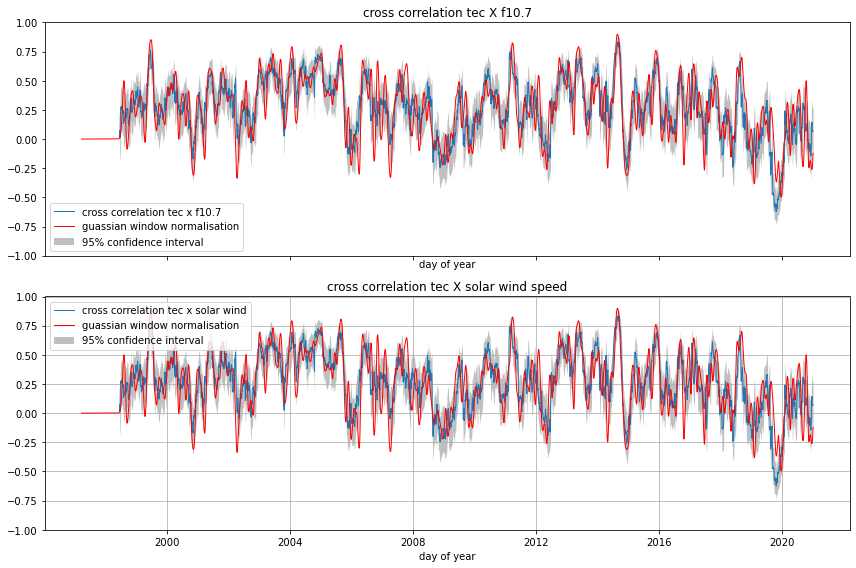

True

In [571]:
def plotGraph(df):
    df = df.reset_index()
    x = df['date']
    y1_corr_f10 = df['lower_limit']
    y2_corr_f10 = df['upper_limit']
    
    y1_corr_sws = df['lower_limit']
    y2_corr_sws = df['upper_limit']
    
    corr_f10 = df['original']
    corr_sws = df['original']
    
    g_corr_f10 = df['normalised']
    g_corr_sws = df['normalised']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

    
    ax1.fill_between(x, y1_corr_f10, y2_corr_f10, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')
    ax1.plot(x, corr_f10, linewidth=1, label='cross correlation tec x f10.7')
    ax1.plot(x, g_corr_f10, linewidth=1, color='r', label='guassian window normalisation')
    plt.grid(True)
    ax1.set(ylim=(-1, 1))
    ax1.set_title('cross correlation tec X f10.7')
    ax1.set_xlabel('day of year')
    ax1.legend(loc="lower left")
    
    ax2.fill_between(x, y1_corr_sws, y2_corr_sws, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')
    ax2.plot(x, corr_sws, linewidth=1, label='cross correlation tec x solar wind')
    ax2.plot(x, g_corr_sws, linewidth=1, color='r', label='guassian window normalisation')
    ax2.set(ylim=(-1, 1))
    ax2.set_title('cross correlation tec X solar wind speed')
    ax2.set_xlabel('day of year')
    fig.tight_layout()
    
    plt.legend(loc="upper left")
    plt.show()
    return True


latitude = 60


corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
norm_corr_tec_f10_7 = readH5File(_corr_norm_tec_x_f10_7_file_path)
corr_up_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_upper_c_of_interval)
corr_low_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_lower_cof_interval)

corr_tec_f10_7 = corr_tec_f10_7[latitude]
norm_corr_tec_f10_7 = norm_corr_tec_f10_7[latitude]
corr_up_limit_tec_f10_7 = corr_up_limit_tec_f10_7[latitude]
corr_low_limit_tec_f10_7 = corr_low_limit_tec_f10_7[latitude]

df = pd.DataFrame()
df['original'] = corr_tec_f10_7
df['normalised'] = norm_corr_tec_f10_7
df['upper_limit'] = corr_up_limit_tec_f10_7
df['lower_limit'] = corr_low_limit_tec_f10_7
plotGraph(df)


#### Plot seasonal correlation map

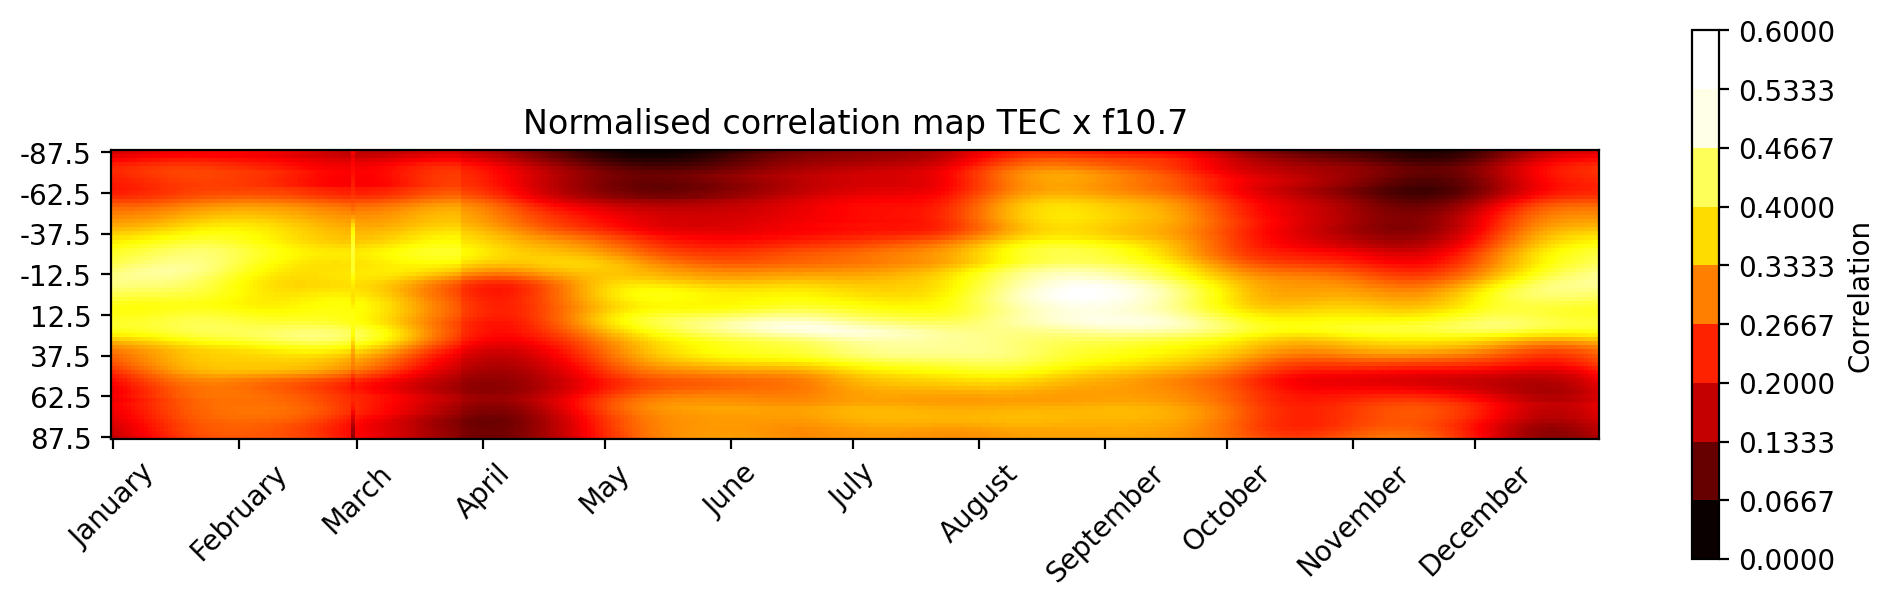

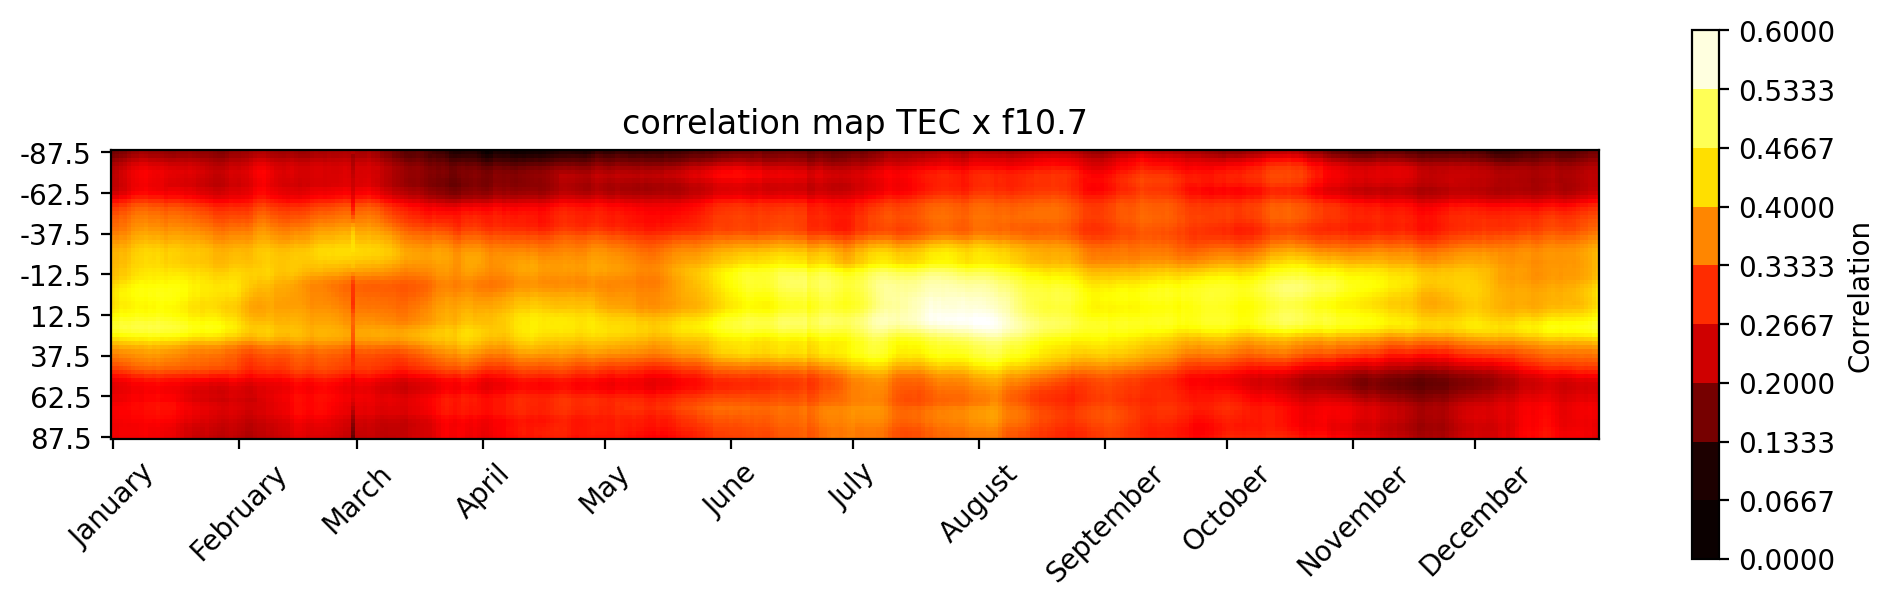

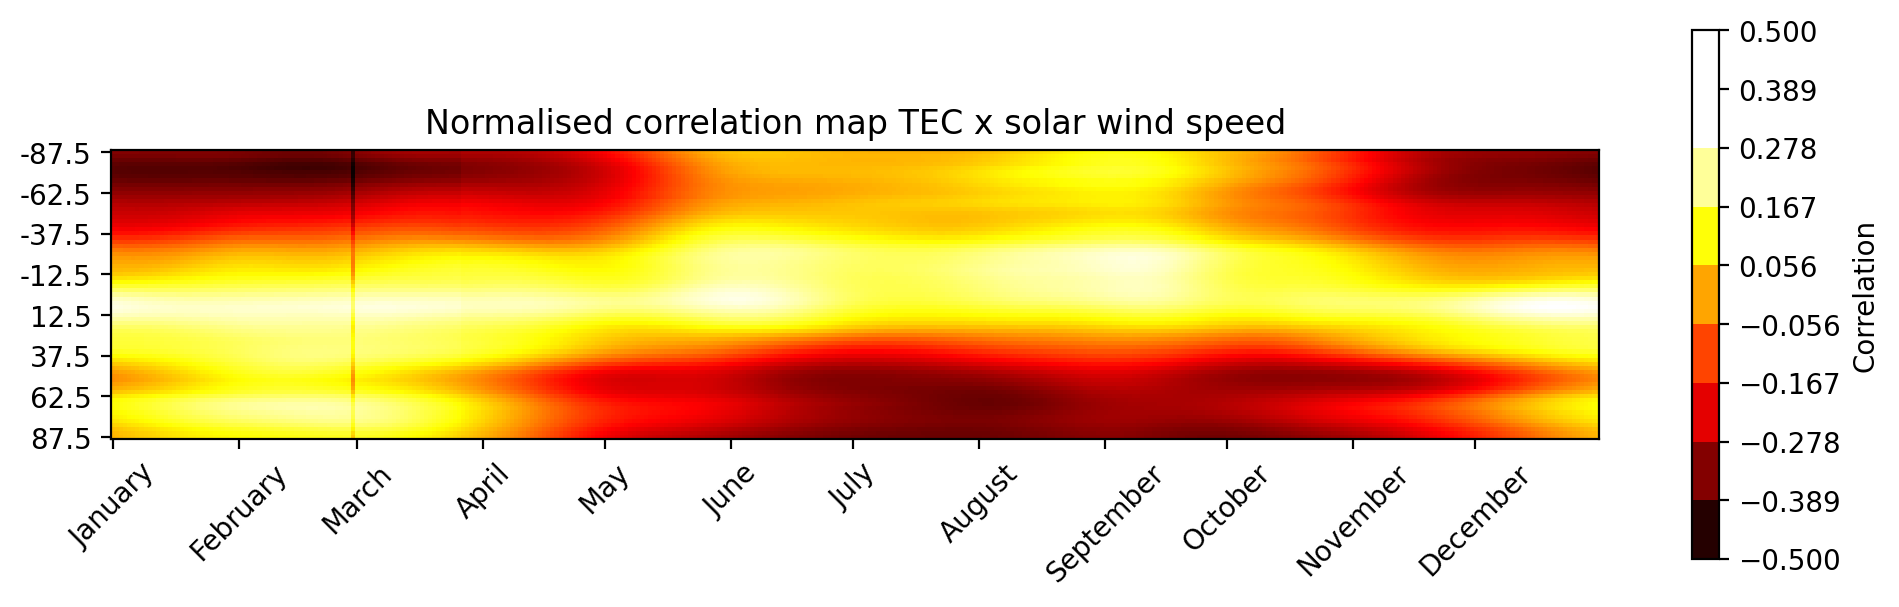

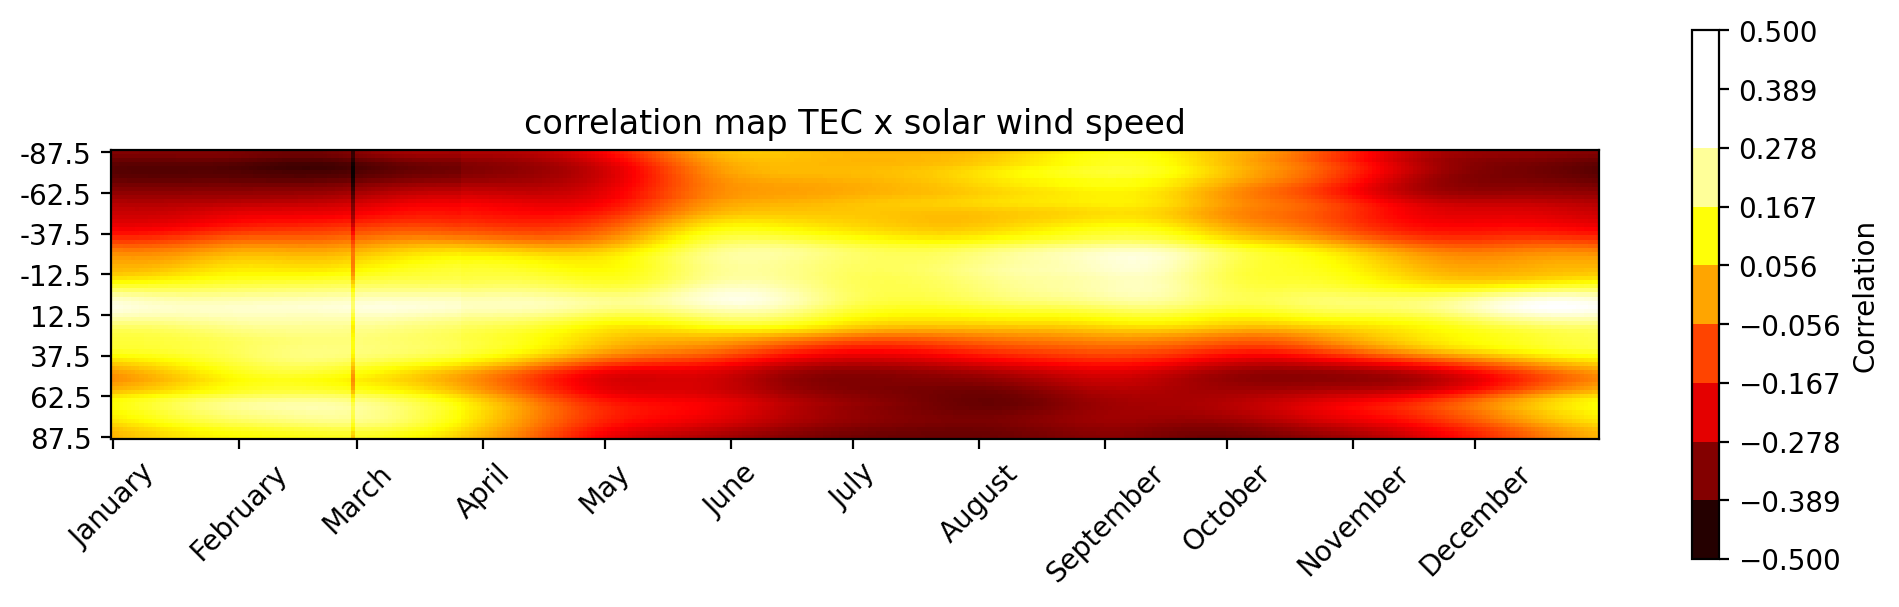

True

In [572]:
def plotMap(df, title, cb_bounds):
#     h5File = 'C:/Users/davi_fr/Documents/Project/data/TEC_MAP_WHOLE/' + title + '.h5'
#     df.to_hdf(h5File, 'df');
    indexValues = df.index.values
    tiks = range(0,71,10)
    lbl = indexValues[tiks]
    
    x_tiks = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]#range(0, 366, 30)
    x_bl = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']
    fig = plt.figure(figsize=(12, 7), dpi=200)
    c = plt.imshow(df, cmap='hot')
    cb = plt.colorbar(c, shrink = 0.5, boundaries=cb_bounds)
    cb.set_label('Correlation')
    plt.yticks(ticks=tiks, labels=lbl)
    plt.xticks(ticks=x_tiks, labels=x_bl, rotation=45)
    
    
    
    plt.title(title)
#     fileName = 'C:/Users/davi_fr/Documents/Project/data/TEC_MAP_WHOLE/' + title + '.jpg'
#     fig.savefig(fileName, bbox_inches='tight', dpi=150)
    plt.show()
    
    
    return True


g_corr_f10_day_mean = readH5File(_corr_norm_tec_f10_7_seasonal)
g_corr_sws_day_mean = readH5File(_corr_norm_tec_sws_seasonal)
corr_f10_day_mean = readH5File(_corr_tec_f10_7_seasonal)
corr_sws_day_mean = readH5File(_corr_norm_tec_sws_seasonal)

g_corr_f10_day_mean = g_corr_f10_day_mean.T
g_corr_sws_day_mean = g_corr_sws_day_mean.T
corr_f10_day_mean = corr_f10_day_mean.T
corr_sws_day_mean = corr_sws_day_mean.T

plotMap(g_corr_f10_day_mean, 'Normalised correlation map TEC x f10.7', np.linspace(0,0.6,10))
plotMap(corr_f10_day_mean, 'correlation map TEC x f10.7', np.linspace(0,0.6,10))
plotMap(g_corr_sws_day_mean, 'Normalised correlation map TEC x solar wind speed', np.linspace(-0.5,0.5,10))
plotMap(corr_sws_day_mean, 'correlation map TEC x solar wind speed', np.linspace(-0.5,0.5,10))


In [230]:
import numpy as np

def testreshape():
    a = np.array(range(1,201))
    a = np.reshape(a,(5,10,4))
    
    b = np.array(range(1,201))
    b = np.reshape(b,(5,10,4))
    
    
    b[2][2][3] = 0
    b[3][4][0] = 0
    b[1][5][1] = 0
    b[4][7][3] = 0
    
    a[2][2][3] = 1
    a[3][4][0] = 1
    a[1][5][1] = 1
    a[4][7][3] = 1
    print('---------------------------b-------------------------')
    print(b)
    print('---------------------------a-------------------------')
    print(a)
    
    b = np.where( b <= 0, a, b)
    print('---------------------------b filled with a-------------------------')
    print(b)
    b = np.reshape(b, (5, 40))
    print('---------------------------a reshaped-------------------------')
    print(b)
    
testreshape()

---------------------------b-------------------------
[[[  1   2   3   4]
  [  5   6   7   8]
  [  9  10  11  12]
  [ 13  14  15  16]
  [ 17  18  19  20]
  [ 21  22  23  24]
  [ 25  26  27  28]
  [ 29  30  31  32]
  [ 33  34  35  36]
  [ 37  38  39  40]]

 [[ 41  42  43  44]
  [ 45  46  47  48]
  [ 49  50  51  52]
  [ 53  54  55  56]
  [ 57  58  59  60]
  [ 61   0  63  64]
  [ 65  66  67  68]
  [ 69  70  71  72]
  [ 73  74  75  76]
  [ 77  78  79  80]]

 [[ 81  82  83  84]
  [ 85  86  87  88]
  [ 89  90  91   0]
  [ 93  94  95  96]
  [ 97  98  99 100]
  [101 102 103 104]
  [105 106 107 108]
  [109 110 111 112]
  [113 114 115 116]
  [117 118 119 120]]

 [[121 122 123 124]
  [125 126 127 128]
  [129 130 131 132]
  [133 134 135 136]
  [  0 138 139 140]
  [141 142 143 144]
  [145 146 147 148]
  [149 150 151 152]
  [153 154 155 156]
  [157 158 159 160]]

 [[161 162 163 164]
  [165 166 167 168]
  [169 170 171 172]
  [173 174 175 176]
  [177 178 179 180]
  [181 182 183 184]
  [185 186 187 188

## Reconfigures function for app data (TEC)

In [18]:
_tec_yearly_file_path_app = 'C:/Users/davi_fr/Documents/Thesis Project Final/tets folder main/test/data_formatting/tec_mp/'

# return a dataframe with given index and columns
# values will be NaN
def initTecDataFrame_app(index, columns):
    df = pd.DataFrame(np.nan, index=index, columns=columns)
    return df


# generate an empty dataframe with index as date and hourly ut and columns as latitude and longitude
# empty dataframe replica of original data.
# prepare columns and index values
def generateInitialData_app(date):
    date = date.strftime('%Y-%m-%d')
    lat = generateLatitudeArray()
    lon = generateLongitudeArray()
    timeArray = generateTimeSeries(date, date, 'H')
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    timeIndex = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    locationIndex = pd.MultiIndex.from_product([lat, lon], 
                                               names=[_lat, _lon])
    indexValues = pd.MultiIndex.from_product([timeArray, lat, lon], 
                                               names=['Epoch', _lat, _lon])
    
    return initTecDataFrame_app(indexValues, ['tec'])



# extract tec data from cdf files for app
# input as raw data and satellites as priority wise
def extractTecData_app(data, tecVariables):
    latArray = data['lat'][:]
    lonArray = data['lon'][:]
    timeArray = data['Epoch'][:]
    timeArraySize = len(timeArray)
    locationSize = len(latArray) * len(lonArray)
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    
    locations = [latArray, lonArray]
    locationIndex = pd.MultiIndex.from_product(locations, 
                                               names=[_lat, _lon])
    locationIndex_1 = pd.MultiIndex.from_product([timeArray, latArray, lonArray], 
                                               names=['Epoch', _lat, _lon])
    
        
    tecValueArray = []

    for variables in tecVariables:
        if len(tecValueArray) == 0:
            tecValueArray = data[variables][:]
        else:
            altTecValueArray = data[variables][:]
            tecValueArray = np.where( tecValueArray <= 0, altTecValueArray, tecValueArray)
            
#     tecValueArray = np.reshape(tecValueArray, (timeArraySize, locationSize))
    tecValueArray = tecValueArray.flatten()
    tecDataFrame = pd.DataFrame(tecValueArray)
    tecDataFrame.columns = ['tec']
    tecDataFrame.index = locationIndex_1 # pd.MultiIndex.from_arrays([date, ut], 
#                                                  names=[_date, _ut])
    tecDataFrame[tecDataFrame <= 0] = np.nan
    return tecDataFrame



analysisDateSeries = generateTimeSeries(startDate, endDate, 'D')
tecData = pd.DataFrame()
for date in analysisDateSeries:
    tecFileConfigs = getTecFilePath(date)
    tecDataDaily = generateInitialData_app(date)
    for tecFileConfig in tecFileConfigs:
        filePath = tecFileConfig['file_path']
        tecStations = tecFileConfig['tec_stations']
        if Path(filePath).is_file():
            data = readCDFFile(filePath)
            data = extractTecData_app(data, tecStations)
            tecDataDaily = tecDataDaily.where(tecDataDaily.notnull(),data)
        else:
            error = 'No file found: ' + date.strftime(dateFormat)
            log(error)
#     if len(tecDataDaily) != 0:
#         print(tecDataDaily)
    
    tecData = pd.concat([tecData, tecDataDaily])
    if date.is_year_end:
        print(tecData)
        tecYear = date.year
        tecFilePath = _tec_yearly_file_path_app + str(tecYear) + '.h5'
        saveToHDFFile(tecData, tecFilePath)
        status = str(tecYear) + ' File Saved'
        log(status)
        tecData = pd.DataFrame()
        

                                tec
Epoch               lat   lon      
1997-01-01 00:00:00  87.5 -180  NaN
                          -175  NaN
                          -170  NaN
                          -165  NaN
                          -160  NaN
...                             ...
1997-12-31 23:00:00 -87.5  160  NaN
                           165  NaN
                           170  NaN
                           175  NaN
                           180  NaN

[45403080 rows x 1 columns]
                                      tec
Epoch               lat   lon            
1998-01-01 00:00:00  87.5 -180        NaN
                          -175        NaN
                          -170        NaN
                          -165        NaN
                          -160        NaN
...                                   ...
1998-12-31 23:00:00 -87.5  160  19.100000
                           165  19.299999
                           170  19.600000
                           175  19.799999

                                      tec
Epoch               lat   lon            
2013-01-01 00:00:00  87.5 -180   5.400000
                          -175   5.400000
                          -170   5.600000
                          -165   5.600000
                          -160   5.700000
...                                   ...
2013-12-31 23:00:00 -87.5  160  21.000000
                           165  21.000000
                           170  21.100000
                           175  21.200001
                           180  21.299999

[45403080 rows x 1 columns]
                                      tec
Epoch               lat   lon            
2014-01-01 00:00:00  87.5 -180   9.600000
                          -175   9.500000
                          -170   9.200000
                          -165   9.000000
                          -160   8.600000
...                                   ...
2014-12-31 23:00:00 -87.5  160  19.299999
                           165  18.799999
     

In [12]:
for year in analysisPeriod:
    startDate = str(year)+'-01-01'
    endDate = str(year)+'-12-31'
#     timeArray = generateTimeSeries(startDate, endDate, 'H')
    tecFilePath = _tec_yearly_file_path + str(year) + '.h5'
    tecData = readH5File(tecFilePath)
#     tecData = tecData.reset_index(drop=True)
    tecData = tecData.reset_index()
#     tecData['Epoch'] = timeArray
#     tecData = tecData.set_index('Epoch')
    savePath = 'C:/Users/davi_fr/Documents/Thesis Project Final/tets folder main/test/data_formatting/tec_indexed/'+str(year)+'.h5'
#     saveToHDFFile(tecData, savePath)
    tecData['ut'] = pd.to_datetime(tecData['ut'])
    print(tecData.index.dtypes)

TypeError: <class 'datetime.time'> is not convertible to datetime

In [16]:
filePath = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
data = readH5File(filePath)
data = data.drop(['f10_7_ma_27', 'f10_7_diff_rel'], axis=1)
print(data)
saveToHDFFile(data, filePath)


filePath = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
data = readH5File(filePath)
data = data.drop(['sws_ma_27', 'sws_diff_rel'], axis=1)
print(data)
saveToHDFFile(data, filePath)

            f10_7
date             
1997-01-01   70.0
1997-01-02   69.7
1997-01-03   70.8
1997-01-04   71.4
1997-01-05   71.9
...           ...
2020-12-27   84.9
2020-12-28   84.3
2020-12-29   81.4
2020-12-30   80.1
2020-12-31   78.5

[8766 rows x 1 columns]
               sws
1997-01-01     NaN
1997-01-02     NaN
1997-01-03     NaN
1997-01-04     NaN
1997-01-05     NaN
...            ...
2020-12-27  463.09
2020-12-28  486.17
2020-12-29  467.50
2020-12-30  478.41
2020-12-31  398.60

[8766 rows x 1 columns]


In [21]:
for year in analysisPeriod:
    tecFilePath = _tec_yearly_file_path + str(year) + '.h5'
    tecData = readH5File(tecFilePath)
    print(tecData.columns.names)
    break

['lat', 'lon']


In [29]:
dataset = [
    {
        "name": "f10",
        "location": f10_7_file_path
    },
    {
        "name": "f10_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"
    },
    {
        "name": "sws",
        "location": sws_file_path
    },
    {
        "name": "sws_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
    },
    {
        "name": "tec",
        "location": _tec_ut_mean_file_path + _tec_ut_mean_map_file
    },
    {
        "name": "tec_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
    },
    {
        "name": "corr_tec_f10",
        "location": _corr_tec_x_f10_7_file_path,
        "saveLocation": "C:\\Users\\davi_fr\\Documents\\verify data\\corr_tec_f10.xlsx"
    },
    {
        "name": "corr_tec_f10_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5",
        "saveLocation": "C:\\Users\\davi_fr\\Documents\\verify data\\corr_tec_f10_new.xlsx"
    }
]

for metadata in dataset:
    dataname = metadata["name"]
    datalocation = metadata["location"]
    data = readH5File(datalocation)
    print('-----------------------------------------------------', dataname)
    print(data)
    datasavelocation = metadata["saveLocation"] if 'saveLocation' in metadata else ''
    if datasavelocation != '':
        data.to_excel(datasavelocation)
        print('data saved at ', datasavelocation)


----------------------------------------------------- f10
            f10_7  f10_7_ma_27  f10_7_diff_rel
date                                          
1997-01-01   70.0          NaN             NaN
1997-01-02   69.7          NaN             NaN
1997-01-03   70.8          NaN             NaN
1997-01-04   71.4          NaN             NaN
1997-01-05   71.9          NaN             NaN
...           ...          ...             ...
2020-12-27   84.9    84.681481        0.258048
2020-12-28   84.3    84.055556        0.290813
2020-12-29   81.4    83.296296       -2.276567
2020-12-30   80.1    82.562963       -2.983133
2020-12-31   78.5    82.025926       -4.298551

[8766 rows x 3 columns]
----------------------------------------------------- f10_new
               f10_7
date                
1997-01-01       NaN
1997-01-02       NaN
1997-01-03       NaN
1997-01-04       NaN
1997-01-05       NaN
...              ...
2020-12-27  0.258048
2020-12-28  0.290813
2020-12-29 -2.276567
2020-12-30 -2

data saved at  C:\Users\davi_fr\Documents\verify data\corr_tec_f10.xlsx
----------------------------------------------------- corr_tec_f10_new
lat            -87.5     -85.0     -82.5     -80.0     -77.5     -75.0  \
date                                                                     
1997-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  0.346058  0.350853  0.352579  0.354204  0.361833  0.356409   
2020-12-28  0.346356  0.350989  0.352630  0.354216  0.361864  0.356455   
2020-12-29  0.349604  0.354047  0.355471  0.356805  0.364188  0.358703   
2020-12-30  0.352708  0.357221  0.358723  0

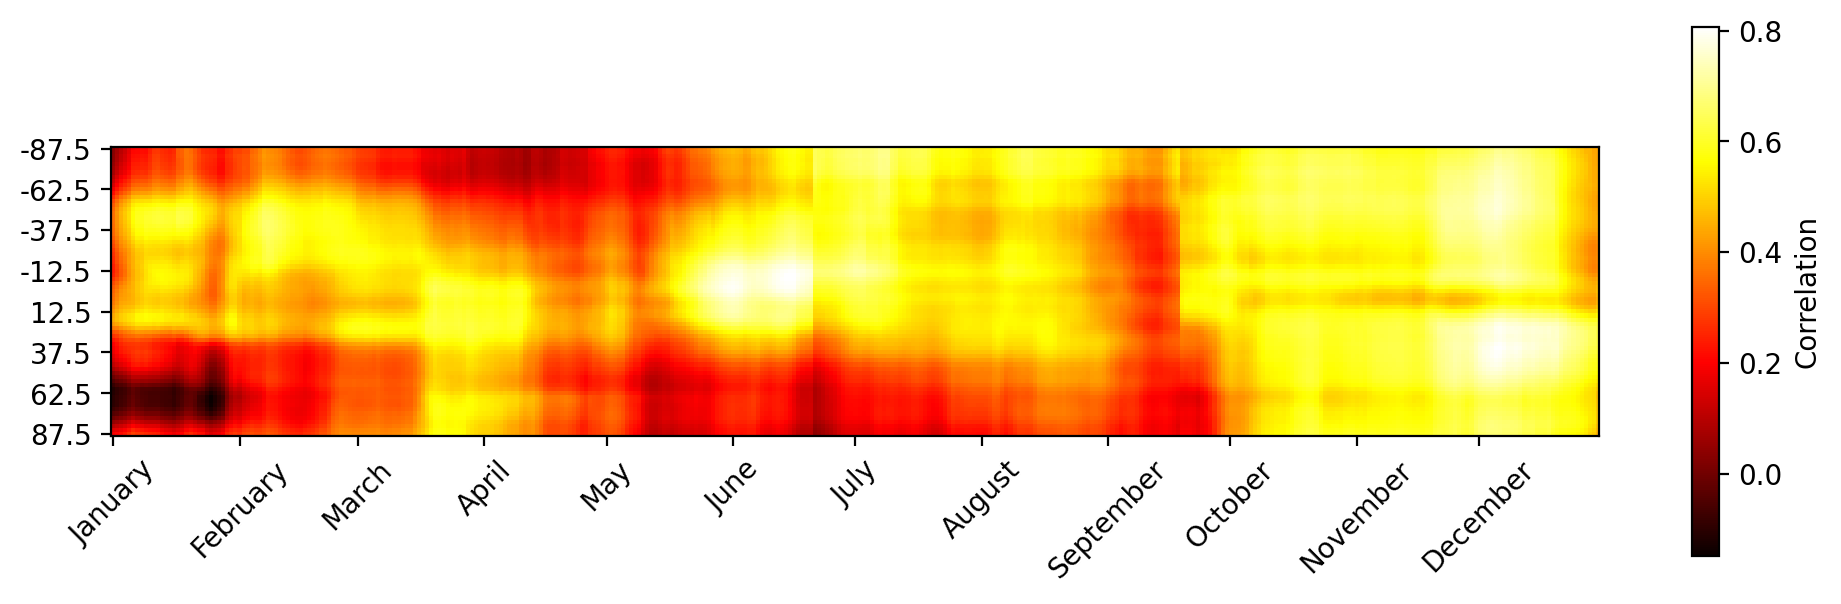

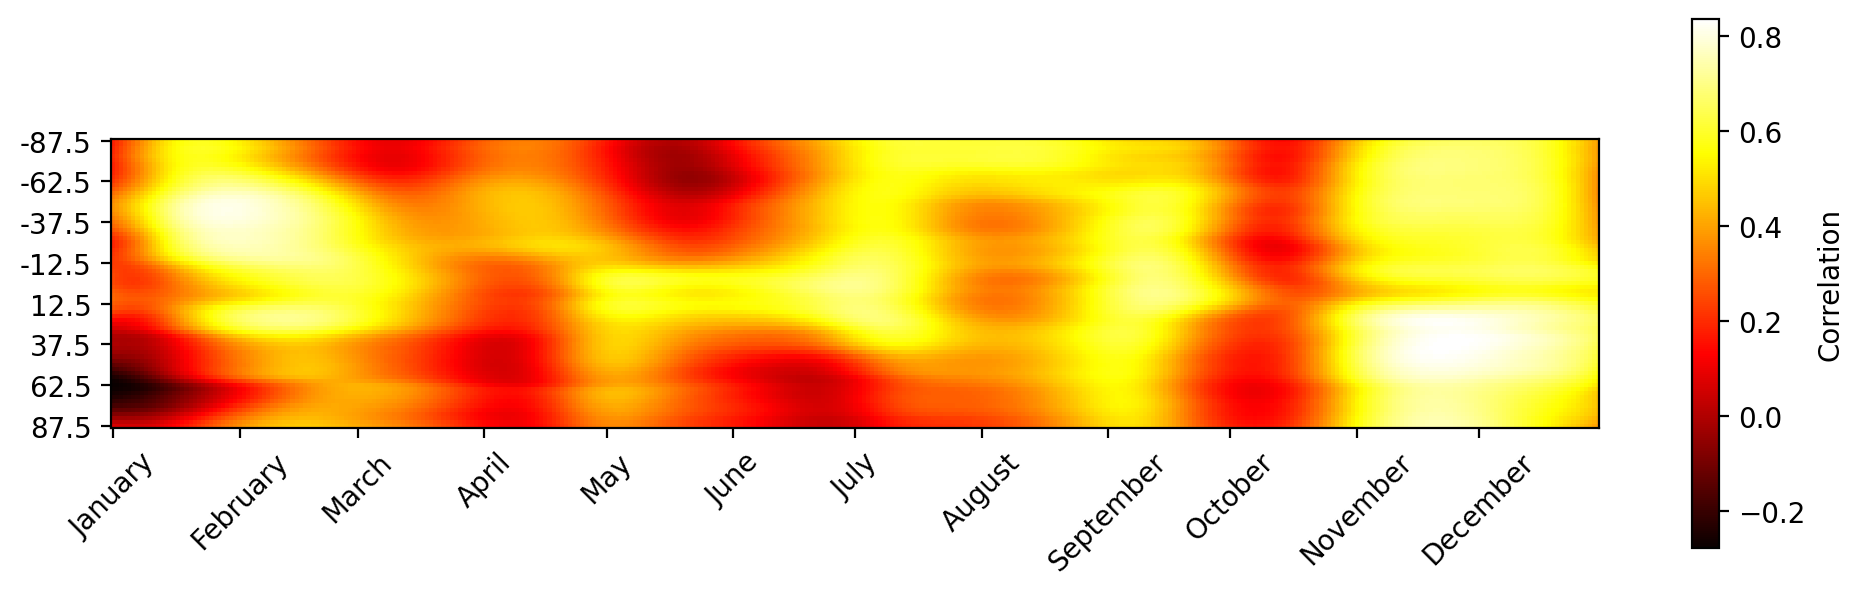

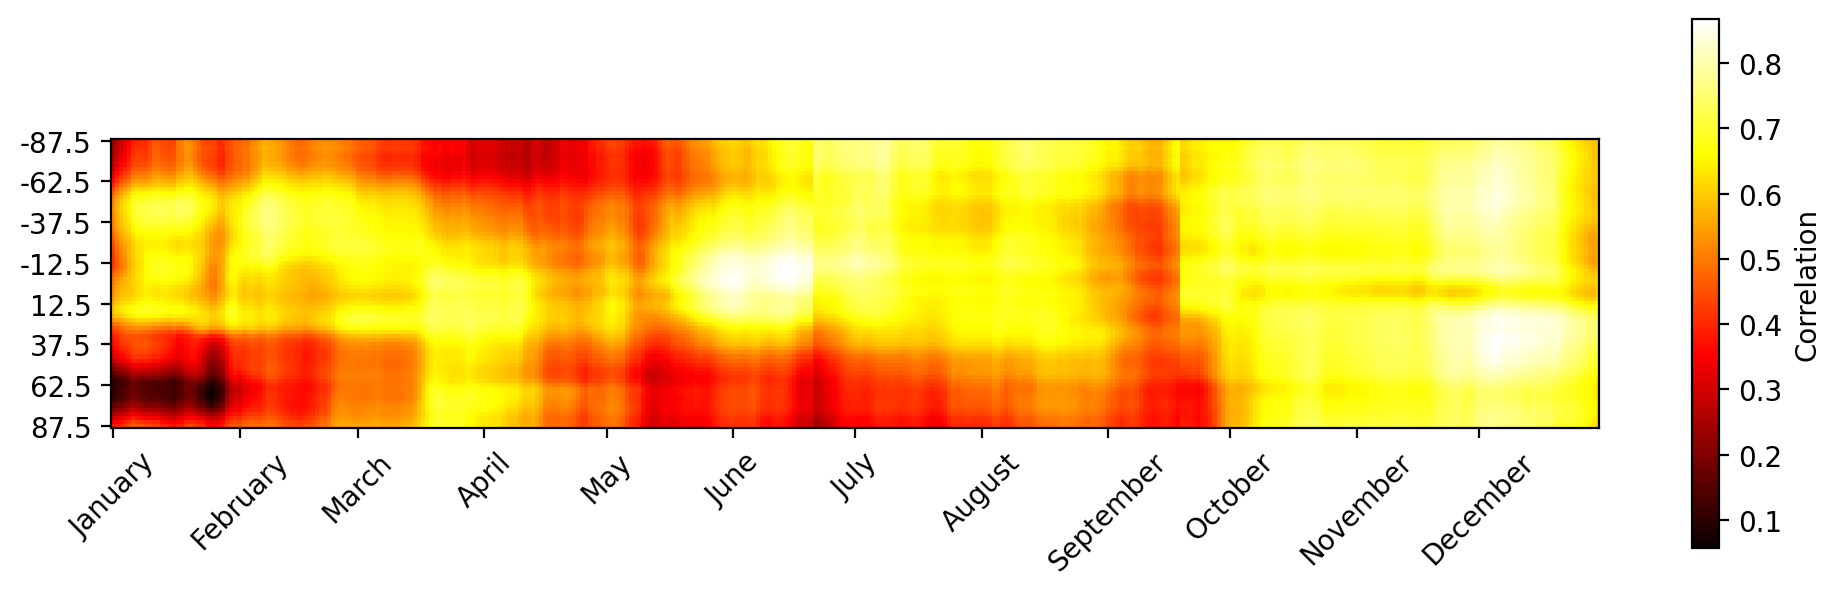

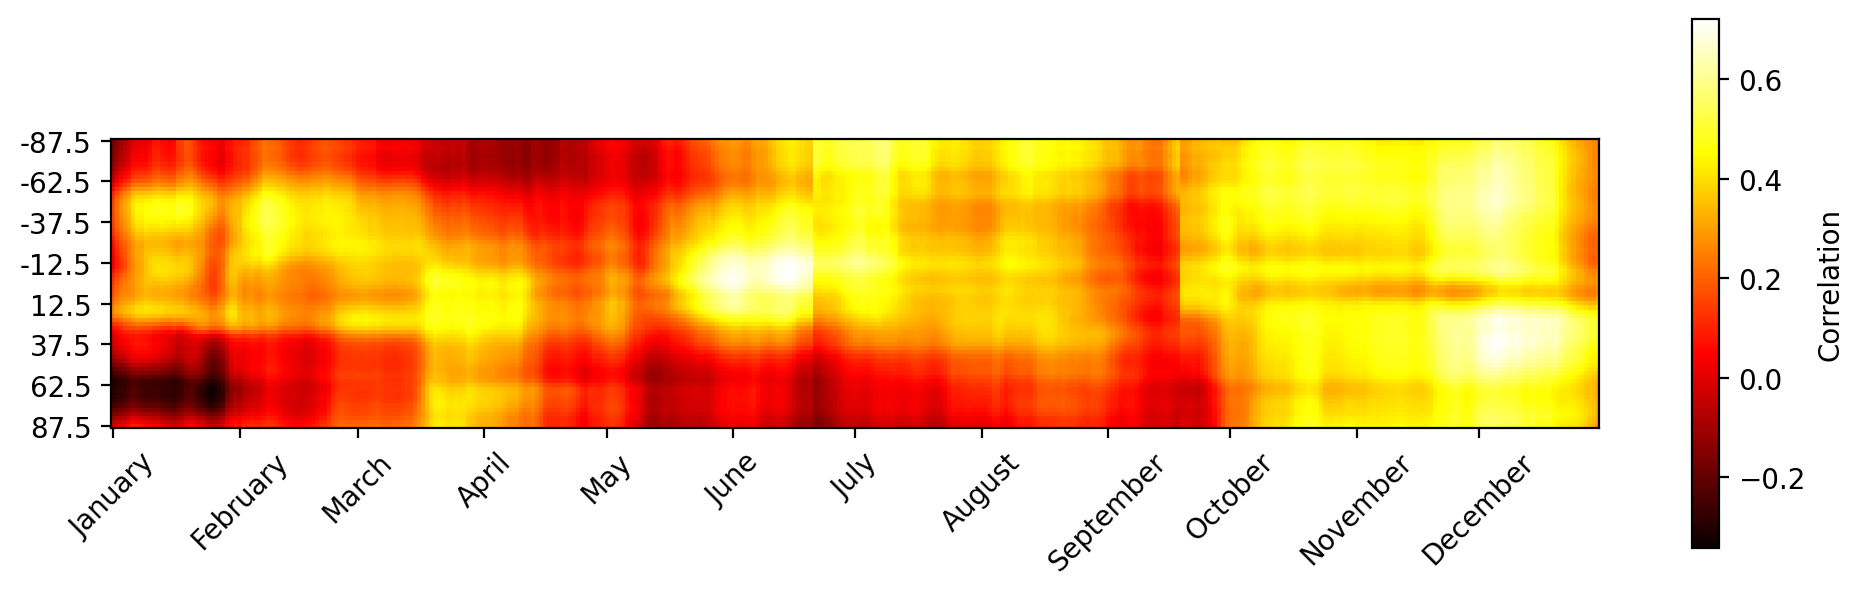

In [50]:
def plotdata(df):
    df = df.T
    indexValues = df.index.values
    tiks = range(0,71,10)
    lbl = indexValues[tiks]

    x_tiks = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]#range(0, 366, 30)
    x_bl = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']
    fig = plt.figure(figsize=(12, 7), dpi=200)
    c = plt.imshow(df, cmap='hot')
    cb = plt.colorbar(c, shrink = 0.5)
    cb.set_label('Correlation')
    plt.yticks(ticks=tiks, labels=lbl)
    plt.xticks(ticks=x_tiks, labels=x_bl, rotation=45)
    
    plt.show()

corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
norm_corr_tec_f10_7 = readH5File(_corr_norm_tec_x_f10_7_file_path)
corr_up_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_upper_c_of_interval)
corr_low_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_lower_cof_interval)

checkYear = 2015

corr_tec_f10_7 = (corr_tec_f10_7[pd.to_datetime(corr_tec_f10_7.index.get_level_values('date')).year == checkYear])
# print(corr_tec_f10_7)
norm_corr_tec_f10_7 = norm_corr_tec_f10_7[pd.to_datetime(norm_corr_tec_f10_7.index.get_level_values('date')).year == checkYear]
corr_up_limit_tec_f10_7 = corr_up_limit_tec_f10_7[pd.to_datetime(corr_up_limit_tec_f10_7.index.get_level_values('date')).year == checkYear]
corr_low_limit_tec_f10_7 = corr_low_limit_tec_f10_7[pd.to_datetime(corr_low_limit_tec_f10_7.index.get_level_values('date')).year == checkYear]


plotdata(corr_tec_f10_7)
plotdata(norm_corr_tec_f10_7)
plotdata(corr_up_limit_tec_f10_7)
plotdata(corr_low_limit_tec_f10_7)


# print(corr_low_limit_tec_f10_7)

In [48]:
TecFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    tecData = tecData[tecData.isna().any(axis=1)]
    print(tecData)
    fileName = str(year)+'.csv'
    tecData.to_csv("nan_tec_data/"+fileName)
    TecFullData = pd.concat([TecFullData, tecData])
    


# TecFullData.to_excel("nan_tec_data.xlsx")
print(TecFullData)

lat                  87.5                                               ...  \
lon                  -180 -175 -170 -165 -160 -155 -150 -145 -140 -135  ...   
date       ut                                                           ...   
1997-01-01 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           01:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           02:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           03:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           04:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1997-12-31 19:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           20:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           21:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           22:00:00   NaN  NaN  NaN  NaN  NaN  NaN  

lat                  87.5                                               ...  \
lon                  -180 -175 -170 -165 -160 -155 -150 -145 -140 -135  ...   
date       ut                                                           ...   
2001-01-01 00:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           02:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           04:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           06:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           08:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2001-12-31 14:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           16:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           18:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           20:00:00   NaN  NaN  NaN  NaN  NaN  NaN  

lat                  87.5                                               ...  \
lon                  -180 -175 -170 -165 -160 -155 -150 -145 -140 -135  ...   
date       ut                                                           ...   
2005-01-01 01:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           03:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           05:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           07:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           09:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2005-12-31 15:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           17:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           19:00:00   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           21:00:00   NaN  NaN  NaN  NaN  NaN  NaN  

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2008-01-01 01:00:00        NaN        NaN        NaN        NaN        NaN   
           03:00:00        NaN        NaN        NaN        NaN        NaN   
           05:00:00        NaN        NaN        NaN        NaN        NaN   
           07:00:00        NaN        NaN        NaN        NaN        NaN   
           09:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2008-12-19 21:00:00        NaN        NaN        NaN        NaN        NaN   
           23:00:00        NaN        NaN        NaN        NaN        NaN   
2008-12-22 23:00:00 -12.347823 -11.578944  -9.677415  10.126586  24.675327   
2008-12-25 23:00:00 -31.130437 -34.615383 -33.687941 -32.854576 

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2011-01-13 13:00:00  -4.359675  -3.438793  -0.681198  -0.951085   3.278687   
2011-02-13 11:00:00  38.382688  38.857143  35.948483  39.208640  37.621353   
2011-02-15 11:00:00  14.456524  14.956335  20.670390  26.949539  23.157898   
2011-02-21 07:00:00  19.580416  17.940715  15.165879  18.515562  22.825216   
2011-03-04 07:00:00  27.018437  29.475703  33.506830  34.911241  33.751651   
2011-04-17 19:00:00   8.488197  13.655720  17.069521  17.275421  16.986709   
2011-04-21 19:00:00  -0.171398  -0.024362  -0.484968   1.201348   2.727924   
           21:00:00  11.417716  13.067611  13.598793  13.904141  13.004480   
2011-05-13 15:00:00   1.093025  -0.116335   0.046905  -1.073514  -1.211841   
           17:00:00   2.077018   1.517985   3.578945   2.791878 

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2012-02-26 07:00:00   5.078308   8.052076  12.718451  24.454148  25.060947   
2012-03-08 07:00:00  18.400686  17.391308   7.353571   3.272418   1.349637   
2012-03-12 17:00:00  -9.408511  -9.814051 -11.129964 -14.401352 -15.145439   
2012-03-13 17:00:00  -5.440325  -5.006769  -3.732091  -3.411724  -1.608663   
           19:00:00  -1.303243   0.095056   2.143758   2.671279   4.237289   
...                        ...        ...        ...        ...        ...   
2012-12-17 03:00:00  -9.213181  -5.645165  -4.472626  -1.263299   4.622702   
           05:00:00  11.712285  11.287255  12.290499  20.222632  26.752415   
2012-12-20 05:00:00  -1.369864  -3.696498  -9.027333 -13.068183 -14.960627   
           07:00:00   0.285711   2.257825   5.882349   9.345791 

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2014-04-10 23:00:00  -1.778843  -2.929994  -4.007487  -4.631082  -5.122599   
2014-04-22 01:00:00 -23.060454 -23.526525 -24.018321 -24.130041 -24.472434   
2014-05-02 23:00:00  13.861983  13.222309  12.143988  12.744906  13.271905   
2014-05-11 03:00:00   2.634554   1.743535  -1.716336  -5.909093  -7.449255   
           05:00:00 -13.980509 -13.279487 -13.283924 -10.514287  -2.022299   
           21:00:00  -6.297528  -6.173560  -6.253595  -4.120770  -0.338981   
2014-05-12 15:00:00   6.428439   6.762747   6.428437   8.577750  12.353705   
2014-06-07 03:00:00  12.438088  12.665446  10.631233   9.889505   7.248769   
           11:00:00  -0.598910  -0.423506   2.112923   5.358752   6.326346   
           13:00:00  -7.988830  -7.575762  -5.548240  -2.771491 

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2016-04-14 23:00:00 -10.834884  -9.766060  -8.237903  -8.457522  -7.105462   
2016-06-07 23:00:00 -16.923074 -17.187497 -17.259320 -18.016194 -17.918740   
2016-06-13 15:00:00   1.871167   1.260374  -3.008905  -5.119657  -6.311693   
2016-06-20 07:00:00   0.733944   1.136013   2.013006   0.527459  -5.189557   
2016-07-03 23:00:00 -16.777886 -16.857144 -17.531019 -18.364099 -18.207908   
2016-09-24 19:00:00 -24.025974 -24.548582 -27.088606 -27.486360 -27.709305   

lat                                                                         \
lon                       -155       -150       -145       -140       -135   
date       ut                                                                
2016-04-14 23:00:00  -7.103218  -2.527076  -1.431640  -3.028171

Exception ignored in: <function ZipFile.__del__ at 0x0000027EFB761550>
Traceback (most recent call last):
  File "C:\Users\davi_fr\Anaconda3\lib\zipfile.py", line 1807, in __del__
    self.close()
  File "C:\Users\davi_fr\Anaconda3\lib\zipfile.py", line 1824, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Exception ignored in: <function ZipFile.__del__ at 0x0000027EFB761550>
Traceback (most recent call last):
  File "C:\Users\davi_fr\Anaconda3\lib\zipfile.py", line 1807, in __del__
    self.close()
  File "C:\Users\davi_fr\Anaconda3\lib\zipfile.py", line 1824, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2019-03-24 17:00:00  50.506755  50.499165  48.784445  53.554498  62.500003   
2019-04-26 01:00:00   2.051836   2.162162   4.015191  10.978906  10.799135   
2019-05-23 01:00:00  23.350248  22.727268  15.311218   2.798167   3.606106   
2019-06-06 01:00:00  -2.827769  -4.072793  -0.840705   6.547088  10.519369   
           15:00:00   2.121769   2.405178   6.249999   7.042910   9.154273   
...                        ...        ...        ...        ...        ...   
2019-10-06 19:00:00 -18.411803 -18.981155 -14.403861 -11.596177 -11.445781   
2019-10-08 19:00:00  -9.550967  -8.215295 -11.134457  -4.573807  -2.851320   
2019-10-09 19:00:00 -21.965319 -20.531230 -21.377843 -18.526313 -20.260986   
2019-12-01 05:00:00 -28.750001 -30.472104 -30.873492 -28.837207 

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
1997-01-01 00:00:00        NaN        NaN        NaN        NaN        NaN   
           01:00:00        NaN        NaN        NaN        NaN        NaN   
           02:00:00        NaN        NaN        NaN        NaN        NaN   
           03:00:00        NaN        NaN        NaN        NaN        NaN   
           04:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2020-12-07 07:00:00 -85.499463 -82.467532 -79.139073 -75.143843 -71.208532   
           21:00:00 -74.162679 -75.432211 -76.148410 -75.892857 -75.935829   
2020-12-08 23:00:00 -29.988728 -36.761712 -36.242301 -37.900000 -40.913417   
2020-12-09 01:00:00 -36.506162 -34.752592 -33.606560 -33.528725 

KeyboardInterrupt: 

month  day
1      1      0.431511
       2      0.430573
       3      0.429623
       4      0.428674
       5      0.427742
                ...   
12     27     0.445680
       28     0.445315
       29     0.444825
       30     0.444230
       31     0.443548
Name: 0.0, Length: 366, dtype: float64


<AxesSubplot:xlabel='lat'>

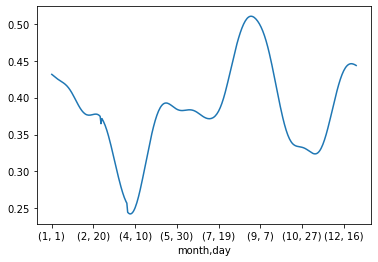

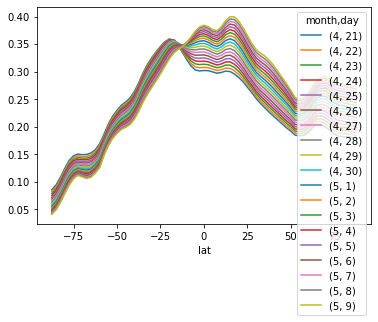

In [132]:
corr_season_map_f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\mean\\seasonal_mean_corr_tex_x_f10_7\\seasonal_mean_corr_tex_x_f10_7.h5"
corr_season_map_f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\mean\\seasonal_mean_norm_corr_tex_x_f10_7\\seasonal_mean_norm_corr_tex_x_f10_7.h5"

data = readH5File(corr_season_map_f10)
# data = data[pd.to_datetime(data.index.get_level_values('month')) == 4, 
#            pd.to_datetime(data.index.get_level_values('day')) == 31]
sample = data.copy()
# sample = sample.reset_index()
latvalue = sample[0]
print(latvalue)
latvalue.plot()
sample = sample[111:130].T
sample.plot()


In [14]:
tecfile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\extract_column\\tec_location_52_5_15\\tec_location_52_5_15.h5"
data = readH5File(tecfile)
data = data.unstack(level='ut')
# print(data)

corrtecfile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\normalised_correlation\\tec_f10_7_location_52_5_15\\tec_f10_7_location_52_5_15.h5"
data = readH5File(corrtecfile)
print(data)


lat             52.5                                                    \
lon               15                                                     
ut          00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00   
date                                                                     
1997-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  0.078175  0.030499 -0.032175 -0.125011 -0.059864 -0.230037   
2020-12-28  0.066649  0.036120 -0.029083 -0.128625 -0.062066 -0.225842   
2020-12-29  0.055766  0.042445 -0.025028 -0.131234 -0.063662 -0.220871   
2020-12-30  0.045644  0.049433 -0.0200

In [56]:
# swap levels
from ast import literal_eval
# extractColumns = "(-180, -87.5)"
# extractColumns = literal_eval(extractColumns)
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec\\2003.h5"
df = readH5File(file)
print(df[[(87.5, 180)]])


df.columns = df.columns.swaplevel('lat', 'lon')
# df.sort_index(axis=1, level=0, inplace=True)

print(df[[(180, 87.5)]])

lat                       87.5                                              \
lon                       -180       -175       -170       -165       -160   
date       ut                                                                
2003-01-01 00:00:00 -38.478502 -38.771033 -39.038603 -39.780623 -39.493021   
           01:00:00        NaN        NaN        NaN        NaN        NaN   
           02:00:00 -43.382607 -43.653781 -44.112657 -44.282815 -44.712992   
           03:00:00        NaN        NaN        NaN        NaN        NaN   
           04:00:00 -34.361395 -34.242096 -34.763796 -34.716710 -35.114779   
...                        ...        ...        ...        ...        ...   
2003-12-31 19:00:00        NaN        NaN        NaN        NaN        NaN   
           20:00:00   3.646833   5.644643   7.514448   9.178437  11.196912   
           21:00:00        NaN        NaN        NaN        NaN        NaN   
           22:00:00  88.322876  89.843748  94.062496  95.256613 

In [71]:
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\swap_column_level\\tec_ut_column_swap\\tec_ut_column_swap.h5"
df = readH5File(file)
print(df)
print(df.columns)

lon                       -180       -175       -170       -165       -160  \
lat                       87.5       87.5       87.5       87.5       87.5   
date       ut                                                                
2003-01-01 00:00:00 -38.478502 -38.771033 -39.038603 -39.780623 -39.493021   
           01:00:00        NaN        NaN        NaN        NaN        NaN   
           02:00:00 -43.382607 -43.653781 -44.112657 -44.282815 -44.712992   
           03:00:00        NaN        NaN        NaN        NaN        NaN   
           04:00:00 -34.361395 -34.242096 -34.763796 -34.716710 -35.114779   
...                        ...        ...        ...        ...        ...   
2003-12-31 19:00:00        NaN        NaN        NaN        NaN        NaN   
           20:00:00   3.646833   5.644643   7.514448   9.178437  11.196912   
           21:00:00        NaN        NaN        NaN        NaN        NaN   
           22:00:00  88.322876  89.843748  94.062496  95.256613 

In [112]:
import datetime as dt
def getTimeIndexColumn(df):
    indexValue = None
    timeIndexColumn = None
    indexNames = []
    try:
        indexValue = df.index[0]
        indexNames = df.index.names
    except:
        print('No index values found')
    if isinstance(indexValue, (list, tuple)) and len(indexValue) > 1:
        for i in range(len(indexValue)):
            value = indexValue[i]
            if isinstance(value, dt.time):
                timeIndexColumn = indexNames[i]
                break
    else:
        print('--------')
        if isinstance(indexValue, dt.time):
            timeIndexColumn = indexNames
            
    return timeIndexColumn
def getDateIndexColumn(df):
    indexValue = None
    dateIndexColumn = None
    indexNames = []
    try:
        indexValue = df.index[0]
        indexNames = df.index.names
    except:
        print('No index values found')
    print(indexValue)
    print(indexNames)
    if isinstance(indexValue, (list, tuple)) and len(indexValue) > 1:
        for i in range(len(indexValue)):
            value = indexValue[i]
            if isinstance(value, dt.date):
                dateIndexColumn = indexNames[i]
                break
    else:
        if isinstance(indexValue, dt.date):
            if isinstance(indexNames, (list, tuple)) and len(indexNames) > 0:
                dateIndexColumn = indexNames[0]
            else:
                dateIndexColumn = indexNames
            
    return dateIndexColumn


file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
df = readH5File(file)
print(df)
# tcol = getTimeIndexColumn(df)
# dateTimeIndexColumn = getDateIndexColumn(data)
# df = df[pd.to_datetime(df.index.get_level_values(dateTimeIndexColumn), format="%Y-%m-%d").year == 2003]
# df = df[pd.to_datetime(df.index.get_level_values(tcol), format="%H:%M:%S").hour == 13]
# # df = df[pd.to_datetime(df.index.get_level_values(tcol), format='%H:%M:%S')]
# print(df)


lat            -87.5     -85.0     -82.5     -80.0     -77.5     -75.0  \
date                                                                     
1997-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  4.325590  4.017030  3.367961  3.315891  4.758659  6.430731   
2020-12-28 -5.481128 -6.244233 -7.098475 -7.774390 -6.757711 -4.928879   
2020-12-29 -2.977550 -3.361446 -4.468311 -4.795175 -3.395730 -1.622377   
2020-12-30 -7.283525 -7.804430 -8.569702 -8.582900 -7.884720 -6.967479   
2020-12-31  0.191344 -0.123766 -0.696799 -1.835044 -2.221168 -1.449542   

lat            -72.5     -70.0     -6

In [155]:
file1 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_lowerConfInterval.h5"
file2 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_upperConfInterval.h5"
# df1 = readH5File(file1)
# df2 = readH5File(file2)
# df3 = df1

# print(df1)


file3 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval_polarity\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15.h5"

df1 = readH5File(file3)
print(df1)


lat            52.5                                                        \
lon              15                                                         
ut         00:00:00 01:00:00 02:00:00 03:00:00 04:00:00 05:00:00 06:00:00   
date                                                                        
1997-01-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-02      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-03      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-04      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1997-01-05      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...             ...      ...      ...      ...      ...      ...      ...   
2020-12-27      0.0      0.0      0.0      0.0      0.0      0.0     -1.0   
2020-12-28      0.0      0.0      0.0      0.0      0.0      0.0     -1.0   
2020-12-29      0.0      0.0      0.0      0.0      0.0      0.0     -1.0   

In [153]:
df1 = pd.DataFrame(np.arange(-5, 15, 2).reshape(-1, 2), columns=['A', 'B'])

df2 = pd.DataFrame(np.arange(-10, 10, 2).reshape(-1, 2), columns=['A', 'B'])

print(df1)
print(df2)


strongPos1 = df1 >= 0
strongPos2 = df2 >= 0

strongNeg1 = df1 < 0
strongNeg2 = df2 < 0



df3 = df1.mask(strongPos1 & strongPos2 == True, other = 1)
df3 = df3.mask(strongNeg1 & strongNeg2 == True, other = -1)
df3 = df3.mask(strongPos1 & strongNeg2 == True, other = 0)
df3 = df3.mask(strongNeg1 & strongPos2 == True, other = 0)

print(df3)

    A   B
0  -5  -3
1  -1   1
2   3   5
3   7   9
4  11  13
    A  B
0 -10 -8
1  -6 -4
2  -2  0
3   2  4
4   6  8
   A  B
0 -1 -1
1 -1  0
2  0  1
3  1  1
4  1  1


lat            52.5                                                        \
lon              15                                                         
ut         00:00:00 01:00:00 02:00:00 03:00:00 04:00:00 05:00:00 06:00:00   
date                                                                        
2003-01-01      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
2003-01-02      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
2003-01-03      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
2003-01-04      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
2003-01-05      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
...             ...      ...      ...      ...      ...      ...      ...   
2003-12-27      NaN      NaN      NaN      NaN      NaN      1.0      1.0   
2003-12-28      NaN      NaN      NaN      NaN      NaN      1.0      1.0   
2003-12-29      NaN      NaN      NaN      NaN      NaN      1.0      1.0   

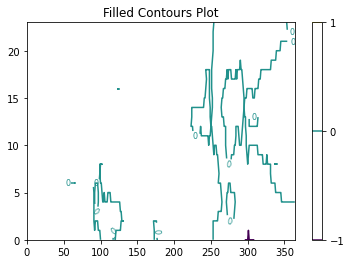

In [204]:
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval_polarity\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15.h5"
#file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval_polarity\\conf_int_polarity_matrix_norm_tec_f10_7_location_52_5_15\\conf_int_polarity_matrix_norm_tec_f10_7_location_52_5_15.h5"

df = readH5File(file)
df = df[pd.to_datetime(df.index.get_level_values('date')).year == 2003]

print(df[df>0])
df= df.T
# xlist = np.linspace(-3.0, 3.0, 100)
# ylist = np.linspace(-3.0, 3.0, 100)
# X, Y = np.meshgrid(xlist, ylist)
# Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contour(df, levels=1)
plt.clabel(cp, inline=True, fontsize=8)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
# ax.set_ylabel('y (cm)')
plt.show()

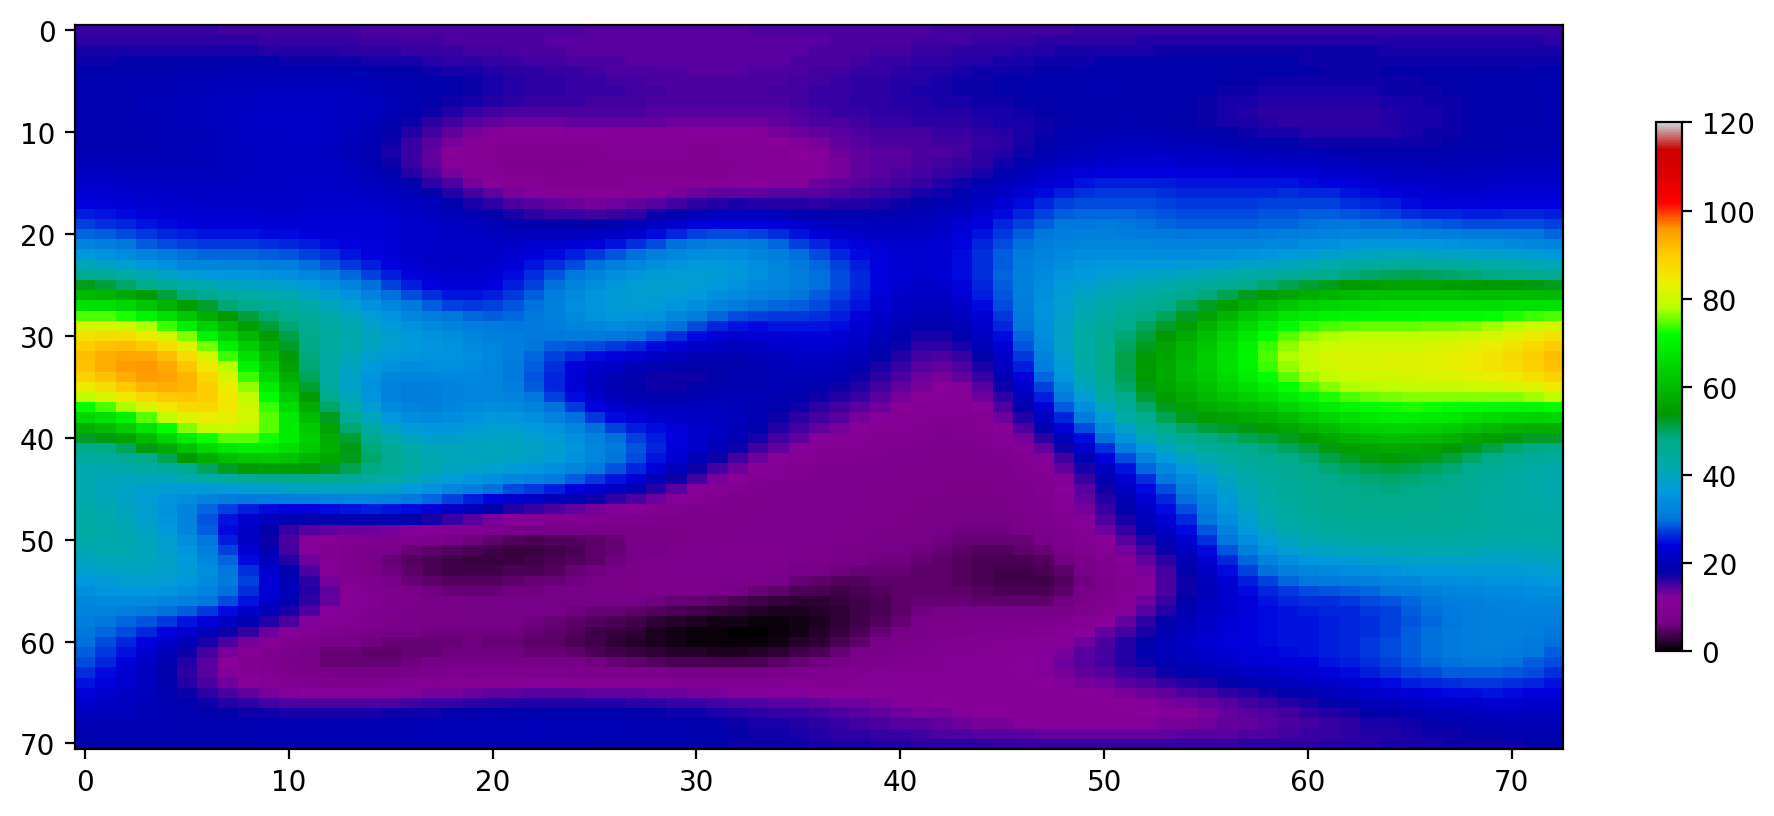

In [306]:
# file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec\\2000.h5"

file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\2000.h5"

bounds = np.linspace(0,100,5)

df = readH5File(file)
# print(df)
df = df[pd.to_datetime(df.index.get_level_values('date')) == '2000-07-15']
df = df[pd.to_datetime(df.index.get_level_values('ut'), format='%H:%M:%S').hour == 3].stack().T
# print(df)
df = df.sort_index(axis=0, ascending=False)
df = df.sort_index(axis=1, ascending=True)
# plt.gcf().set_size_inches(10, 6)
# fig = plt.figure(figsize=(12, 3))
fig = plt.figure(figsize=(12, 7), dpi=200)
graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
cb = plt.colorbar(graph, shrink = 0.5)
plt.show()
# print(df)





# tec = pd.DataFrame()
# for year in analysisPeriod:
#     fileName = file+ "\\" + str(year) + '.h5'
#     df = readH5File(fileName)
#     print(df)
#     break
#     tec = pd.concat([tec, df])
# print(tec)


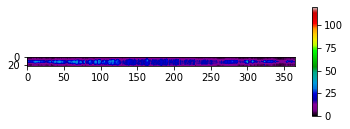

In [74]:
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\2003.h5"
df = readH5File(file)
df = df[(52.5, 15)]
df = df.interpolate()
# print(df)
df = df.unstack().T
df = df.sort_index(axis=0, ascending=True)
df = df.sort_index(axis=1, ascending=True)
# # print(df)
fig.set_size_inches(10,10, forward = False) 
graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
cb = plt.colorbar(graph, shrink = 0.5)
plt.show()


# fig = plt.figure(figsize=(10, 10))

# # fig.set_figheight(10)
# # fig.set_figwidth(5)

# # Adds subplot on position 1
# ax = fig.add_subplot()
# # Adds subplot on position 2

# a = ax.imshow(df, cmap= 'viridis', vmin = 0, vmax=35)
# cb = plt.colorbar(a)
# plt.show()

Index(['tecCOD', 'tecCOR', 'tecESA', 'tecESR', 'tecIGR', 'tecIGS', 'tecJPL',
       'tecJPR', 'tecUPC', 'tecUPR'],
      dtype='object')


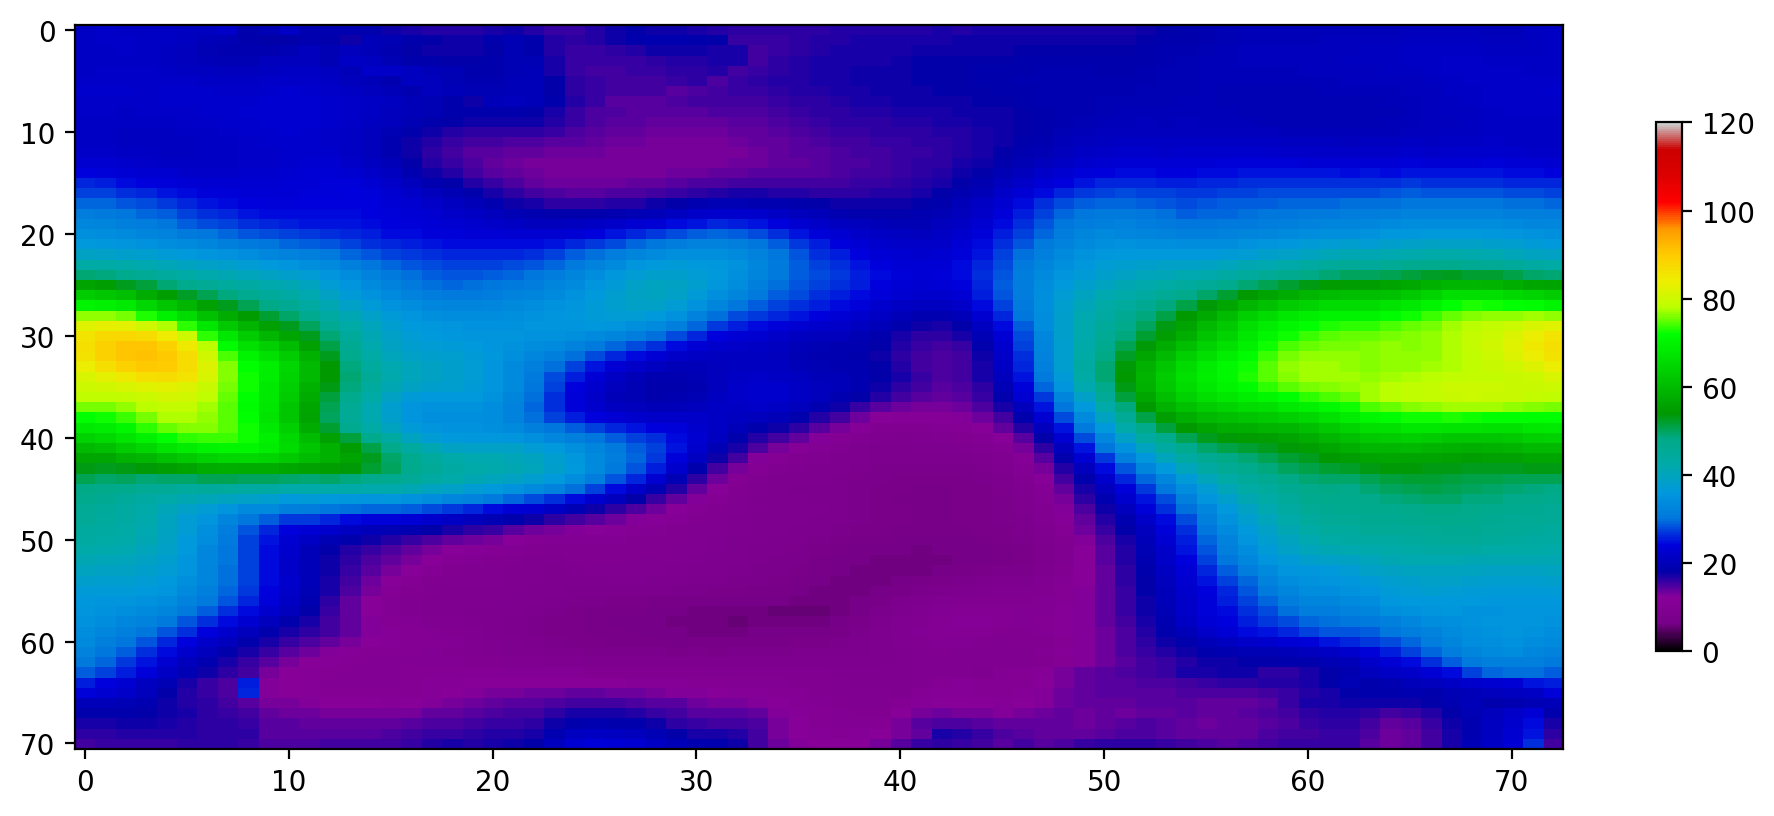

In [309]:
file20000715 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\load_data\\tec_2hr\\gps_tec2hr_igs_20000715_v01.h5"
bounds = np.linspace(0,100,5)

df = readH5File(file20000715)
print(df.columns)
df = df[pd.to_datetime(df.index.get_level_values('Epoch')) == '2000-07-15 03:00:00']['tecIGS']
df = df.unstack()
df = df.sort_index(axis=0, ascending=False)
df = df.sort_index(axis=1, ascending=True)
# print(df)
fig = plt.figure(figsize=(12, 7), dpi=200)
graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
cb = plt.colorbar(graph, shrink = 0.5)
plt.show()

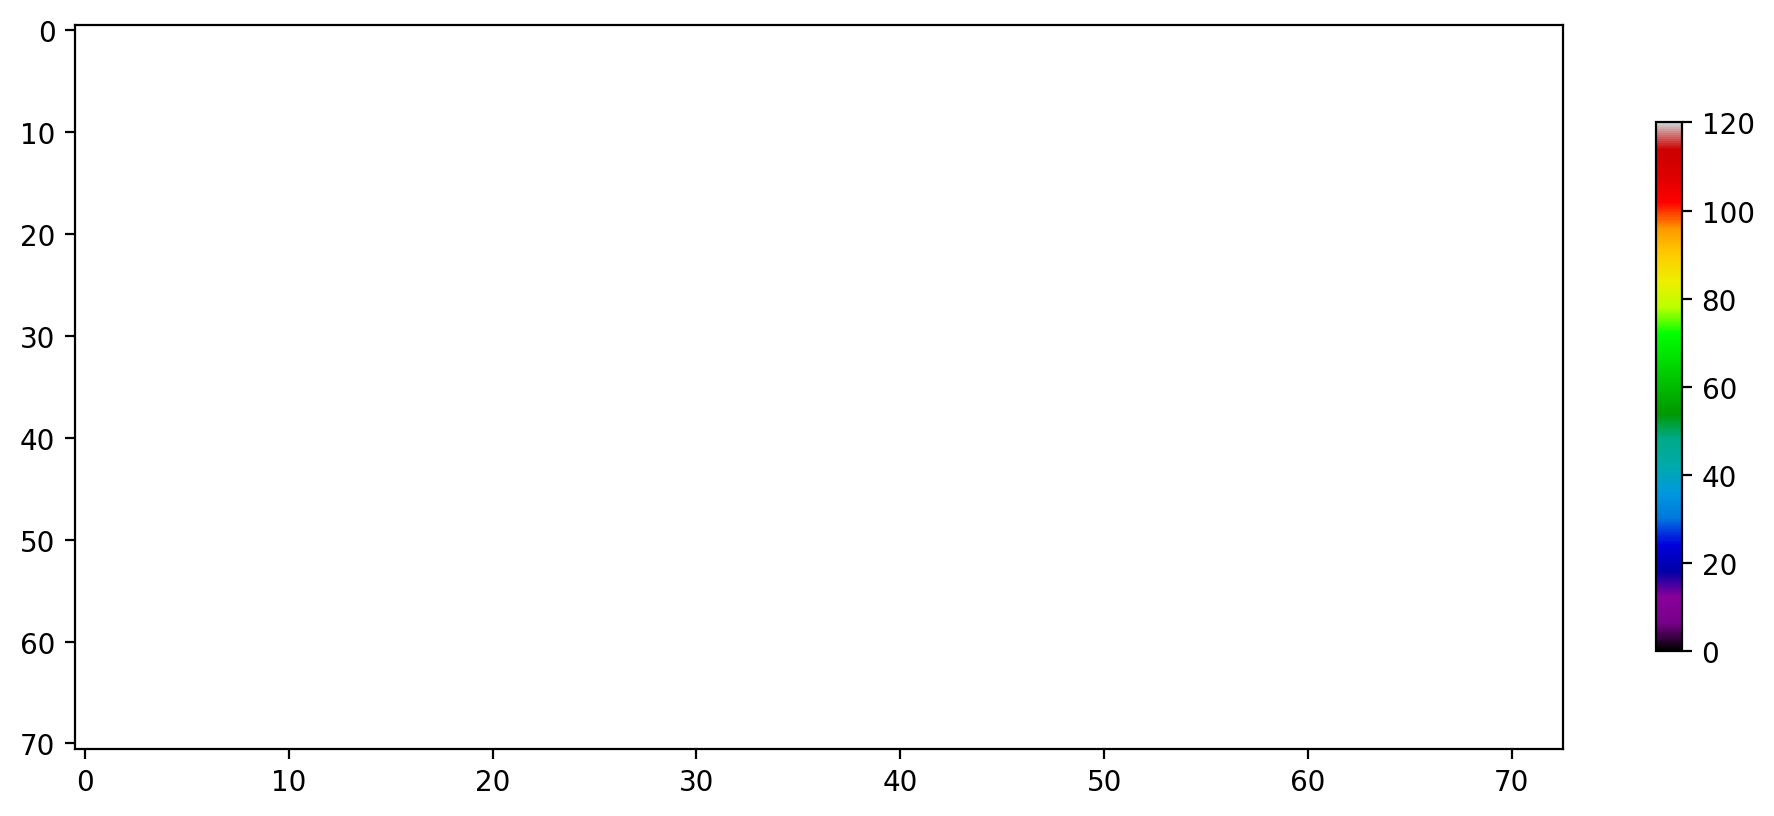

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

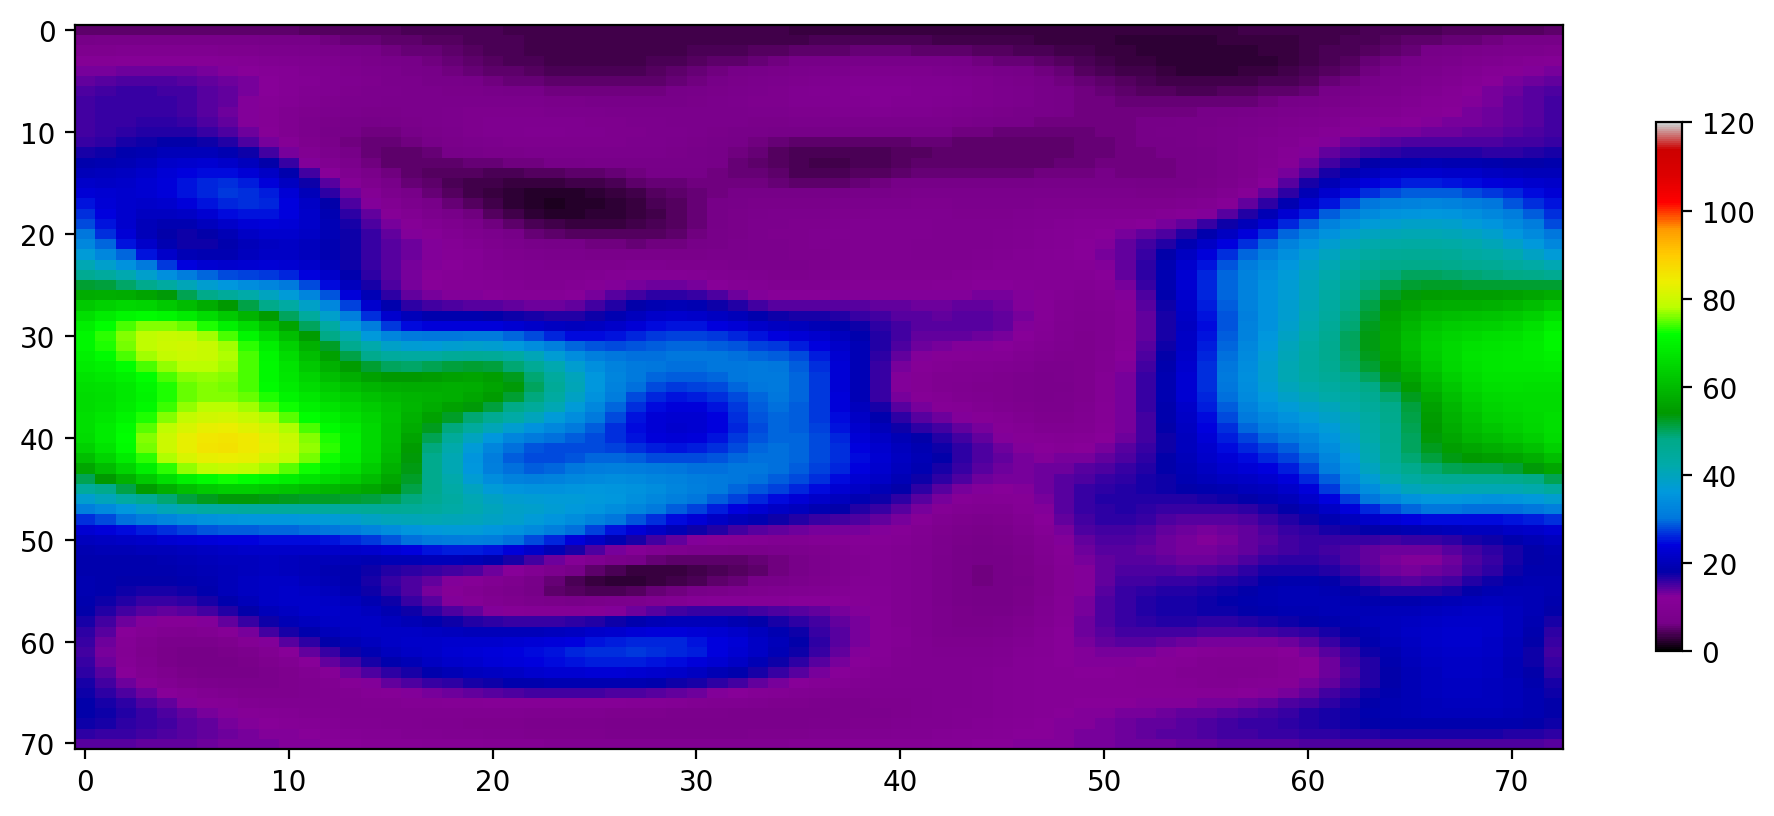

lon         -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...  \
lat                                                                     ...   
 87.5   4.700000   4.8   4.8   4.9   4.9   4.9   4.9   4.8   4.8   4.8  ...   
 85.0   6.500000   6.7   6.8   6.9   6.9   6.9   6.8   6.7   6.6   6.5  ...   
 82.5   8.700000   8.9   9.1   9.2   9.3   9.2   9.1   8.9   8.7   8.4  ...   
 80.0  10.800000  11.2  11.4  11.5  11.6  11.5  11.3  11.0  10.6  10.1  ...   
 77.5  12.700000  13.1  13.4  13.5  13.4  13.3  12.9  12.5  12.0  11.4  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
-77.5  18.200001  17.1  16.0  14.8  13.6  12.6  11.6  10.8  10.2   9.8  ...   
-80.0  18.100000  17.4  16.5  15.6  14.7  13.8  13.0  12.3  11.6  11.0  ...   
-82.5  17.500000  17.0  16.4  15.7  15.1  14.4  13.8  13.1  12.5  12.0  ...   
-85.0  16.200001  15.9  15.5  15.1  14.7  14.3  13.9  13.4  13.0  12.6  ...   
-87.5  14.400000  14.3  14.1  13.9  13.8  13.6  13.3

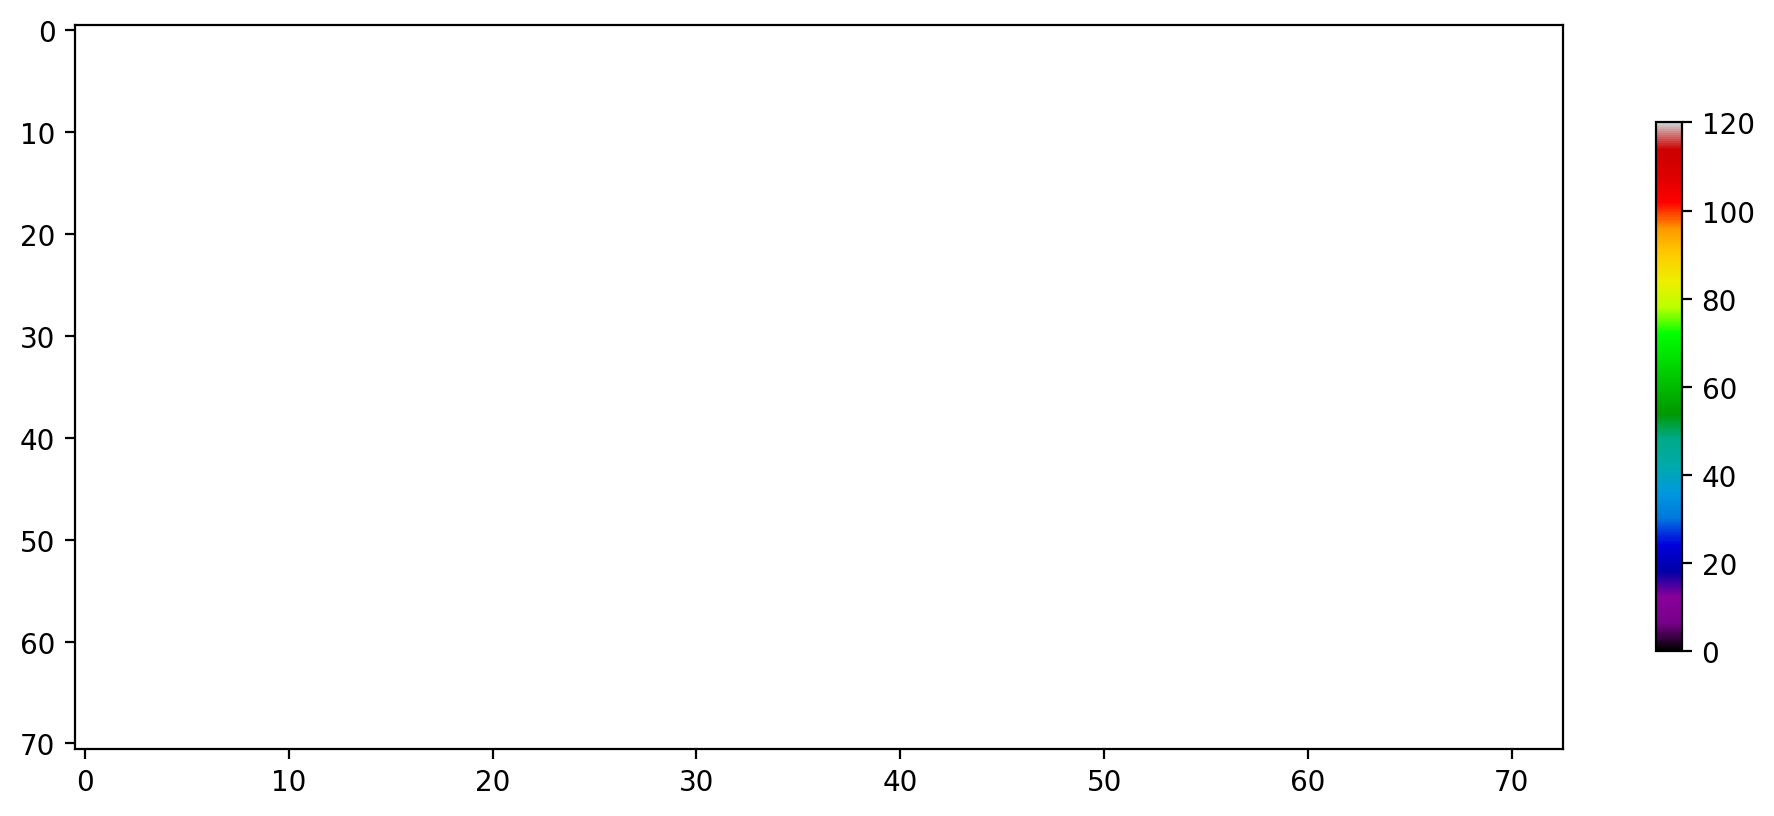

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

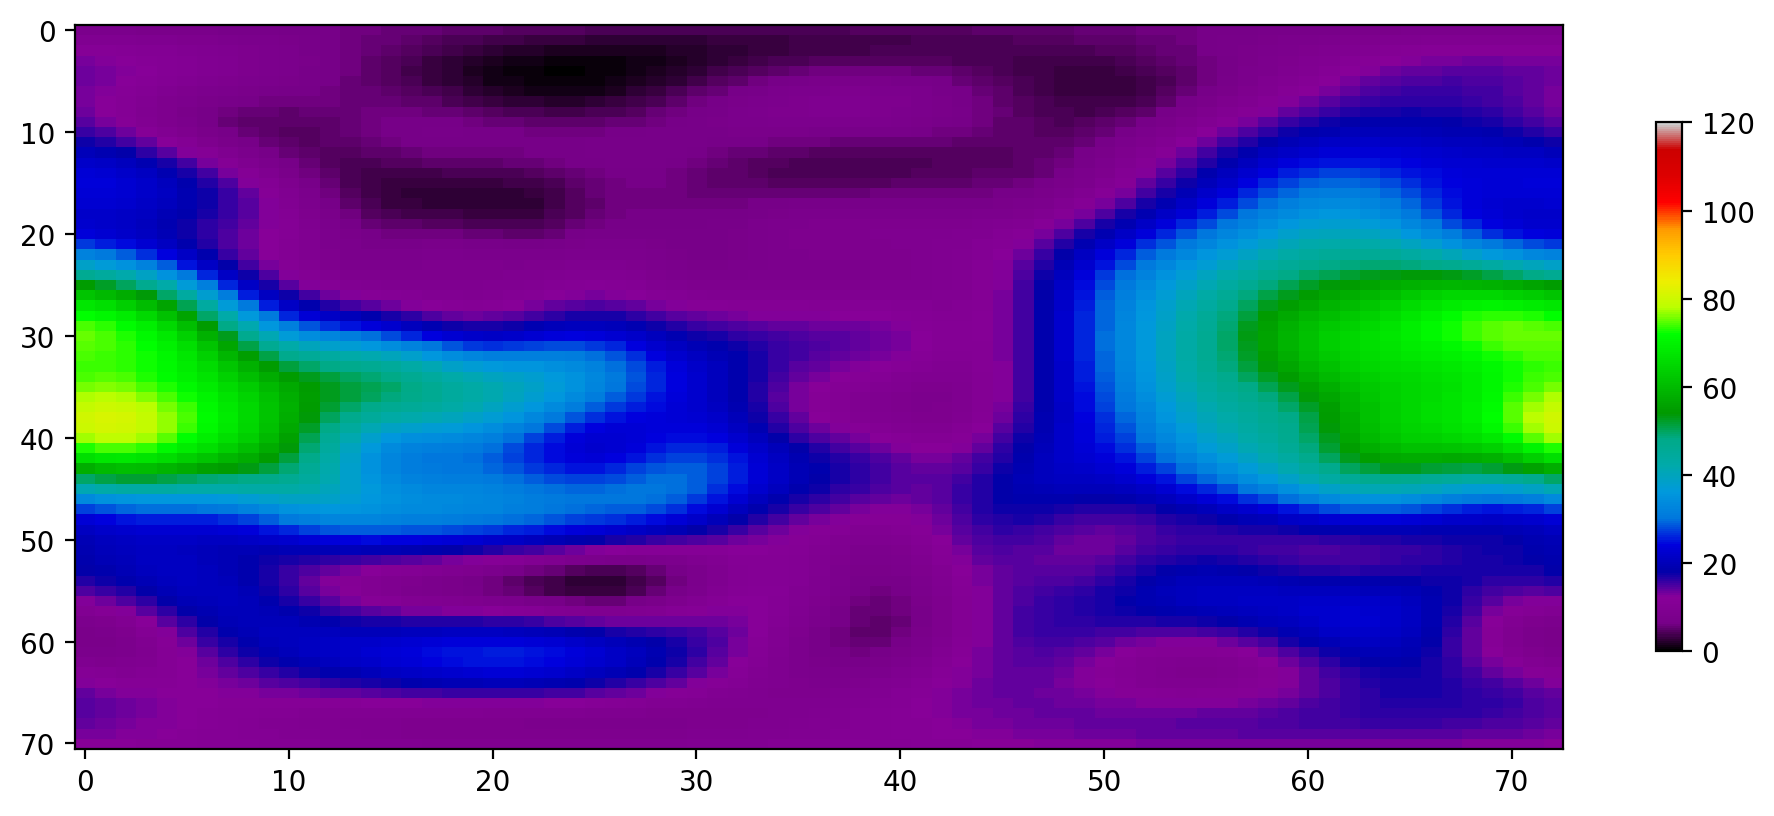

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...  \
lat                                                                ...   
 87.5   7.6   7.6   7.5   7.4   7.3   7.2   7.1   6.9   6.8   6.6  ...   
 85.0   9.7   9.6   9.4   9.2   9.0   8.8   8.5   8.2   7.8   7.5  ...   
 82.5  11.5  11.3  11.0  10.7  10.4  10.0   9.5   9.1   8.6   8.1  ...   
 80.0  12.7  12.4  12.0  11.6  11.1  10.6  10.1   9.5   8.9   8.3  ...   
 77.5  13.3  12.8  12.3  11.8  11.2  10.6  10.0   9.4   8.8   8.2  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
-77.5  14.3  13.7  13.2  12.7  12.4  12.0  11.8  11.6  11.5  11.5  ...   
-80.0  14.3  13.8  13.3  12.8  12.4  12.0  11.6  11.2  10.9  10.7  ...   
-82.5  13.9  13.5  13.0  12.6  12.2  11.8  11.4  11.0  10.6  10.3  ...   
-85.0  13.1  12.8  12.5  12.2  11.9  11.5  11.2  10.9  10.6  10.4  ...   
-87.5  12.1  12.0  11.8  11.7  11.5  11.4  11.2  11.0  10.9  10.7  ...   

lon          135        140        14

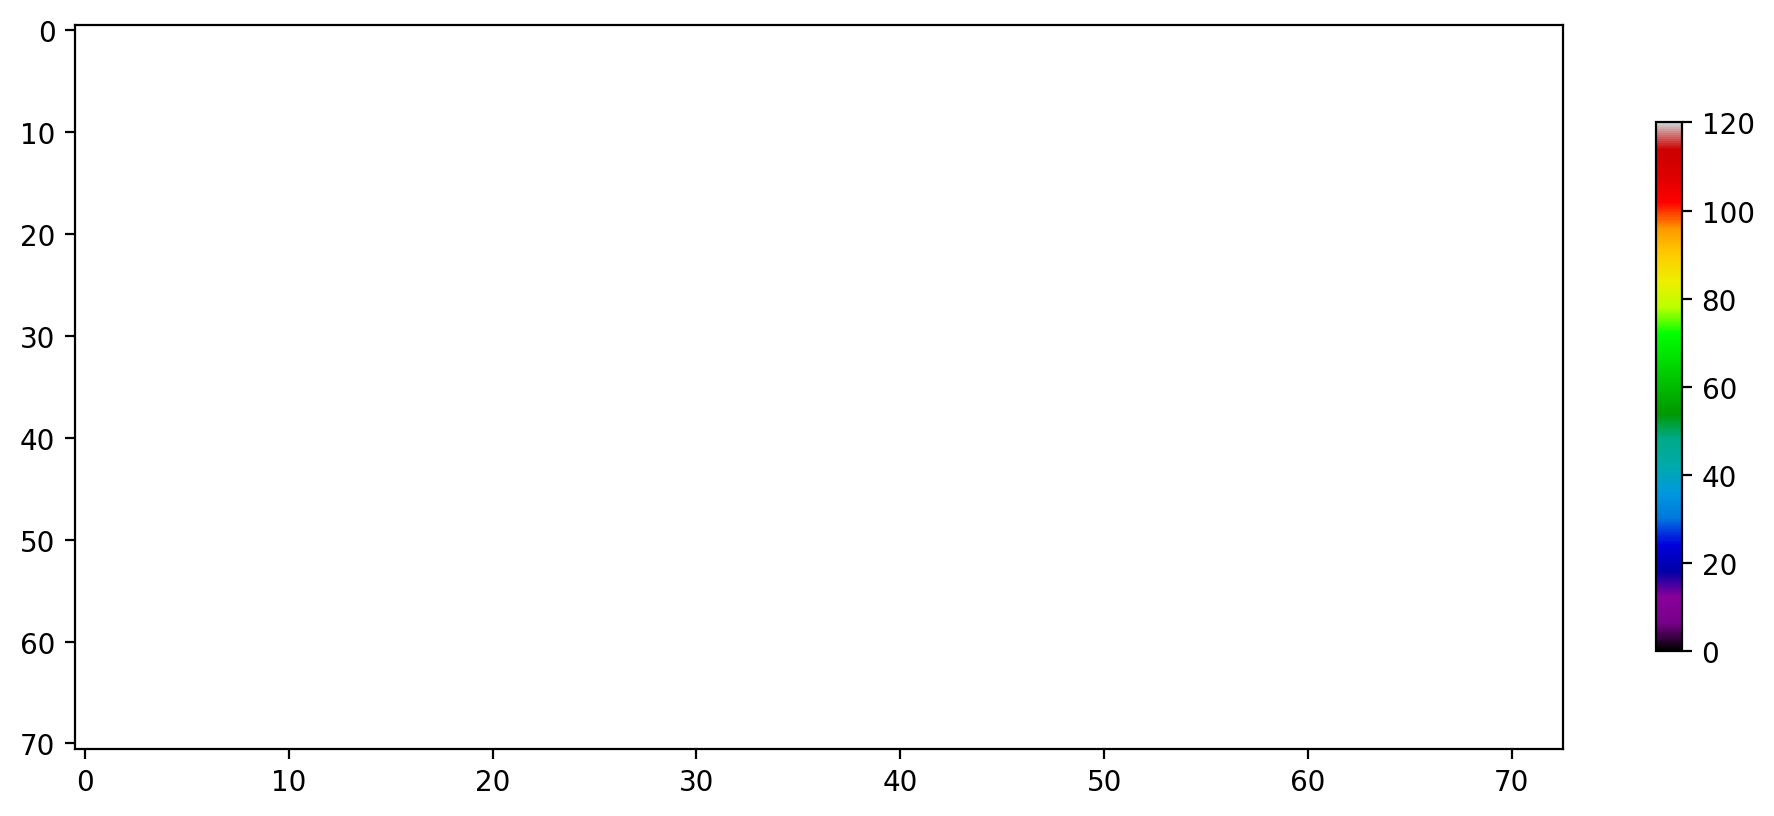

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

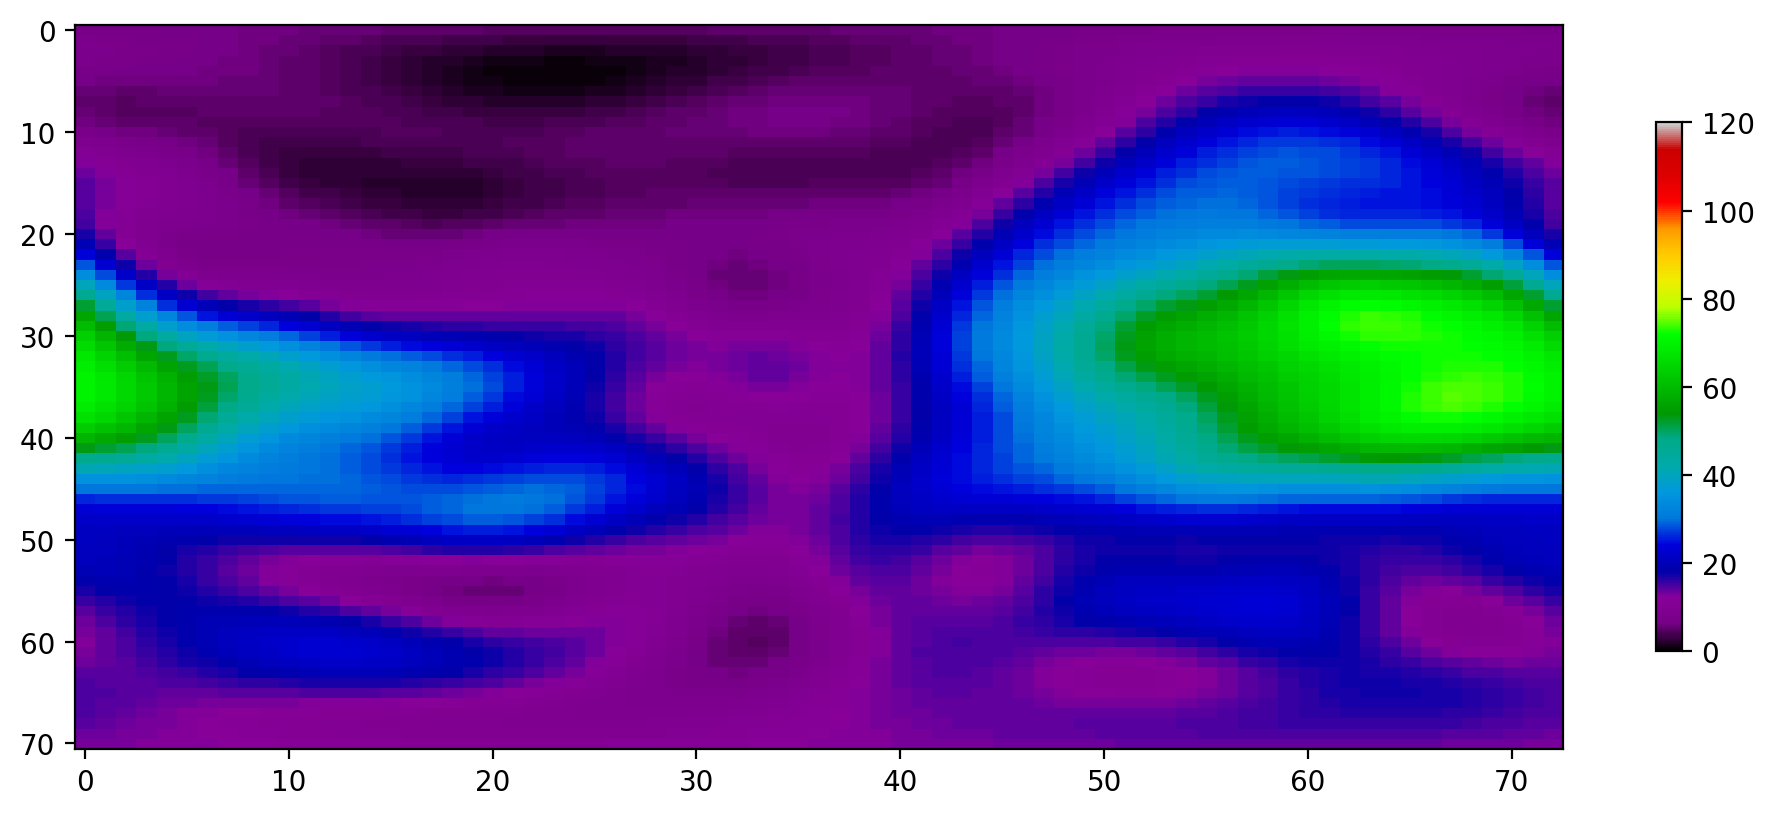

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...  \
lat                                                                ...   
 87.5   6.9   6.8   6.7   6.6   6.4   6.3   6.2   6.1   6.0   5.8  ...   
 85.0   7.5   7.3   7.2   7.0   6.8   6.6   6.3   6.1   5.9   5.7  ...   
 82.5   7.7   7.5   7.3   7.1   6.9   6.6   6.4   6.1   5.8   5.5  ...   
 80.0   7.5   7.3   7.1   6.9   6.7   6.5   6.3   6.0   5.8   5.5  ...   
 77.5   6.9   6.7   6.5   6.4   6.3   6.2   6.0   5.9   5.7   5.4  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
-77.5  14.9  14.4  14.1  13.7  13.4  13.2  13.0  12.9  12.8  12.7  ...   
-80.0  14.6  14.1  13.7  13.3  13.0  12.6  12.3  12.1  11.8  11.6  ...   
-82.5  14.1  13.7  13.4  13.0  12.7  12.3  12.0  11.7  11.5  11.2  ...   
-85.0  13.5  13.2  13.0  12.7  12.5  12.2  12.0  11.8  11.5  11.3  ...   
-87.5  12.9  12.8  12.7  12.6  12.4  12.3  12.2  12.1  11.9  11.8  ...   

lon          135        140        14

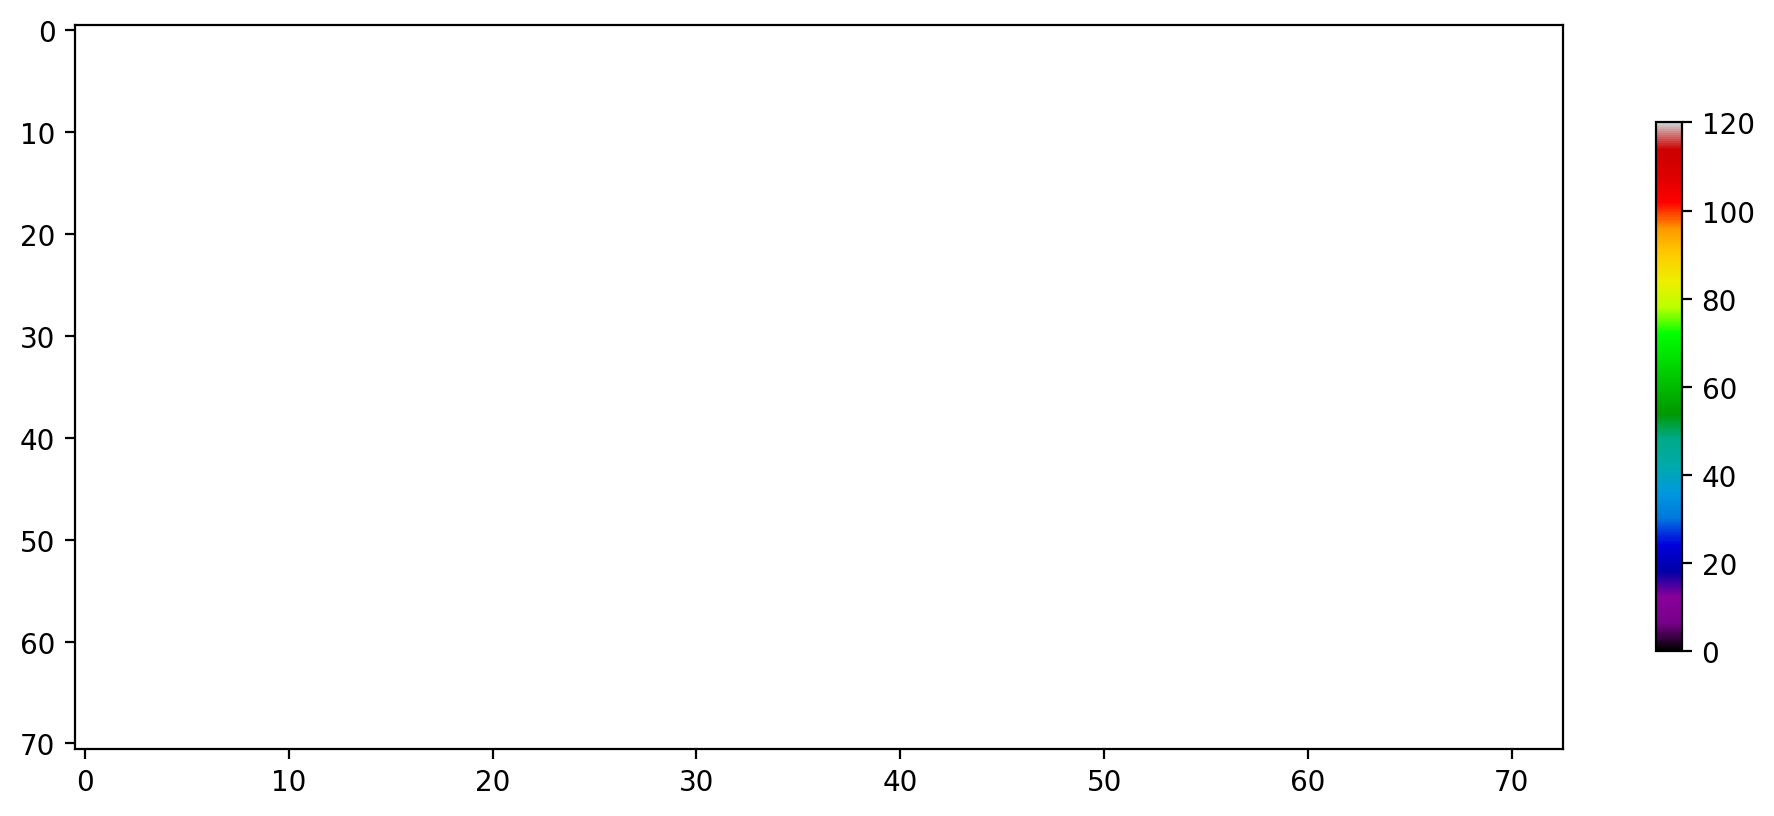

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

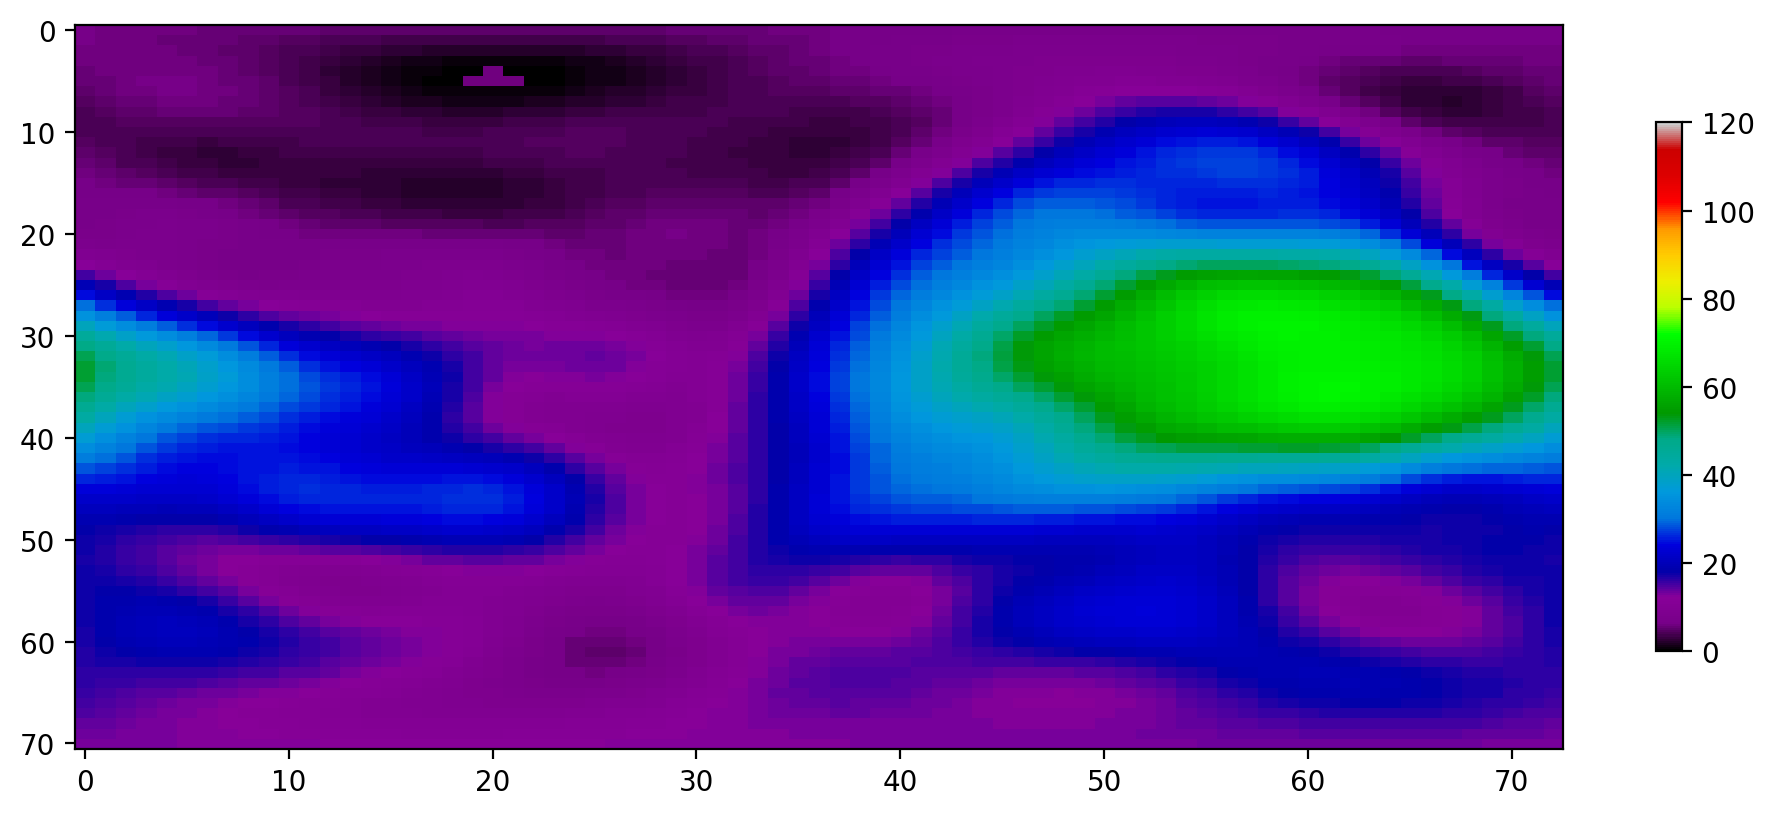

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...  \
lat                                                                ...   
 87.5   6.1   6.0   5.9   5.8   5.8   5.7   5.6   5.5   5.4   5.3  ...   
 85.0   6.1   6.0   5.9   5.8   5.6   5.5   5.3   5.2   5.0   4.8  ...   
 82.5   6.0   6.0   5.9   5.8   5.7   5.5   5.3   5.1   4.8   4.5  ...   
 80.0   5.8   5.9   5.9   5.9   5.8   5.7   5.4   5.2   4.8   4.4  ...   
 77.5   5.6   5.8   6.0   6.0   6.0   5.9   5.7   5.4   5.0   4.5  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
-77.5  15.1  14.7  14.3  13.9  13.5  13.1  12.8  12.4  12.1  11.8  ...   
-80.0  14.6  14.2  13.8  13.4  13.1  12.7  12.4  12.0  11.7  11.5  ...   
-82.5  14.0  13.7  13.4  13.1  12.8  12.5  12.3  12.0  11.8  11.5  ...   
-85.0  13.4  13.2  13.1  12.9  12.7  12.5  12.3  12.2  12.0  11.9  ...   
-87.5  13.0  12.9  12.8  12.7  12.7  12.6  12.5  12.4  12.4  12.3  ...   

lon          135        140        14

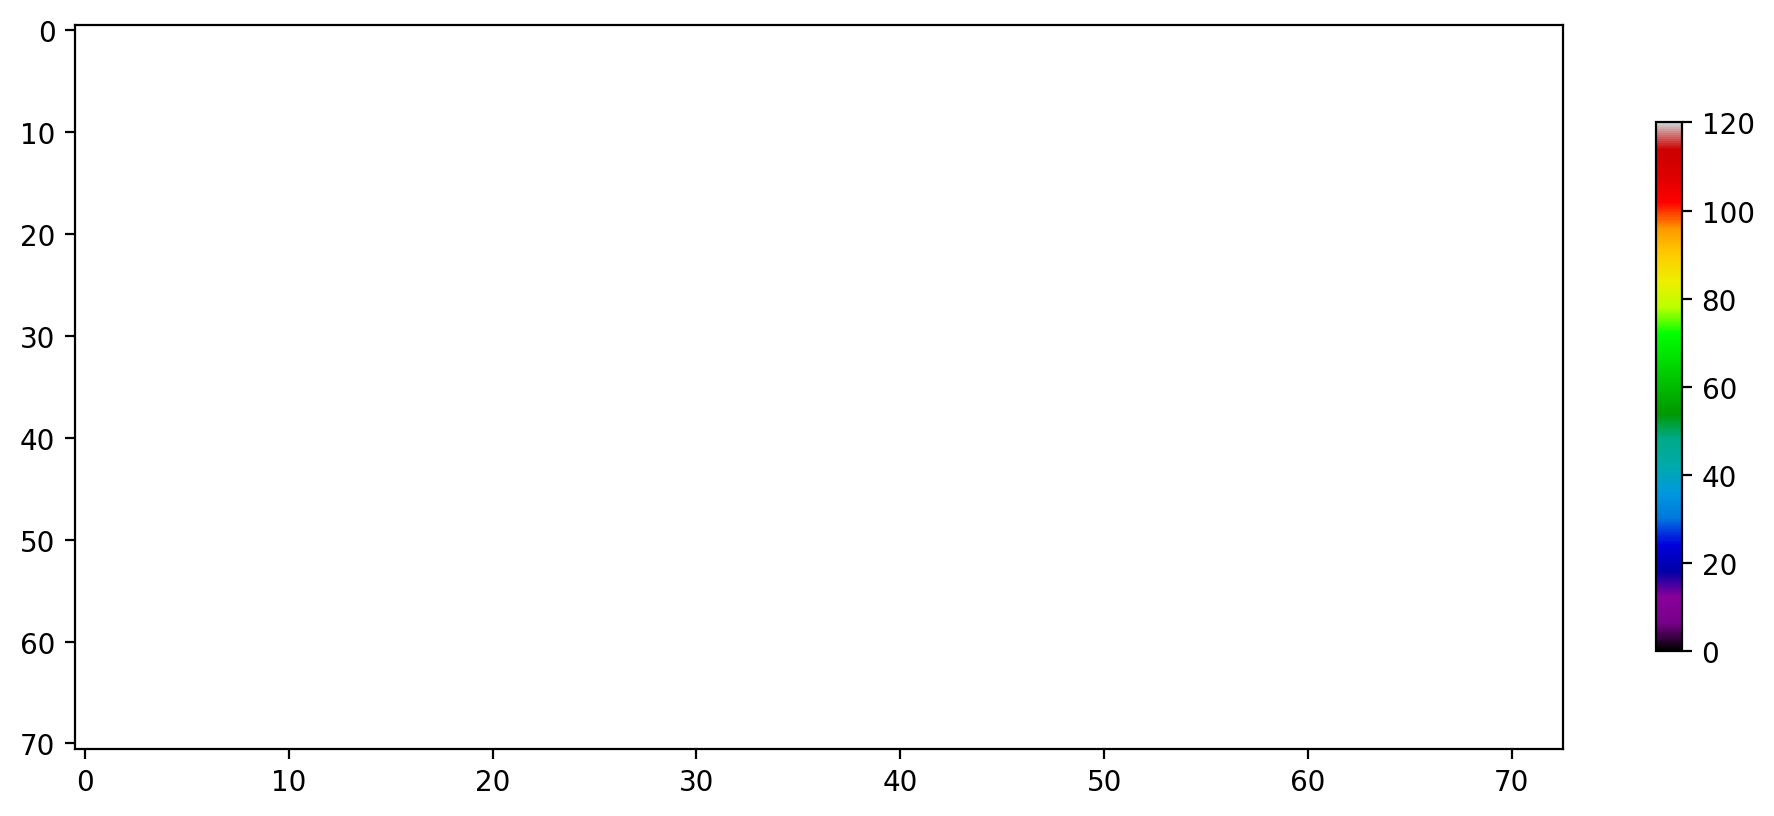

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

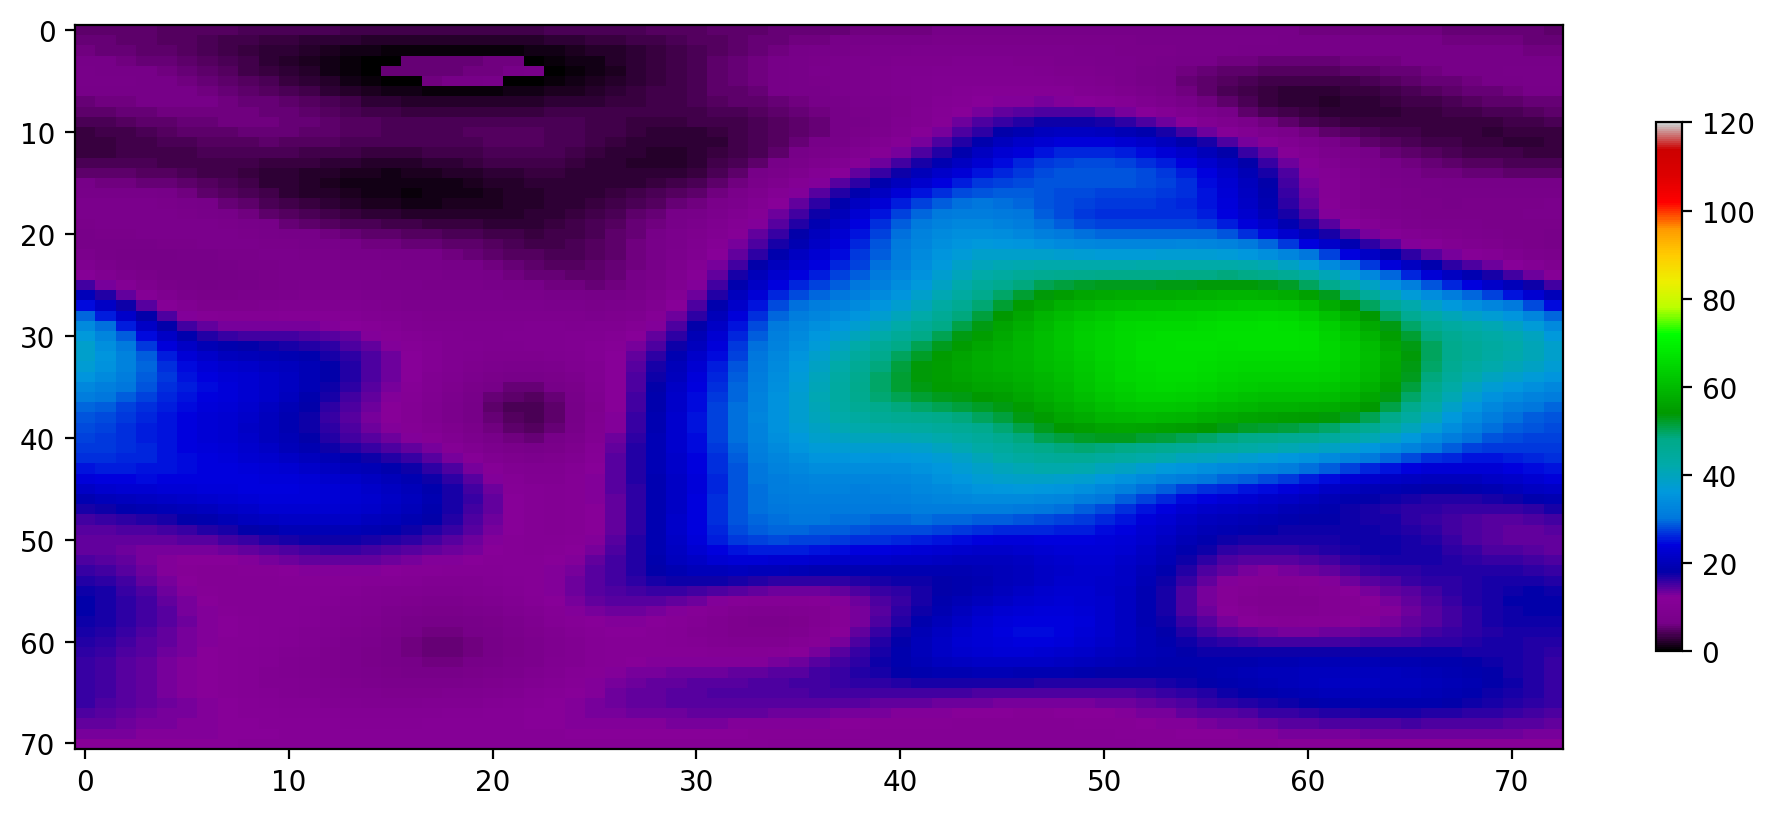

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...  \
lat                                                                ...   
 87.5   5.1   5.0   4.9   4.8   4.6   4.5   4.4   4.3   4.2   4.1  ...   
 85.0   5.4   5.2   5.0   4.7   4.5   4.3   4.0   3.7   3.5   3.2  ...   
 82.5   5.8   5.6   5.3   5.0   4.7   4.4   4.0   3.6   3.2   2.8  ...   
 80.0   6.3   6.1   5.9   5.5   5.2   4.8   4.3   3.8   3.3   2.7  ...   
 77.5   6.6   6.5   6.3   6.1   5.7   5.3   4.8   4.3   3.7   3.1  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
-77.5  15.5  14.9  14.3  13.7  13.2  12.7  12.2  11.8  11.4  11.0  ...   
-80.0  14.8  14.4  14.0  13.5  13.1  12.7  12.4  12.0  11.7  11.4  ...   
-82.5  13.9  13.7  13.4  13.1  12.9  12.6  12.4  12.1  11.9  11.7  ...   
-85.0  12.9  12.8  12.7  12.6  12.4  12.3  12.2  12.0  11.9  11.8  ...   
-87.5  12.0  12.0  12.0  11.9  11.9  11.8  11.8  11.8  11.7  11.7  ...   

lon          135        140   145    

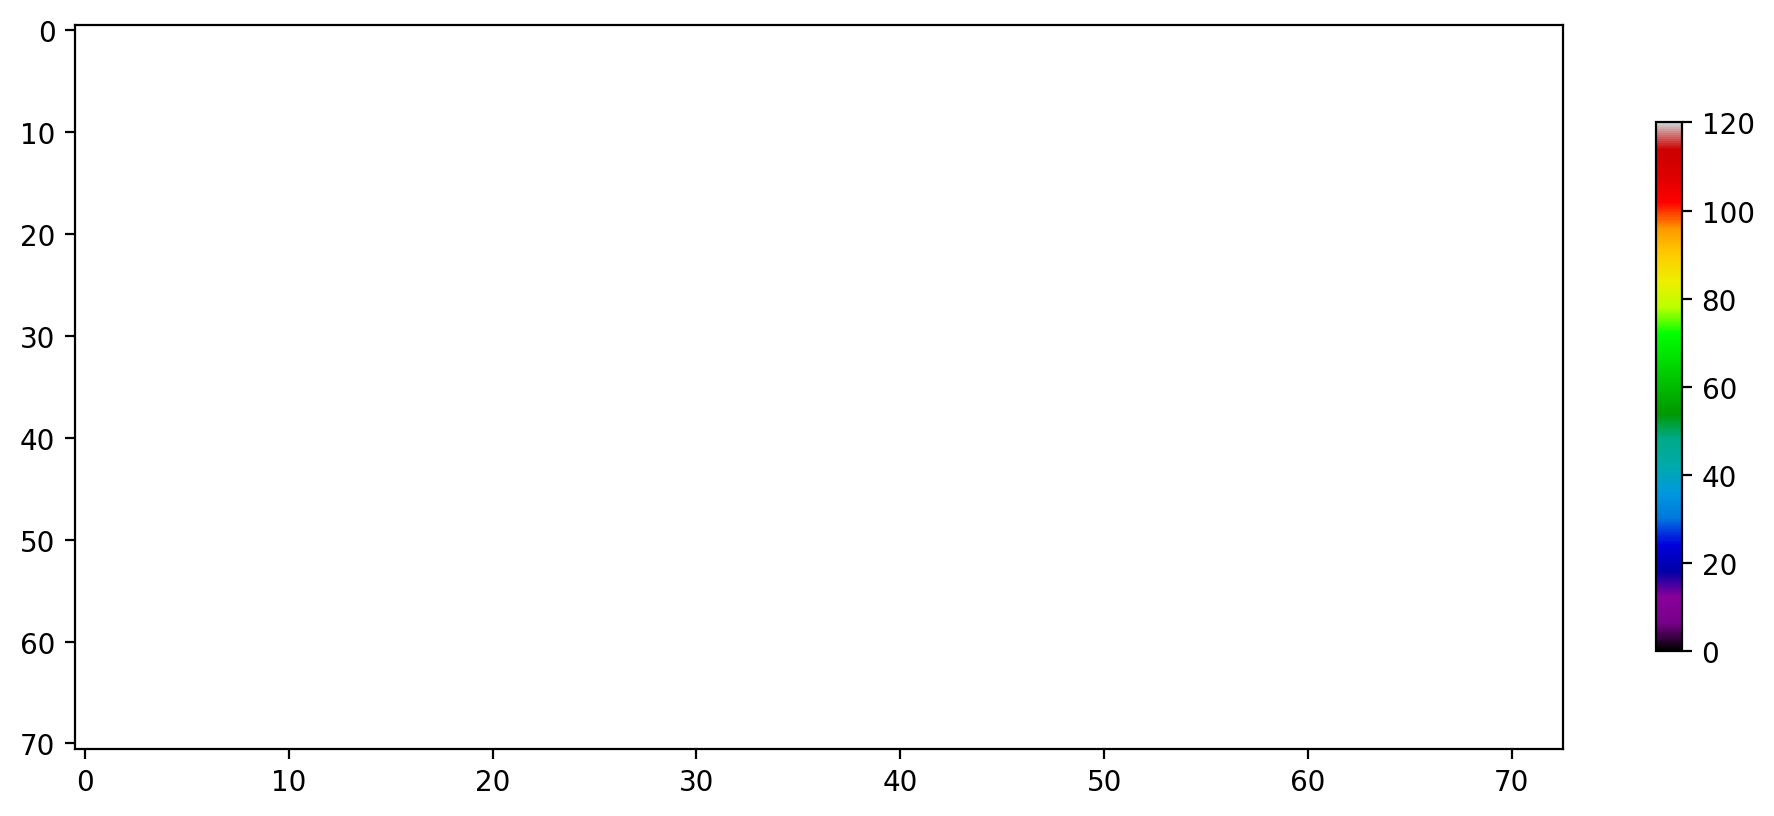

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

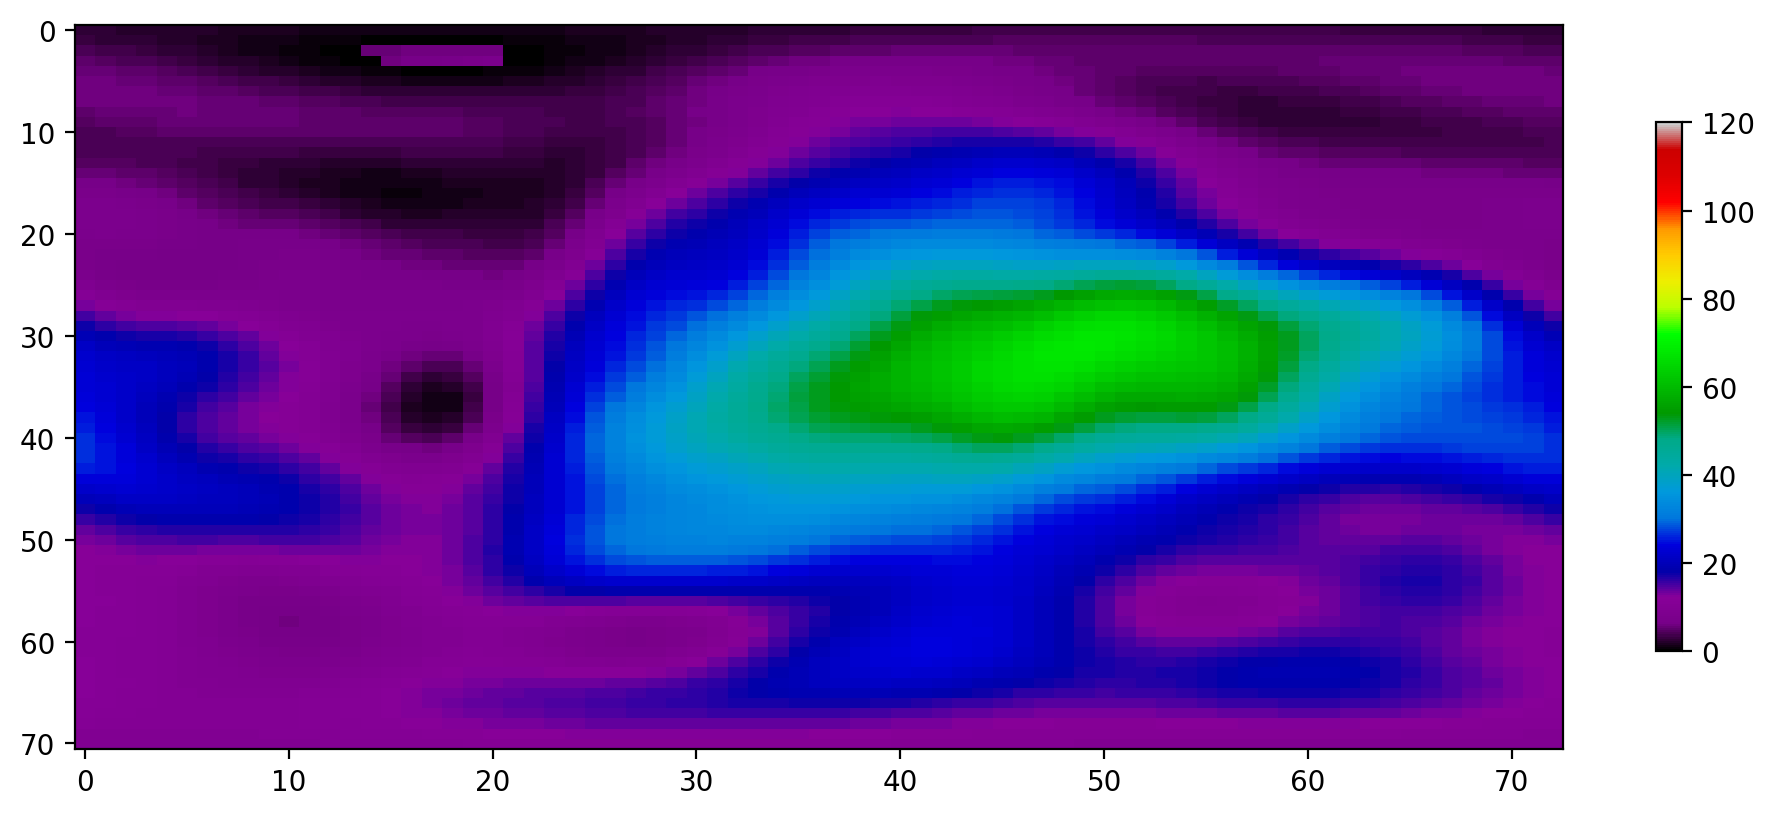

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   2.5   2.4   2.3   2.2   2.1   2.0   1.9   1.8   1.7   1.6  ...   3.2   
 85.0   3.0   2.8   2.6   2.4   2.2   2.0   1.8   1.6   1.4   1.2  ...   4.1   
 82.5   3.8   3.6   3.3   3.0   2.7   2.4   2.1   1.8   1.4   1.1  ...   4.9   
 80.0   4.7   4.5   4.2   3.8   3.5   3.1   2.7   2.3   1.9   1.6  ...   5.4   
 77.5   5.5   5.2   5.0   4.7   4.3   3.9   3.5   3.1   2.7   2.3  ...   5.4   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5  11.7  11.4  11.1  10.9  10.7  10.5  10.4  10.4  10.4  10.4  ...  15.5   
-80.0  11.3  11.1  10.9  10.7  10.6  10.5  10.4  10.4  10.5  10.6  ...  13.8   
-82.5  10.8  10.6  10.5  10.4  10.4  10.4  10.4  10.4  10.4  10.5  ...  12.1   
-85.0  10.3  10.2  10.2  10.2  10.2  10.2  10.2  10.3  10.3  10.4  ...  10.8   
-87.5  10.1  10.1  10.1  10.1  10.1  10.

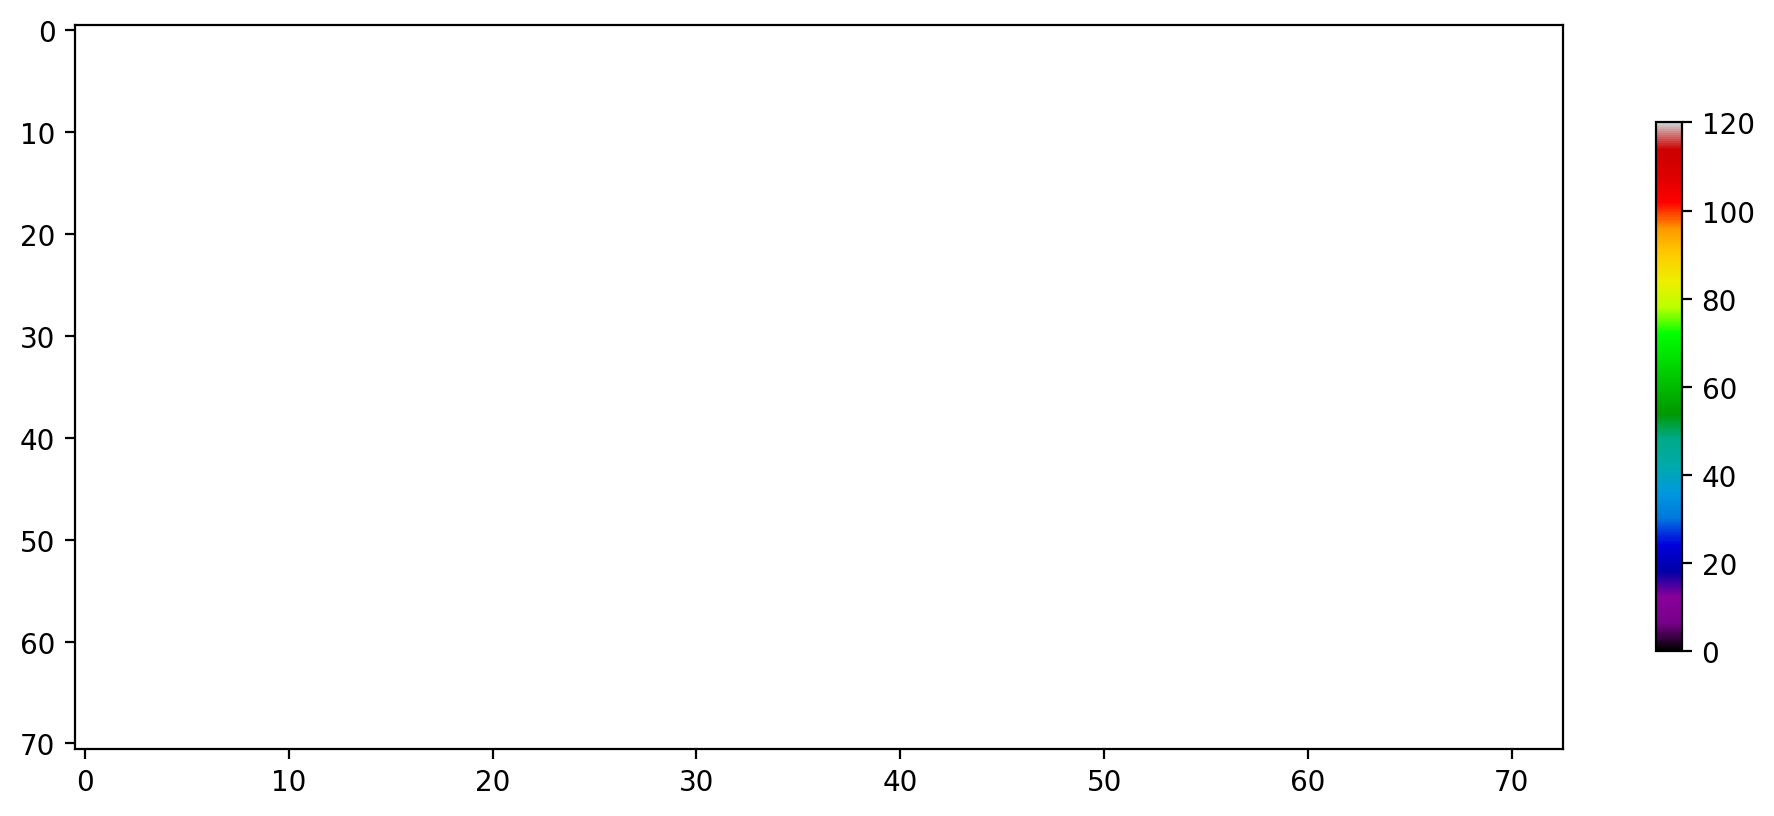

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

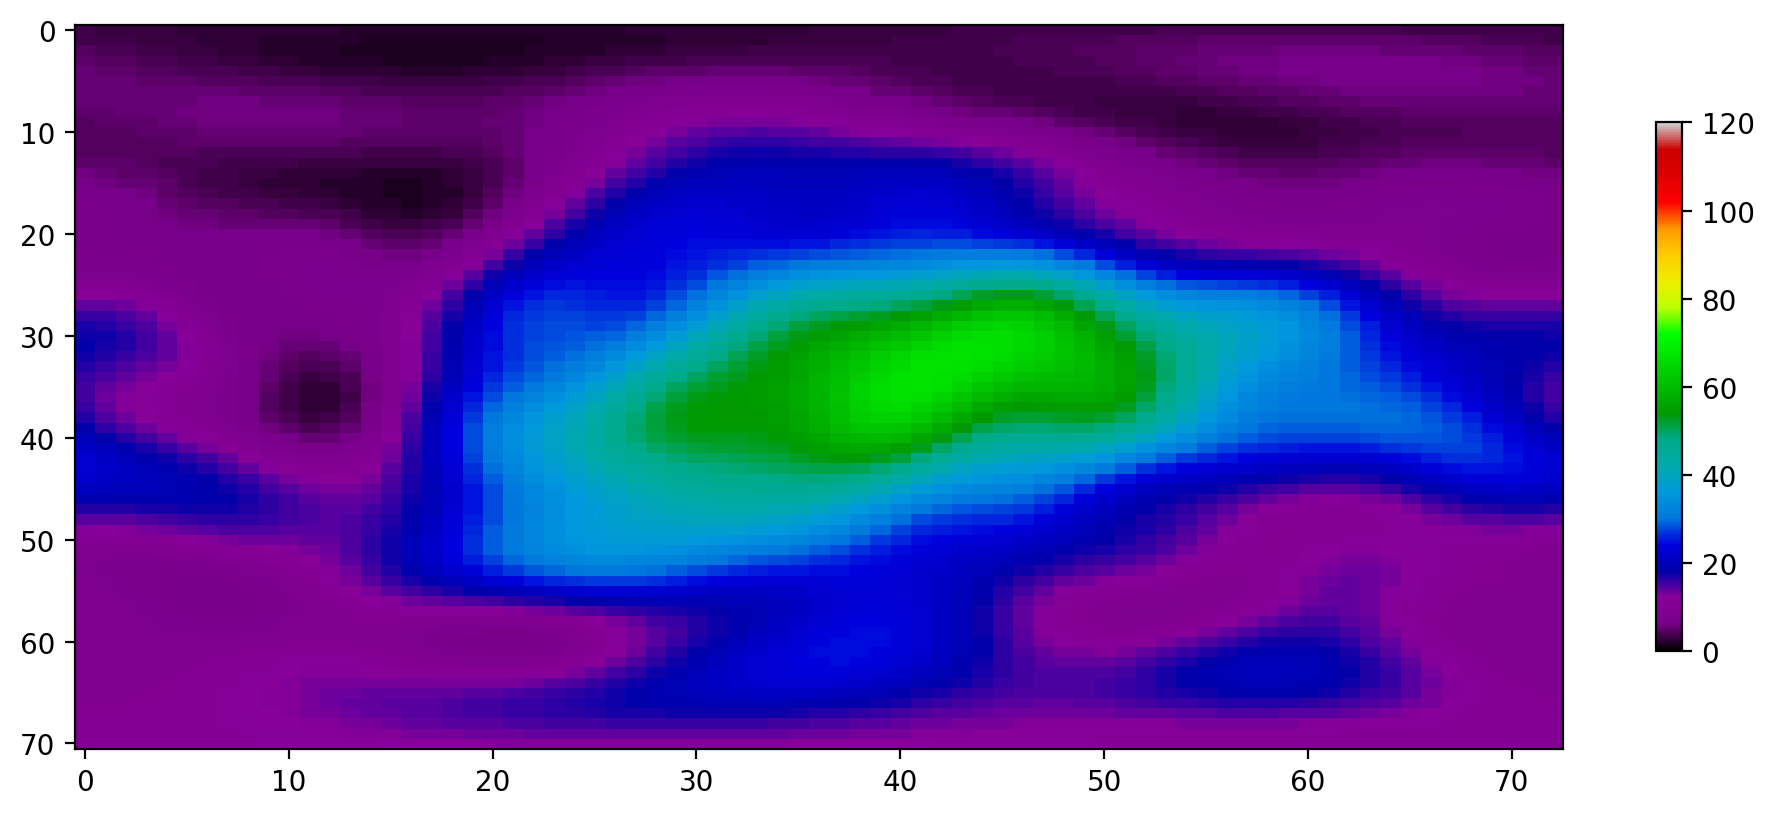

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   3.3   3.2   3.1   3.0   2.9   2.8   2.8   2.7   2.6   2.5  ...   3.8   
 85.0   3.7   3.6   3.4   3.2   3.1   2.9   2.7   2.6   2.4   2.3  ...   4.8   
 82.5   4.3   4.1   3.9   3.6   3.4   3.2   2.9   2.7   2.5   2.3  ...   5.7   
 80.0   4.9   4.6   4.4   4.1   3.9   3.6   3.4   3.1   2.9   2.7  ...   6.3   
 77.5   5.3   5.1   4.9   4.6   4.4   4.2   4.0   3.8   3.5   3.3  ...   6.6   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5  10.1  10.0  10.1  10.2  10.4  10.7  11.1  11.4  11.8  12.2  ...  14.7   
-80.0  10.3  10.3  10.3  10.4  10.6  10.8  11.1  11.4  11.7  12.1  ...  13.3   
-82.5  10.4  10.4  10.5  10.6  10.7  10.8  11.0  11.3  11.5  11.8  ...  12.0   
-85.0  10.6  10.6  10.6  10.7  10.8  10.9  11.0  11.2  11.3  11.5  ...  11.1   
-87.5  10.8  10.8  10.9  10.9  11.0  11.

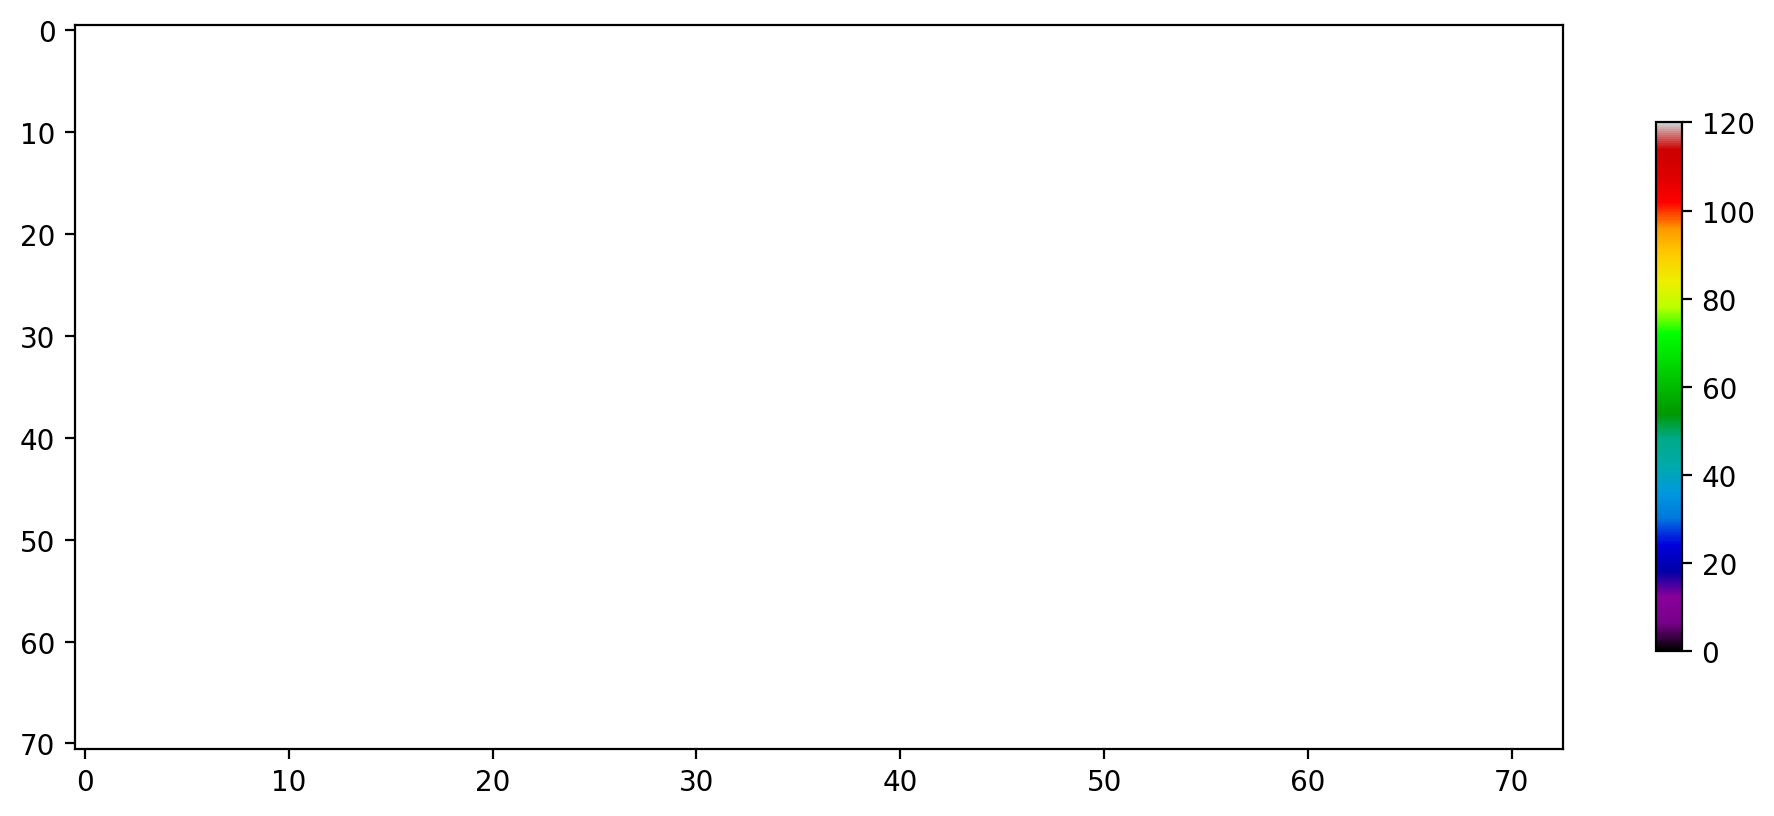

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

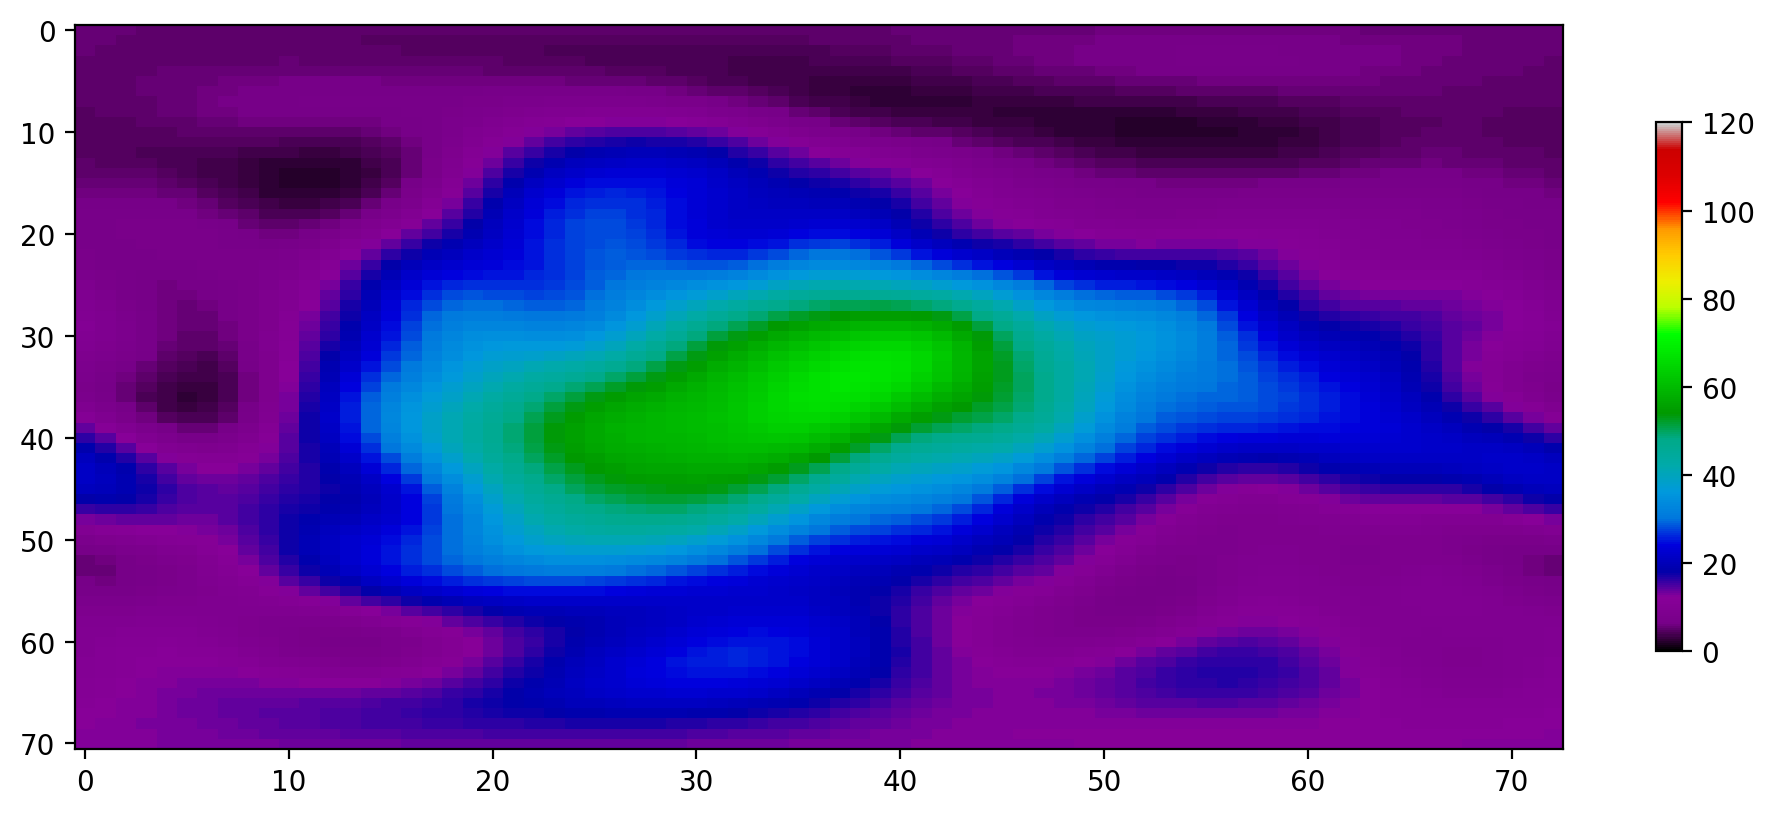

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   5.3   5.2   5.2   5.1   5.1   5.1   5.0   5.0   5.0   4.9  ...   5.6   
 85.0   5.3   5.2   5.1   5.1   5.0   5.0   4.9   4.9   4.9   4.8  ...   6.0   
 82.5   5.2   5.1   5.1   5.0   5.0   5.0   4.9   4.9   4.9   4.9  ...   6.2   
 80.0   5.1   5.1   5.1   5.1   5.1   5.1   5.1   5.1   5.1   5.1  ...   6.2   
 77.5   5.1   5.1   5.1   5.1   5.2   5.3   5.3   5.4   5.5   5.5  ...   6.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5  11.5  11.9  12.2  12.6  12.9  13.2  13.4  13.6  13.8  13.9  ...  12.1   
-80.0  11.8  12.1  12.4  12.6  12.9  13.2  13.4  13.7  13.9  14.1  ...  12.0   
-82.5  12.1  12.3  12.5  12.7  12.9  13.1  13.3  13.5  13.7  13.9  ...  11.9   
-85.0  12.2  12.4  12.5  12.6  12.8  12.9  13.1  13.3  13.4  13.6  ...  11.8   
-87.5  12.4  12.5  12.5  12.6  12.7  12.

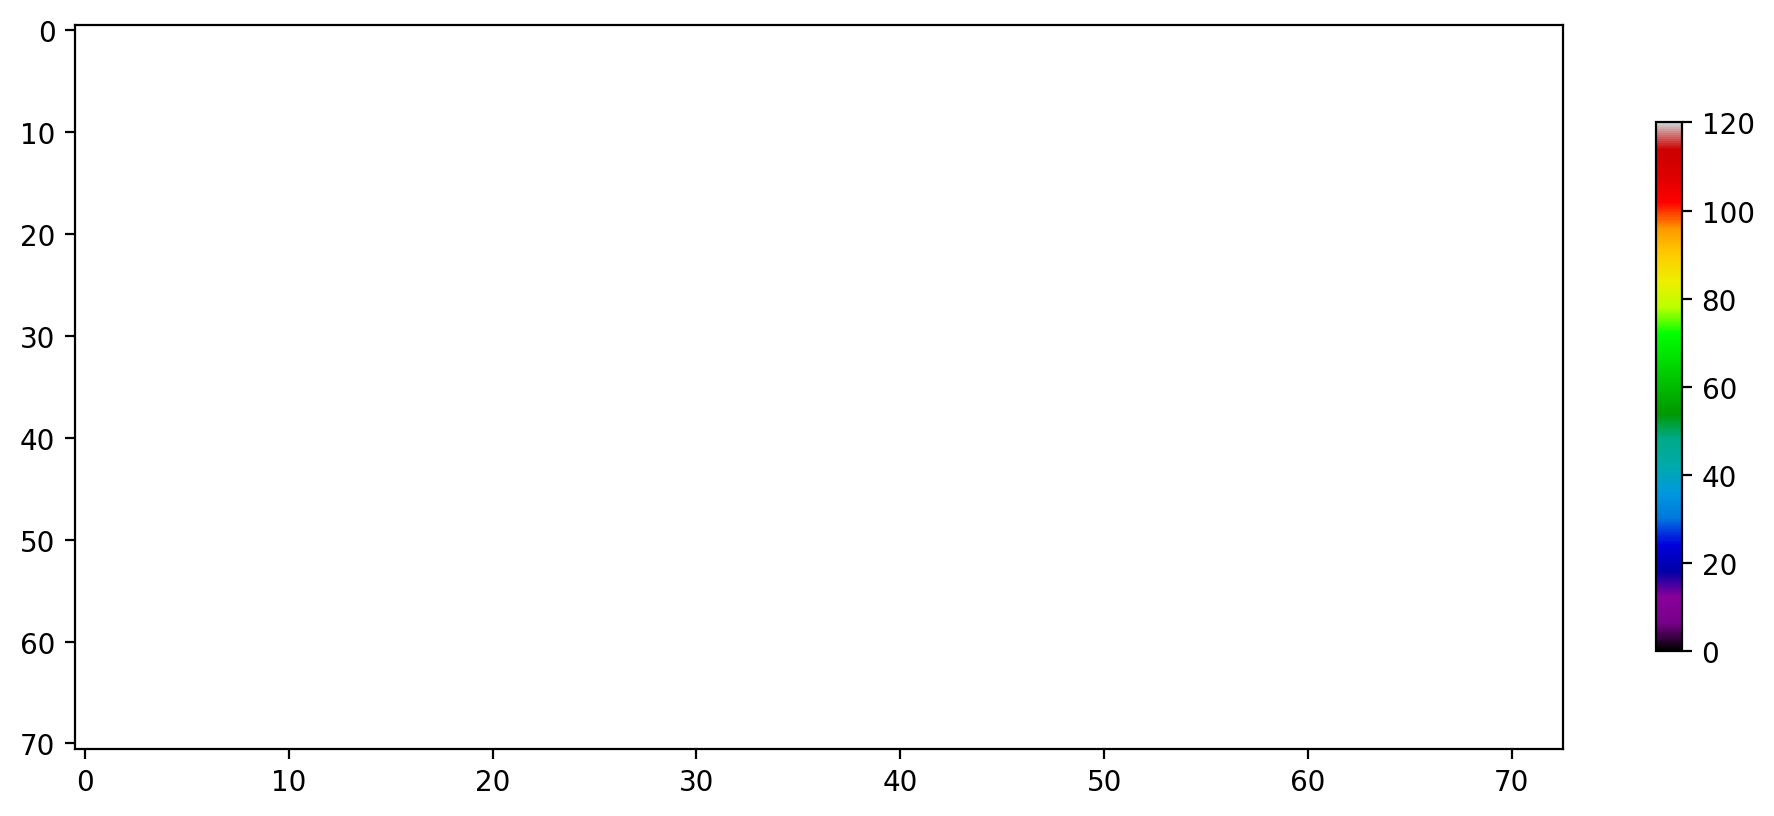

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

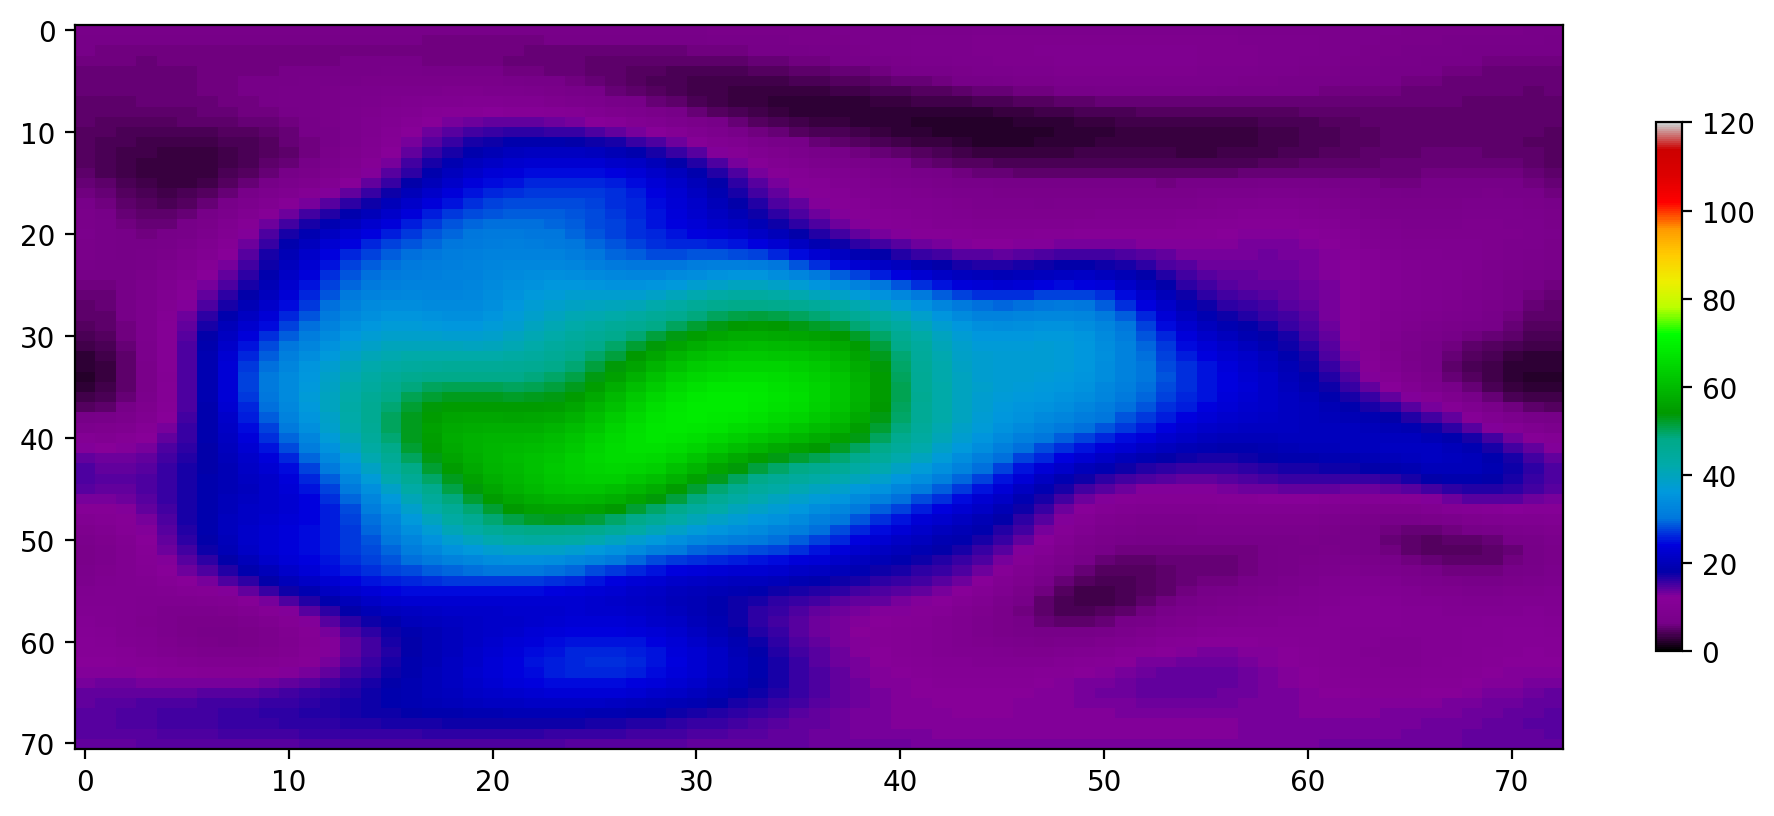

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   7.0   6.9   6.9   6.8   6.8   6.7   6.7   6.7   6.6   6.6  ...   7.5   
 85.0   6.5   6.4   6.4   6.3   6.3   6.2   6.2   6.2   6.1   6.1  ...   7.6   
 82.5   6.1   6.0   6.0   5.9   5.9   5.9   5.9   5.9   5.9   5.9  ...   7.4   
 80.0   5.7   5.7   5.7   5.6   5.7   5.7   5.7   5.8   5.8   5.9  ...   7.1   
 77.5   5.5   5.4   5.5   5.5   5.6   5.6   5.7   5.8   5.9   6.0  ...   6.7   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5  14.0  14.2  14.4  14.6  14.7  14.8  15.0  15.2  15.4  15.6  ...  12.2   
-80.0  14.2  14.4  14.6  14.8  15.0  15.2  15.4  15.6  15.8  16.0  ...  12.6   
-82.5  14.2  14.4  14.6  14.8  15.0  15.2  15.3  15.5  15.7  15.9  ...  12.9   
-85.0  14.1  14.2  14.4  14.5  14.7  14.8  14.9  15.0  15.2  15.3  ...  13.1   
-87.5  13.9  13.9  14.0  14.1  14.2  14.

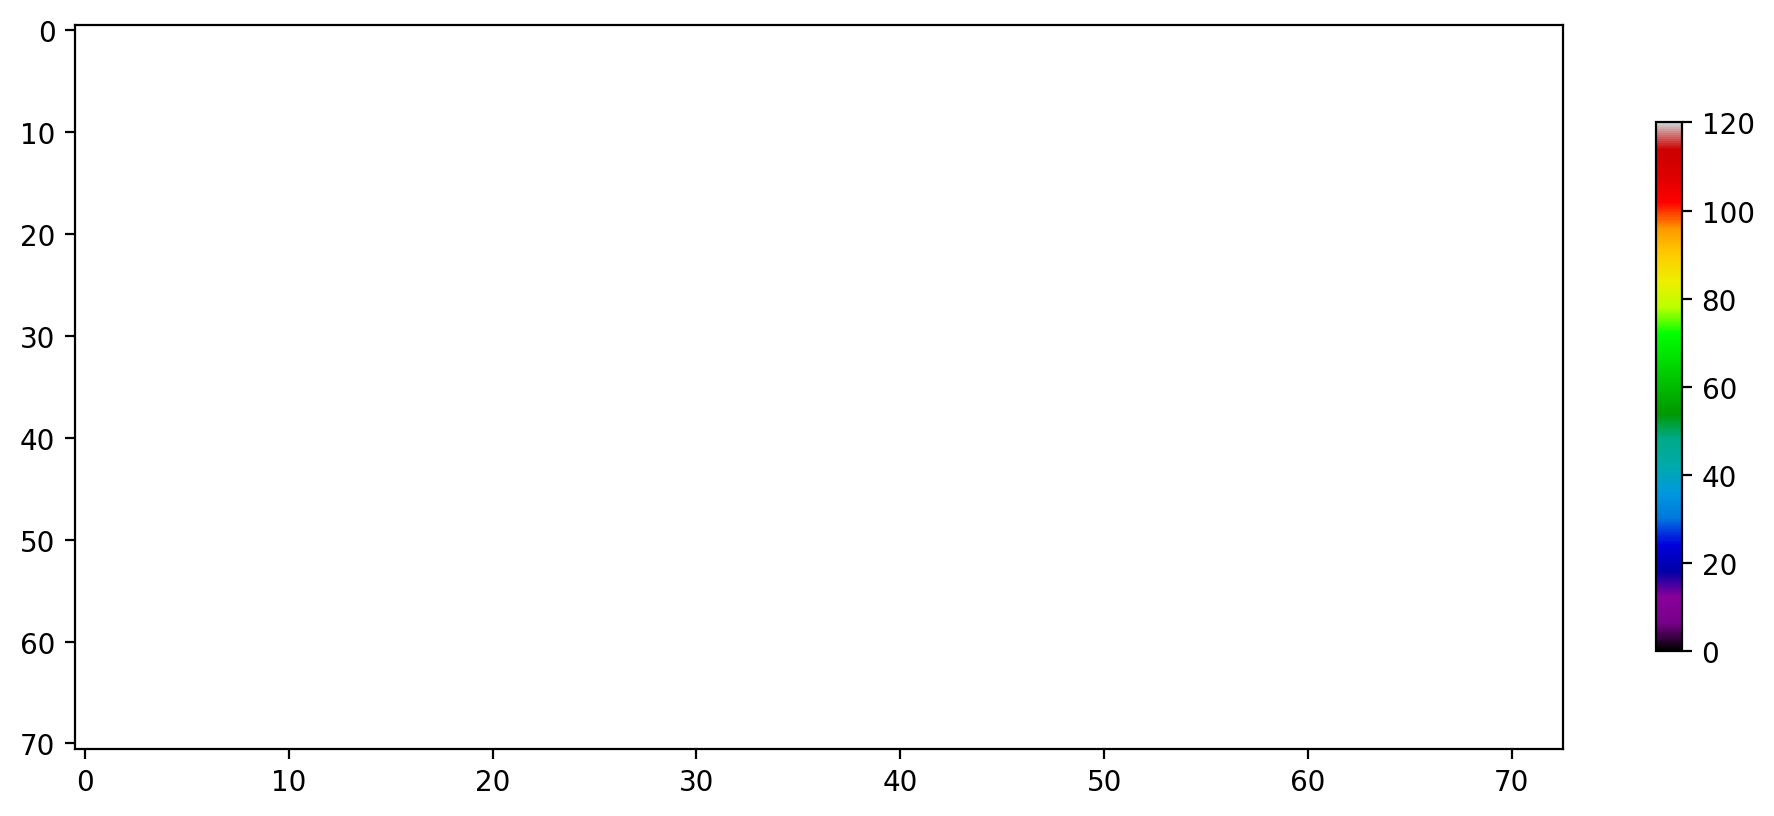

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

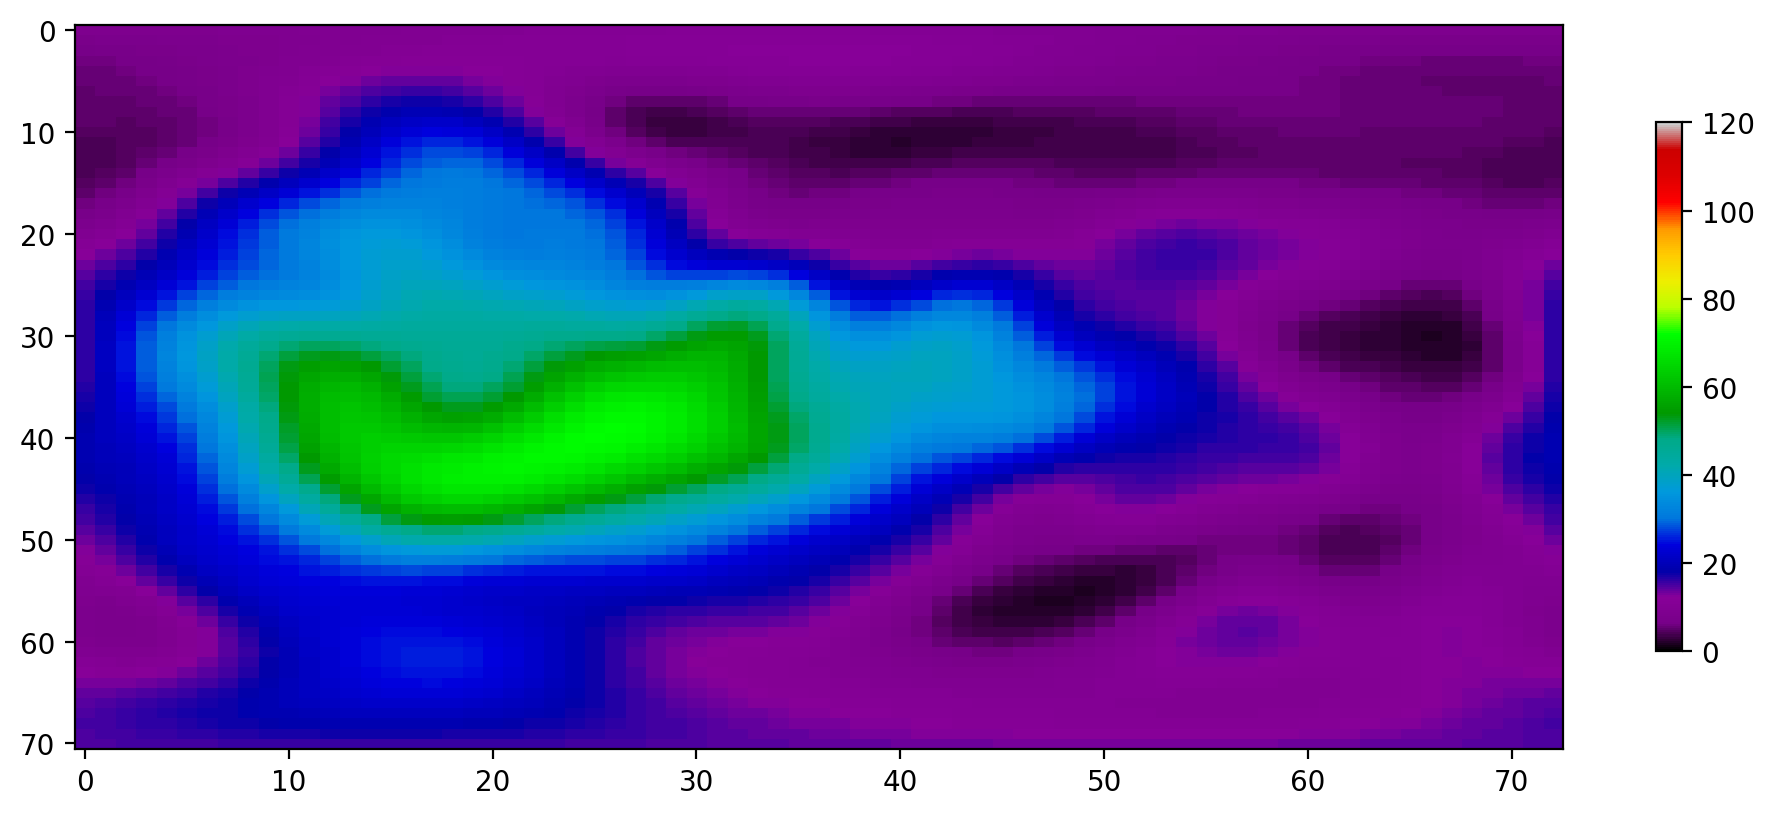

lon    -180  -175  -170  -165  -160       -155  -150       -145       -140  \
lat                                                                          
 87.5   8.6   8.6   8.7   8.7   8.8   8.900000   8.9   9.000000   9.100000   
 85.0   7.4   7.5   7.7   7.8   8.0   8.100000   8.3   8.500000   8.700000   
 82.5   6.5   6.7   6.9   7.1   7.3   7.600000   7.9   8.200000   8.500000   
 80.0   5.9   6.0   6.3   6.5   6.8   7.200000   7.6   8.000000   8.400000   
 77.5   5.4   5.6   5.8   6.1   6.5   6.900000   7.4   7.900000   8.500000   
...     ...   ...   ...   ...   ...        ...   ...        ...        ...   
-77.5  14.4  14.8  15.2  15.6  16.1  16.600000  17.1  17.799999  18.400000   
-80.0  14.8  15.2  15.6  16.0  16.5  16.900000  17.4  17.799999  18.299999   
-82.5  15.0  15.3  15.7  16.1  16.4  16.700001  17.1  17.400000  17.700001   
-85.0  14.9  15.2  15.4  15.7  15.9  16.200001  16.4  16.600000  16.799999   
-87.5  14.7  14.8  15.0  15.1  15.2  15.300000  15.4  15.500000 

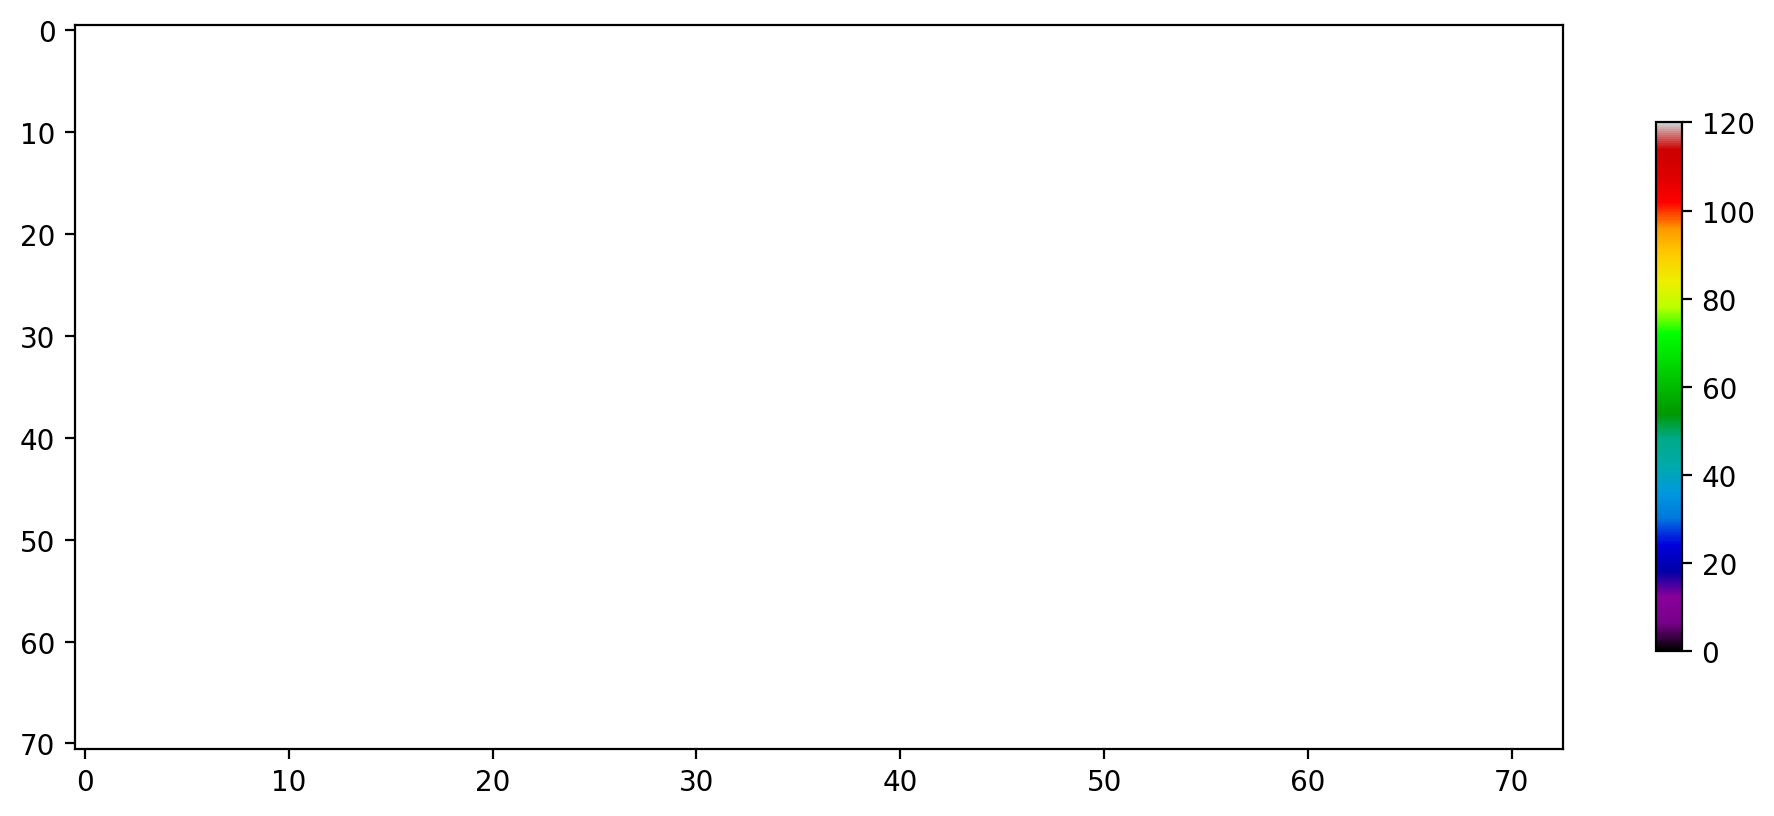

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

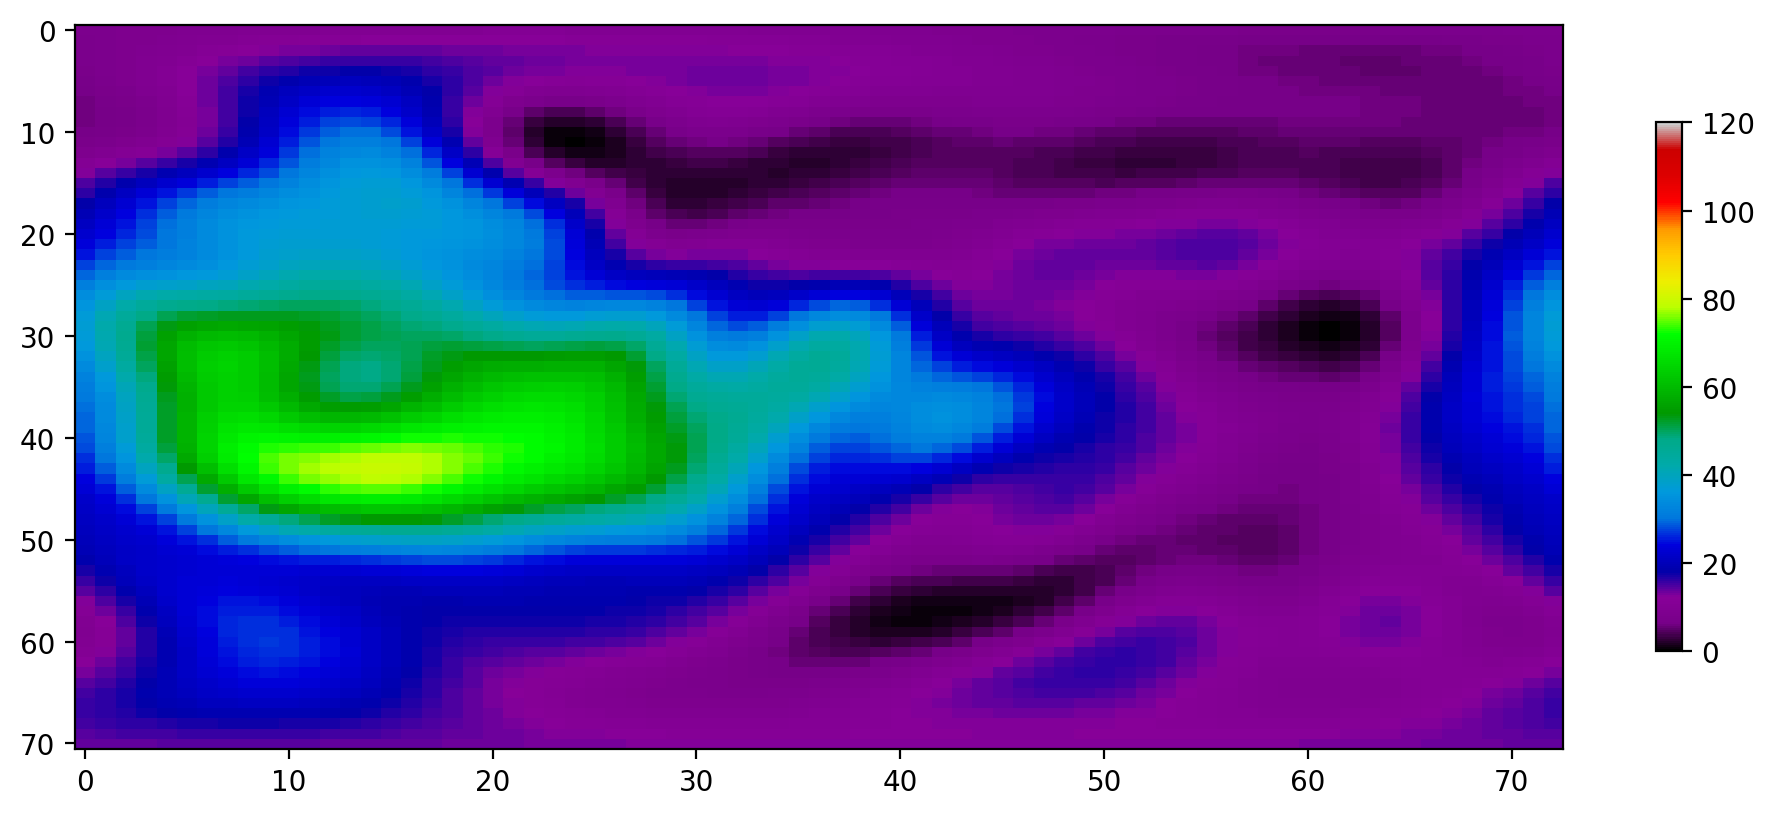

lon    -180       -175       -170  -165       -160  -155       -150  -145  \
lat                                                                         
 87.5   8.2   8.400000   8.500000   8.7   8.800000   9.0   9.100000   9.3   
 85.0   7.9   8.200000   8.500000   8.9   9.200000   9.5   9.900000  10.2   
 82.5   7.7   8.200000   8.700000   9.2   9.800000  10.3  10.900000  11.4   
 80.0   7.5   8.100000   8.800000   9.5  10.300000  11.2  12.000000  12.8   
 77.5   7.3   8.000000   8.800000   9.7  10.700000  11.8  12.900000  14.0   
...     ...        ...        ...   ...        ...   ...        ...   ...   
-77.5  15.5  16.400000  17.299999  18.1  18.900000  19.6  20.200001  20.6   
-80.0  15.6  16.200001  16.799999  17.4  18.000000  18.4  18.799999  19.1   
-82.5  15.2  15.600000  16.000000  16.4  16.799999  17.0  17.299999  17.4   
-85.0  14.5  14.800000  15.000000  15.2  15.400000  15.5  15.600000  15.7   
-87.5  13.8  13.900000  13.900000  14.0  14.100000  14.1  14.100000  14.2   

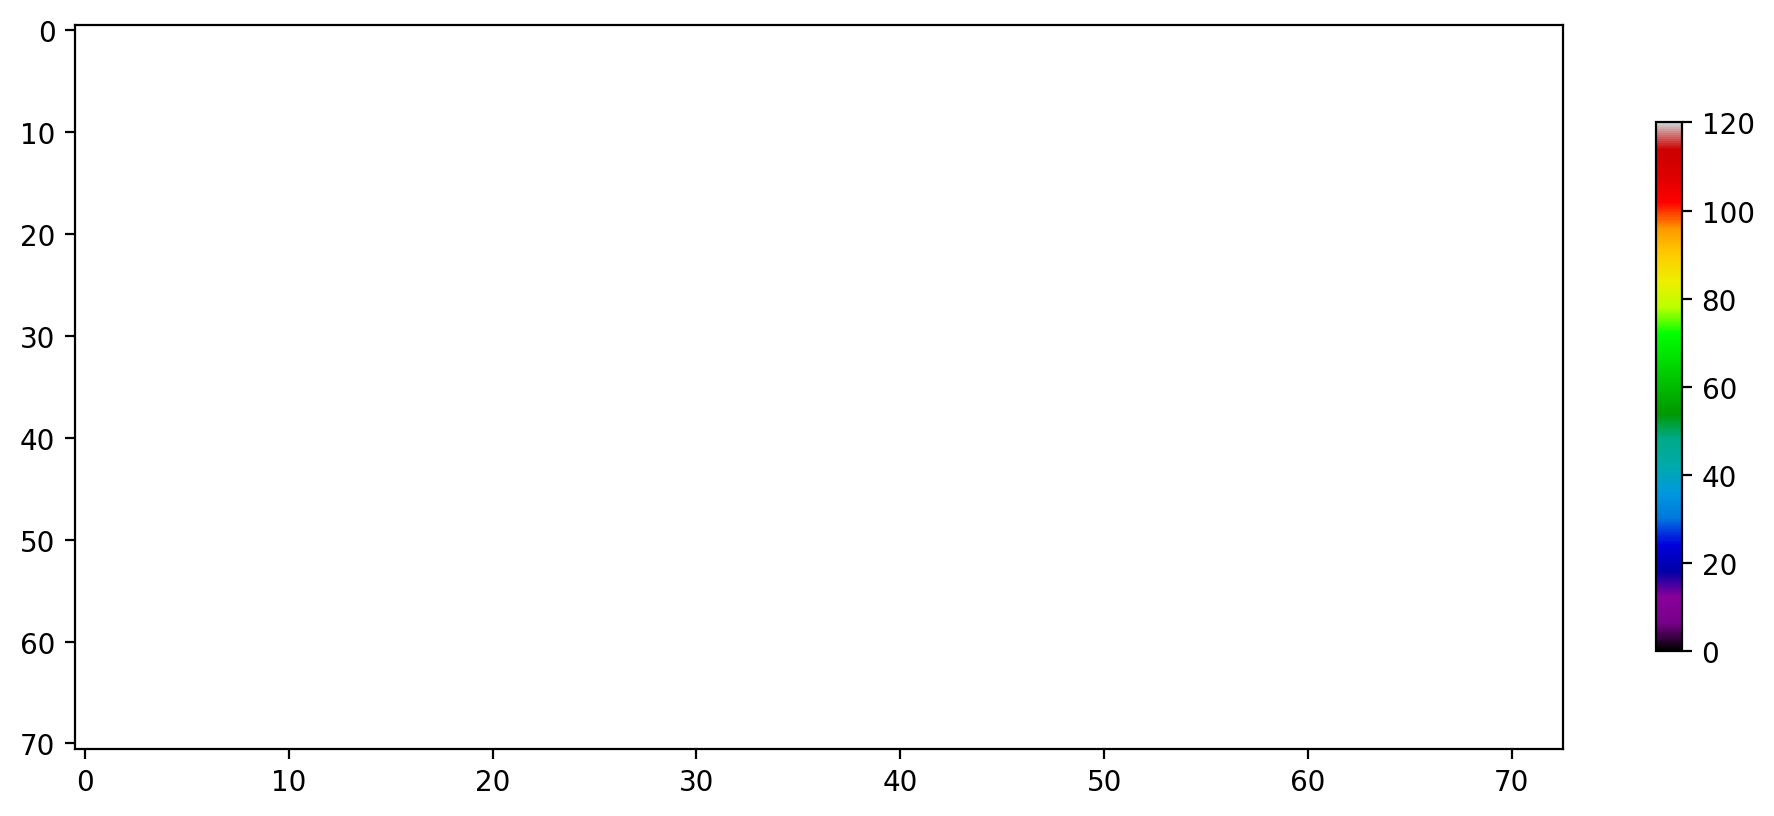

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

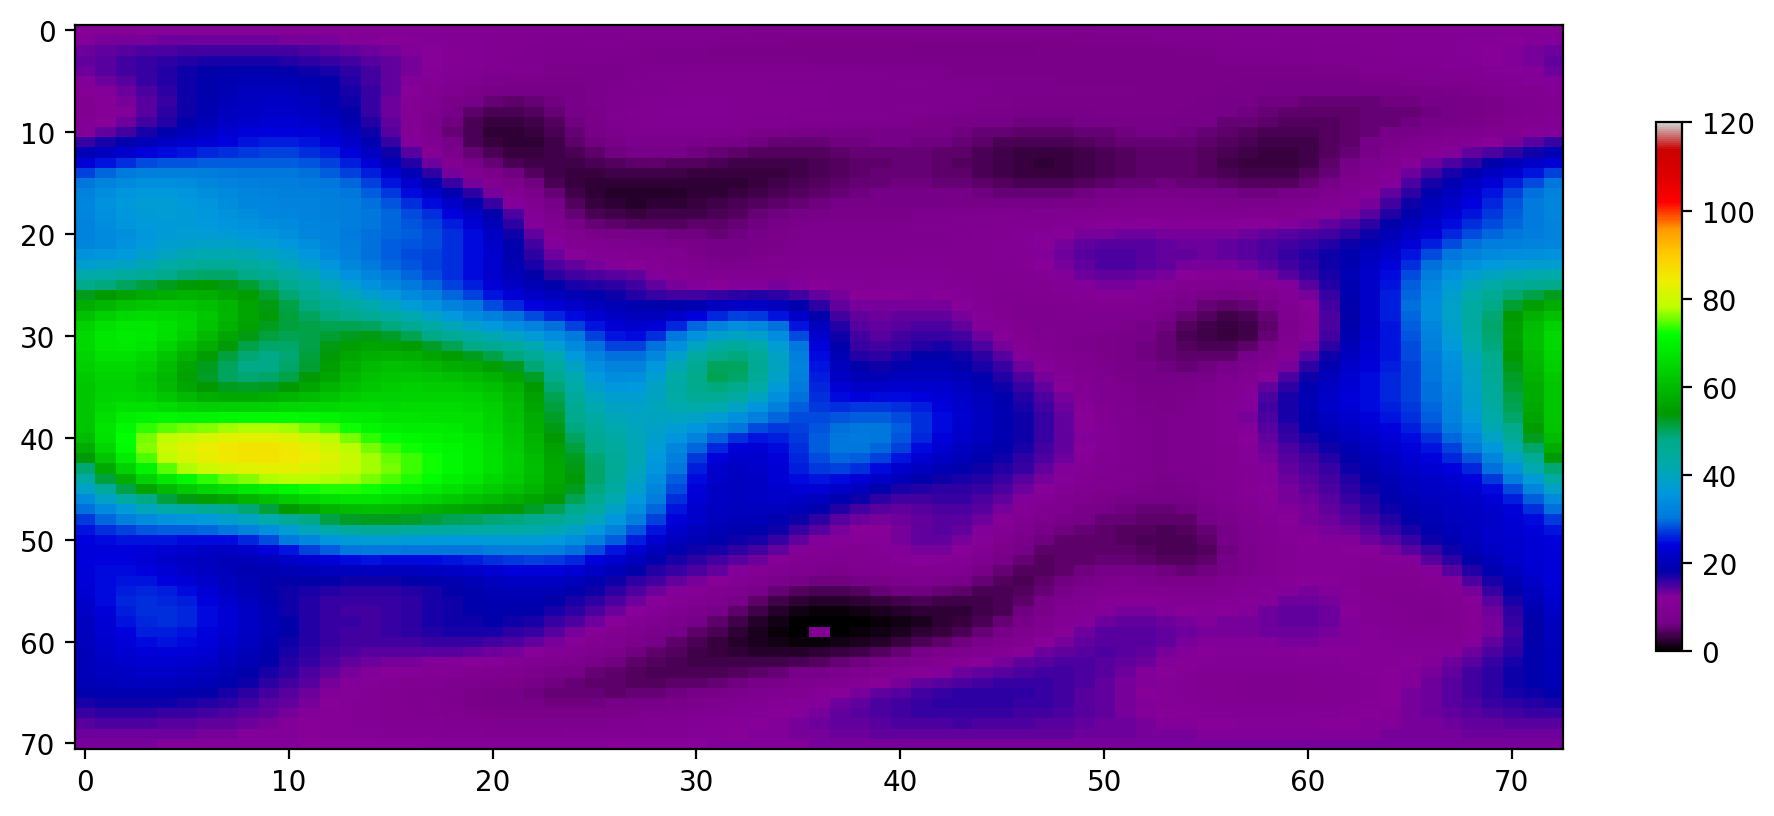

lon         -180  -175       -170  -165       -160  -155  -150       -145  \
lat                                                                         
 87.5  11.100000  11.2  11.200000  11.3  11.300000  11.4  11.4  11.400000   
 85.0  12.500000  12.7  12.900000  13.1  13.200000  13.3  13.4  13.400000   
 82.5  13.400000  13.8  14.200000  14.6  14.900000  15.1  15.3  15.400000   
 80.0  13.700000  14.3  15.000000  15.6  16.100000  16.5  16.9  17.100000   
 77.5  13.200000  14.1  15.000000  15.8  16.700001  17.4  17.9  18.299999   
...          ...   ...        ...   ...        ...   ...   ...        ...   
-77.5  17.200001  17.5  17.700001  17.6  17.400000  17.1  16.6  16.000000   
-80.0  15.900000  16.0  16.100000  16.0  15.900000  15.6  15.2  14.700000   
-82.5  14.500000  14.6  14.600000  14.6  14.400000  14.2  14.0  13.700000   
-85.0  13.500000  13.5  13.400000  13.4  13.300000  13.2  13.0  12.800000   
-87.5  12.800000  12.7  12.700000  12.7  12.600000  12.6  12.5  12.400000   

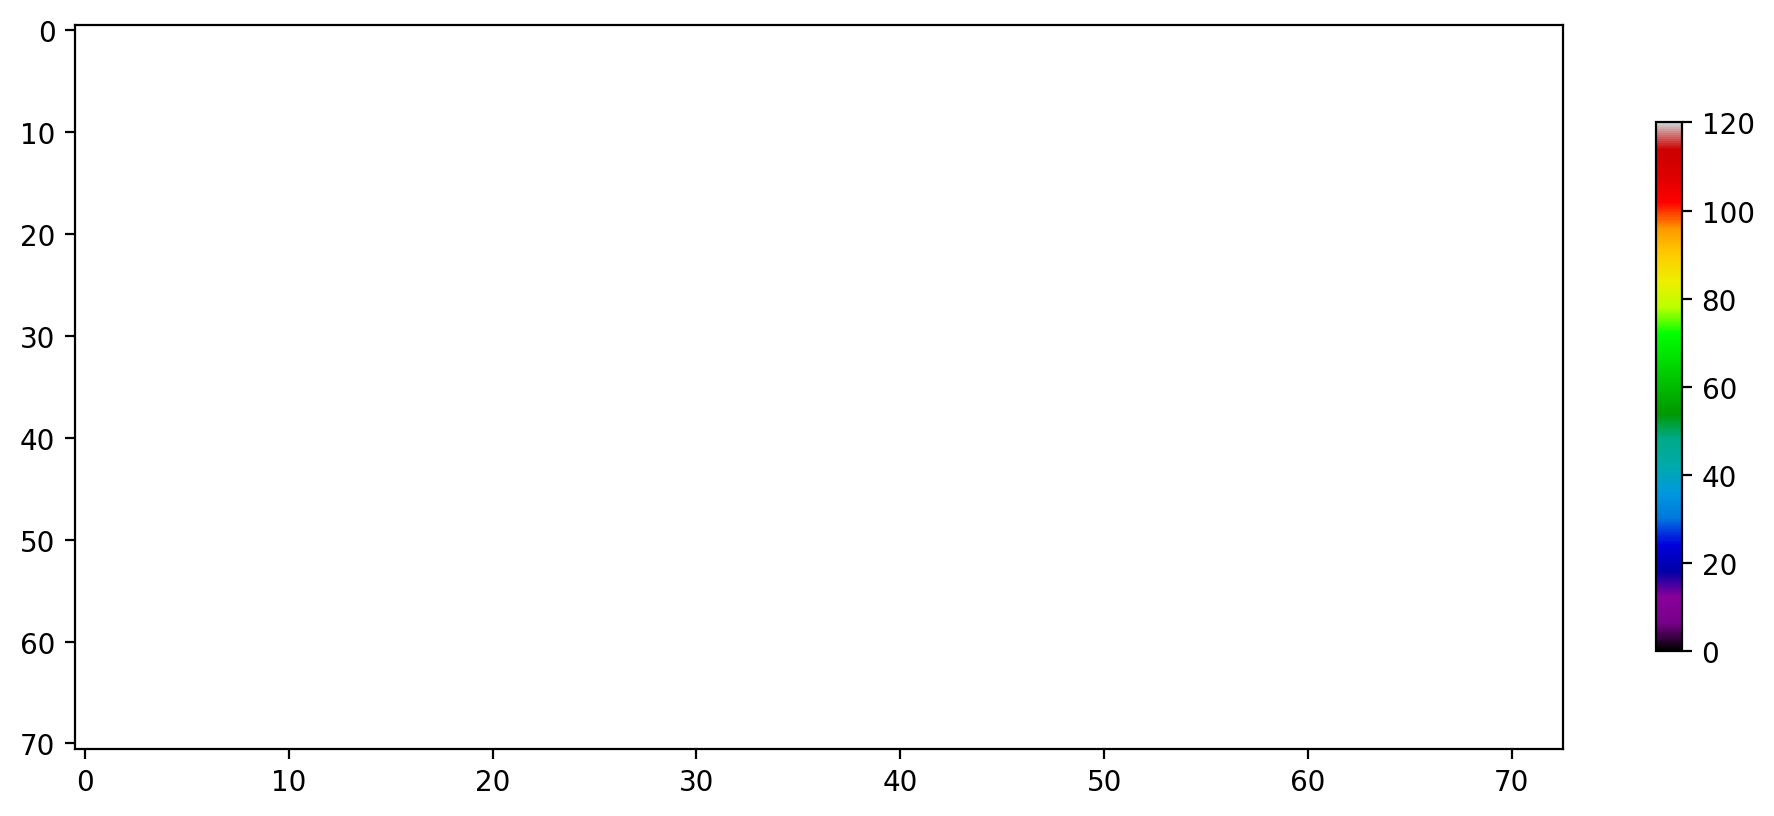

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

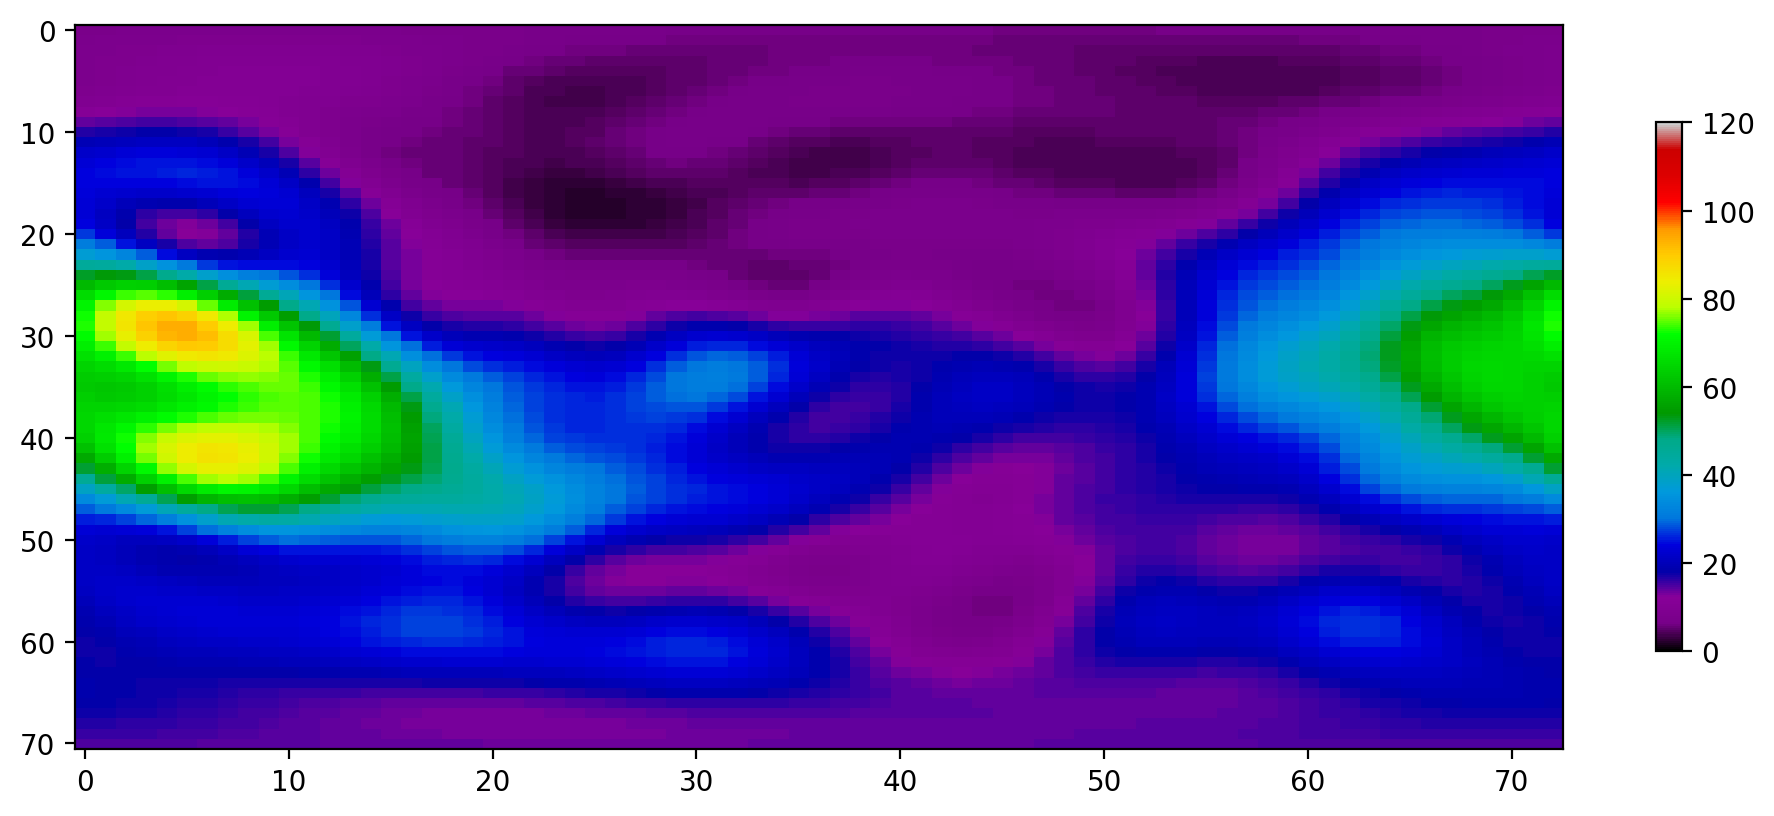

lon         -180  -175       -170       -165       -160       -155  -150  \
lat                                                                        
 87.5   7.300000   7.4   7.500000   7.500000   7.600000   7.600000   7.7   
 85.0   7.800000   8.0   8.200000   8.300000   8.400000   8.500000   8.6   
 82.5   8.100000   8.4   8.600000   8.900000   9.100000   9.300000   9.5   
 80.0   8.100000   8.5   8.900000   9.200000   9.600000   9.800000  10.0   
 77.5   8.100000   8.6   9.000000   9.400000   9.800000  10.100000  10.3   
...          ...   ...        ...        ...        ...        ...   ...   
-77.5  18.100000  17.9  17.700001  17.400000  17.200001  16.799999  16.5   
-80.0  17.500000  17.4  17.200001  17.000000  16.700001  16.400000  16.1   
-82.5  16.700001  16.6  16.400000  16.299999  16.100000  15.800000  15.6   
-85.0  15.700000  15.7  15.600000  15.500000  15.300000  15.200000  15.0   
-87.5  14.800000  14.8  14.700000  14.700000  14.600000  14.600000  14.5   

lon        

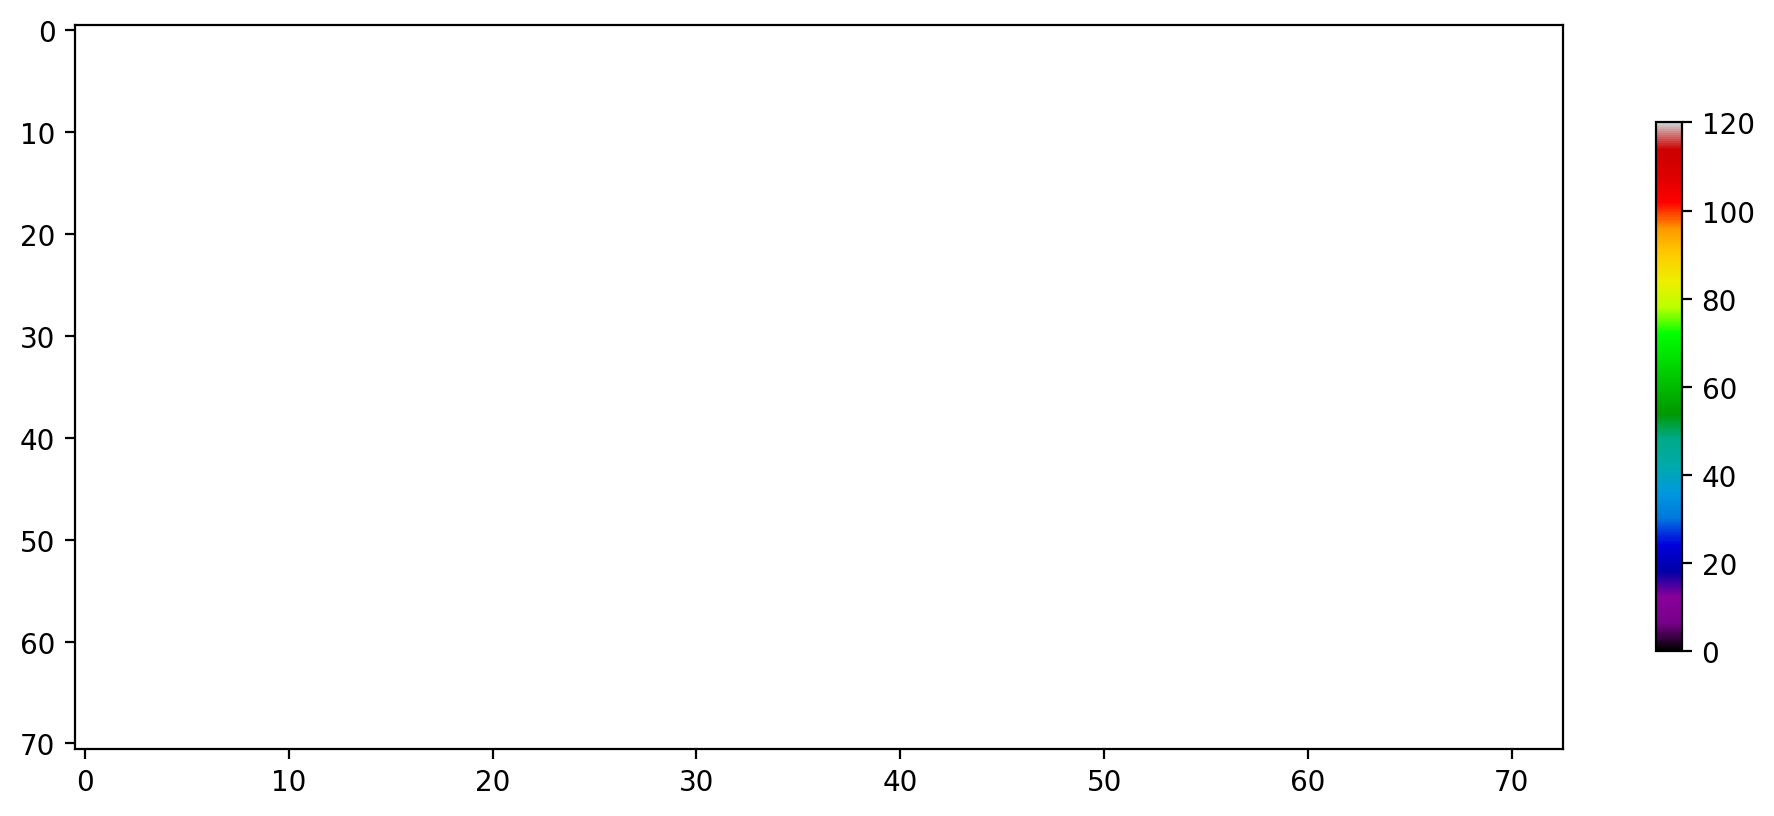

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

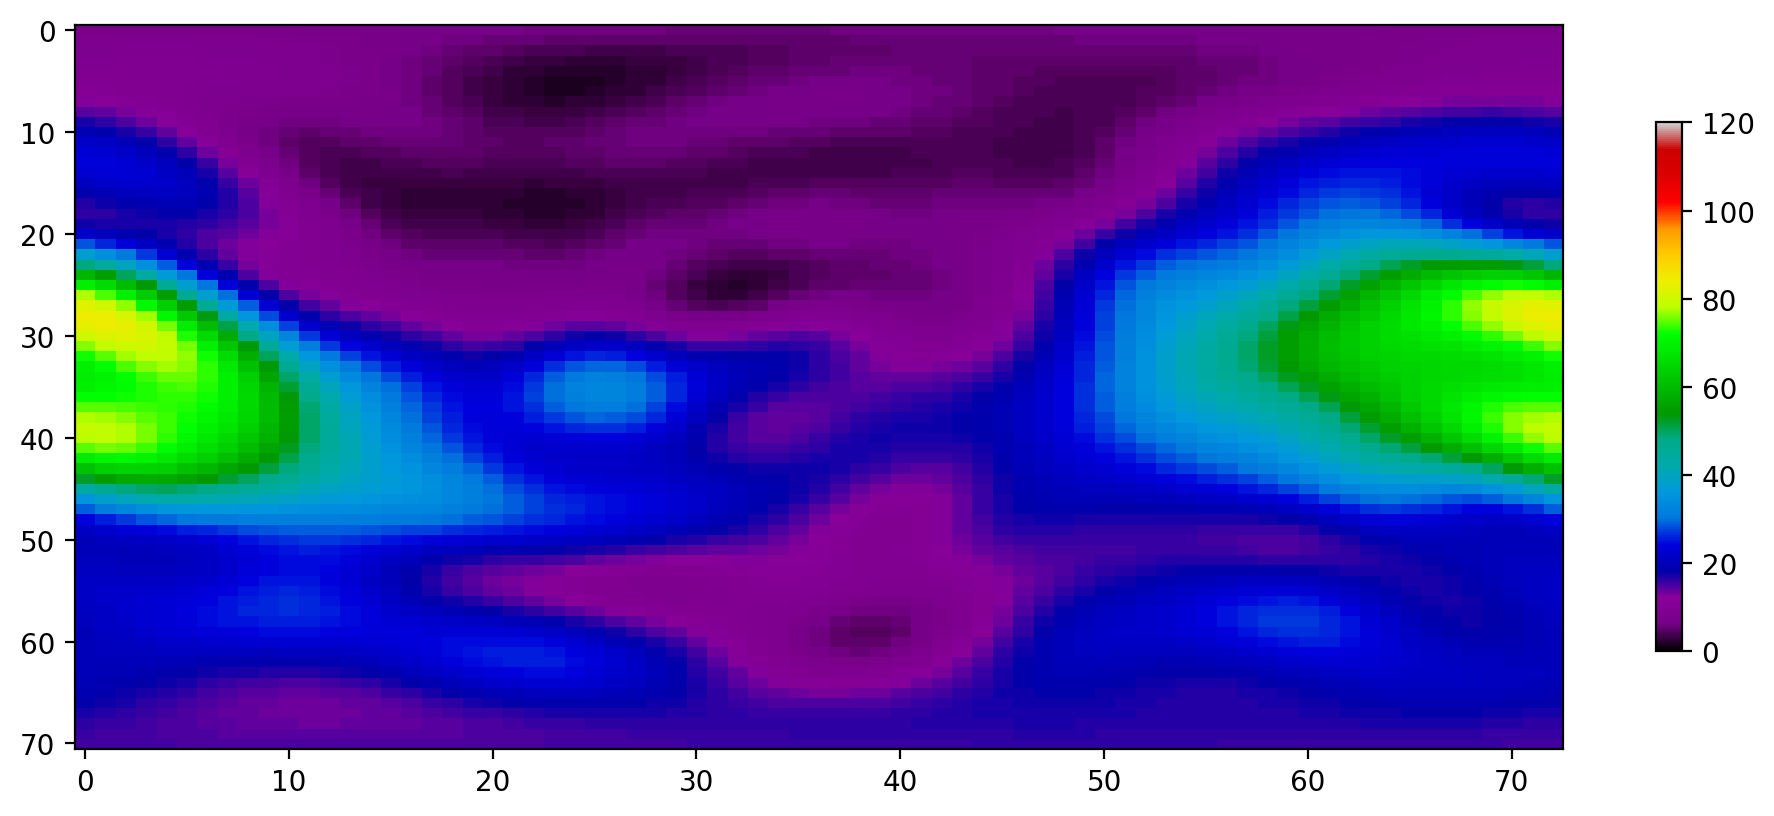

lon    -180  -175       -170  -165  -160  -155  -150  -145  -140  -135  ...  \
lat                                                                     ...   
 87.5   7.4   7.4   7.400000   7.4   7.4   7.4   7.3   7.3   7.2   7.2  ...   
 85.0   8.2   8.3   8.300000   8.3   8.3   8.2   8.2   8.1   8.0   7.9  ...   
 82.5   8.8   8.9   9.000000   9.0   9.0   9.0   8.9   8.8   8.6   8.5  ...   
 80.0   9.2   9.3   9.400000   9.4   9.4   9.4   9.3   9.2   9.1   8.9  ...   
 77.5   9.5   9.6   9.600000   9.6   9.5   9.5   9.4   9.3   9.2   9.0  ...   
...     ...   ...        ...   ...   ...   ...   ...   ...   ...   ...  ...   
-77.5  18.0  17.5  17.000000  16.4  15.9  15.3  14.8  14.3  13.9  13.6  ...   
-80.0  17.0  16.6  16.200001  15.8  15.3  14.9  14.4  14.0  13.7  13.5  ...   
-82.5  16.1  15.9  15.600000  15.3  15.0  14.7  14.4  14.1  13.9  13.7  ...   
-85.0  15.5  15.4  15.200000  15.1  14.9  14.7  14.6  14.4  14.3  14.2  ...   
-87.5  15.3  15.3  15.200000  15.1  15.1  15.0  15.0

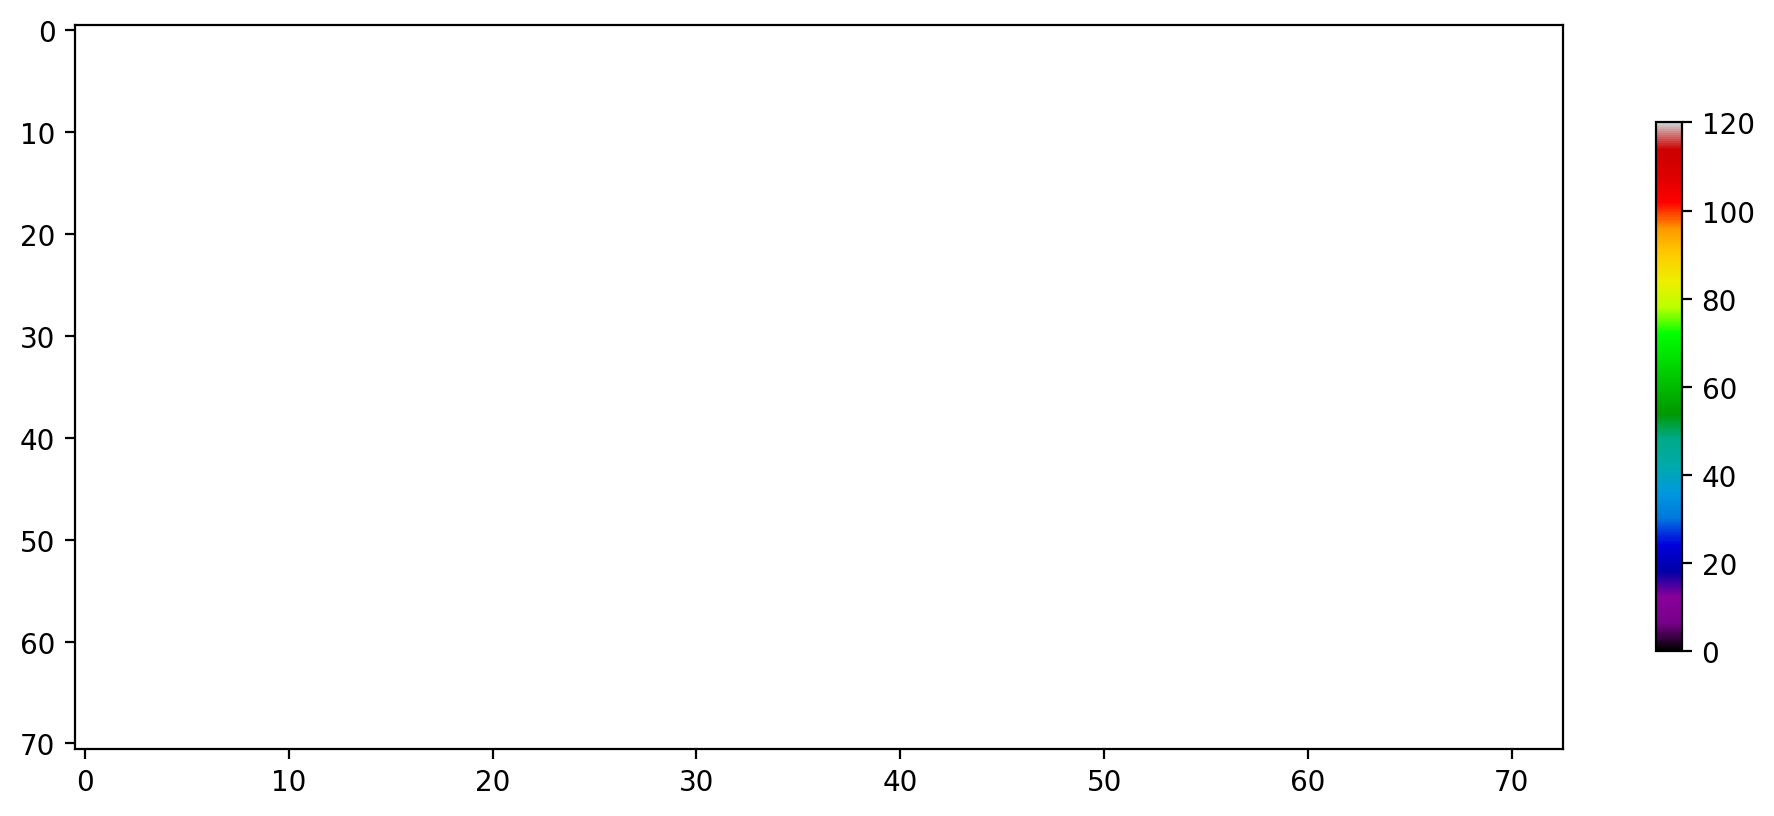

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

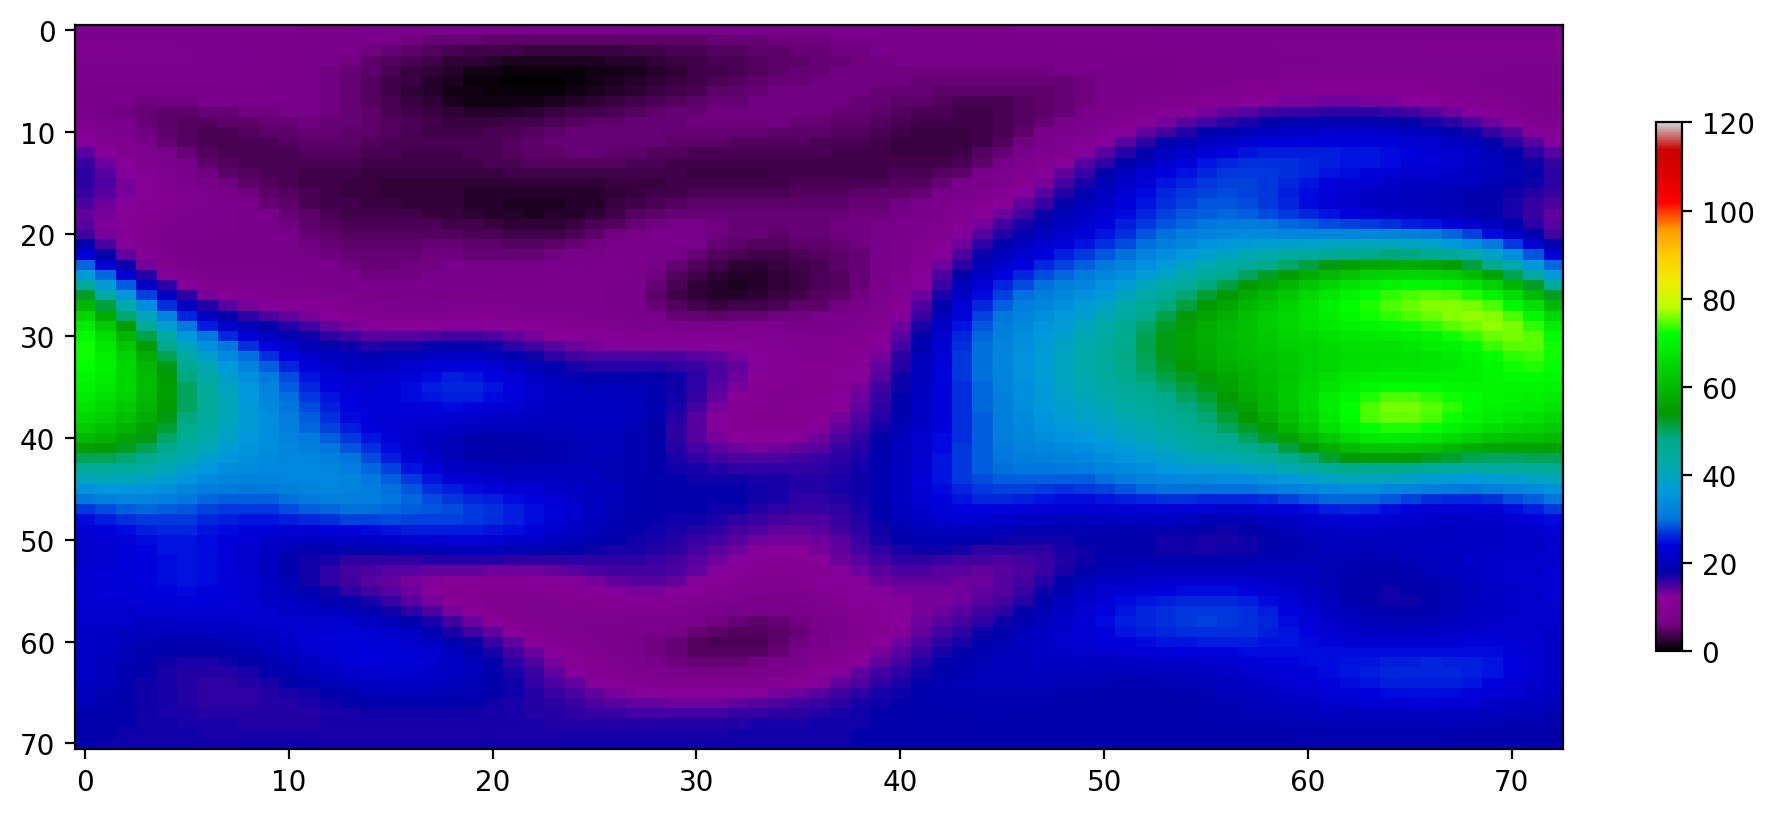

lon         -180       -175       -170       -165       -160       -155  \
lat                                                                       
 87.5   8.300000   8.300000   8.200000   8.100000   8.100000   8.000000   
 85.0   8.900000   8.800000   8.700000   8.600000   8.500000   8.400000   
 82.5   9.000000   9.000000   8.900000   8.900000   8.700000   8.600000   
 80.0   8.800000   8.800000   8.800000   8.800000   8.700000   8.600000   
 77.5   8.300000   8.300000   8.300000   8.300000   8.300000   8.300000   
...          ...        ...        ...        ...        ...        ...   
-77.5  19.900000  19.100000  18.400000  17.700001  17.100000  16.700001   
-80.0  19.200001  18.700001  18.100000  17.700001  17.299999  16.900000   
-82.5  18.600000  18.200001  17.900000  17.700001  17.400000  17.200001   
-85.0  18.100000  17.900000  17.799999  17.700001  17.500000  17.400000   
-87.5  17.900000  17.799999  17.799999  17.700001  17.700001  17.600000   

lon         -150       -

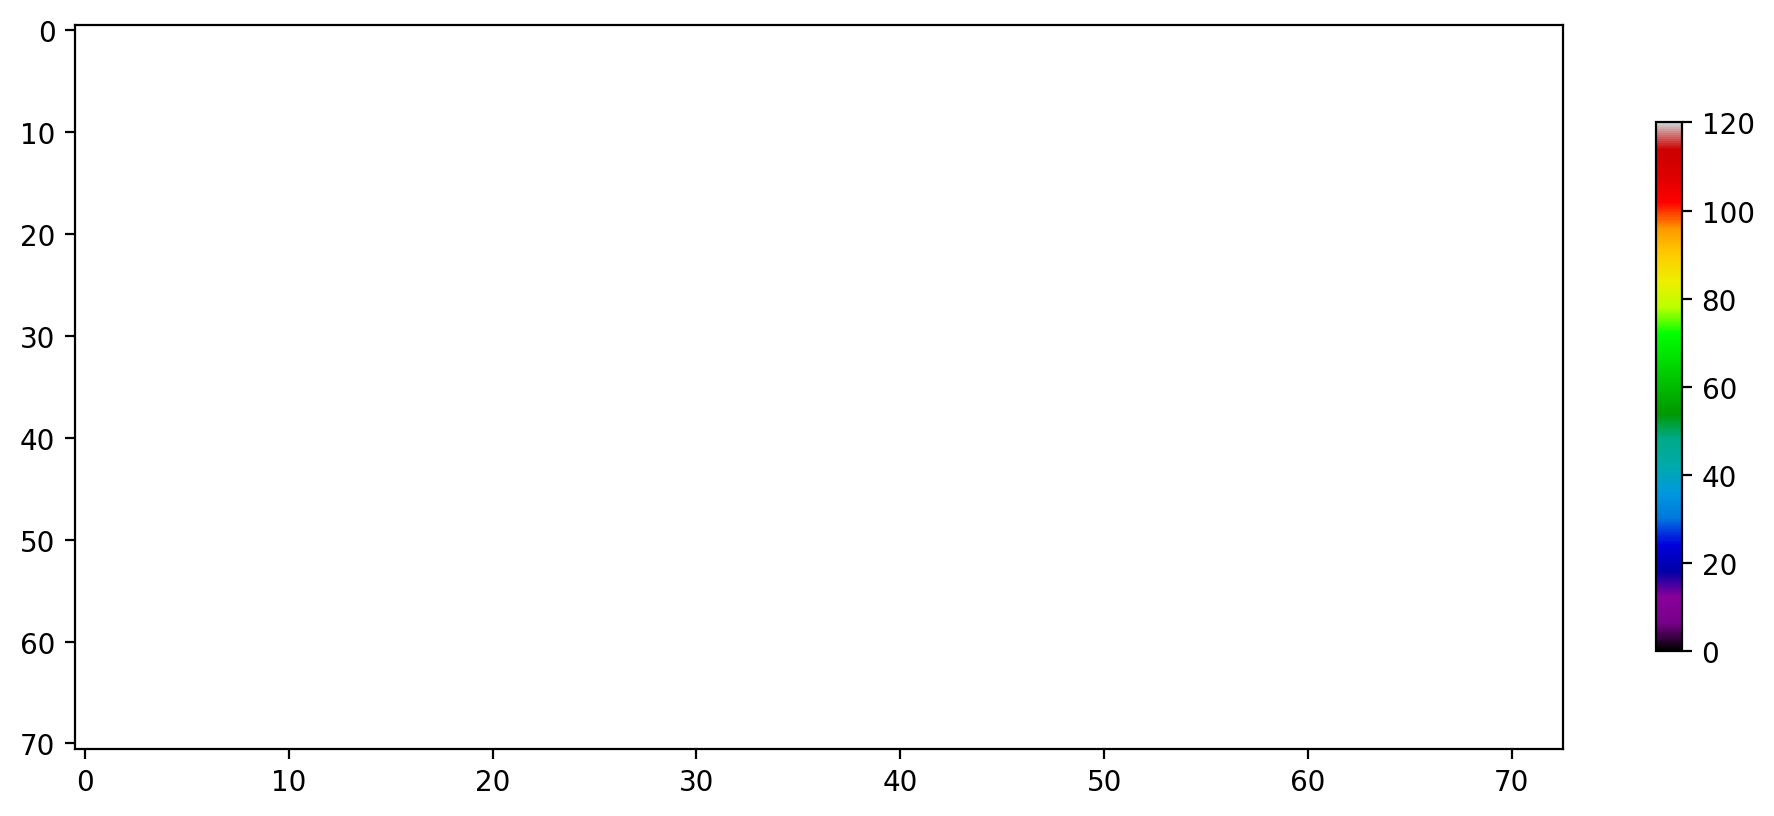

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

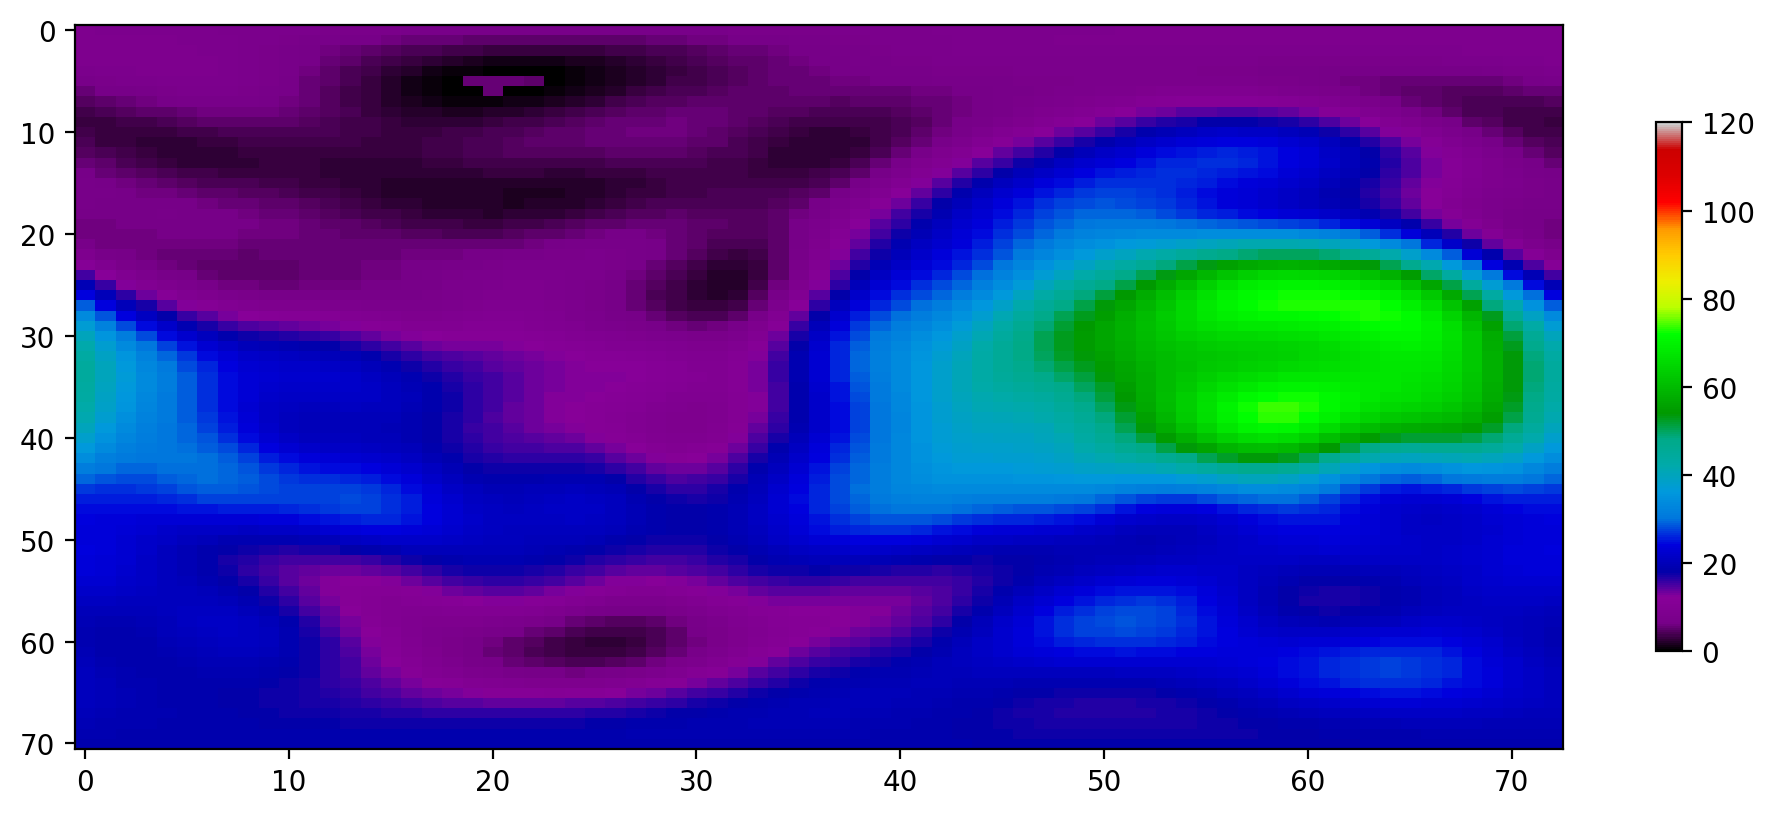

lon         -180       -175       -170       -165       -160  -155       -150  \
lat                                                                             
 87.5   8.500000   8.400000   8.400000   8.300000   8.200000   8.1   8.000000   
 85.0   8.800000   8.800000   8.700000   8.600000   8.500000   8.3   8.200000   
 82.5   8.900000   8.900000   8.900000   8.800000   8.700000   8.6   8.300000   
 80.0   8.500000   8.700000   8.800000   8.800000   8.800000   8.7   8.500000   
 77.5   7.800000   8.100000   8.400000   8.500000   8.600000   8.6   8.500000   
...          ...        ...        ...        ...        ...   ...        ...   
-77.5  20.299999  19.799999  19.400000  19.000000  18.700001  18.5  18.299999   
-80.0  19.799999  19.500000  19.200001  19.000000  18.799999  18.6  18.400000   
-82.5  19.299999  19.100000  19.000000  18.900000  18.700001  18.6  18.500000   
-85.0  18.799999  18.799999  18.700001  18.700001  18.600000  18.6  18.500000   
-87.5  18.500000  18.500000 

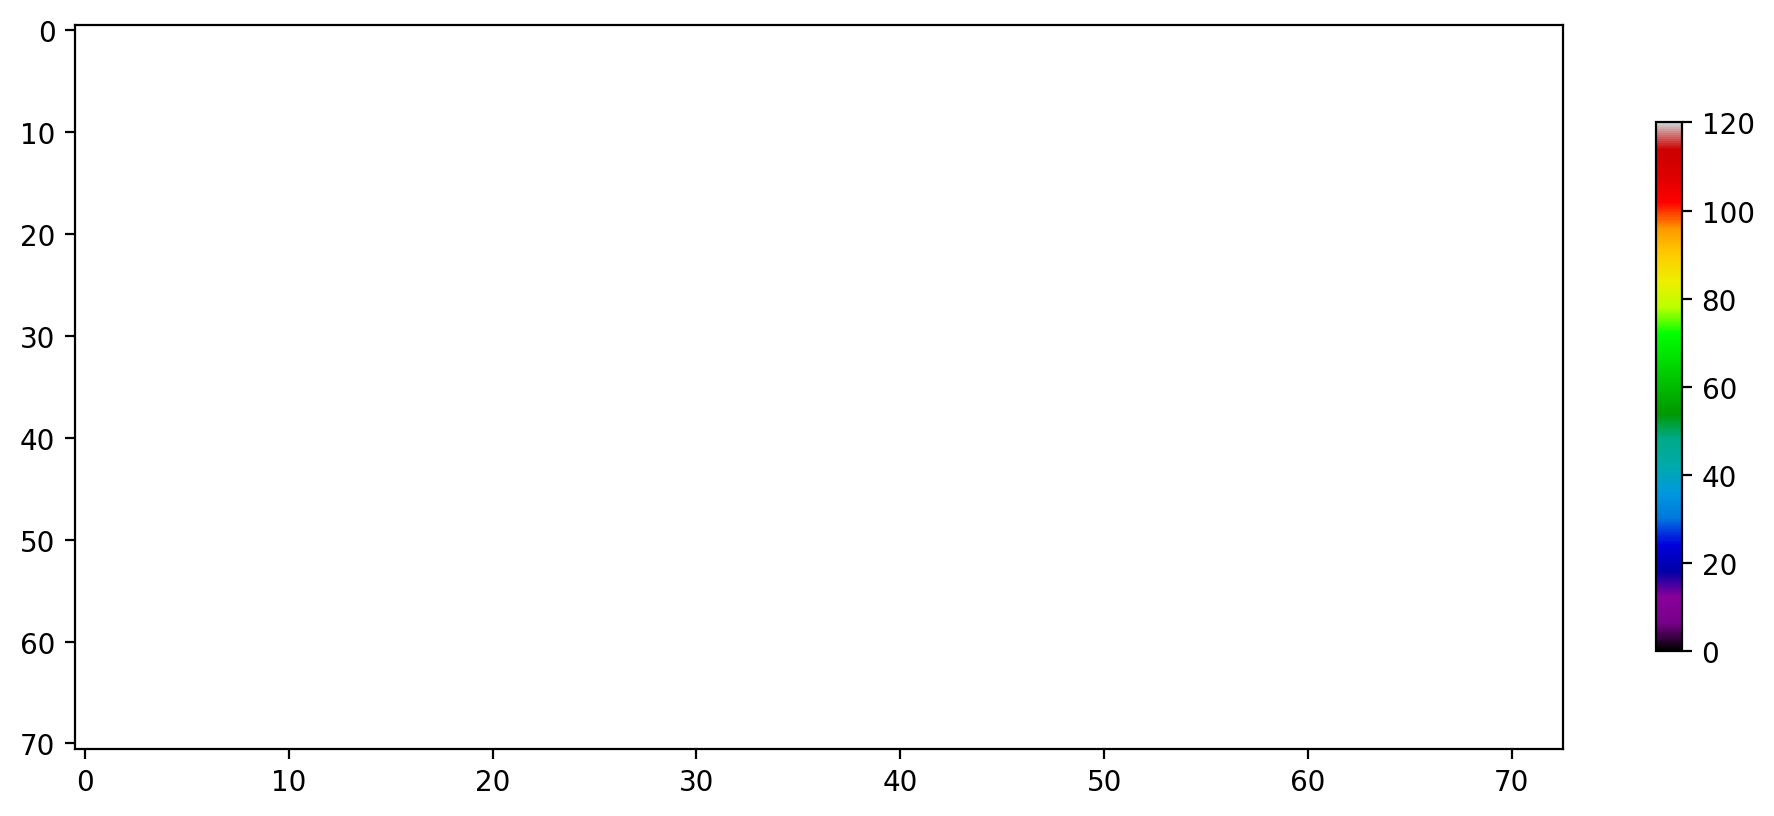

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

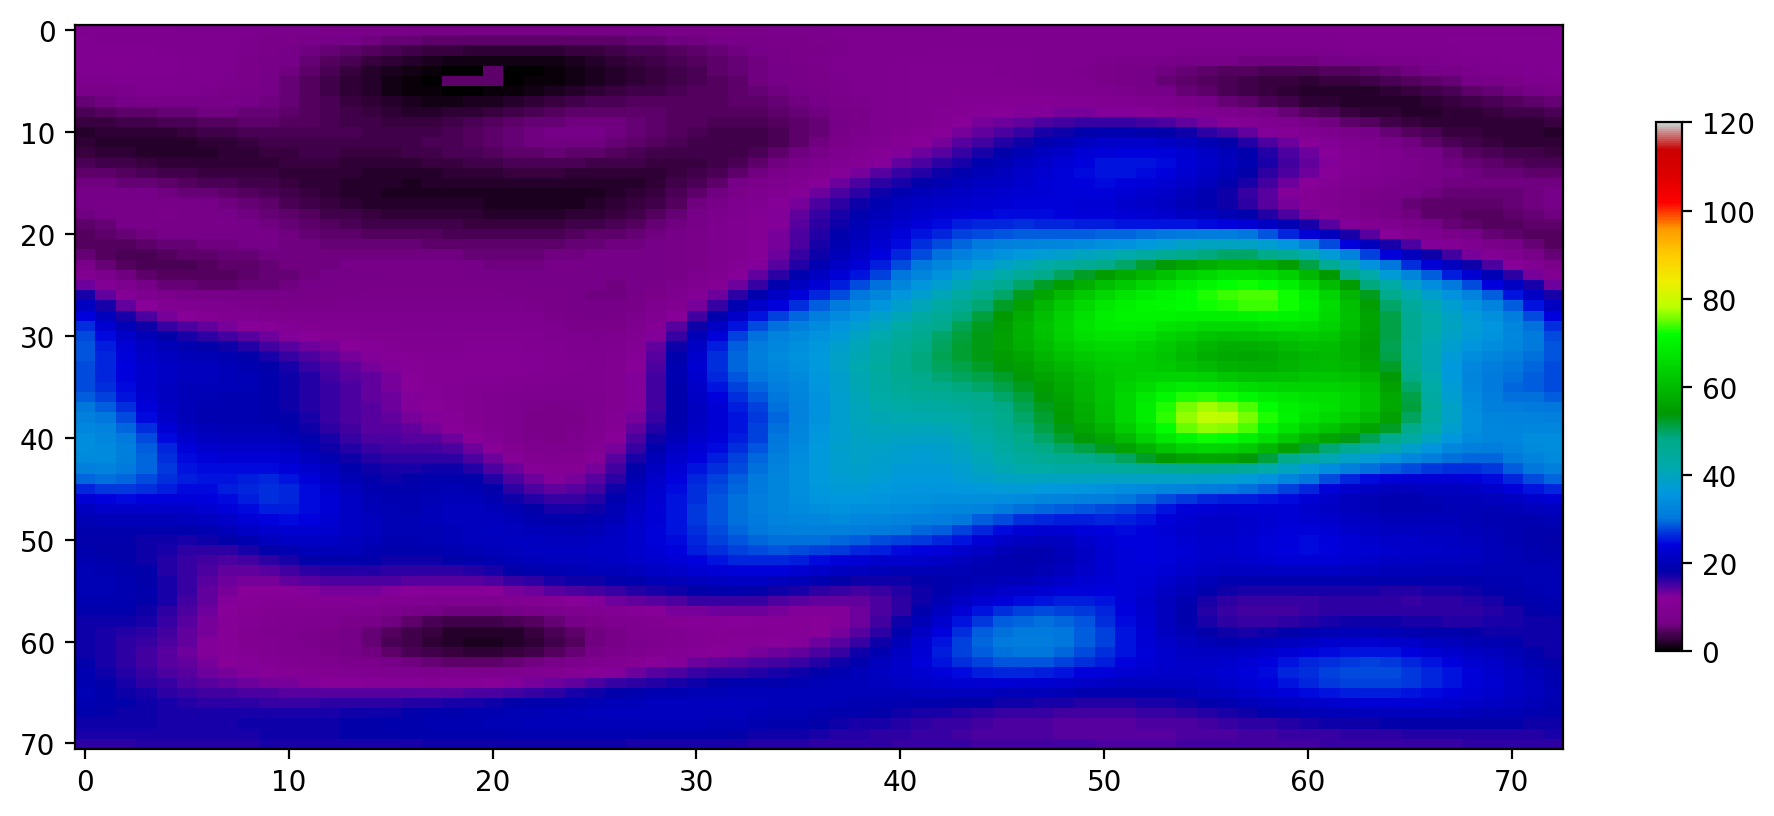

lon         -180       -175       -170  -165       -160       -155       -150  \
lat                                                                             
 87.5   8.800000   8.800000   8.700000   8.6   8.500000   8.400000   8.200000   
 85.0   9.400000   9.300000   9.200000   9.0   8.800000   8.600000   8.400000   
 82.5   9.800000   9.800000   9.700000   9.5   9.200000   8.900000   8.500000   
 80.0   9.800000   9.900000   9.900000   9.7   9.500000   9.100000   8.700000   
 77.5   9.400000   9.600000   9.700000   9.6   9.500000   9.100000   8.700000   
...          ...        ...        ...   ...        ...        ...        ...   
-77.5  19.100000  18.500000  17.900000  17.4  17.000000  16.600000  16.400000   
-80.0  18.500000  18.100000  17.799999  17.5  17.299999  17.100000  17.000000   
-82.5  17.700001  17.600000  17.500000  17.4  17.299999  17.299999  17.299999   
-85.0  16.900000  16.900000  16.900000  17.0  17.000000  17.100000  17.100000   
-87.5  16.299999  16.299999 

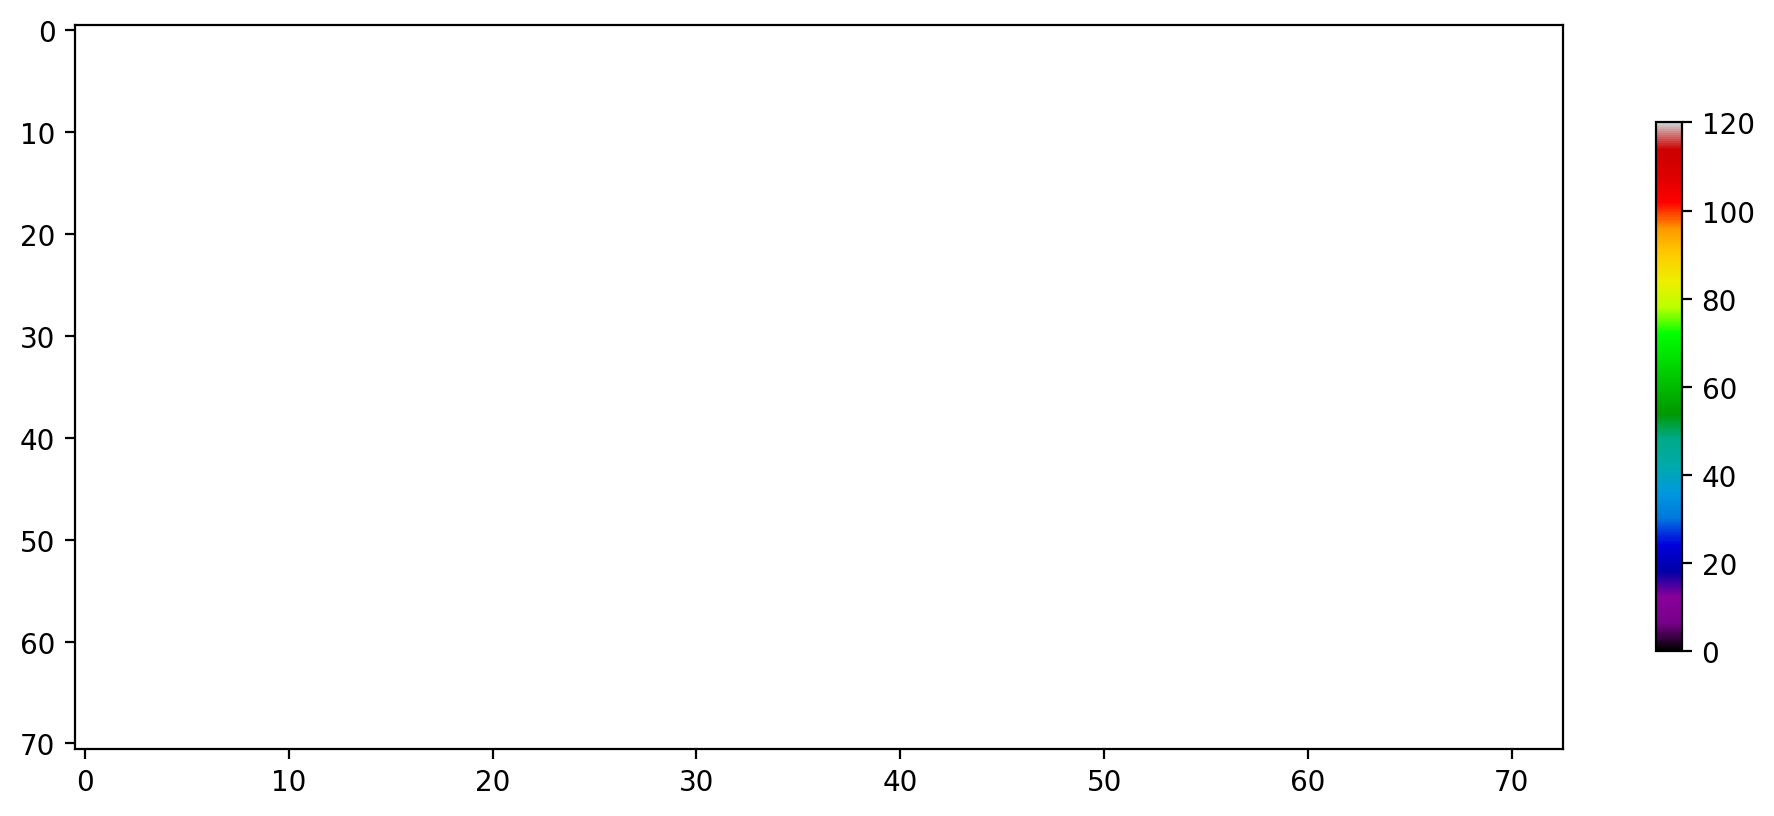

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

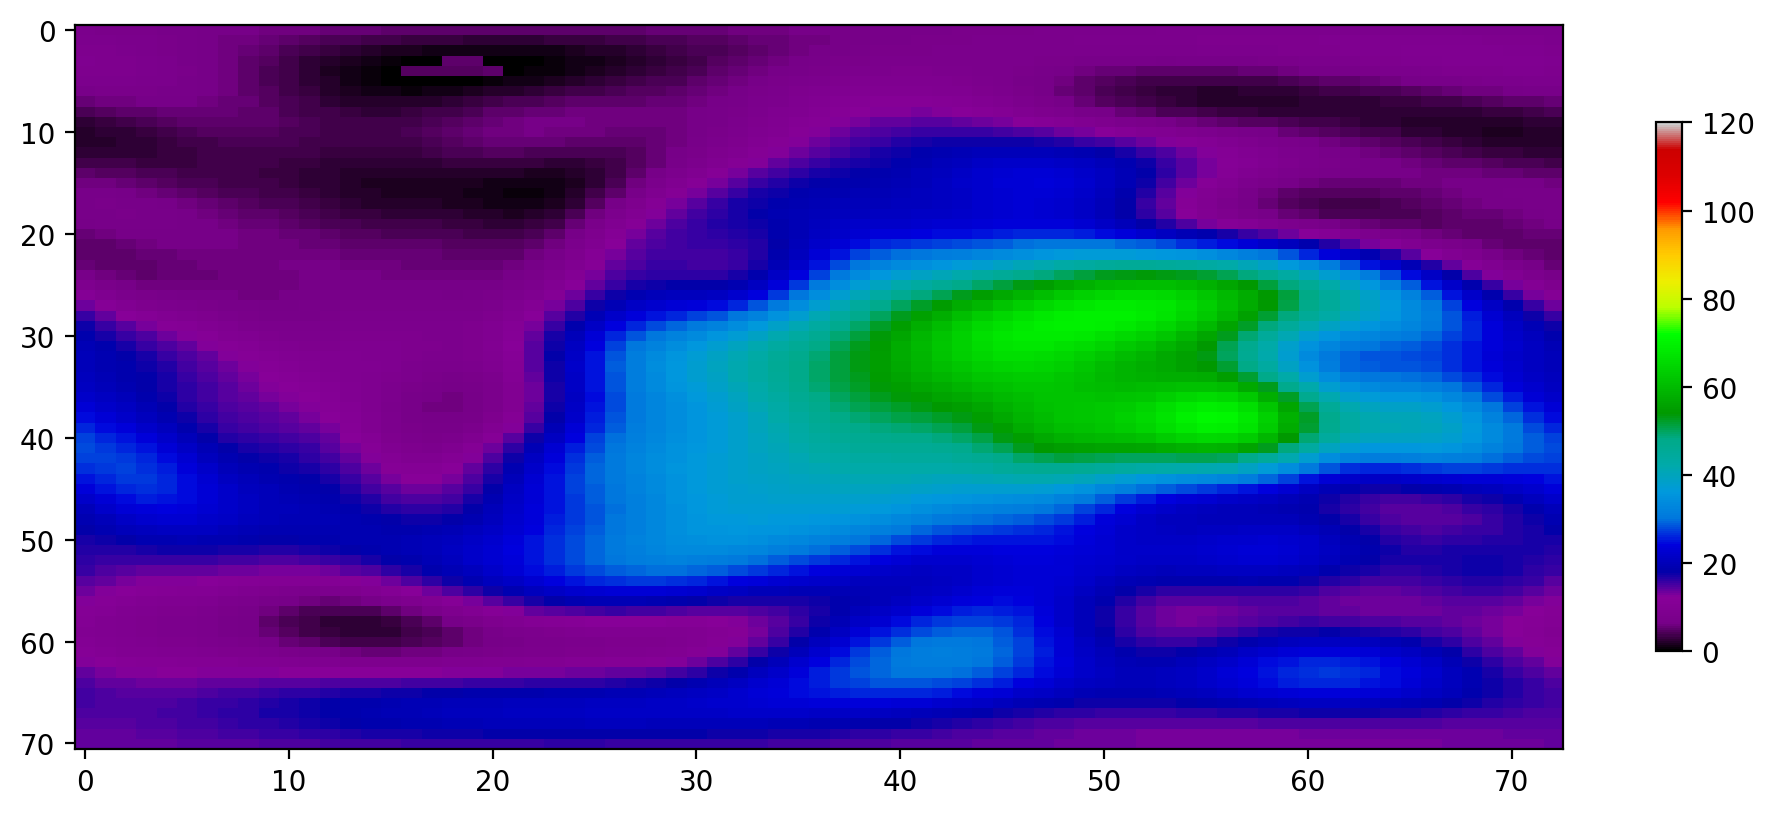

lon    -180  -175  -170  -165  -160  -155  -150  -145       -140       -135  \
lat                                                                           
 87.5   7.5   7.4   7.2   7.1   6.9   6.7   6.5   6.4   6.200000   6.000000   
 85.0   8.3   8.1   7.8   7.5   7.1   6.8   6.4   6.0   5.700000   5.300000   
 82.5   8.9   8.6   8.3   7.9   7.4   6.9   6.4   5.8   5.200000   4.700000   
 80.0   9.2   8.9   8.6   8.1   7.6   7.0   6.4   5.7   5.000000   4.300000   
 77.5   8.9   8.8   8.5   8.1   7.7   7.1   6.4   5.7   4.900000   4.100000   
...     ...   ...   ...   ...   ...   ...   ...   ...        ...        ...   
-77.5  15.2  15.0  14.8  14.8  14.9  15.2  15.5  15.8  16.200001  16.700001   
-80.0  14.9  14.8  14.8  14.9  15.1  15.3  15.6  16.0  16.400000  16.900000   
-82.5  14.3  14.3  14.5  14.6  14.8  15.1  15.4  15.7  16.100000  16.400000   
-85.0  13.7  13.9  14.0  14.2  14.4  14.6  14.8  15.1  15.300000  15.600000   
-87.5  13.6  13.7  13.8  13.9  14.0  14.1  14.3  14.

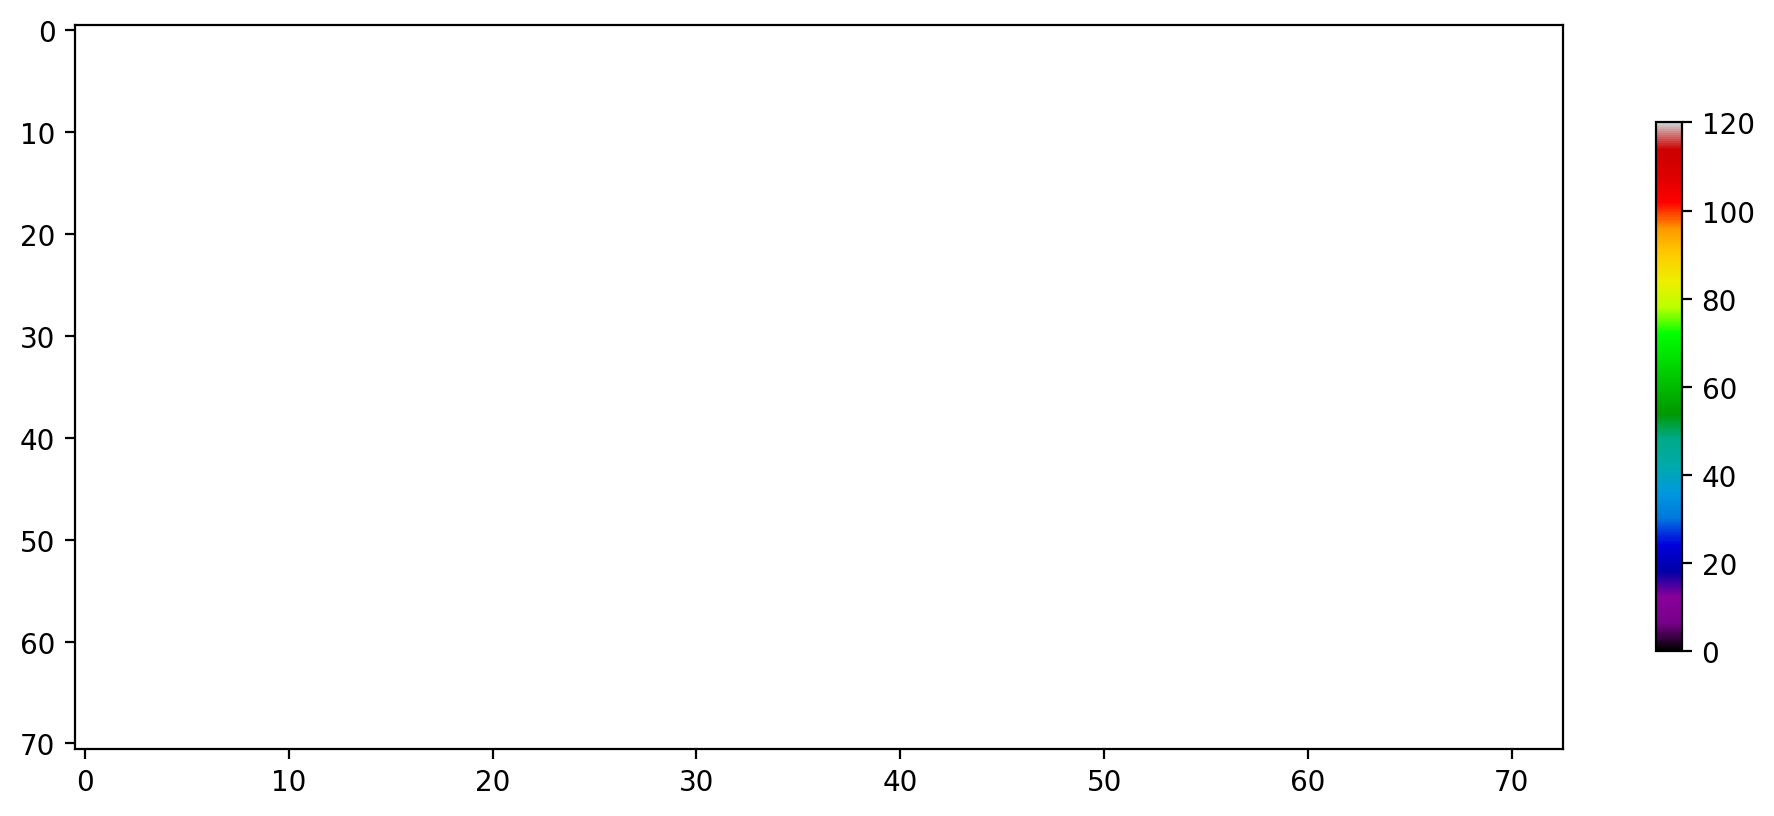

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

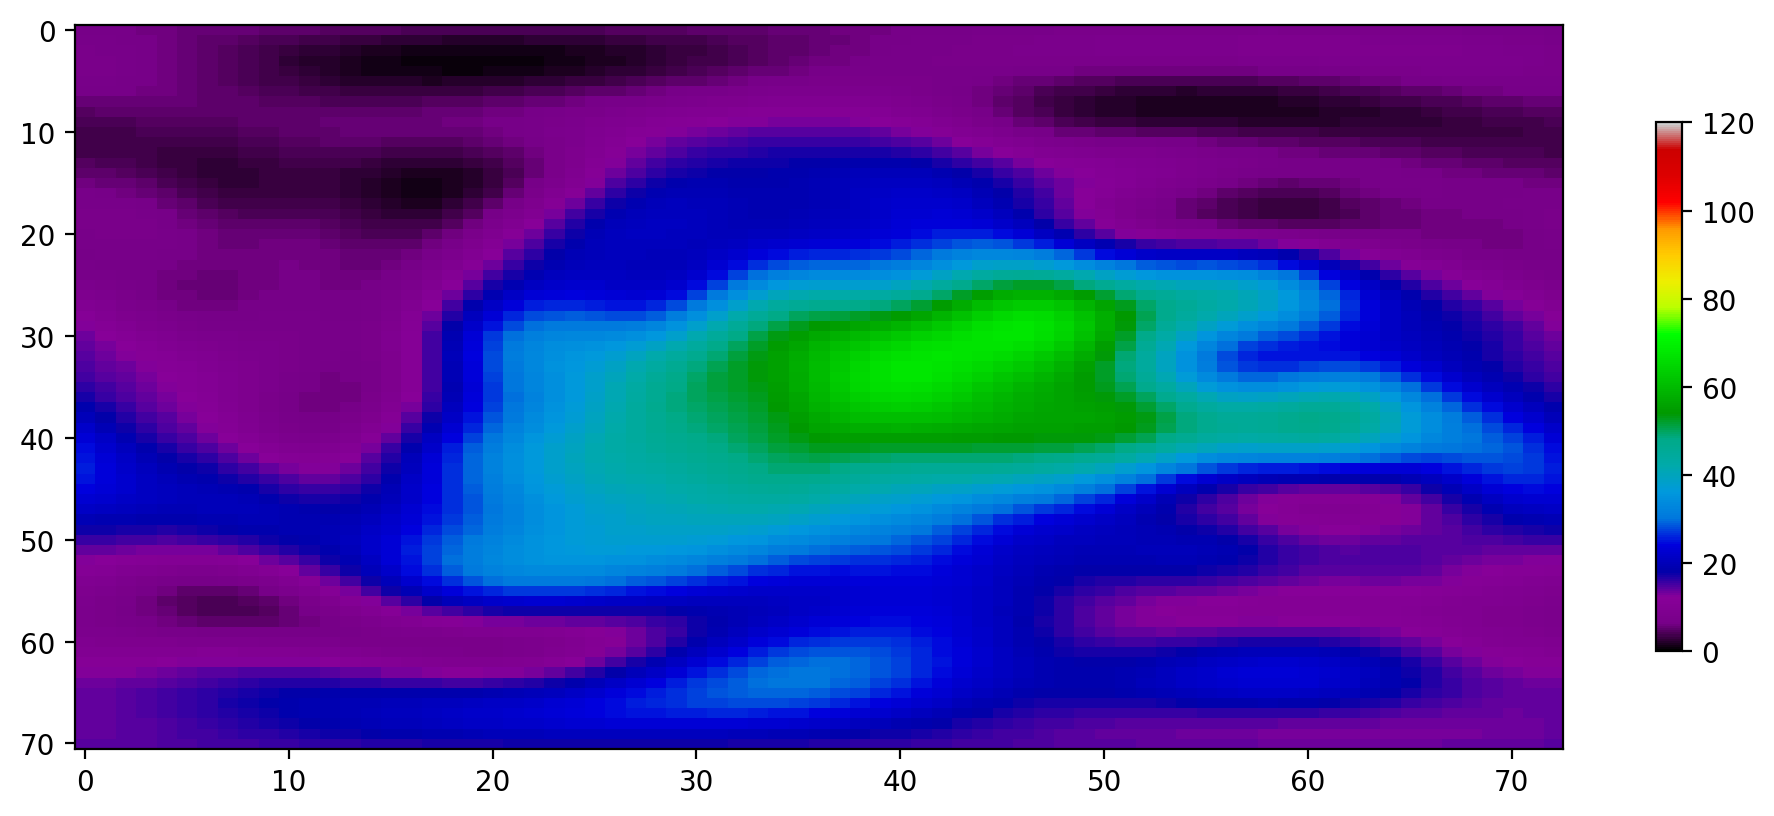

lon    -180  -175  -170  -165  -160  -155       -150       -145       -140  \
lat                                                                          
 87.5   6.4   6.3   6.1   6.0   5.8   5.6   5.500000   5.300000   5.200000   
 85.0   6.9   6.7   6.4   6.1   5.7   5.4   5.100000   4.800000   4.500000   
 82.5   7.3   7.0   6.6   6.2   5.8   5.3   4.900000   4.400000   4.000000   
 80.0   7.5   7.1   6.7   6.3   5.8   5.3   4.800000   4.300000   3.800000   
 77.5   7.3   7.1   6.7   6.3   5.9   5.4   4.900000   4.400000   3.800000   
...     ...   ...   ...   ...   ...   ...        ...        ...        ...   
-77.5  13.8  14.0  14.3  14.8  15.3  15.8  16.400000  17.000000  17.500000   
-80.0  13.7  14.0  14.3  14.7  15.2  15.7  16.200001  16.799999  17.299999   
-82.5  13.6  13.8  14.2  14.5  14.9  15.3  15.800000  16.299999  16.700001   
-85.0  13.6  13.9  14.1  14.4  14.7  15.0  15.300000  15.700000  16.000000   
-87.5  14.1  14.2  14.4  14.5  14.7  14.9  15.000000  15.200000 

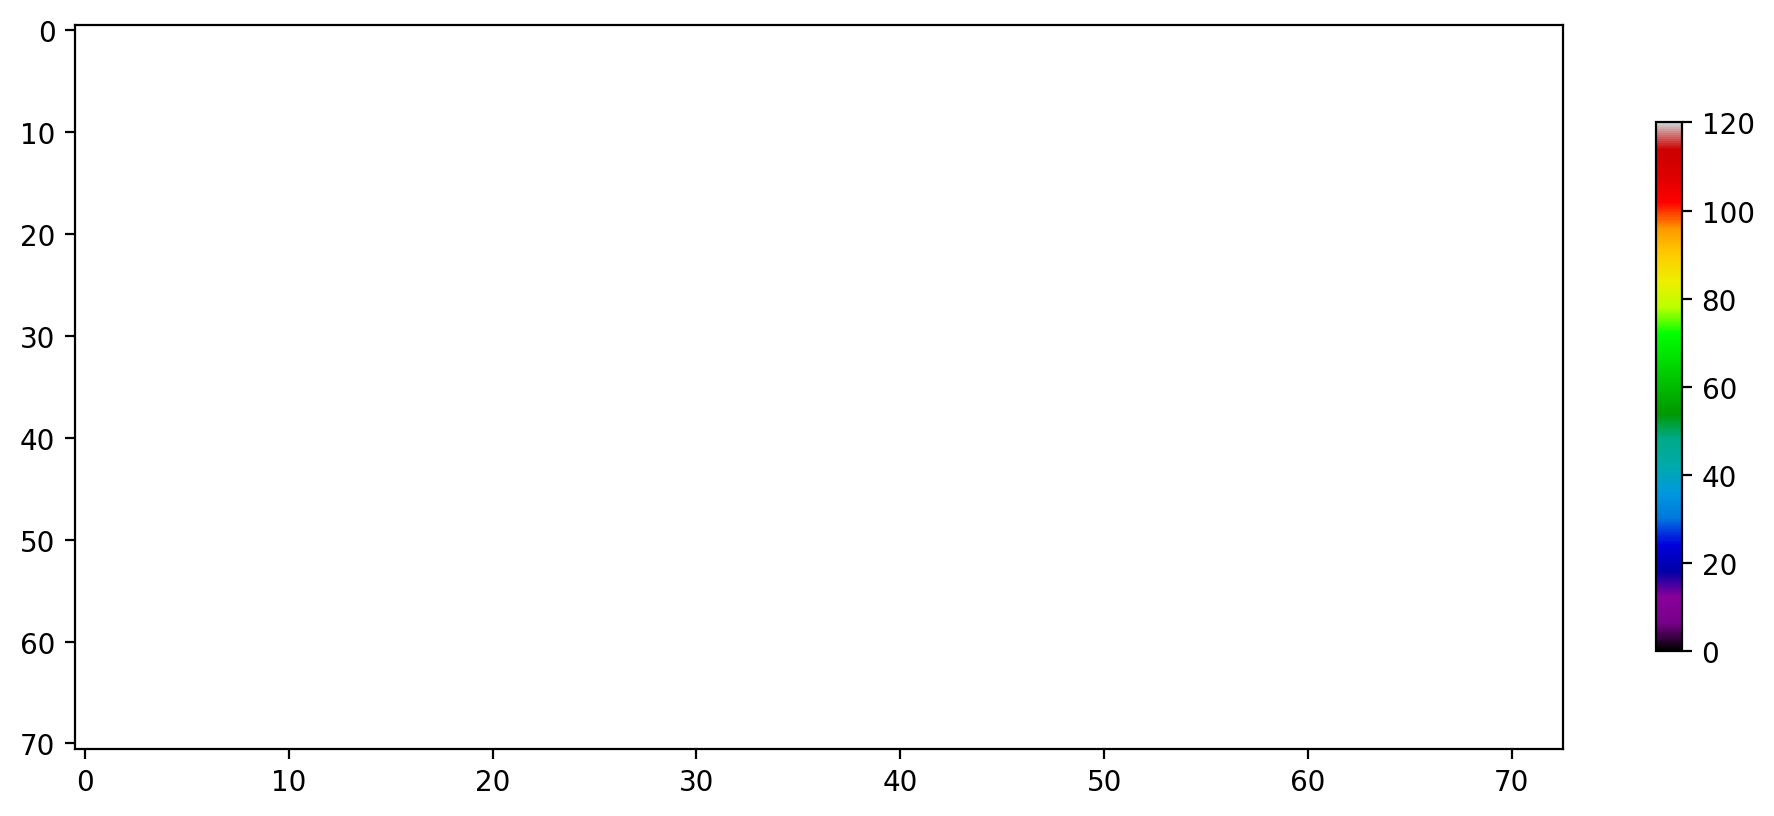

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

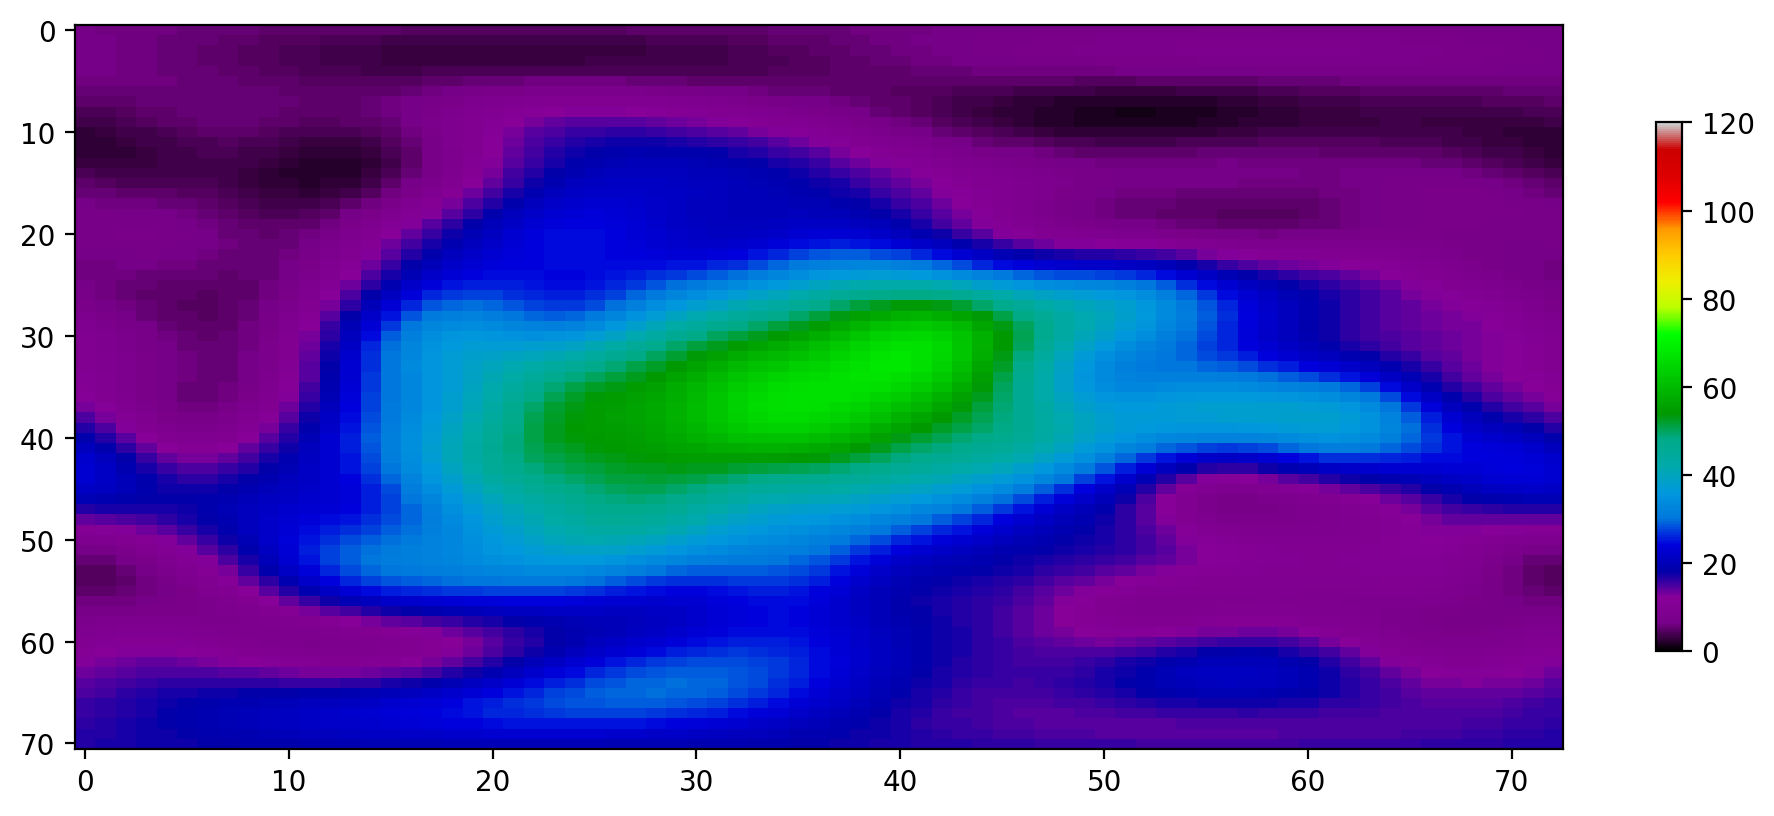

lon         -180       -175       -170       -165       -160       -155  \
lat                                                                       
 87.5   6.100000   6.000000   5.900000   5.800000   5.700000   5.600000   
 85.0   6.400000   6.200000   6.000000   5.800000   5.600000   5.400000   
 82.5   6.500000   6.300000   6.000000   5.800000   5.500000   5.300000   
 80.0   6.500000   6.300000   6.000000   5.800000   5.600000   5.300000   
 77.5   6.300000   6.100000   6.000000   5.800000   5.600000   5.400000   
...          ...        ...        ...        ...        ...        ...   
-77.5  15.500000  16.000000  16.500000  17.000000  17.500000  18.000000   
-80.0  15.900000  16.400000  16.799999  17.299999  17.900000  18.400000   
-82.5  16.200001  16.600000  17.100000  17.500000  17.900000  18.400000   
-85.0  16.500000  16.799999  17.100000  17.500000  17.799999  18.200001   
-87.5  16.799999  17.000000  17.200001  17.400000  17.600000  17.799999   

lon         -150       -

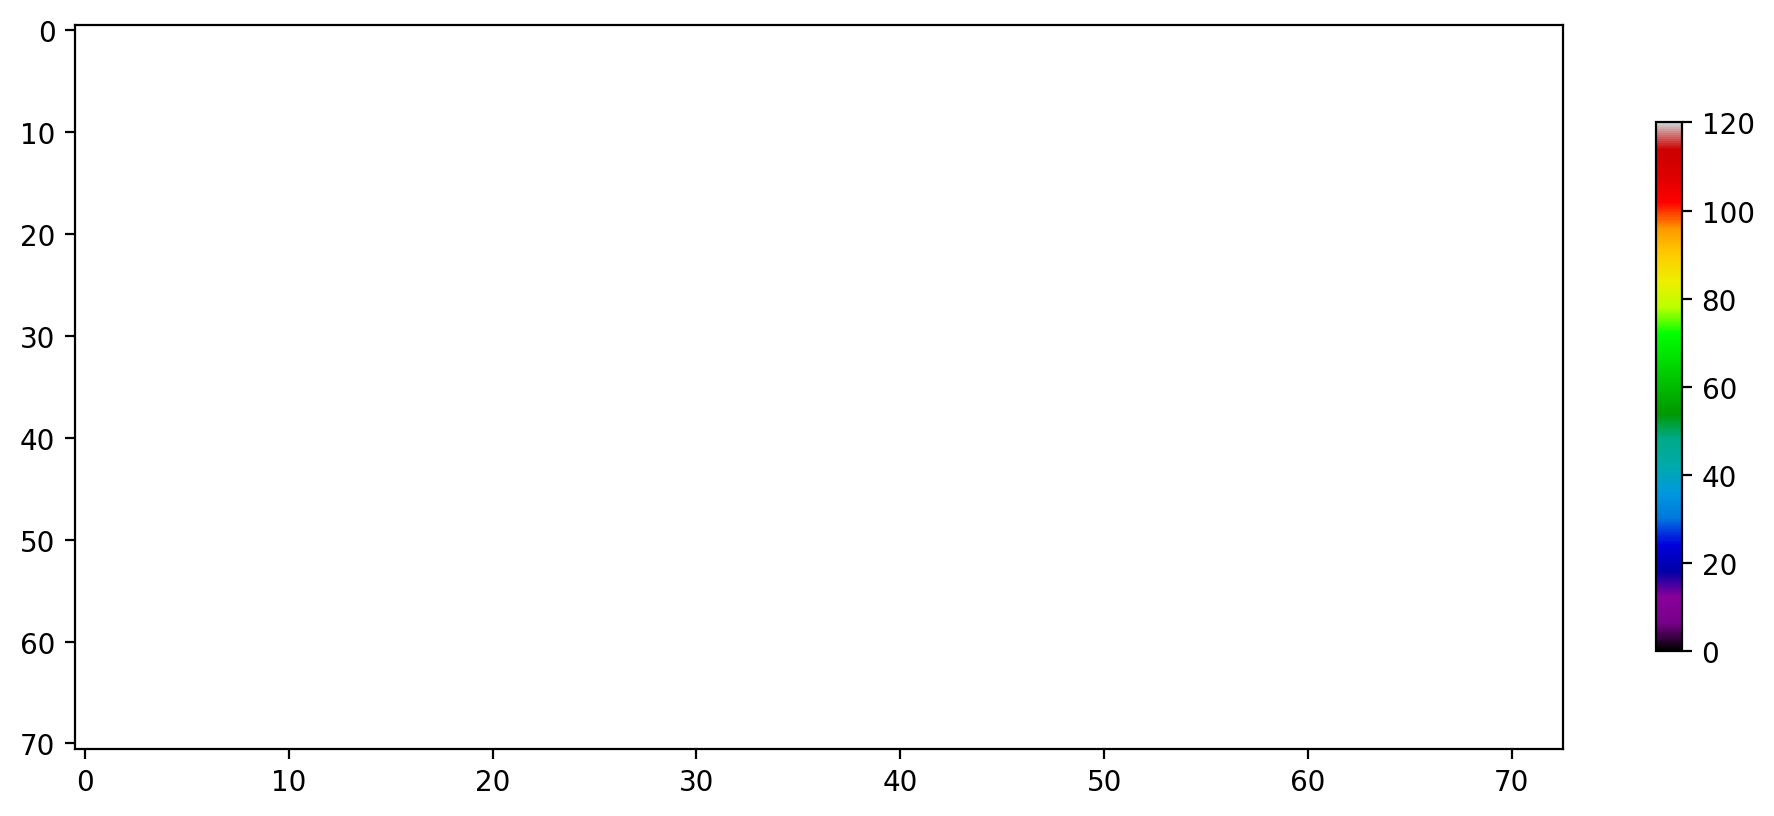

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

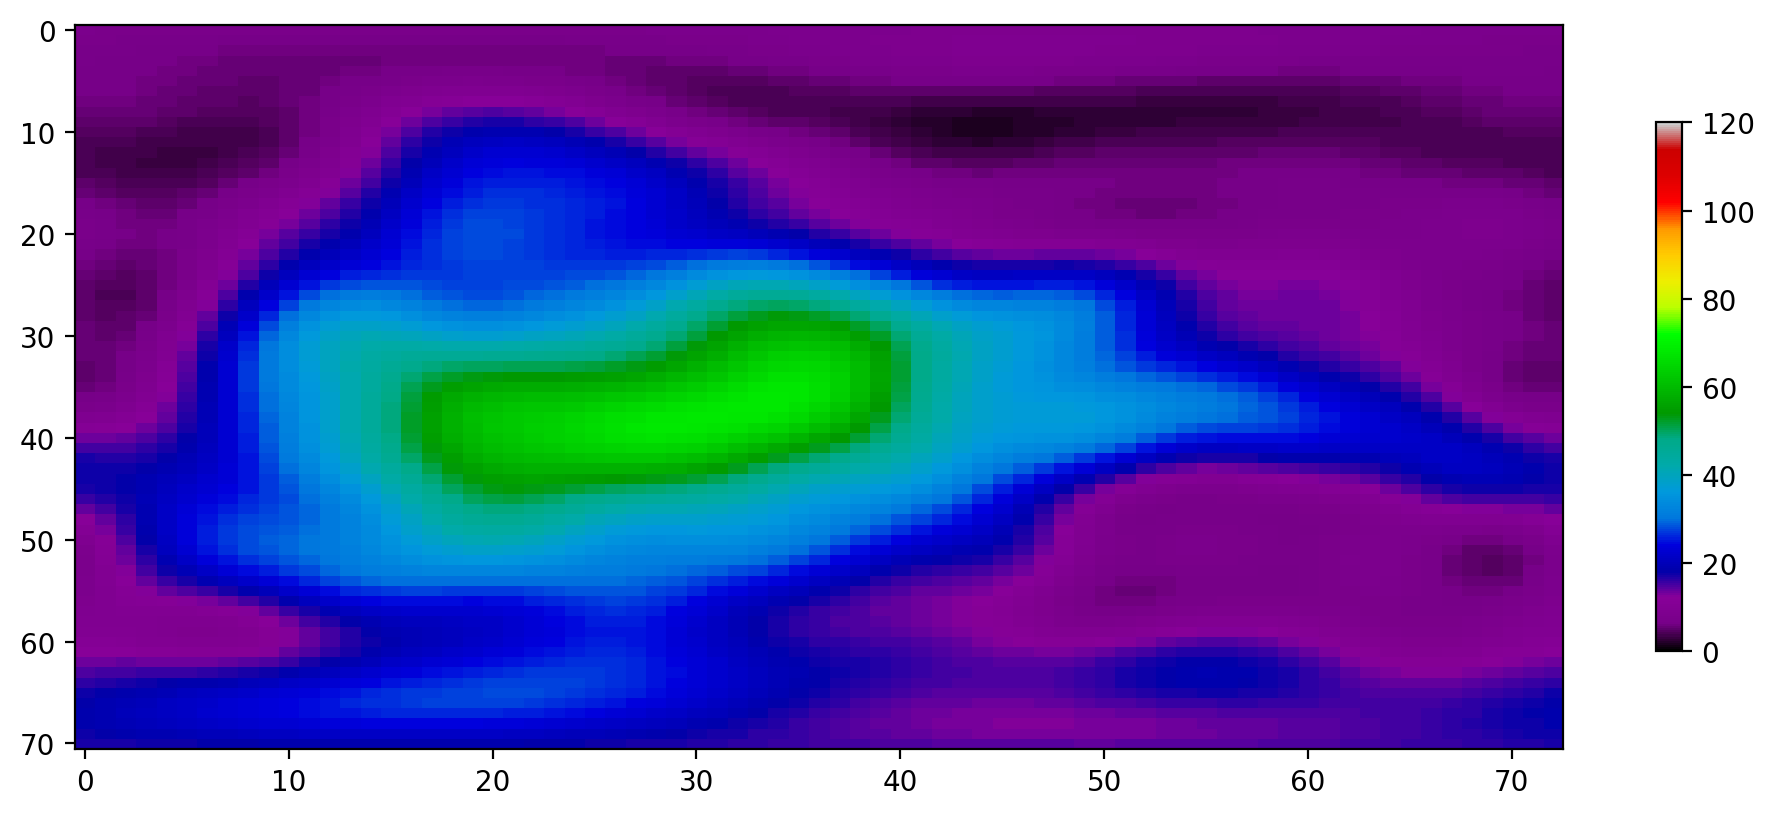

lon         -180       -175       -170       -165       -160       -155  \
lat                                                                       
 87.5   7.600000   7.500000   7.500000   7.400000   7.400000   7.300000   
 85.0   7.200000   7.100000   7.000000   6.900000   6.800000   6.700000   
 82.5   6.900000   6.700000   6.600000   6.500000   6.400000   6.200000   
 80.0   6.600000   6.500000   6.400000   6.200000   6.100000   5.900000   
 77.5   6.500000   6.400000   6.300000   6.100000   5.900000   5.700000   
...          ...        ...        ...        ...        ...        ...   
-77.5  18.200001  18.799999  19.400000  20.100000  20.700001  21.299999   
-80.0  18.500000  19.100000  19.700001  20.299999  20.900000  21.500000   
-82.5  18.299999  18.799999  19.299999  19.799999  20.299999  20.799999   
-85.0  17.700001  18.100000  18.400000  18.799999  19.200001  19.500000   
-87.5  16.900000  17.100000  17.299999  17.400000  17.600000  17.799999   

lon         -150       -

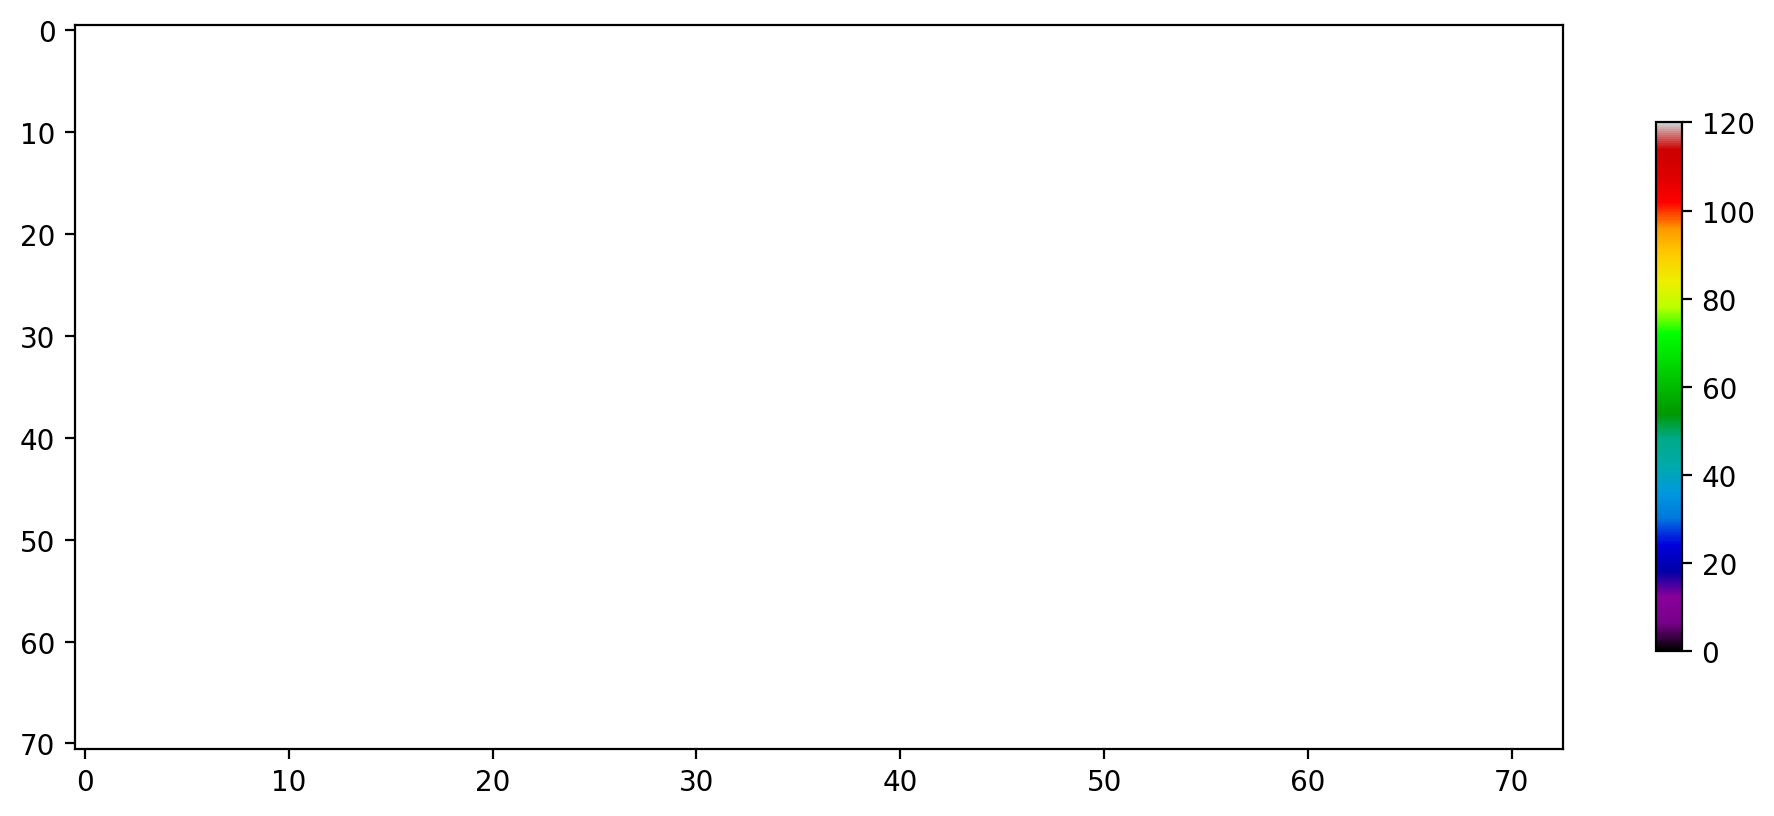

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

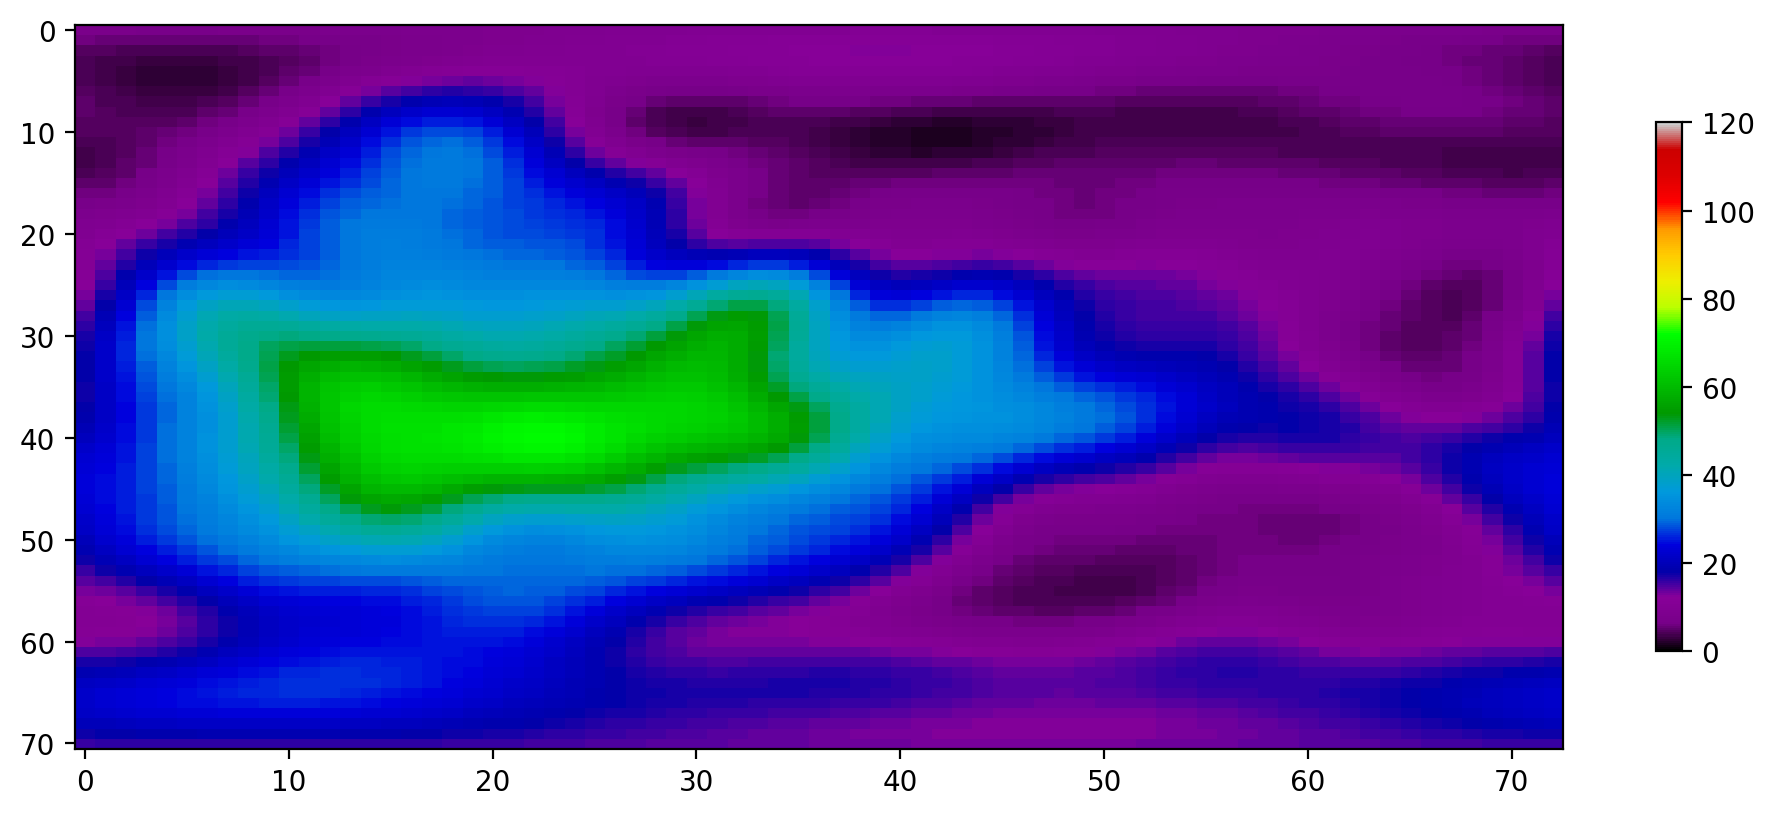

lon         -180       -175       -170       -165       -160       -155  \
lat                                                                       
 87.5   7.100000   7.100000   7.100000   7.000000   7.000000   7.000000   
 85.0   5.700000   5.600000   5.500000   5.400000   5.400000   5.400000   
 82.5   4.600000   4.400000   4.200000   4.100000   4.000000   4.000000   
 80.0   4.000000   3.700000   3.400000   3.200000   3.100000   3.100000   
 77.5   3.900000   3.500000   3.100000   2.800000   2.600000   2.600000   
...          ...        ...        ...        ...        ...        ...   
-77.5  22.000000  22.500000  23.100000  23.600000  24.000000  24.400000   
-80.0  21.200001  21.700001  22.100000  22.500000  22.900000  23.200001   
-82.5  19.700001  20.000000  20.400000  20.700001  20.900000  21.100000   
-85.0  17.799999  18.000000  18.200001  18.400000  18.600000  18.700001   
-87.5  15.900000  16.000000  16.100000  16.200001  16.299999  16.299999   

lon         -150  -145  

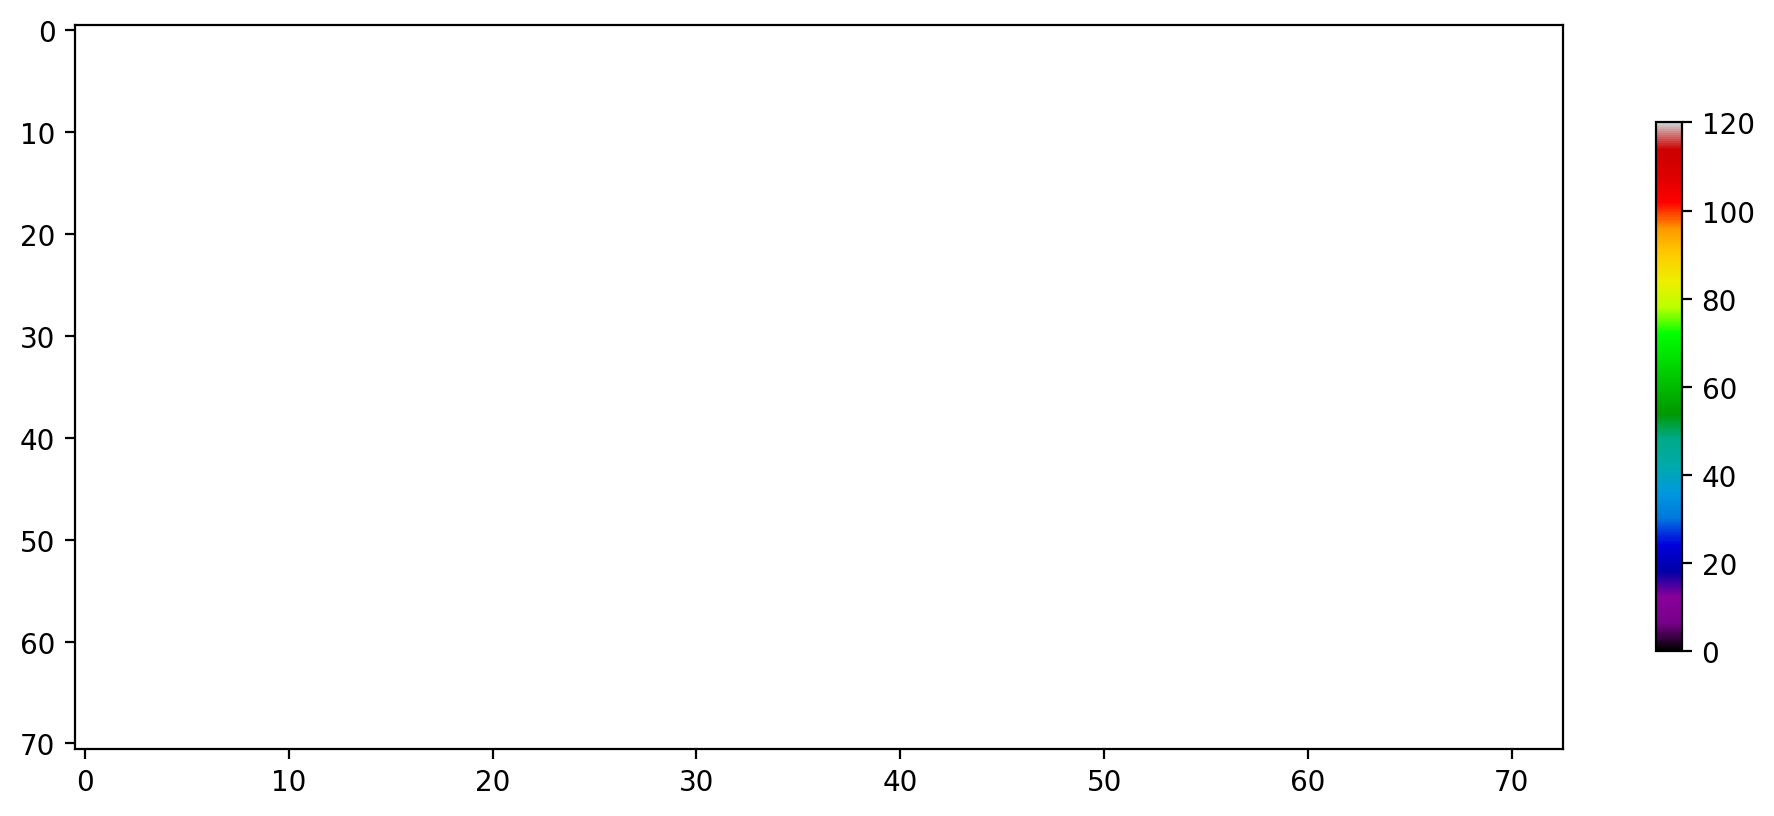

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

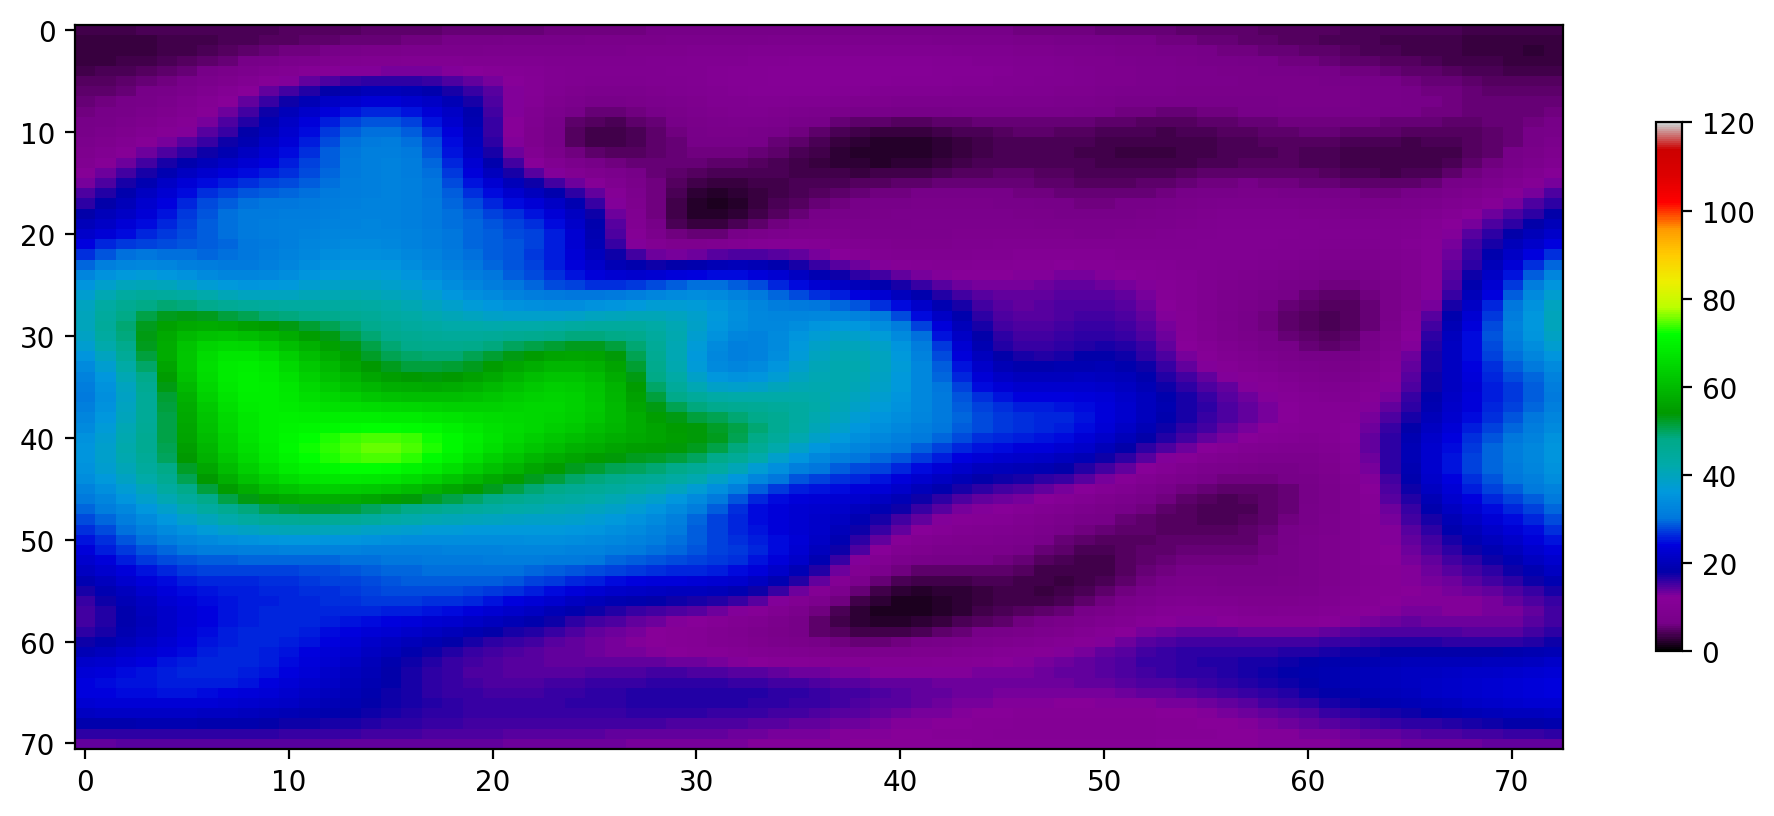

lon         -180  -175       -170       -165       -160       -155       -150  \
lat                                                                             
 87.5   3.700000   3.7   3.700000   3.800000   3.800000   3.900000   3.900000   
 85.0   3.000000   3.1   3.100000   3.200000   3.400000   3.500000   3.700000   
 82.5   2.900000   2.9   3.000000   3.200000   3.500000   3.700000   4.100000   
 80.0   3.100000   3.2   3.400000   3.700000   4.000000   4.500000   5.000000   
 77.5   3.600000   3.8   4.000000   4.400000   4.900000   5.500000   6.300000   
...          ...   ...        ...        ...        ...        ...        ...   
-77.5  22.799999  23.1  23.299999  23.400000  23.400000  23.299999  23.100000   
-80.0  20.900000  21.1  21.200001  21.299999  21.299999  21.200001  21.000000   
-82.5  18.400000  18.6  18.700001  18.799999  18.799999  18.799999  18.600000   
-85.0  16.000000  16.1  16.200001  16.299999  16.299999  16.299999  16.299999   
-87.5  13.900000  14.0  14.1

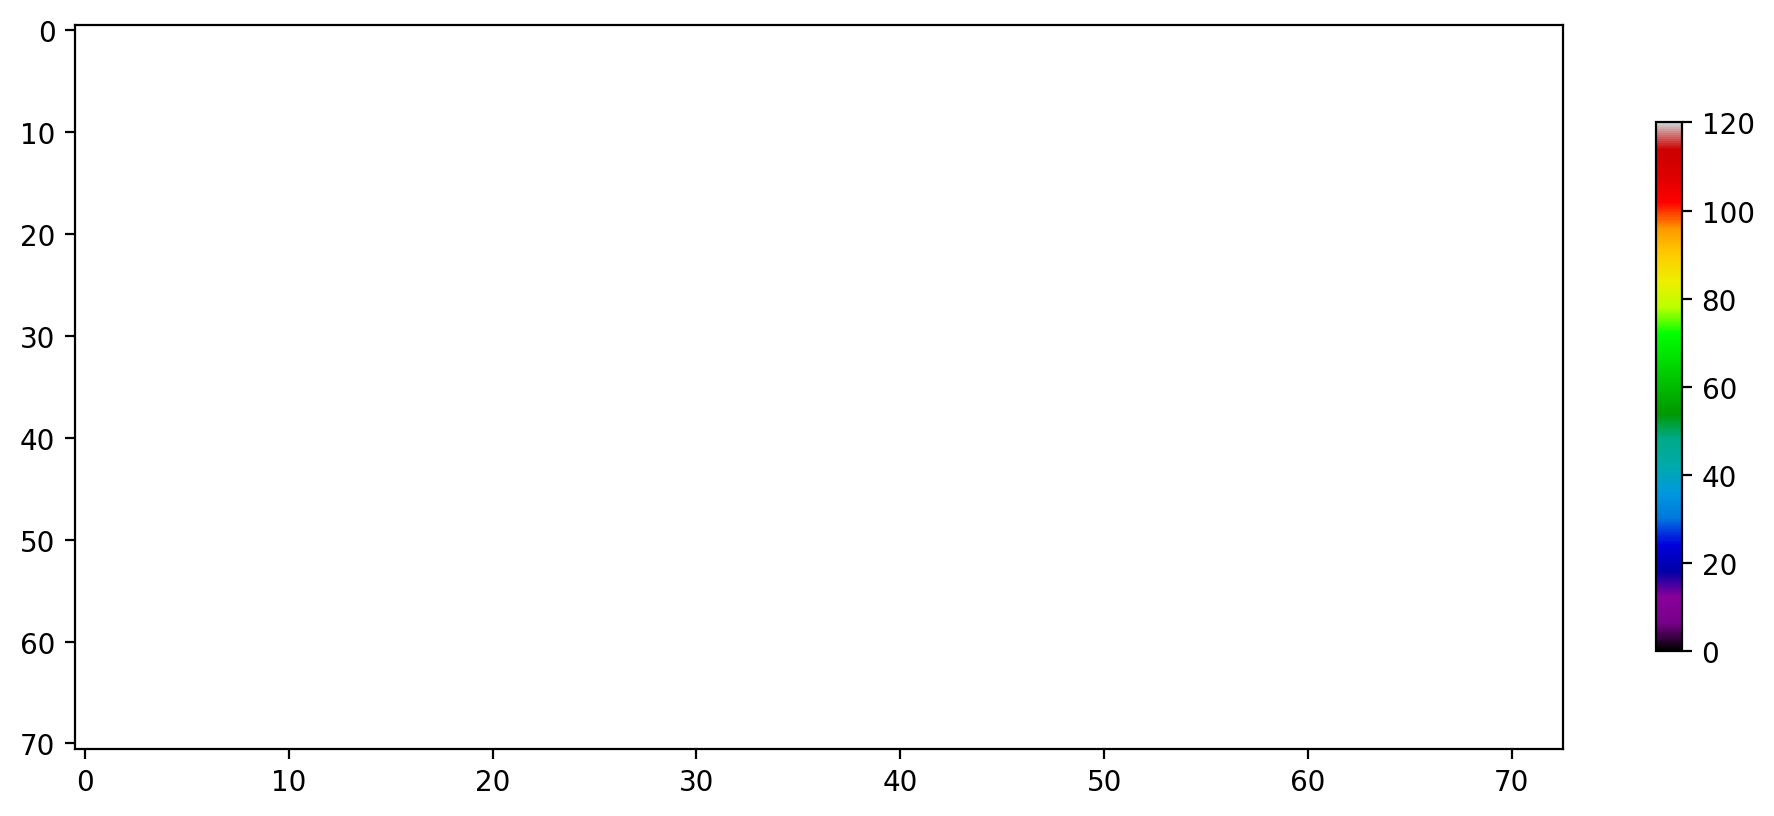

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

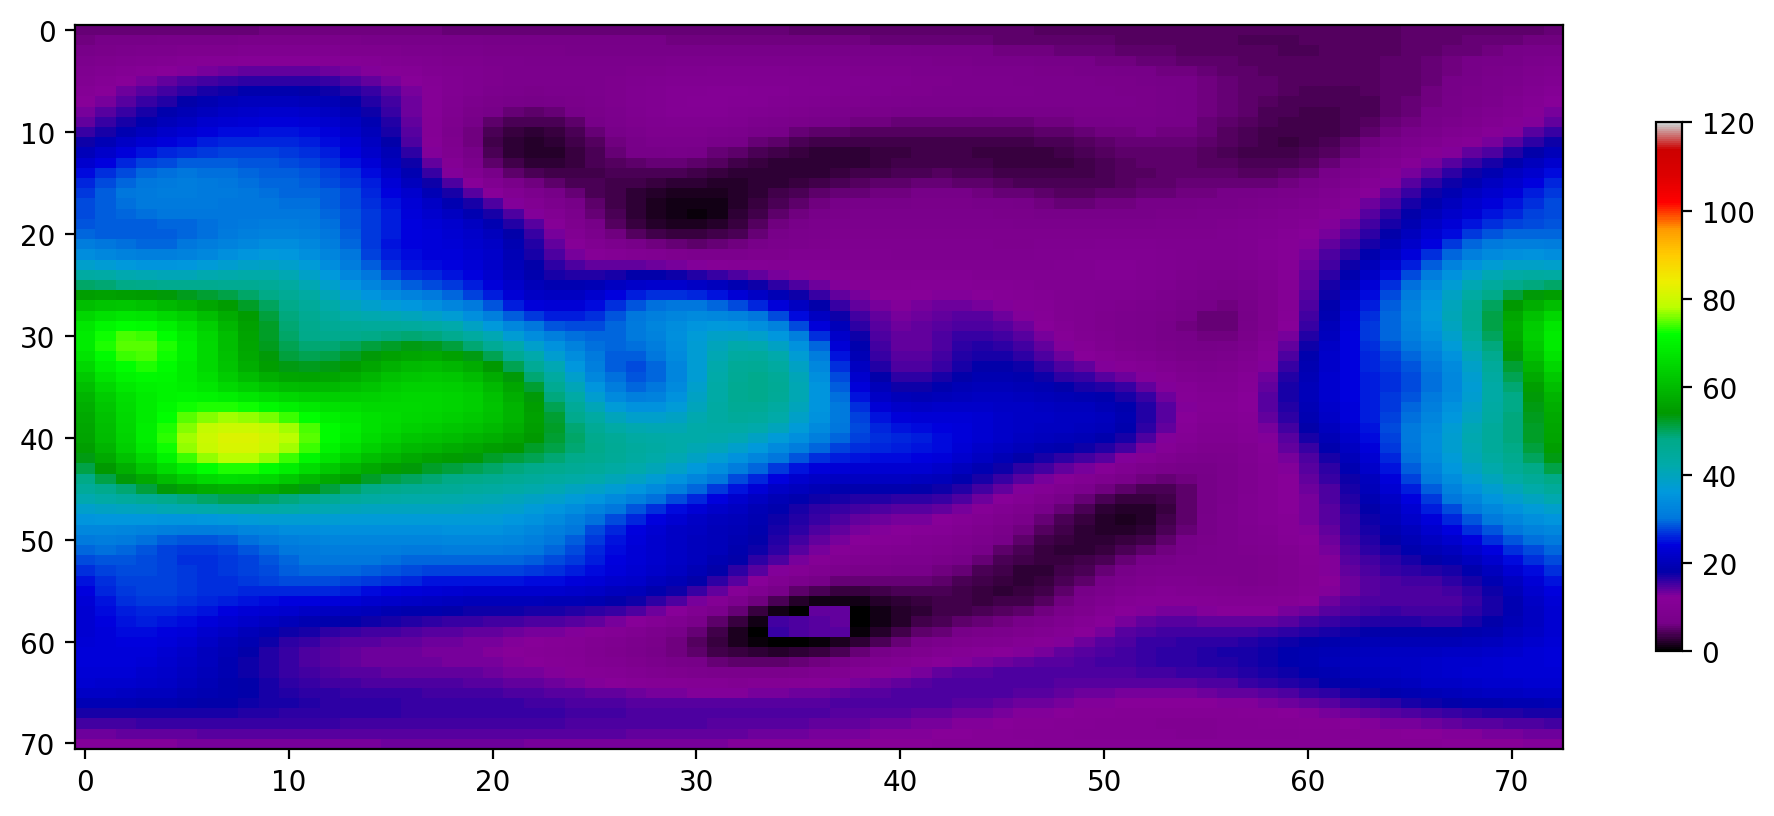

lon         -180       -175       -170       -165       -160       -155  \
lat                                                                       
 87.5   5.200000   5.200000   5.300000   5.400000   5.400000   5.500000   
 85.0   5.900000   6.100000   6.300000   6.500000   6.600000   6.800000   
 82.5   7.000000   7.300000   7.700000   8.000000   8.300000   8.500000   
 80.0   8.100000   8.600000   9.200000   9.700000  10.100000  10.600000   
 77.5   9.200000   9.900000  10.700000  11.400000  12.000000  12.600000   
...          ...        ...        ...        ...        ...        ...   
-77.5  19.299999  19.400000  19.299999  19.100000  18.900000  18.600000   
-80.0  17.200001  17.299999  17.299999  17.299999  17.299999  17.200001   
-82.5  15.100000  15.300000  15.400000  15.500000  15.500000  15.600000   
-85.0  13.400000  13.500000  13.700000  13.800000  13.900000  14.000000   
-87.5  12.300000  12.400000  12.500000  12.600000  12.600000  12.700000   

lon         -150  -145  

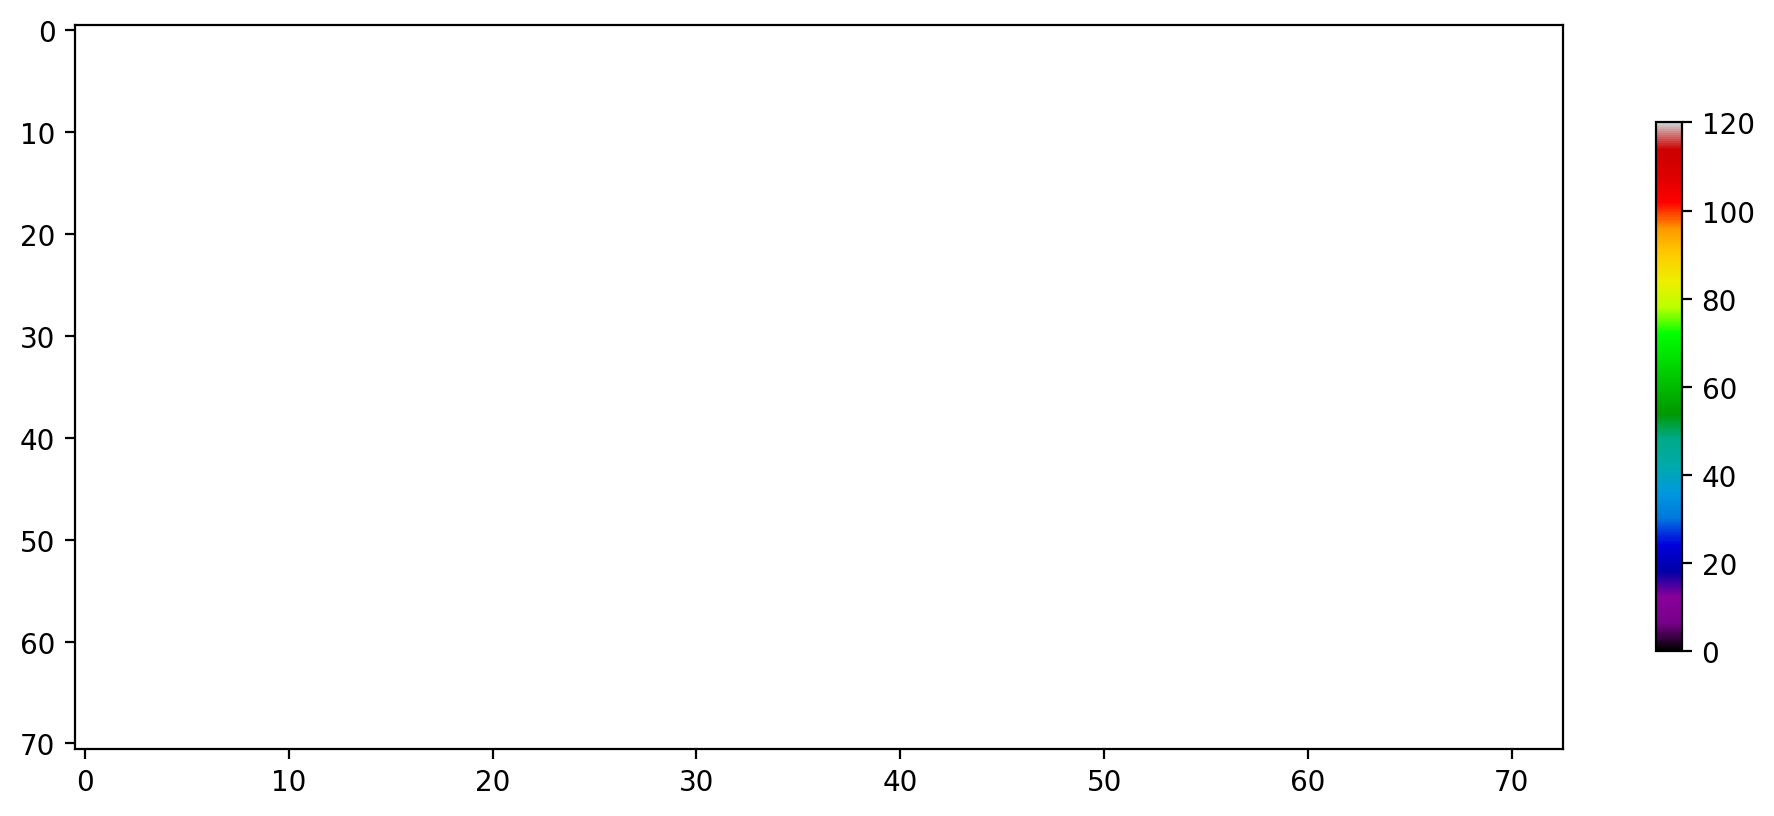

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

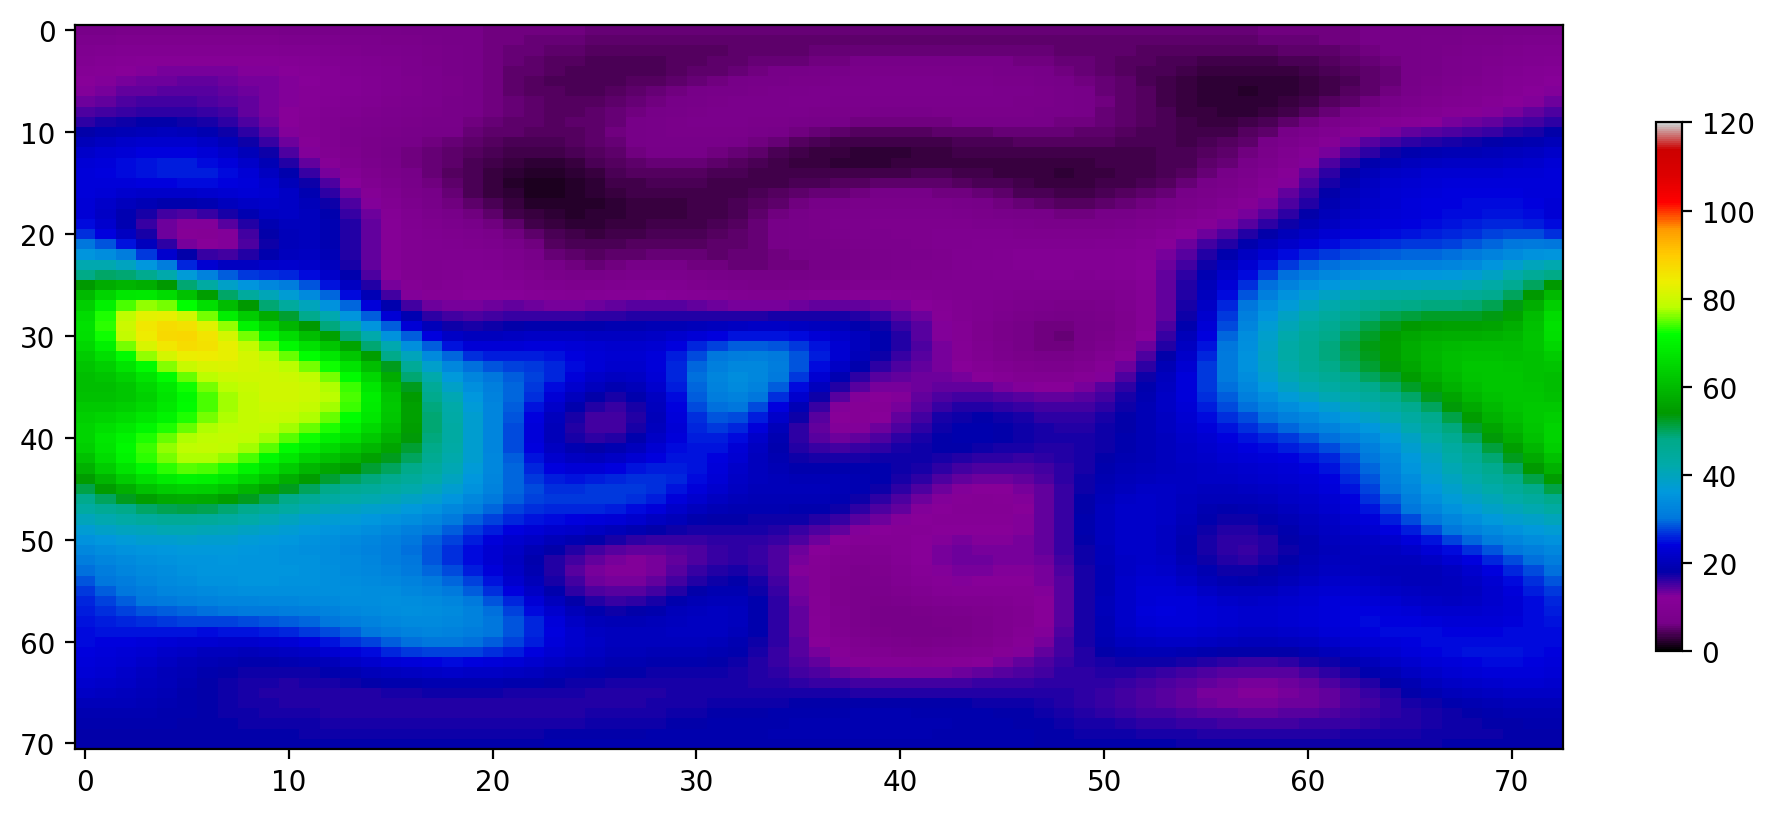

lon    -180  -175       -170       -165       -160       -155  -150  \
lat                                                                   
 87.5   7.0   7.0   7.100000   7.100000   7.100000   7.100000   7.1   
 85.0   8.2   8.3   8.500000   8.600000   8.700000   8.700000   8.7   
 82.5   9.3   9.6   9.900000  10.100000  10.200000  10.300000  10.3   
 80.0  10.3  10.7  11.100000  11.400000  11.600000  11.700000  11.7   
 77.5  11.1  11.6  12.100000  12.400000  12.700000  12.800000  12.8   
...     ...   ...        ...        ...        ...        ...   ...   
-77.5  20.1  19.9  19.700001  19.400000  19.000000  18.600000  18.1   
-80.0  19.1  19.1  19.000000  18.799999  18.600000  18.400000  18.1   
-82.5  18.4  18.4  18.400000  18.400000  18.299999  18.200001  18.1   
-85.0  18.0  18.1  18.100000  18.100000  18.100000  18.100000  18.1   
-87.5  18.0  18.0  18.100000  18.100000  18.100000  18.100000  18.1   

lon         -145       -140       -135  ...        135        140        145

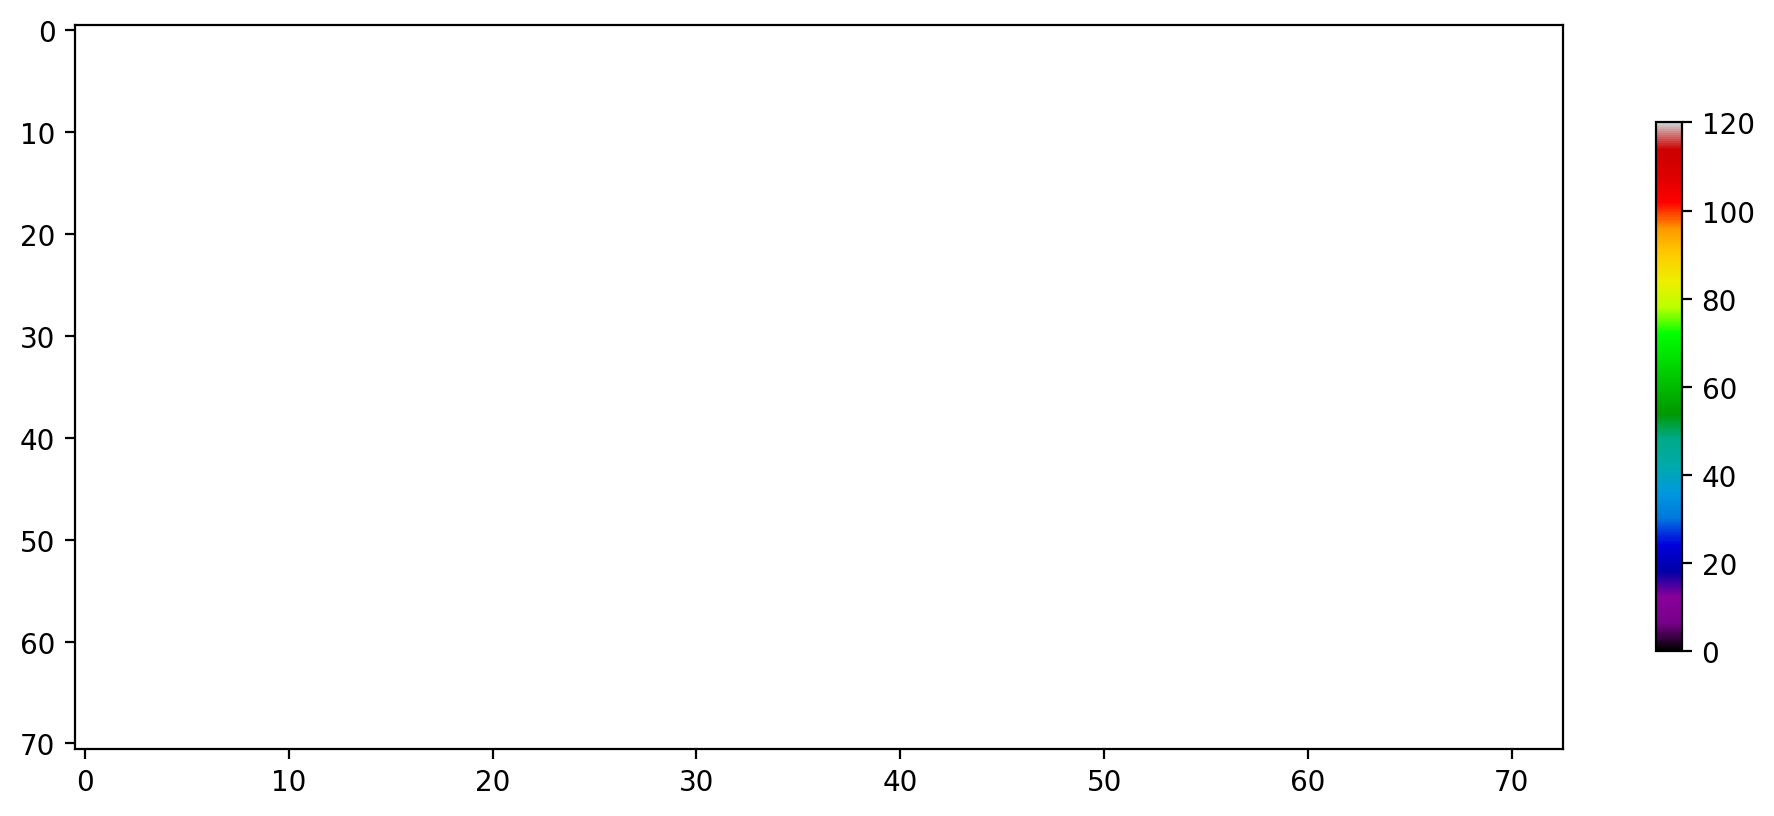

lon    -180  -175  -170  -165  -160  -155  -150  -145  -140  -135  ...   135  \
lat                                                                ...         
 87.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
 77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
-77.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-80.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-82.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-85.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
-87.5   NaN   NaN   NaN   NaN   NaN   Na

KeyboardInterrupt: 

In [317]:
from matplotlib import animation
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\2000.h5"
bounds = np.linspace(0,100,5)
df = readH5File(file)
for i in df.index:
    data = df.loc[i]
    data = data.unstack()
    data = data.sort_index(axis=0, ascending=False)
    data = data.sort_index(axis=1, ascending=True)
    fig = plt.figure(figsize=(12, 7), dpi=200)
    graph = plt.imshow(data, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
    cb = plt.colorbar(graph, shrink = 0.5)
    plt.show()
    print(data)

<IPython.core.display.Javascript object>


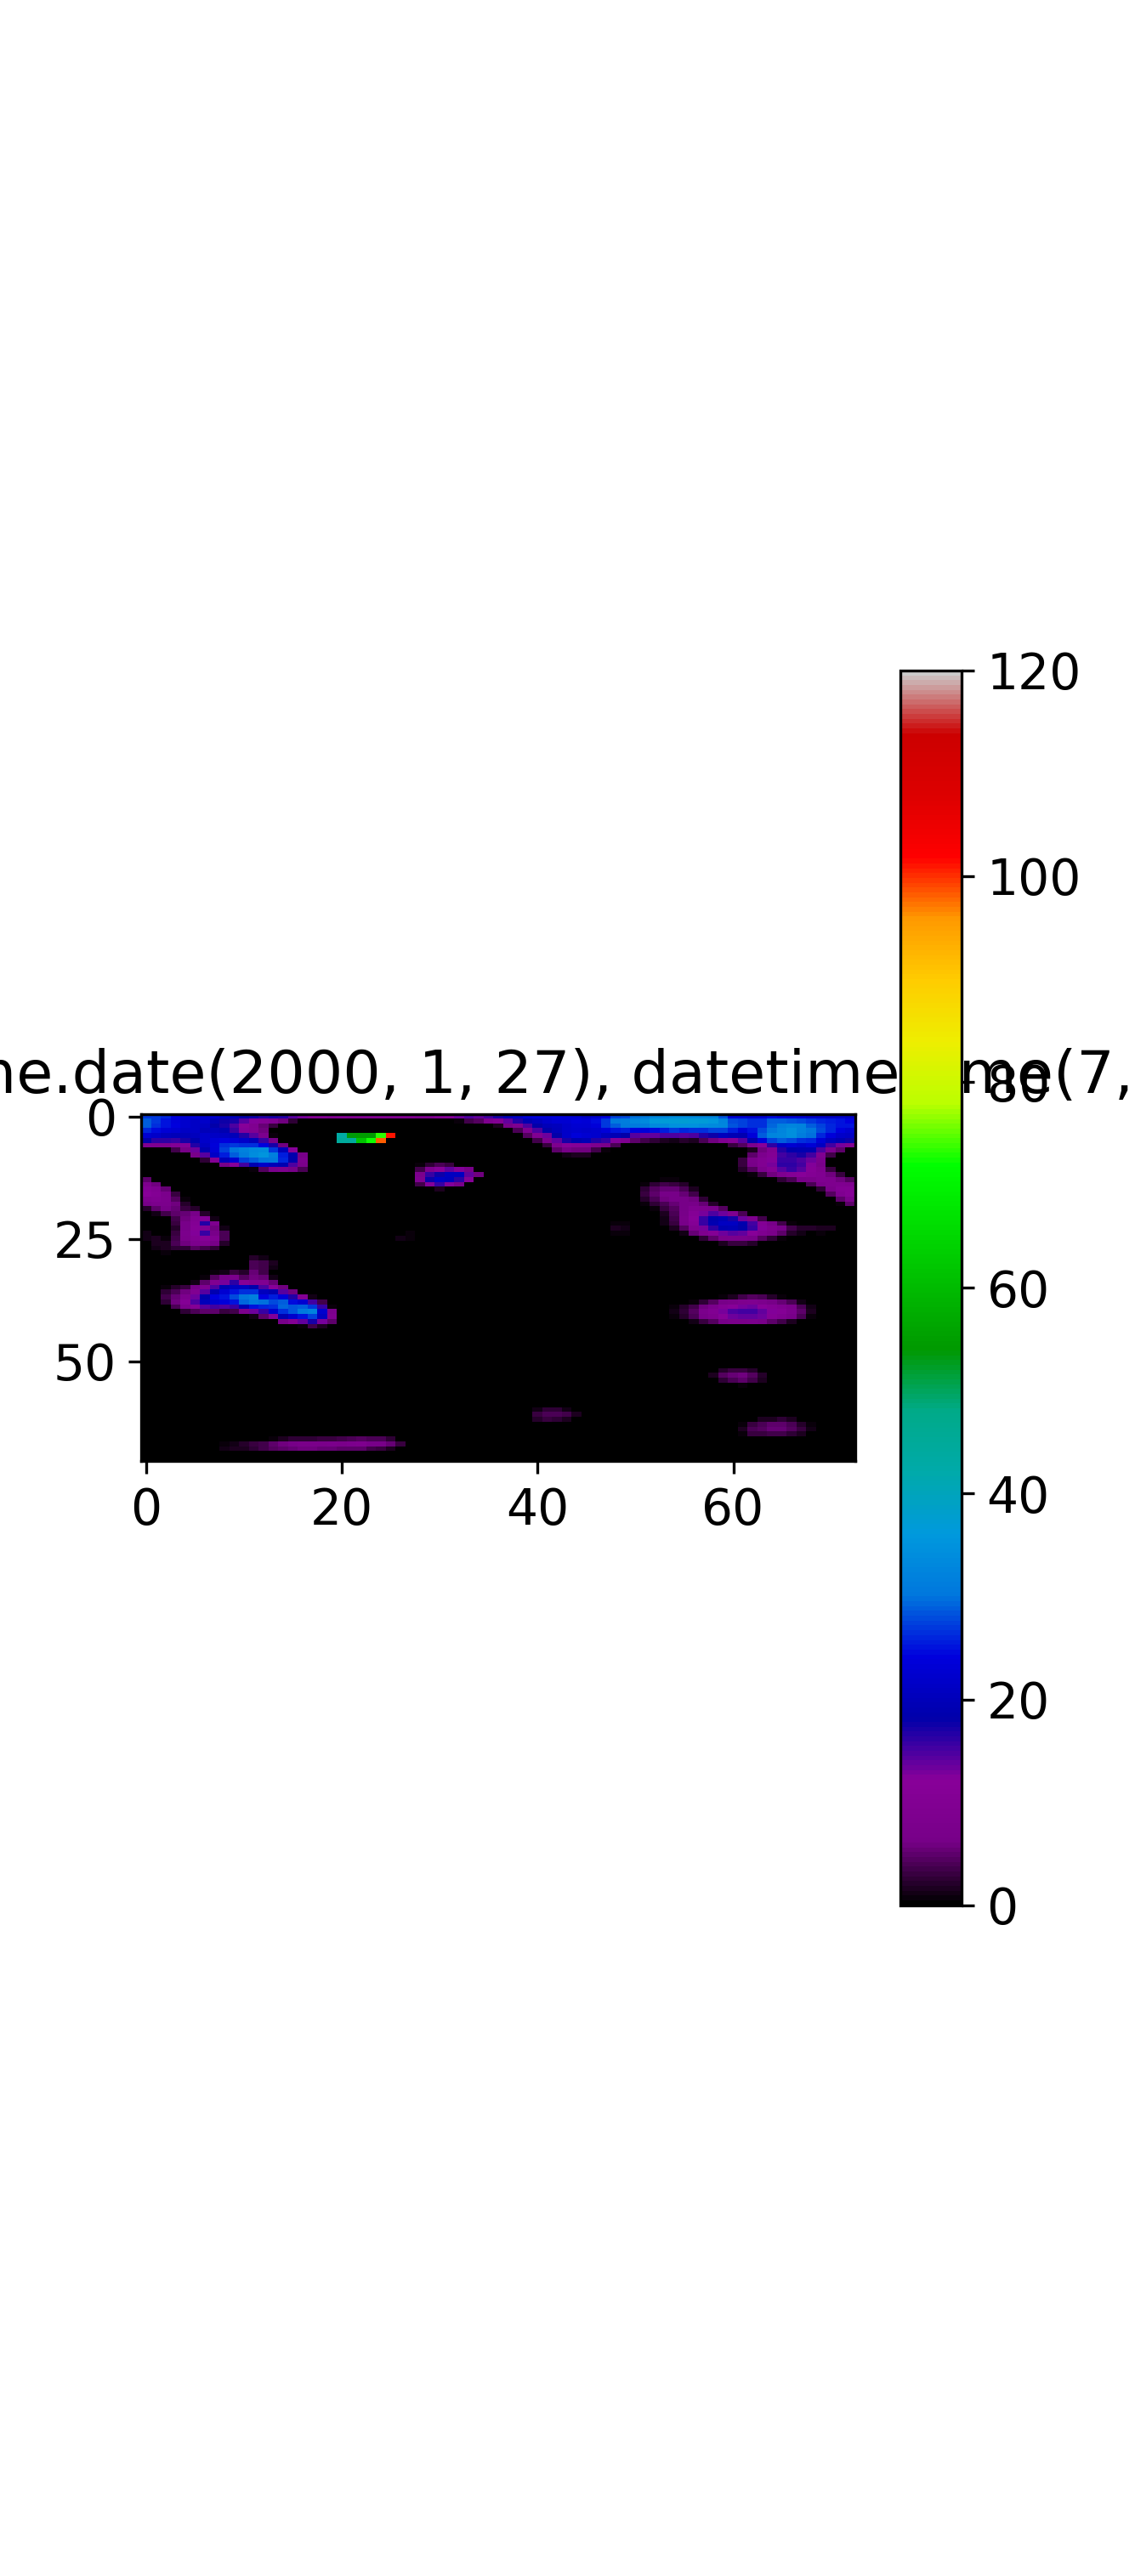

In [399]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython import display



def create_video(n):
    global X
    global df
    global index
    
    file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec\\2000.h5"
    bounds = np.linspace(0,100,5)
    df = readH5File(file)
#     print(df)
    index = df.index
    data = df.loc[index[0]]
    data = data.unstack()
    data = data.sort_index(axis=0, ascending=False)
    data = data.sort_index(axis=1, ascending=True)
    X = data
#     print(X)

    fig = plt.figure(figsize=(12, 7), dpi=200)
    im = plt.imshow(data, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
    plt.title(index[0])
    cb = plt.colorbar(im, shrink = 0.5)

    def animate(t):
        global X
        global index
        index = np.roll(index, -1, axis = 0)
        data = df.loc[index[0]]
        data = data.unstack()
        data = data.sort_index(axis=0, ascending=False)
        data = data.sort_index(axis=1, ascending=True)
        X = data
        im.set_array(X)
        plt.title(index[0])
        return im, 

    anim = FuncAnimation(
        fig,
        animate,
        frames = 100,
        interval = 1000/12,
        blit = True
    )

    plt.show()

    return anim

anim = create_video(10)
# writervideo = animation.FFMpegWriter(fps=60)
# anim.save("C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4", writer=writervideo)
# plt.close()

f = "C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4" 
writervideo = animation.FFMpegWriter(fps=60) 
anim.save(f, writer=writervideo)

lat            -87.5     -85.0     -82.5     -80.0     -77.5     -75.0  \
date                                                                     
1997-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  4.325590  4.017030  3.367961  3.315891  4.758659  6.430731   
2020-12-28 -5.481128 -6.244233 -7.098475 -7.774390 -6.757711 -4.928879   
2020-12-29 -2.977550 -3.361446 -4.468311 -4.795175 -3.395730 -1.622377   
2020-12-30 -7.283525 -7.804430 -8.569702 -8.582900 -7.884720 -6.967479   
2020-12-31  0.191344 -0.123766 -0.696799 -1.835044 -2.221168 -1.449542   

lat            -72.5     -70.0     -6

<IPython.core.display.Javascript object>


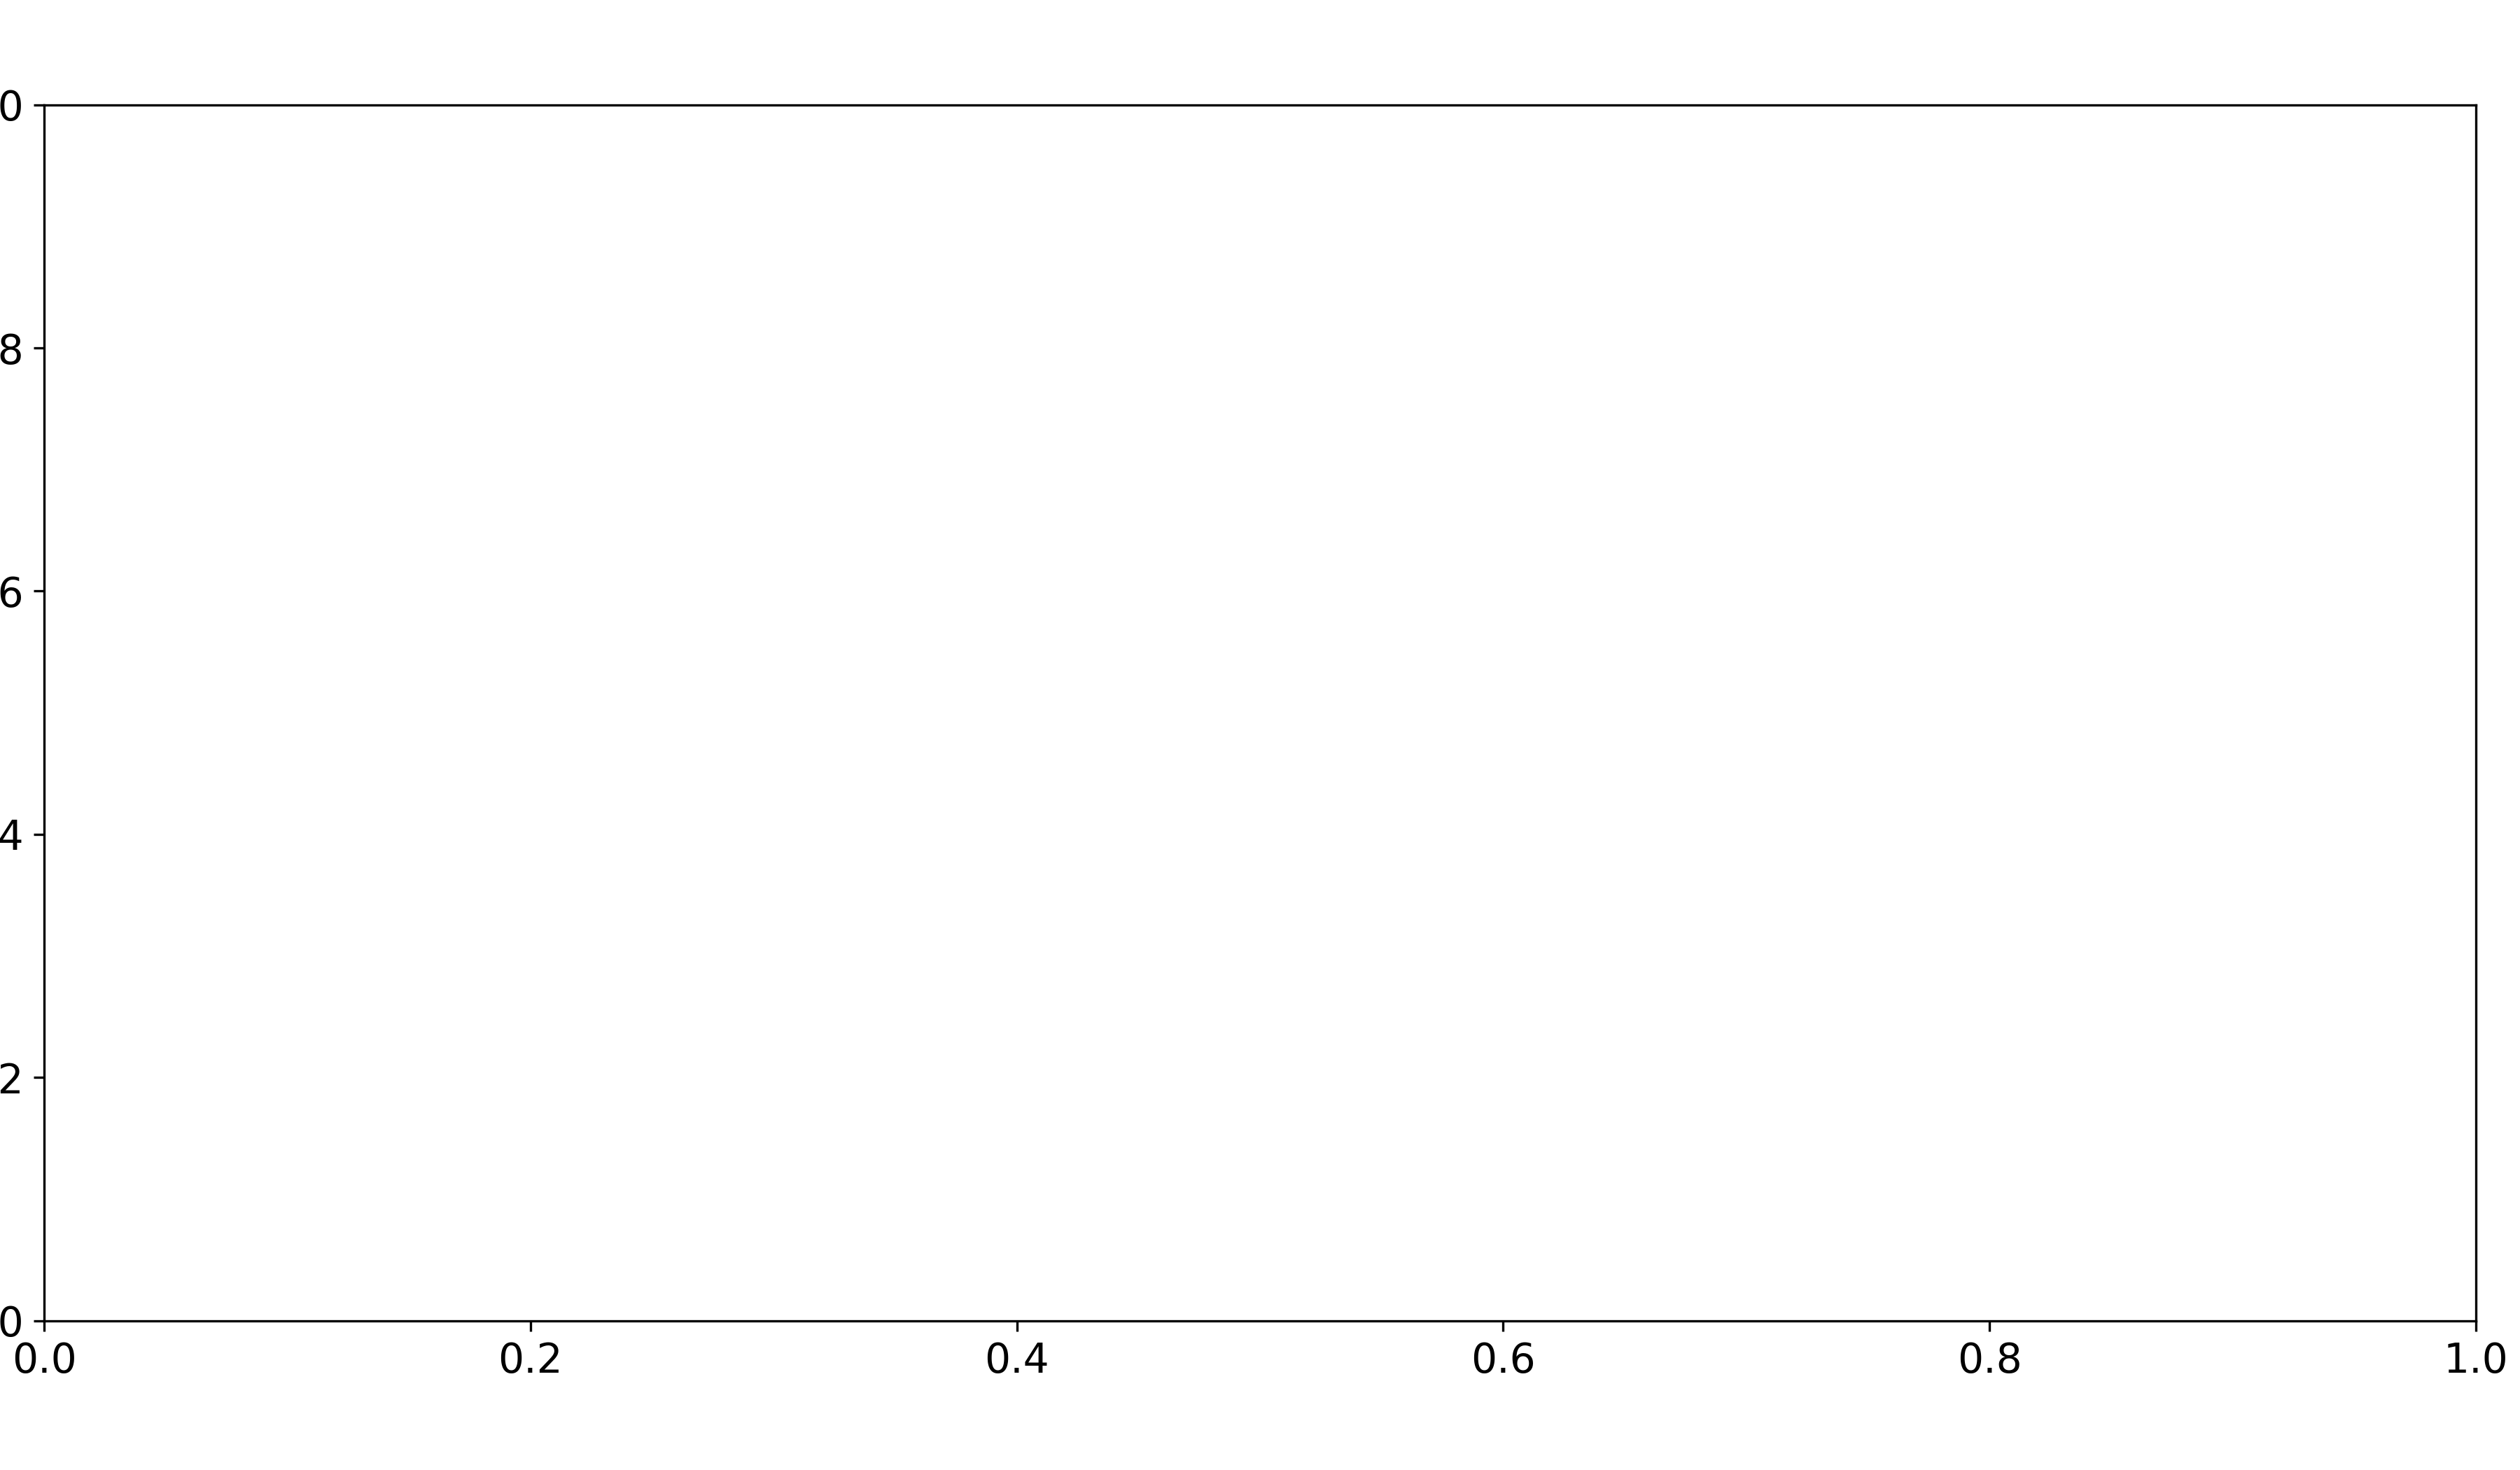

TypeError: Invalid shape (71,) for image data

In [404]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython import display



def create_video(n):
    global X
    global df
    global index
    
    file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
    bounds = np.linspace(0,100,5)
    df = readH5File(file)
    print(df)
    index = df.index
    data = df.loc[index[0]]
#     data = data.unstack()
    data = data.sort_index(axis=0, ascending=False)
#     data = data.sort_index(axis=1, ascending=True)
    X = data
#     print(X)

    fig = plt.figure(figsize=(12, 7), dpi=200)
    im = plt.imshow(data, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
    plt.title(index[0])
    cb = plt.colorbar(im, shrink = 0.5)

    def animate(t):
        global X
        global index
        index = np.roll(index, -1, axis = 0)
        data = df.loc[index[0]]
#         data = data.unstack()
        data = data.sort_index(axis=0, ascending=False)
#         data = data.sort_index(axis=1, ascending=True)
        X = data
        im.set_array(X)
        plt.title(index[0])
        return im, 

    anim = FuncAnimation(
        fig,
        animate,
        frames = 100,
        interval = 1000/12,
        blit = True
    )

    plt.show()

    return anim

anim = create_video(10)
# writervideo = animation.FFMpegWriter(fps=60)
# anim.save("C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4", writer=writervideo)
# plt.close()

# f = "C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4" 
# writervideo = animation.FFMpegWriter(fps=60) 
# anim.save(f, writer=writervideo)

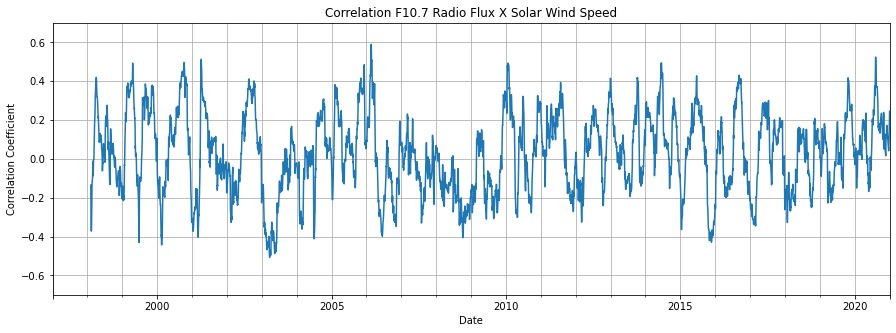

In [287]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
sws_f10_corr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\f10_7_sws\\f10_7_sws.h5"
sws_f10_corr_og_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\f10_7_sws_og\\f10_7_sws_og.h5"


f10_7_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"



f10_7 = readH5File(f10_7_file)
sws = readH5File(sws_file)

crossCorr = f10_7['f10_7'].rolling(90).corr(sws['sws'])






corr_sws_f10_7_og = readH5File(sws_f10_corr_og_file)
ax = corr_sws_f10_7_og.plot(figsize=(15,5))
ax.grid('on', which='minor')
ax.grid('off', which='major')
ax.set_ylim(-0.7,0.7)
plt.title('Correlation F10.7 Radio Flux X Solar Wind Speed')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.savefig('Correlation F10.7 Radio Flux X Solar Wind Speed.png', dpi=300)
plt.show()








C:\Users\davi_fr\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


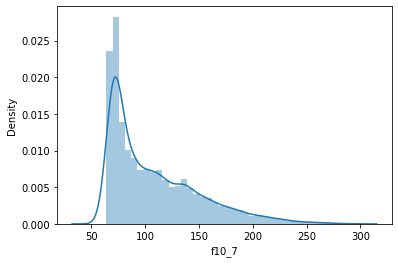

C:\Users\davi_fr\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


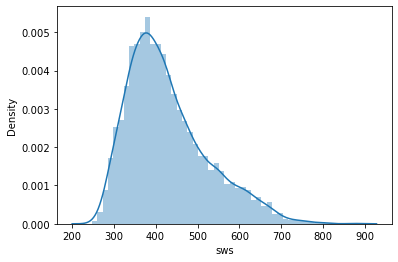

In [290]:
import seaborn as scb
# print(sws['sws'])
scb.distplot(f10_7['f10_7'])
plt.show()
scb.distplot(sws['sws'])
plt.show()

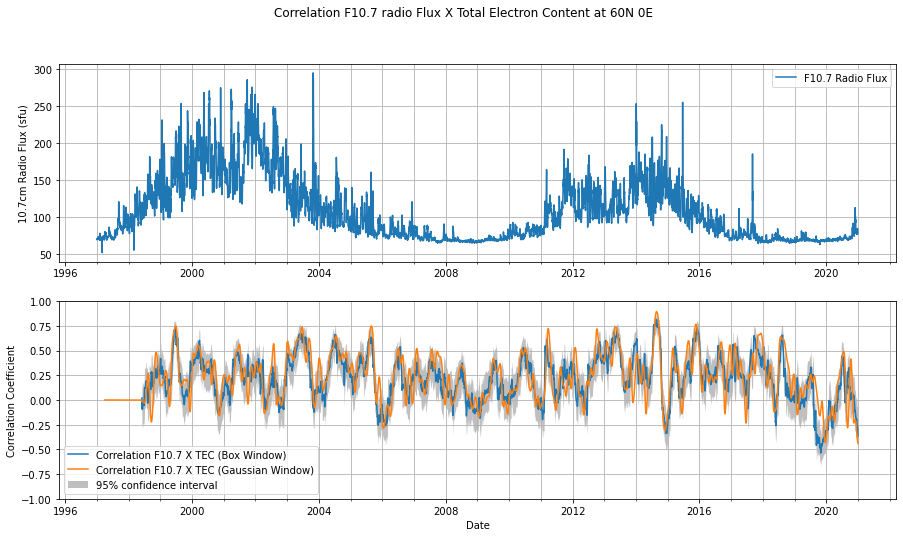

In [223]:

tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_f10_7_location_60_0\\tec_f10_7_location_60_0.h5"
tec_f10_7_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_f10_7_location_60_0\\tec_f10_7_location_60_0.h5"
tec_f10_7_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7_location_60_0\\conf_int_corr_tec_f10_7_location_60_0_lowerConfInterval.h5"
tec_f10_7_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7_location_60_0\\conf_int_corr_tec_f10_7_location_60_0_upperConfInterval.h5"

tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
tec_f10_7_norm_corrr = readH5File(tec_f10_7_norm_corrr_file)
tec_f10_7_corrr_lowerLimit = readH5File(tec_f10_7_corrr_lowerLimitFile)
tec_f10_7_corrr_upperLimit = readH5File(tec_f10_7_corrr_upperLimitFile)

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at 60N 0E')
fig.set_size_inches(15, 8)
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)

axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_f10_7_corrr, label='Correlation F10.7 X TEC (Box Window)')
axs[1].plot(tec_f10_7_norm_corrr, label='Correlation F10.7 X TEC (Gaussian Window)')
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_f10_7_corrr_lowerLimit.index
                
yAxisLower = tec_f10_7_corrr_lowerLimit[(60,0)]
yAxisUpper = tec_f10_7_corrr_upperLimit[(60,0)]
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')

axs[1].legend()
axs[0].legend()       
plt.savefig('Correlation F10.7 radio Flux X Total Electron Content at 60N 0E.png', dpi=300)
plt.show()


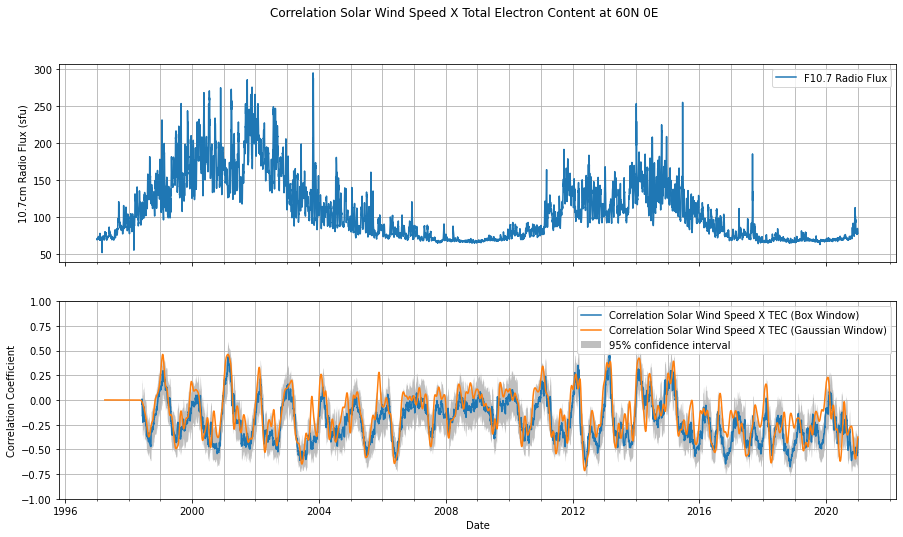

In [224]:





tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_sws_location_60_0\\tec_sws_location_60_0.h5"
tec_sws_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_sws_location_60_0\\tec_sws_location_60_0.h5"
tec_sws_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws_location_60_0\\conf_int_corr_tec_sws_location_60_0_lowerConfInterval.h5"
tec_sws_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws_location_60_0\\conf_int_corr_tec_sws_location_60_0_upperConfInterval.h5"

tec_sws_corrr = readH5File(tec_sws_corrr_file)
tec_sws_norm_corrr = readH5File(tec_sws_norm_corrr_file)
tec_sws_corrr_lowerLimit = readH5File(tec_sws_corrr_lowerLimitFile)
tec_sws_corrr_upperLimit = readH5File(tec_sws_corrr_upperLimitFile)


fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 60N 0E')
fig.set_size_inches(15, 8)

axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_corrr, label='Correlation Solar Wind Speed X TEC (Box Window)')
axs[1].plot(tec_sws_norm_corrr, label='Correlation Solar Wind Speed X TEC (Gaussian Window)')


axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_sws_corrr_lowerLimit.index
                
yAxisLower = tec_sws_corrr_lowerLimit[(60,0)]
yAxisUpper = tec_sws_corrr_upperLimit[(60,0)]
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')


axs[1].legend()
axs[0].legend()   
plt.savefig('Correlation Solar Wind Speed X Total Electron Content at 60N 0E.png', dpi=300)
plt.show()

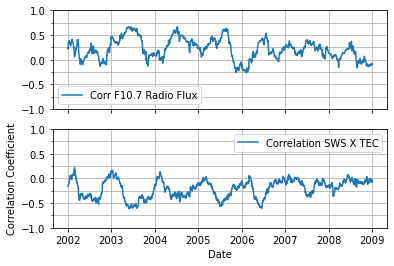

In [174]:
tec_sws_2002_2008 = tec_sws_corrr[(tec_sws_corrr.index.get_level_values('date') >= pd.to_datetime('01-01-2002').date()) & 
                                  (tec_sws_corrr.index.get_level_values('date') <= pd.to_datetime('31-12-2008').date())]

tec_f10_2002_2008 = tec_f10_7_corrr[(tec_f10_7_corrr.index.get_level_values('date') >= pd.to_datetime('01-01-2002').date()) & 
                                  (tec_f10_7_corrr.index.get_level_values('date') <= pd.to_datetime('31-12-2008').date())]



fig, axs = plt.subplots(2, sharex=True)
# fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at 60N')
fig.set_size_inches(6, 4)

axs[0].plot(tec_f10_2002_2008, label='Corr F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
# axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_2002_2008, label='Correlation SWS X TEC')
# axs[1].plot(tec_f10_7_norm_corrr, label='Correlation F10.7 X TEC (Gaussian Window)')
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
# axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)
axs[0].set_ylim(-1,1)
axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axs[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# xAxis = tec_f10_7_corrr_lowerLimit.index
                
# yAxisLower = tec_f10_7_corrr_lowerLimit[(60,0)]
# yAxisUpper = tec_f10_7_corrr_upperLimit[(60,0)]
# axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
# axs[0].set_ylabel('10.7cm Radio Flux (sfu)')

axs[1].legend()
axs[0].legend()       
plt.savefig('Correlation at 60N 2002 2008.png', dpi=300)
plt.show()

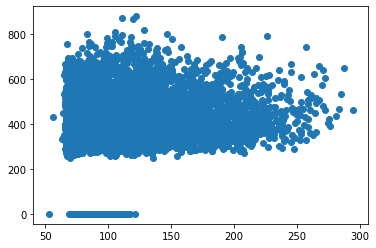

In [130]:
f10_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"

f10 = readH5File(f10_file)
sws = readH5File(sws_file)

f10 = f10.fillna(0)
sws = sws.fillna(0)
# print(f10)
# print(sws)
# m, b = np.polyfit(f10['f10_7'], sws['sws'], 1)
plt.scatter(f10['f10_7'], sws['sws'])

# plt.plot(f10['f10_7'], m*f10['f10_7']+b, color="red")
# plt.plot(sws['sws'], m*sws['sws']+b, color="yellow")
plt.show()


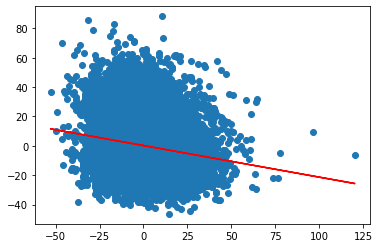

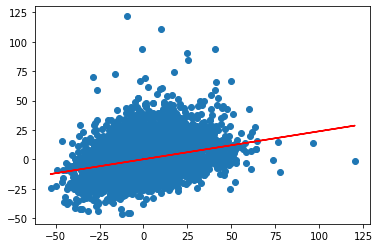

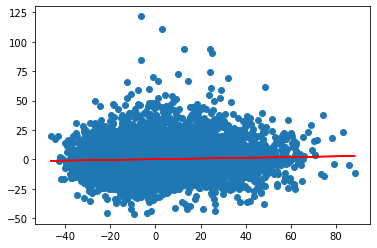

In [222]:
tec = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
sws = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"

tecData = readH5File(tec)
f10Data = readH5File(f10)
swsData = readH5File(sws)

tecData = tecData.fillna(0)
f10Data = f10Data.fillna(0)
swsData = swsData.fillna(0)

plt.scatter(tecData[55], swsData['sws'])

m, b = np.polyfit(tecData[55], swsData['sws'], 1)
plt.plot(tecData[55], m*tecData[55]+b, color="red")

plt.show()



plt.scatter(tecData[55], f10Data['f10_7'])

m, b = np.polyfit(tecData[55], f10Data['f10_7'], 1)
plt.plot(tecData[55], m*tecData[55]+b, color="red")

plt.show()
plt.scatter(swsData['sws'], f10Data['f10_7'])

m, b = np.polyfit(swsData['sws'], f10Data['f10_7'], 1)
plt.plot(swsData['sws'], m*swsData['sws']+b, color="red")


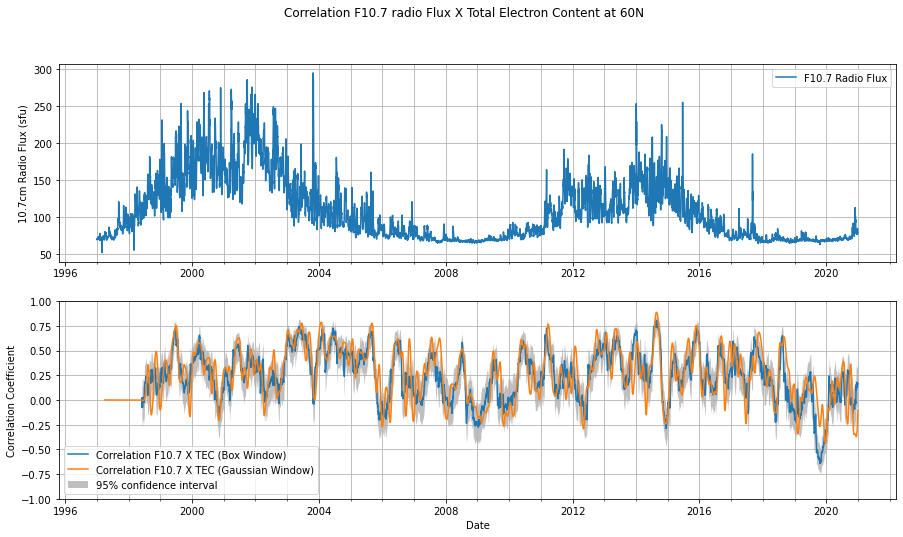

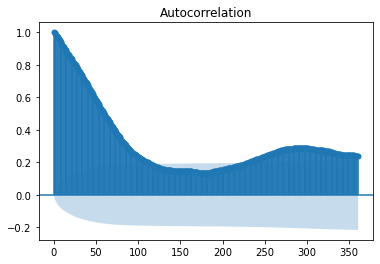

In [265]:
tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_lowerConfInterval.h5"
tec_f10_7_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_upperConfInterval.h5"

tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
tec_f10_7_norm_corrr = readH5File(tec_f10_7_norm_corrr_file)
tec_f10_7_corrr_lowerLimit = readH5File(tec_f10_7_corrr_lowerLimitFile)
tec_f10_7_corrr_upperLimit = readH5File(tec_f10_7_corrr_upperLimitFile)



tec_f10_7_corrr = tec_f10_7_corrr[[60.0]]
tec_f10_7_norm_corrr = tec_f10_7_norm_corrr[60.0]
tec_f10_7_corrr_lowerLimit = tec_f10_7_corrr_lowerLimit[60.0]
tec_f10_7_corrr_upperLimit = tec_f10_7_corrr_upperLimit[60.0]


# print(tec_f10_7_corrr_lowerLimit)

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at 60N')
fig.set_size_inches(15, 8)
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)
axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_f10_7_corrr, label='Correlation F10.7 X TEC (Box Window)')
axs[1].plot(tec_f10_7_norm_corrr, label='Correlation F10.7 X TEC (Gaussian Window)')
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_f10_7_corrr_lowerLimit.index
                
yAxisLower = tec_f10_7_corrr_lowerLimit
yAxisUpper = tec_f10_7_corrr_upperLimit
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')

axs[1].legend()
axs[0].legend()       
plt.savefig('Correlation F10.7 radio Flux X Total Electron Content at 60N.png', dpi=300)
plt.show()



# pd.set_option("display.max_rows", None, "display.max_columns", None)
# temp = f10_7.sort_values('f10_7', ascending=False).head(200)

# temp1 = temp.sort_index()
# print(temp1)

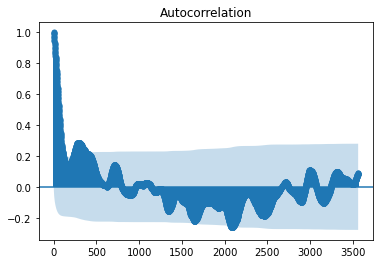

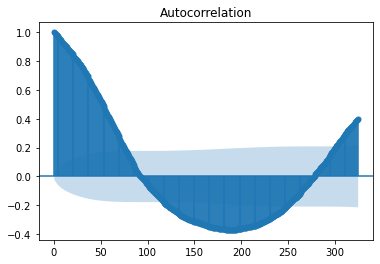

In [292]:
# print(tec_f10_7_corrr)
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(tec_f10_7_corrr, lags=27*12*11, missing='drop')
# Show the AR as a plot
plt.show()
plot_acf(tec_sws_corrr, lags=27*12, missing='drop')
plt.show()

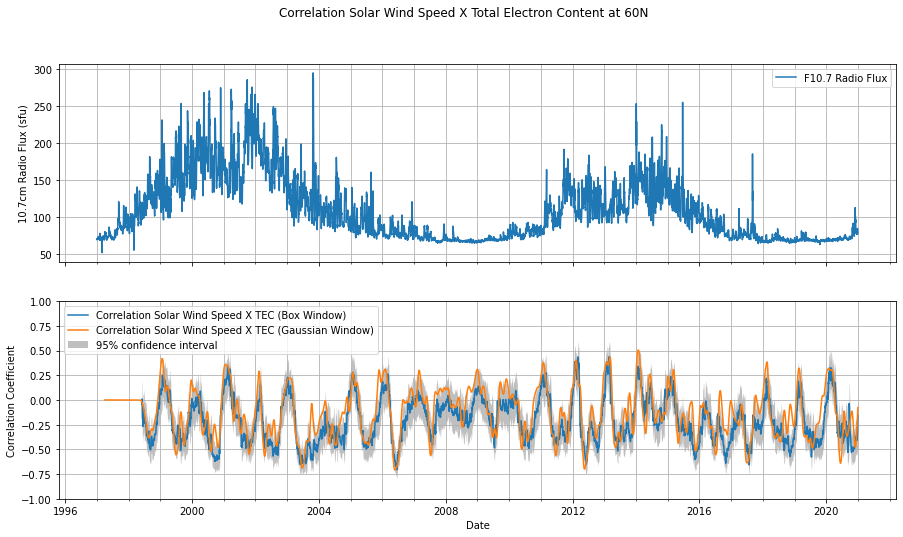

In [226]:


tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_sws\\tec_sws.h5"
tec_sws_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_sws\\tec_sws.h5"
tec_sws_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_lowerConfInterval.h5"
tec_sws_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_upperConfInterval.h5"

tec_sws_corrr = readH5File(tec_sws_corrr_file)
tec_sws_norm_corrr = readH5File(tec_sws_norm_corrr_file)
tec_sws_corrr_lowerLimit = readH5File(tec_sws_corrr_lowerLimitFile)
tec_sws_corrr_upperLimit = readH5File(tec_sws_corrr_upperLimitFile)


tec_sws_corrr = tec_sws_corrr[60.0]
tec_sws_norm_corrr = tec_sws_norm_corrr[60.0]
tec_sws_corrr_lowerLimit = tec_sws_corrr_lowerLimit[60.0]
tec_sws_corrr_upperLimit = tec_sws_corrr_upperLimit[60.0]

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 60N')
fig.set_size_inches(15, 8)

axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_corrr, label='Correlation Solar Wind Speed X TEC (Box Window)')
axs[1].plot(tec_sws_norm_corrr, label='Correlation Solar Wind Speed X TEC (Gaussian Window)')


axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_sws_corrr_lowerLimit.index
                
yAxisLower = tec_sws_corrr_lowerLimit
yAxisUpper = tec_sws_corrr_upperLimit
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')


axs[1].legend()
axs[0].legend()   
plt.savefig('Correlation Solar Wind Speed X Total Electron Content at 60N.png', dpi=300)
plt.show()

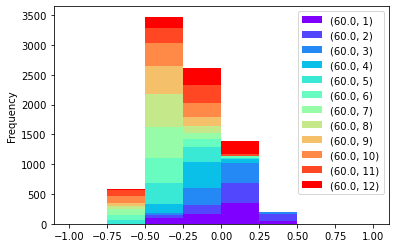

<AxesSubplot:ylabel='Frequency'>

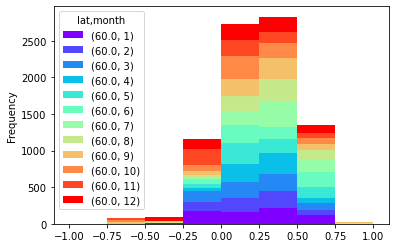

In [263]:
colors = plt.cm.rainbow(np.linspace(0, 1, 12))

# print(tec_sws_corrr)
tec_sws_corrr_datesplit = tec_sws_corrr.copy().to_frame()
tec_sws_corrr_datesplit.index = pd.to_datetime(tec_sws_corrr_datesplit.index, format='%Y-%m-%d')
# print(tec_sws_corrr_datesplit)
tec_sws_corrr_datesplit['day'] = tec_sws_corrr_datesplit.index.day
# print(tec_sws_corrr_datesplit)
tec_sws_corrr_datesplit['month'] = tec_sws_corrr_datesplit.index.month
tec_sws_corrr_datesplit['year'] = tec_sws_corrr_datesplit.index.year
tec_sws_corrr_datesplit = tec_sws_corrr_datesplit.reset_index().drop('date', axis=1).set_index(['day', 'month', 'year']).unstack('month')

# plt.hist(tec_sws_corrr_datesplit, bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True)
tec_sws_corrr_datesplit.plot.hist(bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color=colors)
plt.legend()
plt.show()



# print(tec_sws_corrr)
tec_f10_7_corrr_datesplit = tec_f10_7_corrr.copy()
tec_f10_7_corrr_datesplit.index = pd.to_datetime(tec_f10_7_corrr_datesplit.index, format='%Y-%m-%d')
# print(tec_sws_corrr_datesplit)
tec_f10_7_corrr_datesplit['day'] = tec_f10_7_corrr_datesplit.index.day
# print(tec_sws_corrr_datesplit)
tec_f10_7_corrr_datesplit['month'] = tec_f10_7_corrr_datesplit.index.month
tec_f10_7_corrr_datesplit['year'] = tec_f10_7_corrr_datesplit.index.year
tec_f10_7_corrr_datesplit = tec_f10_7_corrr_datesplit.reset_index().drop('date', axis=1).set_index(['day', 'month', 'year']).unstack('month')

# print(tec_f10_7_corrr_datesplit)


# plt.hist(tec_f10_7_corrr_datesplit, bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color = colors)
tec_f10_7_corrr_datesplit.plot.hist(bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color=colors)